In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Step 0.0. Install LightAutoML

Uncomment if doesn't clone repository by git. (ex.: colab, kaggle version)

In [ ]:
#! pip install -U lightautoml

# Step 0.1. Import necessary libraries 

In [1]:
%matplotlib inline
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

[2021-06-01 08:55:19,031] (WARNING): /usr/local/lib/python3.6/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)



# Step 0.2. Parameters 

In [2]:
N_THREADS = 64 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 3600 # Time in seconds for automl run
TARGET_NAME = 'Is_Lead' # Target column name

# Step 0.3. Fix torch number of threads and numpy seed 

In [3]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Example data load 

In [4]:
%%time

train_data = pd.read_csv('example_data/train_data_jobathon.csv')
print(train_data.shape)
train_data.head()

(245725, 11)
CPU times: user 442 ms, sys: 62.3 ms, total: 504 ms
Wall time: 219 ms


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [5]:
test_data = pd.read_csv('example_data/test_data_jobathon.csv')
print(test_data.shape)
test_data.head()

(105312, 10)


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [6]:
sample_sub = pd.read_csv('example_data/sample_sub_jobathon.csv')
print(sample_sub.shape)
sample_sub.head()

(105312, 2)


,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,0
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0


# Step 0.5. Check datasets statistics 

In [7]:
%%time

train_ids = set(train_data['ID'].values)
test_ids = set(test_data['ID'].values)
len(train_ids.intersection(test_ids))

CPU times: user 26.3 ms, sys: 0 ns, total: 26.3 ms
Wall time: 26 ms


0

In [8]:
train_data['ID'].value_counts()

6W5XVUY3    1
YSAAGRDC    1
MXOVD4XY    1
EFWZSGWK    1
IEVPZCKU    1
           ..
BRVP5MKD    1
HGXCCUIJ    1
2FAFG9NX    1
PDM47EBK    1
DM2VHNQE    1
Name: ID, Length: 245725, dtype: int64

In [9]:
test_data['ID'].value_counts()

AUCLB8UK    1
ZZLD6SUY    1
KXZEPXRT    1
GR7IJRJC    1
VVHSQTD4    1
           ..
3ZWAHPWW    1
QLGEA9HB    1
5NQFWQP5    1
FYN3NEPK    1
NVHHRKXE    1
Name: ID, Length: 105312, dtype: int64

In [10]:
train_data['tmp'] = train_data['Gender'].astype(str)
train_data.groupby('tmp')[TARGET_NAME].agg(mean = np.mean, len = len).reset_index()

,tmp,mean,len
0,Female,0.203581,111528
1,Male,0.265155,134197


In [11]:
train_data['tmp'] = train_data['Is_Active'].astype(str)
train_data.groupby('tmp')[TARGET_NAME].agg(mean = np.mean, len = len).reset_index()

,tmp,mean,len
0,No,0.208151,150290
1,Yes,0.282967,95435


In [12]:
train_data['tmp'] = train_data['Credit_Product'].astype(str)
train_data.groupby('tmp')[TARGET_NAME].agg(mean = np.mean, len = len).reset_index()

,tmp,mean,len
0,No,0.073588,144357
1,Yes,0.314951,72043
2,nan,0.851662,29325


In [13]:
train_data['tmp'] = train_data['Occupation'].astype(str)
train_data.groupby('tmp')[TARGET_NAME].agg(mean = np.mean, len = len).reset_index()

,tmp,mean,len
0,Entrepreneur,0.660667,2667
1,Other,0.244952,70173
2,Salaried,0.159669,71999
3,Self_Employed,0.275965,100886


In [14]:
train_data.drop('tmp', axis = 1, inplace = True)

In [15]:
all_df = pd.concat([train_data, test_data]).reset_index(drop = True)
all_df.shape

(351037, 11)

In [16]:
all_df['Region_Code'].value_counts()

RG268    51059
RG283    42297
RG254    38577
RG284    27493
RG277    18422
RG280    18304
RG270    11160
RG269    11151
RG261    10919
RG257     8689
RG251     8628
RG282     8166
RG272     7590
RG274     7494
RG281     7237
RG273     6300
RG252     6097
RG279     5576
RG263     5302
RG275     4628
RG260     4410
RG256     4041
RG264     4034
RG276     3949
RG259     3688
RG250     3544
RG255     2909
RG258     2763
RG253     2668
RG278     2646
RG262     2588
RG265     2214
RG266     2209
RG271     2196
RG267     2089
Name: Region_Code, dtype: int64

In [17]:
tmp = all_df['Avg_Account_Balance'].value_counts()
print(tmp.shape)
tmp[tmp > 10]

[2021-06-01 08:55:25,837] (INFO): Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[2021-06-01 08:55:25,837] (INFO): Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2021-06-01 08:55:25,838] (INFO): NumExpr defaulting to 8 threads.


(162137,)


4022185    172
1611273     47
936814      45
4126262     44
1142030     43
          ... 
977576      11
742482      11
814572      11
910639      11
683439      11
Name: Avg_Account_Balance, Length: 342, dtype: int64

In [18]:
tmp = all_df['Vintage'].value_counts()
print(tmp.shape)
tmp.sort_index()

(66,)


7        920
8        911
9        913
13     17717
14     17593
       ...  
128      712
129      746
133       29
134       17
135       26
Name: Vintage, Length: 66, dtype: int64

<AxesSubplot:>

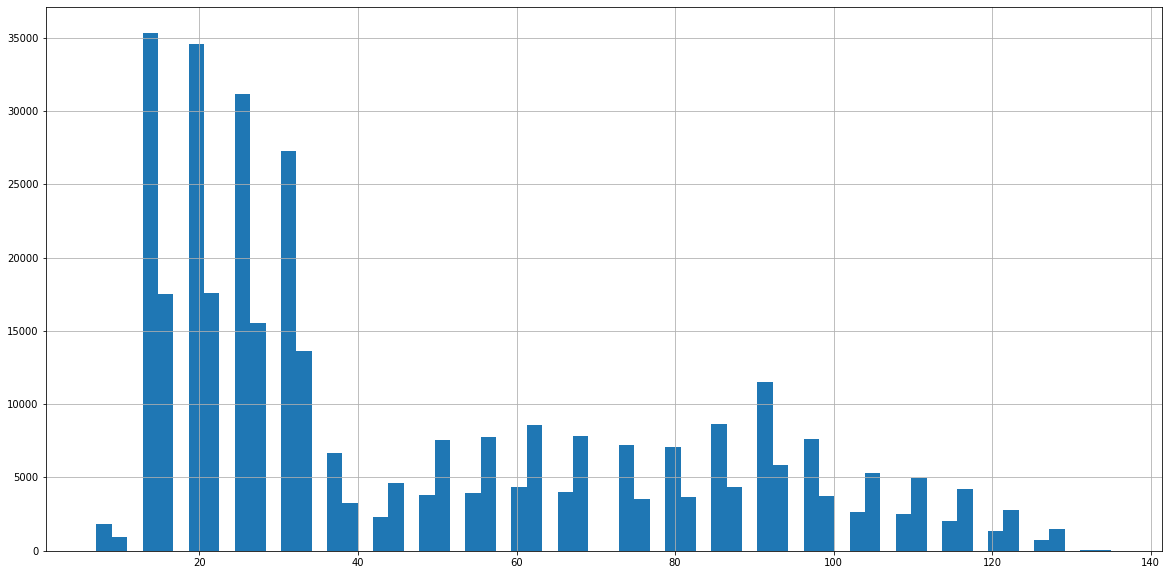

In [19]:
all_df['Vintage'].hist(bins = 66, figsize = (20, 10))

In [20]:
all_df['Channel_Code'].value_counts()

X1    148202
X3     97981
X2     96902
X4      7952
Name: Channel_Code, dtype: int64

In [21]:
all_df['Occupation'].value_counts()

Self_Employed    144078
Salaried         102912
Other            100304
Entrepreneur       3743
Name: Occupation, dtype: int64

In [22]:
tmp = all_df['Age'].value_counts()
print(tmp.shape)
tmp

(63,)


28    20880
29    18984
27    18615
30    15684
26    12916
      ...  
82     1077
83     1022
84      916
85      888
23        1
Name: Age, Length: 63, dtype: int64

In [23]:
train_data['Occupation'].value_counts()

Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64

In [24]:
train_data.groupby('Occupation')[TARGET_NAME].mean().reset_index()

,Occupation,Is_Lead
0,Entrepreneur,0.660667
1,Other,0.244952
2,Salaried,0.159669
3,Self_Employed,0.275965


<AxesSubplot:>

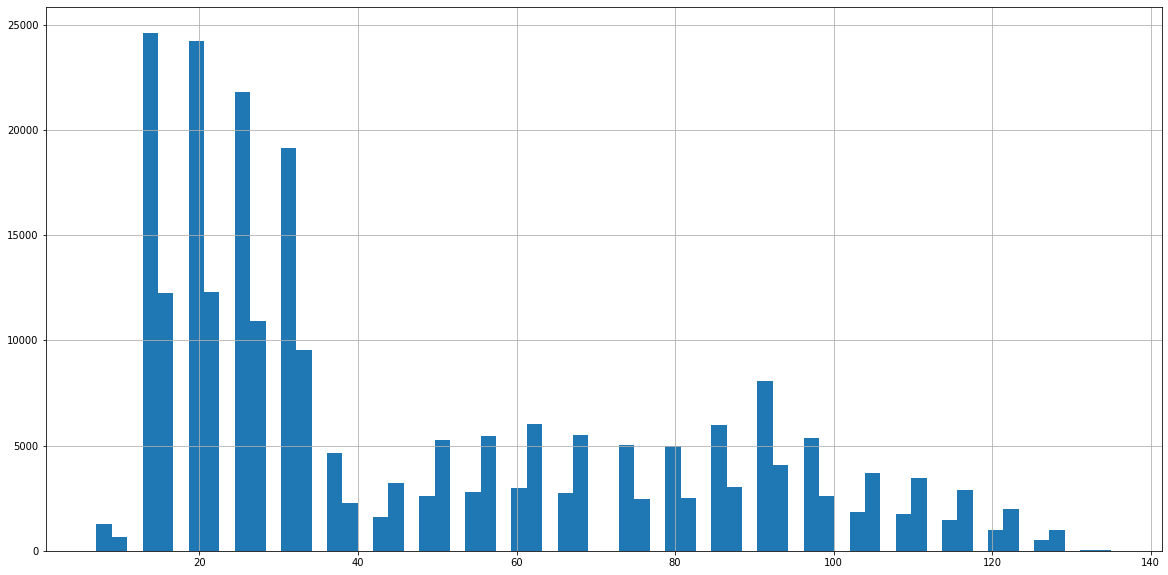

In [25]:
train_data['Vintage'].hist(bins = 66, figsize = (20, 10))

<AxesSubplot:>

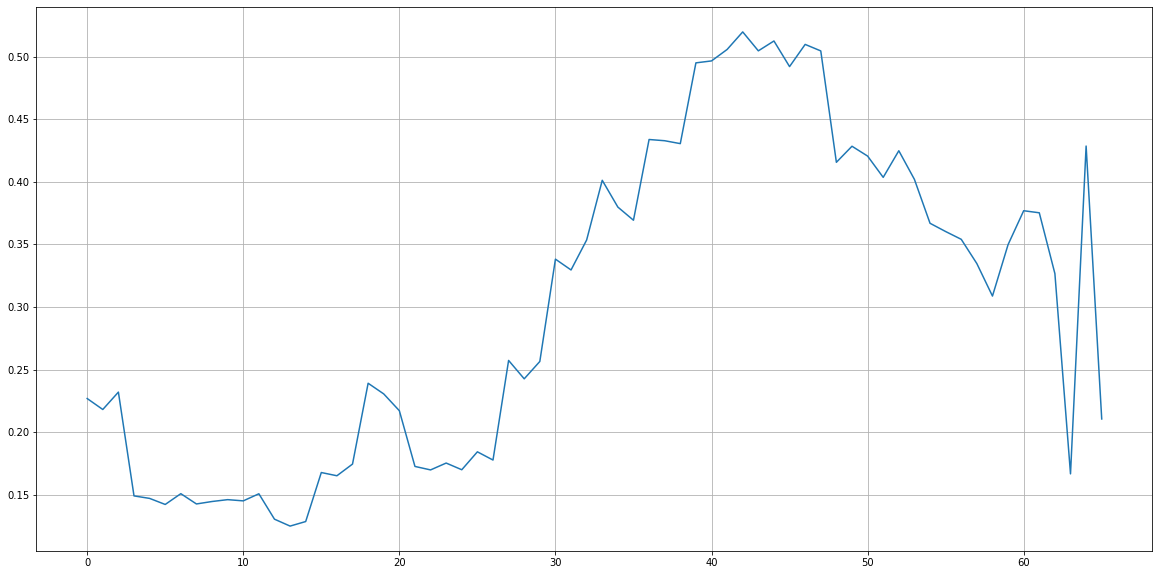

In [26]:
train_data.groupby('Vintage')[TARGET_NAME].mean().sort_index().reset_index()['Is_Lead'].plot(figsize = (20, 10), grid = True)

In [27]:
train_data.groupby('Vintage')[TARGET_NAME].mean()

Vintage
7      0.226852
8      0.218094
9      0.231975
13     0.149052
14     0.147061
         ...   
128    0.375250
129    0.326653
133    0.166667
134    0.428571
135    0.210526
Name: Is_Lead, Length: 66, dtype: float64

# Step 0.6. Feature engineering

In [28]:
def create_extra_features(data):
    data['Region_Code_Num'] = data['Region_Code'].str.slice(start = 2).astype(int)
    data['Channel_Code_Num'] = data['Channel_Code'].str.slice(start = 1).astype(int)

def create_gr_feats(data):
    for cat_col in ['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                    'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']:
        for num_col in ['Age', 'Vintage', 'Avg_Account_Balance']:
            if cat_col == num_col: continue
            
            gr = data.groupby(cat_col)[num_col]
            for n, f in [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]:
                data[n + '_' + num_col + '_by_' + cat_col] = gr.transform(f)
                
            data[num_col + '_delta_mean_by_' + cat_col] = data[num_col] - data[cat_col].map(gr.mean())
            data[num_col + '_delta_median_by_' + cat_col] = data[num_col] - data[cat_col].map(gr.median())
                                                                                              
    for col in ['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                   'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',]:
        data[col + '_cnt'] = data[col].map(data[col].value_counts(dropna = False))

create_extra_features(train_data)
create_extra_features(test_data)

all_df = pd.concat([train_data, test_data]).reset_index(drop = True)
create_gr_feats(all_df)
train_data, test_data = all_df[:len(train_data)], all_df[len(train_data):]
print(train_data.shape, test_data.shape)

(245725, 142) (105312, 142)


In [29]:
pd.set_option('display.max_columns', 200)
train_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Region_Code_Num,Channel_Code_Num,mean_Age_by_Gender,min_Age_by_Gender,max_Age_by_Gender,Age_delta_mean_by_Gender,Age_delta_median_by_Gender,mean_Vintage_by_Gender,min_Vintage_by_Gender,max_Vintage_by_Gender,Vintage_delta_mean_by_Gender,Vintage_delta_median_by_Gender,mean_Avg_Account_Balance_by_Gender,min_Avg_Account_Balance_by_Gender,max_Avg_Account_Balance_by_Gender,Avg_Account_Balance_delta_mean_by_Gender,Avg_Account_Balance_delta_median_by_Gender,mean_Vintage_by_Age,min_Vintage_by_Age,max_Vintage_by_Age,Vintage_delta_mean_by_Age,Vintage_delta_median_by_Age,mean_Avg_Account_Balance_by_Age,min_Avg_Account_Balance_by_Age,max_Avg_Account_Balance_by_Age,Avg_Account_Balance_delta_mean_by_Age,Avg_Account_Balance_delta_median_by_Age,mean_Age_by_Region_Code,min_Age_by_Region_Code,max_Age_by_Region_Code,Age_delta_mean_by_Region_Code,Age_delta_median_by_Region_Code,mean_Vintage_by_Region_Code,min_Vintage_by_Region_Code,max_Vintage_by_Region_Code,Vintage_delta_mean_by_Region_Code,Vintage_delta_median_by_Region_Code,mean_Avg_Account_Balance_by_Region_Code,min_Avg_Account_Balance_by_Region_Code,max_Avg_Account_Balance_by_Region_Code,Avg_Account_Balance_delta_mean_by_Region_Code,Avg_Account_Balance_delta_median_by_Region_Code,mean_Age_by_Occupation,min_Age_by_Occupation,max_Age_by_Occupation,Age_delta_mean_by_Occupation,Age_delta_median_by_Occupation,mean_Vintage_by_Occupation,min_Vintage_by_Occupation,max_Vintage_by_Occupation,Vintage_delta_mean_by_Occupation,Vintage_delta_median_by_Occupation,mean_Avg_Account_Balance_by_Occupation,min_Avg_Account_Balance_by_Occupation,max_Avg_Account_Balance_by_Occupation,Avg_Account_Balance_delta_mean_by_Occupation,Avg_Account_Balance_delta_median_by_Occupation,mean_Age_by_Channel_Code,min_Age_by_Channel_Code,max_Age_by_Channel_Code,Age_delta_mean_by_Channel_Code,Age_delta_median_by_Channel_Code,mean_Vintage_by_Channel_Code,min_Vintage_by_Channel_Code,max_Vintage_by_Channel_Code,Vintage_delta_mean_by_Channel_Code,Vintage_delta_median_by_Channel_Code,mean_Avg_Account_Balance_by_Channel_Code,min_Avg_Account_Balance_by_Channel_Code,max_Avg_Account_Balance_by_Channel_Code,Avg_Account_Balance_delta_mean_by_Channel_Code,Avg_Account_Balance_delta_median_by_Channel_Code,mean_Age_by_Vintage,min_Age_by_Vintage,max_Age_by_Vintage,Age_delta_mean_by_Vintage,Age_delta_median_by_Vintage,mean_Avg_Account_Balance_by_Vintage,min_Avg_Account_Balance_by_Vintage,max_Avg_Account_Balance_by_Vintage,Avg_Account_Balance_delta_mean_by_Vintage,Avg_Account_Balance_delta_median_by_Vintage,mean_Age_by_Credit_Product,min_Age_by_Credit_Product,max_Age_by_Credit_Product,Age_delta_mean_by_Credit_Product,Age_delta_median_by_Credit_Product,mean_Vintage_by_Credit_Product,min_Vintage_by_Credit_Product,max_Vintage_by_Credit_Product,Vintage_delta_mean_by_Credit_Product,Vintage_delta_median_by_Credit_Product,mean_Avg_Account_Balance_by_Credit_Product,min_Avg_Account_Balance_by_Credit_Product,max_Avg_Account_Balance_by_Credit_Product,Avg_Account_Balance_delta_mean_by_Credit_Product,Avg_Account_Balance_delta_median_by_Credit_Product,mean_Age_by_Avg_Account_Balance,min_Age_by_Avg_Account_Balance,max_Age_by_Avg_Account_Balance,Age_delta_mean_by_Avg_Account_Balance,Age_delta_median_by_Avg_Account_Balance,mean_Vintage_by_Avg_Account_Balance,min_Vintage_by_Avg_Account_Balance,max_Vintage_by_Avg_Account_Balance,Vintage_delta_mean_by_Avg_Account_Balance,Vintage_delta_median_by_Avg_Account_Balance,mean_Age_by_Is_Active,min_Age_by_Is_Active,max_Age_by_Is_Active,Age_delta_mean_by_Is_Active,Age_delta_median_by_Is_Active,mean_Vintage_by_Is_Active,min_Vintage_by_Is_Active,max_Vintage_by_Is_Active,Vintage_delta_mean_by_Is_Active,Vintage_delta_median_by_Is_Active,mean_Avg_Account_Balance_by_Is_Active,min_Avg_Account_Balance_by_Is_Active,max_Avg_Account_Balance_by_Is_Active,Avg_Account_Balance_delta_mean_by_Is_Active,Avg_Account_Balance_delta_median_

In [30]:
train_data.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead,Region_Code_Num,Channel_Code_Num,mean_Age_by_Gender,min_Age_by_Gender,max_Age_by_Gender,Age_delta_mean_by_Gender,Age_delta_median_by_Gender,mean_Vintage_by_Gender,min_Vintage_by_Gender,max_Vintage_by_Gender,Vintage_delta_mean_by_Gender,Vintage_delta_median_by_Gender,mean_Avg_Account_Balance_by_Gender,min_Avg_Account_Balance_by_Gender,max_Avg_Account_Balance_by_Gender,Avg_Account_Balance_delta_mean_by_Gender,Avg_Account_Balance_delta_median_by_Gender,mean_Vintage_by_Age,min_Vintage_by_Age,max_Vintage_by_Age,Vintage_delta_mean_by_Age,Vintage_delta_median_by_Age,mean_Avg_Account_Balance_by_Age,min_Avg_Account_Balance_by_Age,max_Avg_Account_Balance_by_Age,Avg_Account_Balance_delta_mean_by_Age,Avg_Account_Balance_delta_median_by_Age,mean_Age_by_Region_Code,min_Age_by_Region_Code,max_Age_by_Region_Code,Age_delta_mean_by_Region_Code,Age_delta_median_by_Region_Code,mean_Vintage_by_Region_Code,min_Vintage_by_Region_Code,max_Vintage_by_Region_Code,Vintage_delta_mean_by_Region_Code,Vintage_delta_median_by_Region_Code,mean_Avg_Account_Balance_by_Region_Code,min_Avg_Account_Balance_by_Region_Code,max_Avg_Account_Balance_by_Region_Code,Avg_Account_Balance_delta_mean_by_Region_Code,Avg_Account_Balance_delta_median_by_Region_Code,mean_Age_by_Occupation,min_Age_by_Occupation,max_Age_by_Occupation,Age_delta_mean_by_Occupation,Age_delta_median_by_Occupation,mean_Vintage_by_Occupation,min_Vintage_by_Occupation,max_Vintage_by_Occupation,Vintage_delta_mean_by_Occupation,Vintage_delta_median_by_Occupation,mean_Avg_Account_Balance_by_Occupation,min_Avg_Account_Balance_by_Occupation,max_Avg_Account_Balance_by_Occupation,Avg_Account_Balance_delta_mean_by_Occupation,Avg_Account_Balance_delta_median_by_Occupation,mean_Age_by_Channel_Code,min_Age_by_Channel_Code,max_Age_by_Channel_Code,Age_delta_mean_by_Channel_Code,Age_delta_median_by_Channel_Code,mean_Vintage_by_Channel_Code,min_Vintage_by_Channel_Code,max_Vintage_by_Channel_Code,Vintage_delta_mean_by_Channel_Code,Vintage_delta_median_by_Channel_Code,mean_Avg_Account_Balance_by_Channel_Code,min_Avg_Account_Balance_by_Channel_Code,max_Avg_Account_Balance_by_Channel_Code,Avg_Account_Balance_delta_mean_by_Channel_Code,Avg_Account_Balance_delta_median_by_Channel_Code,mean_Age_by_Vintage,min_Age_by_Vintage,max_Age_by_Vintage,Age_delta_mean_by_Vintage,Age_delta_median_by_Vintage,mean_Avg_Account_Balance_by_Vintage,min_Avg_Account_Balance_by_Vintage,max_Avg_Account_Balance_by_Vintage,Avg_Account_Balance_delta_mean_by_Vintage,Avg_Account_Balance_delta_median_by_Vintage,mean_Age_by_Credit_Product,min_Age_by_Credit_Product,max_Age_by_Credit_Product,Age_delta_mean_by_Credit_Product,Age_delta_median_by_Credit_Product,mean_Vintage_by_Credit_Product,min_Vintage_by_Credit_Product,max_Vintage_by_Credit_Product,Vintage_delta_mean_by_Credit_Product,Vintage_delta_median_by_Credit_Product,mean_Avg_Account_Balance_by_Credit_Product,min_Avg_Account_Balance_by_Credit_Product,max_Avg_Account_Balance_by_Credit_Product,Avg_Account_Balance_delta_mean_by_Credit_Product,Avg_Account_Balance_delta_median_by_Credit_Product,mean_Age_by_Avg_Account_Balance,min_Age_by_Avg_Account_Balance,max_Age_by_Avg_Account_Balance,Age_delta_mean_by_Avg_Account_Balance,Age_delta_median_by_Avg_Account_Balance,mean_Vintage_by_Avg_Account_Balance,min_Vintage_by_Avg_Account_Balance,max_Vintage_by_Avg_Account_Balance,Vintage_delta_mean_by_Avg_Account_Balance,Vintage_delta_median_by_Avg_Account_Balance,mean_Age_by_Is_Active,min_Age_by_Is_Active,max_Age_by_Is_Active,Age_delta_mean_by_Is_Active,Age_delta_median_by_Is_Active,mean_Vintage_by_Is_Active,min_Vintage_by_Is_Active,max_Vintage_by_Is_Active,Vintage_delta_mean_by_Is_Active,Vintage_delta_median_by_Is_Active,mean_Avg_Account_Balance_by_Is_Active,min_Avg_Account_Balance_by_Is_Active,max_Avg_Account_Balance_by_Is_Active,Avg_Account_Balance_delta_mean_by_Is_Active,Avg_Account_Balance_delta_median_by_Is_Active,Gender_cnt,Age_cnt,Region_Code_cnt,Occupation_cnt,Channel_

# ========= AutoML preset usage =========


## Step 1. Create Task

In [31]:
%%time

task = Task('binary', )

CPU times: user 3.62 ms, sys: 3.16 ms, total: 6.78 ms
Wall time: 5.06 ms


## Step 2. Setup columns roles

Roles setup here set target column and base date, which is used to calculate date differences:

In [32]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['ID']
         }

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 15.7 µs


## Step 3. Create AutoML from preset on full data

To create AutoML model here we use `TabularUtilizedAutoML` preset:

In [33]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 64, 'random_state': 42}
Start automl preset with listed constraints:
- time: 3599.9985644817352 seconds
- cpus: 64 cores
- memory: 16 gb

Train data shape: (245725, 142)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3578.664763212204 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8697631659391021
Linear model: C = 5e-05 score = 0.8712570036080014
Linear model: C = 0.0001 score = 0.8717823028123797
Linear model: C = 0.0005 score = 0.8732522295956873
Linear model: C = 0.001 score = 0.8738193825753044
Linear model: C = 0.005 score = 0.8744470473266839
Linear model: C = 0.01 score = 0.8744470473266839
Linear model: C = 0.05 sco

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[2021-06-01 08:58:45,974] (INFO): A new study created in memory with name: no-name-5dce4a84-0b7a-4268-892c-a8ea2dee744d


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875261
Early stopping, best iteration is:
[61]	valid's auc: 0.875813
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:58:52,415] (INFO): Trial 0 finished with value: 0.8758133122172456 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.8758133122172456.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875817
Early stopping, best iteration is:
[96]	valid's auc: 0.875933
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:59:03,597] (INFO): Trial 1 finished with value: 0.8759325966208474 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.8759325966208474.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875019
Early stopping, best iteration is:
[57]	valid's auc: 0.875724
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:59:16,485] (INFO): Trial 2 finished with value: 0.8757245005199297 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 1 with value: 0.8759325966208474.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.873902
Early stopping, best iteration is:
[42]	valid's auc: 0.875329
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:59:26,632] (INFO): Trial 3 finished with value: 0.8753294606074007 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 1 with value: 0.8759325966208474.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876037
[200]	valid's auc: 0.875725
Early stopping, best iteration is:
[140]	valid's auc: 0.876127
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:59:31,538] (INFO): Trial 4 finished with value: 0.8761266869245345 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875387
Early stopping, best iteration is:
[42]	valid's auc: 0.876059
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:59:39,130] (INFO): Trial 5 finished with value: 0.876058741473775 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875988
Early stopping, best iteration is:
[98]	valid's auc: 0.876001
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:59:43,743] (INFO): Trial 6 finished with value: 0.876000580973421 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.87558
Early stopping, best iteration is:
[44]	valid's auc: 0.875846
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:59:52,044] (INFO): Trial 7 finished with value: 0.8758458901981745 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875211
Early stopping, best iteration is:
[37]	valid's auc: 0.875648
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 08:59:57,768] (INFO): Trial 8 finished with value: 0.8756484348875716 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874545
Early stopping, best iteration is:
[38]	valid's auc: 0.87576
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:07,828] (INFO): Trial 9 finished with value: 0.8757602066643768 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875635
[200]	valid's auc: 0.875762
[300]	valid's auc: 0.875956
[400]	valid's auc: 0.876045
[500]	valid's auc: 0.876052
Early stopping, best iteration is:
[431]	valid's auc: 0.876108
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:16,447] (INFO): Trial 10 finished with value: 0.8761084122252969 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8117835630346862, 'min_sum_hessian_in_leaf': 6.083603329305881, 'reg_alpha': 1.8436338969381074e-06, 'reg_lambda': 1.475649304728376}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875787
[200]	valid's auc: 0.875808
Early stopping, best iteration is:
[107]	valid's auc: 0.876034
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:20,564] (INFO): Trial 11 finished with value: 0.8760338271502149 and parameters: {'feature_fraction': 0.8830072969127754, 'num_leaves': 16, 'bagging_fraction': 0.8104730517997013, 'min_sum_hessian_in_leaf': 9.980979971437783, 'reg_alpha': 4.2982879191967924e-07, 'reg_lambda': 7.3871412375861425}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875816
Early stopping, best iteration is:
[89]	valid's auc: 0.876109
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:26,781] (INFO): Trial 12 finished with value: 0.8761094202399492 and parameters: {'feature_fraction': 0.8975870867199489, 'num_leaves': 67, 'bagging_fraction': 0.7510534415932039, 'min_sum_hessian_in_leaf': 7.1727887084381985, 'reg_alpha': 5.447266061300333e-06, 'reg_lambda': 0.5855213887055131}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.87553
Early stopping, best iteration is:
[54]	valid's auc: 0.875956
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:32,483] (INFO): Trial 13 finished with value: 0.8759558896540983 and parameters: {'feature_fraction': 0.9039757416031456, 'num_leaves': 75, 'bagging_fraction': 0.700308320229967, 'min_sum_hessian_in_leaf': 3.643340758157349, 'reg_alpha': 7.207830795317355e-06, 'reg_lambda': 0.33838882364830586}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875913
[200]	valid's auc: 0.875455
Early stopping, best iteration is:
[110]	valid's auc: 0.875945
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:38,305] (INFO): Trial 14 finished with value: 0.8759451344466831 and parameters: {'feature_fraction': 0.9263379977923416, 'num_leaves': 60, 'bagging_fraction': 0.6172730689929808, 'min_sum_hessian_in_leaf': 0.9740712908301521, 'reg_alpha': 1.1832491946798518e-08, 'reg_lambda': 4.834828939135668e-06}. Best is trial 4 with value: 0.8761266869245345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876344
Early stopping, best iteration is:
[98]	valid's auc: 0.87637
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:44,557] (INFO): Trial 15 finished with value: 0.8763702374522795 and parameters: {'feature_fraction': 0.8372954078138088, 'num_leaves': 62, 'bagging_fraction': 0.7483016145032468, 'min_sum_hessian_in_leaf': 8.388693397392307, 'reg_alpha': 1.341057986256183e-08, 'reg_lambda': 0.0014754162754925543}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875275
Early stopping, best iteration is:
[46]	valid's auc: 0.876065
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:50,756] (INFO): Trial 16 finished with value: 0.8760649714848787 and parameters: {'feature_fraction': 0.8173658922504777, 'num_leaves': 107, 'bagging_fraction': 0.8574452072221941, 'min_sum_hessian_in_leaf': 9.403319551199754, 'reg_alpha': 1.138658618320335e-08, 'reg_lambda': 0.001957689984381241}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875691
Early stopping, best iteration is:
[57]	valid's auc: 0.87597
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:54,208] (INFO): Trial 17 finished with value: 0.8759696300036566 and parameters: {'feature_fraction': 0.6826314069423317, 'num_leaves': 49, 'bagging_fraction': 0.5488064424806847, 'min_sum_hessian_in_leaf': 0.0025428527571253663, 'reg_alpha': 1.000079082963696e-08, 'reg_lambda': 0.00029354899062119106}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875482
Early stopping, best iteration is:
[57]	valid's auc: 0.876097
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:00:59,768] (INFO): Trial 18 finished with value: 0.8760965334419581 and parameters: {'feature_fraction': 0.8408684152085875, 'num_leaves': 99, 'bagging_fraction': 0.675486896231877, 'min_sum_hessian_in_leaf': 0.46753239130569785, 'reg_alpha': 1.0907747046403103e-07, 'reg_lambda': 7.639371274654828e-06}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876115
[200]	valid's auc: 0.875642
Early stopping, best iteration is:
[104]	valid's auc: 0.87618
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:04,243] (INFO): Trial 19 finished with value: 0.8761798371000725 and parameters: {'feature_fraction': 0.7491317764292676, 'num_leaves': 39, 'bagging_fraction': 0.7425791214698095, 'min_sum_hessian_in_leaf': 2.631226604747435, 'reg_alpha': 5.084693913436718e-08, 'reg_lambda': 0.0014910851669876059}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875336
Early stopping, best iteration is:
[46]	valid's auc: 0.876097
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:11,494] (INFO): Trial 20 finished with value: 0.8760967382485676 and parameters: {'feature_fraction': 0.6336175365831116, 'num_leaves': 173, 'bagging_fraction': 0.7723040206483124, 'min_sum_hessian_in_leaf': 3.4188805343804374, 'reg_alpha': 4.2062874579630056e-08, 'reg_lambda': 0.05710491088529287}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875845
Early stopping, best iteration is:
[84]	valid's auc: 0.876028
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:15,536] (INFO): Trial 21 finished with value: 0.8760276371850961 and parameters: {'feature_fraction': 0.7594302951908252, 'num_leaves': 40, 'bagging_fraction': 0.7392198146636509, 'min_sum_hessian_in_leaf': 1.551580365311881, 'reg_alpha': 7.232508588606664e-07, 'reg_lambda': 0.0019212906512829707}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875546
Early stopping, best iteration is:
[72]	valid's auc: 0.875998
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:20,785] (INFO): Trial 22 finished with value: 0.8759984287877671 and parameters: {'feature_fraction': 0.7519214571919757, 'num_leaves': 86, 'bagging_fraction': 0.6480179655471836, 'min_sum_hessian_in_leaf': 0.7883554958631125, 'reg_alpha': 1.0052034947125306e-08, 'reg_lambda': 0.0009045759376663862}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875973
Early stopping, best iteration is:
[91]	valid's auc: 0.876158
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:25,172] (INFO): Trial 23 finished with value: 0.8761578266825145 and parameters: {'feature_fraction': 0.9465570044254292, 'num_leaves': 32, 'bagging_fraction': 0.8566049551387545, 'min_sum_hessian_in_leaf': 3.2550063528698017, 'reg_alpha': 7.560726510861058e-08, 'reg_lambda': 9.896231336785577e-05}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875841
Early stopping, best iteration is:
[63]	valid's auc: 0.876044
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:30,095] (INFO): Trial 24 finished with value: 0.8760442036370287 and parameters: {'feature_fraction': 0.8464554834196293, 'num_leaves': 50, 'bagging_fraction': 0.8568985271381007, 'min_sum_hessian_in_leaf': 3.3121114260311066, 'reg_alpha': 3.751950617920914e-08, 'reg_lambda': 9.163723712974171e-05}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875422
[200]	valid's auc: 0.875897
[300]	valid's auc: 0.875873
[400]	valid's auc: 0.87612
[500]	valid's auc: 0.876014
Early stopping, best iteration is:
[412]	valid's auc: 0.876136
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:38,130] (INFO): Trial 25 finished with value: 0.8761356194675441 and parameters: {'feature_fraction': 0.9431976116210113, 'num_leaves': 18, 'bagging_fraction': 0.8638452480531615, 'min_sum_hessian_in_leaf': 5.19026892003049, 'reg_alpha': 1.2103637478491704e-05, 'reg_lambda': 1.0615708751613626e-05}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875579
Early stopping, best iteration is:
[50]	valid's auc: 0.876151
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:43,673] (INFO): Trial 26 finished with value: 0.876151020009226 and parameters: {'feature_fraction': 0.7837312573442502, 'num_leaves': 84, 'bagging_fraction': 0.7797137922368567, 'min_sum_hessian_in_leaf': 9.577870178666965, 'reg_alpha': 0.22091366972566684, 'reg_lambda': 5.514644687395756e-07}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875721
Early stopping, best iteration is:
[74]	valid's auc: 0.876059
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:47,679] (INFO): Trial 27 finished with value: 0.8760592266022796 and parameters: {'feature_fraction': 0.8515698519607922, 'num_leaves': 39, 'bagging_fraction': 0.6952746335400862, 'min_sum_hessian_in_leaf': 0.27249876553715696, 'reg_alpha': 1.3965410525618869e-07, 'reg_lambda': 0.00807422581188394}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875658
[200]	valid's auc: 0.875721
Early stopping, best iteration is:
[116]	valid's auc: 0.876001
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:01:56,300] (INFO): Trial 28 finished with value: 0.876001109580424 and parameters: {'feature_fraction': 0.7234654588645966, 'num_leaves': 125, 'bagging_fraction': 0.8299653637719254, 'min_sum_hessian_in_leaf': 2.519591421449775, 'reg_alpha': 2.073602899881875e-06, 'reg_lambda': 0.07163044172133932}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876096
Early stopping, best iteration is:
[74]	valid's auc: 0.876333
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:00,911] (INFO): Trial 29 finished with value: 0.8763327029225716 and parameters: {'feature_fraction': 0.6607094531761915, 'num_leaves': 57, 'bagging_fraction': 0.894789092000749, 'min_sum_hessian_in_leaf': 0.030165972853727657, 'reg_alpha': 0.002917503374468285, 'reg_lambda': 0.00012504036036510753}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875604
Early stopping, best iteration is:
[53]	valid's auc: 0.875888
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:07,146] (INFO): Trial 30 finished with value: 0.875888186767591 and parameters: {'feature_fraction': 0.6687084587298475, 'num_leaves': 123, 'bagging_fraction': 0.8959901353375136, 'min_sum_hessian_in_leaf': 0.006562683842956652, 'reg_alpha': 0.0071032470052274435, 'reg_lambda': 1.6493185795373854e-06}. Best is trial 15 with value: 0.8763702374522795.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876354
Early stopping, best iteration is:
[86]	valid's auc: 0.876419
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:12,296] (INFO): Trial 31 finished with value: 0.8764189516768439 and parameters: {'feature_fraction': 0.6524932650059224, 'num_leaves': 58, 'bagging_fraction': 0.9944169618275812, 'min_sum_hessian_in_leaf': 0.06487150295750428, 'reg_alpha': 0.002932053778606753, 'reg_lambda': 8.995489911214621e-05}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875945
Early stopping, best iteration is:
[83]	valid's auc: 0.876168
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:17,129] (INFO): Trial 32 finished with value: 0.8761679045406967 and parameters: {'feature_fraction': 0.5030577964874361, 'num_leaves': 57, 'bagging_fraction': 0.995720241598295, 'min_sum_hessian_in_leaf': 0.04092914102312847, 'reg_alpha': 0.015648257285127684, 'reg_lambda': 2.810828695320317e-05}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875978
[200]	valid's auc: 0.875914
Early stopping, best iteration is:
[125]	valid's auc: 0.876169
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:23,677] (INFO): Trial 33 finished with value: 0.876168857635141 and parameters: {'feature_fraction': 0.6137879209796101, 'num_leaves': 77, 'bagging_fraction': 0.9870220906435185, 'min_sum_hessian_in_leaf': 0.03757029190086274, 'reg_alpha': 0.0019211508189974481, 'reg_lambda': 0.000294261953055049}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875848
[200]	valid's auc: 0.876025
Early stopping, best iteration is:
[160]	valid's auc: 0.876183
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:31,645] (INFO): Trial 34 finished with value: 0.8761829000458439 and parameters: {'feature_fraction': 0.5684898722608007, 'num_leaves': 94, 'bagging_fraction': 0.9527018299880498, 'min_sum_hessian_in_leaf': 0.07134668719124754, 'reg_alpha': 0.0757532057835541, 'reg_lambda': 0.006634912932389641}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876242
[200]	valid's auc: 0.875801
Early stopping, best iteration is:
[101]	valid's auc: 0.876288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:38,047] (INFO): Trial 35 finished with value: 0.8762880104590777 and parameters: {'feature_fraction': 0.5413846744018108, 'num_leaves': 94, 'bagging_fraction': 0.9487165713553752, 'min_sum_hessian_in_leaf': 0.06534144976759265, 'reg_alpha': 0.12312325656559181, 'reg_lambda': 0.006089437919827876}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875862
[200]	valid's auc: 0.876095
Early stopping, best iteration is:
[149]	valid's auc: 0.876194
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:44,843] (INFO): Trial 36 finished with value: 0.8761939641794293 and parameters: {'feature_fraction': 0.5139520461035959, 'num_leaves': 69, 'bagging_fraction': 0.9631799118130168, 'min_sum_hessian_in_leaf': 0.01628488844463083, 'reg_alpha': 0.6324408624475569, 'reg_lambda': 0.00037589935269272194}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876167
[200]	valid's auc: 0.875772
Early stopping, best iteration is:
[100]	valid's auc: 0.876167
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:52,165] (INFO): Trial 37 finished with value: 0.8761670361149063 and parameters: {'feature_fraction': 0.6473409784047963, 'num_leaves': 114, 'bagging_fraction': 0.92443466795705, 'min_sum_hessian_in_leaf': 0.015269517340391826, 'reg_alpha': 0.0002868412163700789, 'reg_lambda': 3.969198188597199e-05}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875749
Early stopping, best iteration is:
[81]	valid's auc: 0.876087
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:02:58,241] (INFO): Trial 38 finished with value: 0.8760870951753659 and parameters: {'feature_fraction': 0.5324852635181352, 'num_leaves': 95, 'bagging_fraction': 0.9992909718896564, 'min_sum_hessian_in_leaf': 0.007930839275404588, 'reg_alpha': 0.06134303994155483, 'reg_lambda': 0.01682914988017825}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875684
[200]	valid's auc: 0.875966
Early stopping, best iteration is:
[121]	valid's auc: 0.876173
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:03,881] (INFO): Trial 39 finished with value: 0.8761728404943976 and parameters: {'feature_fraction': 0.7080425969684471, 'num_leaves': 59, 'bagging_fraction': 0.90721609089761, 'min_sum_hessian_in_leaf': 0.19125265472715797, 'reg_alpha': 0.004773058055744115, 'reg_lambda': 0.0032831180959223146}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875491
Early stopping, best iteration is:
[34]	valid's auc: 0.875782
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:09,968] (INFO): Trial 40 finished with value: 0.8757816781773929 and parameters: {'feature_fraction': 0.5729962320689874, 'num_leaves': 149, 'bagging_fraction': 0.9438045627104834, 'min_sum_hessian_in_leaf': 0.06846458887506754, 'reg_alpha': 8.419131589636726e-05, 'reg_lambda': 6.109420784183105e-08}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875957
Early stopping, best iteration is:
[74]	valid's auc: 0.876276
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:15,178] (INFO): Trial 41 finished with value: 0.8762757586759923 and parameters: {'feature_fraction': 0.514263448192703, 'num_leaves': 71, 'bagging_fraction': 0.9699079693134541, 'min_sum_hessian_in_leaf': 0.019904865751656377, 'reg_alpha': 1.0143418349135185, 'reg_lambda': 0.0008069933977883665}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875886
Early stopping, best iteration is:
[66]	valid's auc: 0.876117
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:21,064] (INFO): Trial 42 finished with value: 0.8761173150198606 and parameters: {'feature_fraction': 0.5468183511595244, 'num_leaves': 85, 'bagging_fraction': 0.9773521905791724, 'min_sum_hessian_in_leaf': 0.024421186473011742, 'reg_alpha': 3.2810885504070857, 'reg_lambda': 0.001043634777617383}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875932
Early stopping, best iteration is:
[74]	valid's auc: 0.87633
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:26,624] (INFO): Trial 43 finished with value: 0.8763303230468882 and parameters: {'feature_fraction': 0.609522538796179, 'num_leaves': 66, 'bagging_fraction': 0.8850087089044845, 'min_sum_hessian_in_leaf': 0.008470339149427417, 'reg_alpha': 0.5056502839125149, 'reg_lambda': 0.00023567866974293672}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875894
Early stopping, best iteration is:
[71]	valid's auc: 0.876176
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:31,985] (INFO): Trial 44 finished with value: 0.8761757341028606 and parameters: {'feature_fraction': 0.6041532537791164, 'num_leaves': 53, 'bagging_fraction': 0.9055654736851759, 'min_sum_hessian_in_leaf': 0.009351578700616436, 'reg_alpha': 9.810183631528178, 'reg_lambda': 0.00014459668322368483}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876093
[200]	valid's auc: 0.876355
Early stopping, best iteration is:
[188]	valid's auc: 0.876405
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:37,511] (INFO): Trial 45 finished with value: 0.8764054607565639 and parameters: {'feature_fraction': 0.6444430426092841, 'num_leaves': 28, 'bagging_fraction': 0.8809024497461032, 'min_sum_hessian_in_leaf': 0.003210155664082092, 'reg_alpha': 0.0008074528796388652, 'reg_lambda': 6.944535484037263e-05}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876051
[200]	valid's auc: 0.876245
[300]	valid's auc: 0.876046
Early stopping, best iteration is:
[210]	valid's auc: 0.876297
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:42,942] (INFO): Trial 46 finished with value: 0.8762966180575228 and parameters: {'feature_fraction': 0.6450253589296544, 'num_leaves': 22, 'bagging_fraction': 0.8833318695903469, 'min_sum_hessian_in_leaf': 0.0014959540554096511, 'reg_alpha': 0.0006266799826269552, 'reg_lambda': 8.57407913137192e-05}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876275
[200]	valid's auc: 0.87595
Early stopping, best iteration is:
[105]	valid's auc: 0.876343
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:03:46,924] (INFO): Trial 47 finished with value: 0.8763427670507017 and parameters: {'feature_fraction': 0.6657240654014507, 'num_leaves': 29, 'bagging_fraction': 0.8347802553576211, 'min_sum_hessian_in_leaf': 0.0037191259452896345, 'reg_alpha': 0.0013617952062566741, 'reg_lambda': 2.314442491761444e-05}. Best is trial 31 with value: 0.8764189516768439.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875741
Early stopping, best iteration is:
[56]	valid's auc: 0.876112

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.872511
[200]	valid's auc: 0.872363
Early stopping, best iteration is:
[126]	valid's auc: 0.872844

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.873512
[200]	valid's auc: 0.873536
Early stopping, best iteration is:
[131]	valid's auc: 0.873684

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.87479
[200]	valid's auc: 0.875001
Early stopping, best iteration is:


[2021-06-01 09:05:39,176] (INFO): A new study created in memory with name: no-name-25c71e3b-15b6-47c1-b501-a7ca41886dd9


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8630055	best: 0.8630055 (0)	total: 28.8ms	remaining: 57.7s
100:	test: 0.8749020	best: 0.8749057 (99)	total: 2.88s	remaining: 54.2s
200:	test: 0.8753411	best: 0.8753540 (195)	total: 5.69s	remaining: 51s
300:	test: 0.8753054	best: 0.8753681 (210)	total: 8.43s	remaining: 47.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8753681347
bestIteration = 210

Shrink model to first 211 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:05:49,060] (INFO): Trial 0 finished with value: 0.875368137019768 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.875368137019768.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8652882	best: 0.8652882 (0)	total: 34.7ms	remaining: 1m 9s
100:	test: 0.8748168	best: 0.8748489 (85)	total: 3.32s	remaining: 1m 2s
200:	test: 0.8749258	best: 0.8749737 (195)	total: 6.63s	remaining: 59.4s
300:	test: 0.8749270	best: 0.8750200 (212)	total: 9.85s	remaining: 55.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.875020007
bestIteration = 212

Shrink model to first 213 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:06:00,523] (INFO): Trial 1 finished with value: 0.8750200069741342 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.875368137019768.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8581119	best: 0.8581119 (0)	total: 26.2ms	remaining: 52.4s
100:	test: 0.8747511	best: 0.8747511 (100)	total: 2.41s	remaining: 45.4s
200:	test: 0.8751137	best: 0.8751137 (200)	total: 4.8s	remaining: 43s
300:	test: 0.8752627	best: 0.8752705 (299)	total: 7.25s	remaining: 41s
400:	test: 0.8753462	best: 0.8753904 (359)	total: 9.64s	remaining: 38.5s
500:	test: 0.8754263	best: 0.8754263 (500)	total: 12.1s	remaining: 36.1s
600:	test: 0.8754266	best: 0.8754356 (504)	total: 14.5s	remaining: 33.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8754355813
bestIteration = 504

Shrink model to first 505 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:06:16,359] (INFO): Trial 2 finished with value: 0.875435577891116 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.875435577891116.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8607600	best: 0.8607600 (0)	total: 26.3ms	remaining: 52.5s
100:	test: 0.8746903	best: 0.8746903 (100)	total: 2.35s	remaining: 44.1s
200:	test: 0.8750687	best: 0.8750790 (199)	total: 4.65s	remaining: 41.6s
300:	test: 0.8752019	best: 0.8752263 (297)	total: 6.94s	remaining: 39.2s
400:	test: 0.8753607	best: 0.8753607 (400)	total: 9.24s	remaining: 36.8s
500:	test: 0.8752886	best: 0.8753881 (419)	total: 11.6s	remaining: 34.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8753880708
bestIteration = 419

Shrink model to first 420 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:06:29,614] (INFO): Trial 3 finished with value: 0.8753880707669581 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.875435577891116.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8574983	best: 0.8574983 (0)	total: 23.8ms	remaining: 47.7s
100:	test: 0.8743773	best: 0.8743773 (100)	total: 2.26s	remaining: 42.5s
200:	test: 0.8748656	best: 0.8748656 (200)	total: 4.47s	remaining: 40s
300:	test: 0.8749572	best: 0.8749676 (292)	total: 6.65s	remaining: 37.6s
400:	test: 0.8750596	best: 0.8750596 (400)	total: 8.83s	remaining: 35.2s
500:	test: 0.8751628	best: 0.8751636 (498)	total: 11.1s	remaining: 33.1s
600:	test: 0.8752248	best: 0.8752332 (596)	total: 13.3s	remaining: 30.9s
700:	test: 0.8753172	best: 0.8753244 (689)	total: 15.5s	remaining: 28.7s
800:	test: 0.8753698	best: 0.8753698 (800)	total: 17.7s	remaining: 26.5s
900:	test: 0.8754545	best: 0.8754545 (900)	total: 20.1s	remaining: 24.5s
1000:	test: 0.8755333	best: 0.8755393 (999)	total: 22.4s	remaining: 22.4s
1100:	test: 0.8755663	best: 0.8755777 (1088)	total: 24.8s	remaining: 20.2s
1200:	te

[2021-06-01 09:07:08,006] (INFO): Trial 4 finished with value: 0.8757018665291758 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8652802	best: 0.8652802 (0)	total: 30.2ms	remaining: 1m
100:	test: 0.8748707	best: 0.8748707 (100)	total: 2.66s	remaining: 50s
200:	test: 0.8752071	best: 0.8752142 (199)	total: 5.32s	remaining: 47.6s
300:	test: 0.8752881	best: 0.8753676 (271)	total: 8.01s	remaining: 45.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8753675718
bestIteration = 271

Shrink model to first 272 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:07:19,148] (INFO): Trial 5 finished with value: 0.8753675672226093 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8502302	best: 0.8502302 (0)	total: 17.5ms	remaining: 35.1s
100:	test: 0.8734418	best: 0.8734418 (100)	total: 1.82s	remaining: 34.2s
200:	test: 0.8743520	best: 0.8743520 (200)	total: 3.6s	remaining: 32.2s
300:	test: 0.8746325	best: 0.8746424 (297)	total: 5.43s	remaining: 30.6s
400:	test: 0.8748298	best: 0.8748298 (400)	total: 7.17s	remaining: 28.6s
500:	test: 0.8750485	best: 0.8750485 (500)	total: 8.87s	remaining: 26.5s
600:	test: 0.8751900	best: 0.8751900 (600)	total: 10.6s	remaining: 24.7s
700:	test: 0.8752469	best: 0.8752469 (700)	total: 12.4s	remaining: 22.9s
800:	test: 0.8753031	best: 0.8753145 (797)	total: 14.1s	remaining: 21.1s
900:	test: 0.8753402	best: 0.8753765 (848)	total: 15.9s	remaining: 19.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8753764506
bestIteration = 848

Shrink model to first 849 iterations.
Lvl_0_Pipe_1_Mod_

[2021-06-01 09:07:37,100] (INFO): Trial 6 finished with value: 0.8753764551429497 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8652802	best: 0.8652802 (0)	total: 30.5ms	remaining: 1m 1s
100:	test: 0.8746061	best: 0.8746061 (100)	total: 2.84s	remaining: 53.3s
200:	test: 0.8748802	best: 0.8748869 (198)	total: 5.54s	remaining: 49.6s
300:	test: 0.8750191	best: 0.8750801 (284)	total: 8.3s	remaining: 46.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8750800714
bestIteration = 284

Shrink model to first 285 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:07:48,888] (INFO): Trial 7 finished with value: 0.8750800725192057 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8607600	best: 0.8607600 (0)	total: 26.3ms	remaining: 52.6s
100:	test: 0.8745218	best: 0.8745294 (98)	total: 2.47s	remaining: 46.4s
200:	test: 0.8747936	best: 0.8748209 (195)	total: 4.79s	remaining: 42.9s
300:	test: 0.8751101	best: 0.8751208 (292)	total: 7.12s	remaining: 40.2s
400:	test: 0.8751888	best: 0.8751888 (400)	total: 9.56s	remaining: 38.1s
500:	test: 0.8751830	best: 0.8752353 (433)	total: 12s	remaining: 35.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8752353308
bestIteration = 433

Shrink model to first 434 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:08:02,888] (INFO): Trial 8 finished with value: 0.8752353319474402 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8652882	best: 0.8652882 (0)	total: 40.2ms	remaining: 1m 20s
100:	test: 0.8751635	best: 0.8752004 (92)	total: 3.55s	remaining: 1m 6s
200:	test: 0.8755784	best: 0.8755921 (199)	total: 7.11s	remaining: 1m 3s
300:	test: 0.8756032	best: 0.8756638 (276)	total: 10.7s	remaining: 1m
400:	test: 0.8755316	best: 0.8756788 (320)	total: 14.3s	remaining: 57.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8756787566
bestIteration = 320

Shrink model to first 321 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:08:19,164] (INFO): Trial 9 finished with value: 0.8756787611399692 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8502302	best: 0.8502302 (0)	total: 19.7ms	remaining: 39.4s
100:	test: 0.8734794	best: 0.8734794 (100)	total: 1.98s	remaining: 37.2s
200:	test: 0.8742203	best: 0.8742255 (199)	total: 3.91s	remaining: 35s
300:	test: 0.8745291	best: 0.8745291 (300)	total: 5.84s	remaining: 32.9s
400:	test: 0.8747516	best: 0.8747516 (400)	total: 7.73s	remaining: 30.8s
500:	test: 0.8748359	best: 0.8748417 (495)	total: 9.63s	remaining: 28.8s
600:	test: 0.8749377	best: 0.8749416 (598)	total: 11.5s	remaining: 26.9s
700:	test: 0.8749921	best: 0.8749921 (700)	total: 13.5s	remaining: 25s
800:	test: 0.8750357	best: 0.8750390 (799)	total: 15.4s	remaining: 23s
900:	test: 0.8751023	best: 0.8751030 (878)	total: 17.3s	remaining: 21.1s
1000:	test: 0.8751232	best: 0.8751464 (963)	total: 19.2s	remaining: 19.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8751464161
bestIte

[2021-06-01 09:08:41,013] (INFO): Trial 10 finished with value: 0.8751464115538791 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8574858	best: 0.8574858 (0)	total: 23.2ms	remaining: 46.4s
100:	test: 0.8742874	best: 0.8742874 (100)	total: 2.22s	remaining: 41.8s
200:	test: 0.8746839	best: 0.8746969 (193)	total: 4.41s	remaining: 39.4s
300:	test: 0.8748904	best: 0.8749050 (298)	total: 6.52s	remaining: 36.8s
400:	test: 0.8750691	best: 0.8750731 (395)	total: 8.66s	remaining: 34.5s
500:	test: 0.8751862	best: 0.8751928 (498)	total: 10.8s	remaining: 32.4s
600:	test: 0.8751721	best: 0.8752180 (521)	total: 13s	remaining: 30.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8752180321
bestIteration = 521

Shrink model to first 522 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:08:55,774] (INFO): Trial 11 finished with value: 0.8752180343702378 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06346138679193986, 'min_data_in_leaf': 6}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8574858	best: 0.8574858 (0)	total: 23.8ms	remaining: 47.6s
100:	test: 0.8743105	best: 0.8743105 (100)	total: 2.28s	remaining: 42.9s
200:	test: 0.8748906	best: 0.8748923 (199)	total: 4.37s	remaining: 39.1s
300:	test: 0.8751390	best: 0.8751390 (300)	total: 6.48s	remaining: 36.6s
400:	test: 0.8752418	best: 0.8752687 (387)	total: 8.59s	remaining: 34.3s
500:	test: 0.8753099	best: 0.8753189 (494)	total: 10.7s	remaining: 32s
600:	test: 0.8754084	best: 0.8754084 (600)	total: 12.8s	remaining: 29.7s
700:	test: 0.8754608	best: 0.8754749 (692)	total: 14.8s	remaining: 27.5s
800:	test: 0.8754656	best: 0.8755024 (771)	total: 17s	remaining: 25.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8755024158
bestIteration = 771

Shrink model to first 772 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:09:15,530] (INFO): Trial 12 finished with value: 0.8755024112076619 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.03263765766947284, 'min_data_in_leaf': 20}. Best is trial 4 with value: 0.8757018665291758.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8652882	best: 0.8652882 (0)	total: 36.5ms	remaining: 1m 13s
100:	test: 0.8749706	best: 0.8749846 (84)	total: 3.33s	remaining: 1m 2s
200:	test: 0.8754673	best: 0.8754751 (197)	total: 6.64s	remaining: 59.5s
300:	test: 0.8755092	best: 0.8755468 (298)	total: 9.96s	remaining: 56.2s
400:	test: 0.8756141	best: 0.8756206 (399)	total: 13.3s	remaining: 53.2s
500:	test: 0.8756729	best: 0.8757105 (470)	total: 17s	remaining: 50.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8757104867
bestIteration = 470

Shrink model to first 471 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:09:36,414] (INFO): Trial 13 finished with value: 0.8757104844251599 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02495406781060485, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.8757104844251599.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8574859	best: 0.8574859 (0)	total: 23.2ms	remaining: 46.3s
100:	test: 0.8745034	best: 0.8745073 (99)	total: 2.22s	remaining: 41.7s
200:	test: 0.8749399	best: 0.8749437 (199)	total: 4.31s	remaining: 38.6s
300:	test: 0.8751579	best: 0.8751579 (300)	total: 6.38s	remaining: 36s
400:	test: 0.8752482	best: 0.8752705 (363)	total: 8.45s	remaining: 33.7s
500:	test: 0.8753240	best: 0.8753295 (498)	total: 10.6s	remaining: 31.6s
600:	test: 0.8753987	best: 0.8754148 (587)	total: 12.6s	remaining: 29.4s
700:	test: 0.8754068	best: 0.8754153 (684)	total: 14.8s	remaining: 27.3s
800:	test: 0.8754382	best: 0.8754402 (778)	total: 16.8s	remaining: 25.2s
900:	test: 0.8754298	best: 0.8754479 (806)	total: 19s	remaining: 23.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8754479464
bestIteration = 806

Shrink model to first 807 iterations.
Lvl_0_Pipe_1_Mod_3_Ca

[2021-06-01 09:09:56,830] (INFO): Trial 14 finished with value: 0.8754479463796435 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0786023895875685, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.8757104844251599.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8574872	best: 0.8574872 (0)	total: 25.2ms	remaining: 50.4s
100:	test: 0.8742034	best: 0.8742034 (100)	total: 2.31s	remaining: 43.4s
200:	test: 0.8746356	best: 0.8746356 (200)	total: 4.48s	remaining: 40.1s
300:	test: 0.8748469	best: 0.8748481 (298)	total: 6.69s	remaining: 37.8s
400:	test: 0.8750116	best: 0.8750180 (398)	total: 8.84s	remaining: 35.3s
500:	test: 0.8751454	best: 0.8751591 (486)	total: 11s	remaining: 33s
600:	test: 0.8752455	best: 0.8752455 (600)	total: 13.2s	remaining: 30.7s
700:	test: 0.8753395	best: 0.8753599 (661)	total: 15.4s	remaining: 28.5s
800:	test: 0.8754006	best: 0.8754044 (798)	total: 17.6s	remaining: 26.3s
900:	test: 0.8754950	best: 0.8754950 (900)	total: 19.8s	remaining: 24.1s
1000:	test: 0.8754881	best: 0.8755297 (913)	total: 22s	remaining: 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.87552971
bestIterati

[2021-06-01 09:10:20,543] (INFO): Trial 15 finished with value: 0.8755297111277605 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 6.557781518703611, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.8757104844251599.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8502302	best: 0.8502302 (0)	total: 19.8ms	remaining: 39.7s
100:	test: 0.8739606	best: 0.8739606 (100)	total: 1.95s	remaining: 36.6s
200:	test: 0.8745858	best: 0.8745916 (198)	total: 3.76s	remaining: 33.6s
300:	test: 0.8748290	best: 0.8748290 (300)	total: 5.52s	remaining: 31.1s
400:	test: 0.8749529	best: 0.8749848 (384)	total: 7.26s	remaining: 29s
500:	test: 0.8750255	best: 0.8750386 (473)	total: 8.99s	remaining: 26.9s
600:	test: 0.8751522	best: 0.8751576 (597)	total: 10.7s	remaining: 25s
700:	test: 0.8752203	best: 0.8752213 (693)	total: 12.5s	remaining: 23.1s
800:	test: 0.8752229	best: 0.8752599 (771)	total: 14.3s	remaining: 21.4s
900:	test: 0.8752987	best: 0.8753025 (898)	total: 16.1s	remaining: 19.6s
1000:	test: 0.8753618	best: 0.8753686 (995)	total: 17.9s	remaining: 17.9s
1100:	test: 0.8753812	best: 0.8754355 (1068)	total: 19.7s	remaining: 16.1s
Stopped by

[2021-06-01 09:10:42,765] (INFO): Trial 16 finished with value: 0.8754354760598968 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0047435707751068085, 'min_data_in_leaf': 4}. Best is trial 13 with value: 0.8757104844251599.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8652882	best: 0.8652882 (0)	total: 36ms	remaining: 1m 47s
100:	test: 0.8748818	best: 0.8748818 (100)	total: 3.54s	remaining: 1m 41s
200:	test: 0.8753616	best: 0.8753616 (200)	total: 7.18s	remaining: 1m 39s
300:	test: 0.8755522	best: 0.8755603 (298)	total: 10.8s	remaining: 1m 36s
400:	test: 0.8755663	best: 0.8755852 (395)	total: 14.4s	remaining: 1m 33s
500:	test: 0.8756135	best: 0.8756320 (480)	total: 18.1s	remaining: 1m 30s
600:	test: 0.8755886	best: 0.8756552 (515)	total: 21.7s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8756551626
bestIteration = 515

Shrink model to first 516 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8616327	best: 0.8616327 (0)	total: 35.4ms	remaining: 1m 46s
100:	test: 0.8711924	best: 0.8711924 (100)	total: 3.47s	remaining: 1m 39s
200:	test: 0.

[2021-06-01 09:15:46,304] (INFO): A new study created in memory with name: no-name-8ca52452-5343-4b8f-9acc-dd8a5b0169b3


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875705
Early stopping, best iteration is:
[87]	valid's auc: 0.87587
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:15:52,184] (INFO): Trial 0 finished with value: 0.8758698811757363 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874972
Early stopping, best iteration is:
[47]	valid's auc: 0.875428
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:16:00,741] (INFO): Trial 1 finished with value: 0.8754275423781718 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875613
[200]	valid's auc: 0.875436
Early stopping, best iteration is:
[142]	valid's auc: 0.875752
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:16:17,702] (INFO): Trial 2 finished with value: 0.8757515487224077 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874479
Early stopping, best iteration is:
[45]	valid's auc: 0.874972
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:16:28,565] (INFO): Trial 3 finished with value: 0.874972365981969 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875591
[200]	valid's auc: 0.875372
Early stopping, best iteration is:
[119]	valid's auc: 0.875662
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:16:32,223] (INFO): Trial 4 finished with value: 0.875661519627146 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875507
Early stopping, best iteration is:
[84]	valid's auc: 0.875762
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:16:41,522] (INFO): Trial 5 finished with value: 0.8757621998102616 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875315
[200]	valid's auc: 0.875184
Early stopping, best iteration is:
[115]	valid's auc: 0.875431
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:16:45,589] (INFO): Trial 6 finished with value: 0.8754305286644858 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875491
Early stopping, best iteration is:
[65]	valid's auc: 0.875591
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:16:56,587] (INFO): Trial 7 finished with value: 0.8755912469325691 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875036
[200]	valid's auc: 0.875219
Early stopping, best iteration is:
[159]	valid's auc: 0.875536
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:17:07,232] (INFO): Trial 8 finished with value: 0.8755358953720241 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875475
[200]	valid's auc: 0.875709
Early stopping, best iteration is:
[172]	valid's auc: 0.875776
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:17:24,668] (INFO): Trial 9 finished with value: 0.8757761987424664 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875322
[200]	valid's auc: 0.875304
Early stopping, best iteration is:
[142]	valid's auc: 0.875522
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:17:31,068] (INFO): Trial 10 finished with value: 0.8755221206973358 and parameters: {'feature_fraction': 0.6591377620440741, 'num_leaves': 92, 'bagging_fraction': 0.5023623641678501, 'min_sum_hessian_in_leaf': 6.037016369049049, 'reg_alpha': 0.044629157407987986, 'reg_lambda': 6.3505203867794775e-06}. Best is trial 0 with value: 0.8758698811757363.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875752
[200]	valid's auc: 0.875556
Early stopping, best iteration is:
[143]	valid's auc: 0.875904
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:17:39,199] (INFO): Trial 11 finished with value: 0.8759043035603197 and parameters: {'feature_fraction': 0.8823512221085295, 'num_leaves': 91, 'bagging_fraction': 0.6249660561982862, 'min_sum_hessian_in_leaf': 0.012369475112047666, 'reg_alpha': 5.567164497310286, 'reg_lambda': 2.398183344839693}. Best is trial 11 with value: 0.8759043035603197.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875719
[200]	valid's auc: 0.875441
Early stopping, best iteration is:
[128]	valid's auc: 0.876
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:17:46,142] (INFO): Trial 12 finished with value: 0.8760000260504852 and parameters: {'feature_fraction': 0.8782037749849586, 'num_leaves': 94, 'bagging_fraction': 0.5947997918531773, 'min_sum_hessian_in_leaf': 0.0027713184615008528, 'reg_alpha': 0.1328079246771962, 'reg_lambda': 0.8212988225852077}. Best is trial 12 with value: 0.8760000260504852.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875583
[200]	valid's auc: 0.875672
Early stopping, best iteration is:
[161]	valid's auc: 0.875868
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:17:53,306] (INFO): Trial 13 finished with value: 0.8758678388304983 and parameters: {'feature_fraction': 0.8796197395848516, 'num_leaves': 66, 'bagging_fraction': 0.597878411388014, 'min_sum_hessian_in_leaf': 0.0028120427644218945, 'reg_alpha': 0.563243585320909, 'reg_lambda': 7.525538846014766}. Best is trial 12 with value: 0.8760000260504852.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875722
[200]	valid's auc: 0.876069
Early stopping, best iteration is:
[165]	valid's auc: 0.876222
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:18:01,034] (INFO): Trial 14 finished with value: 0.8762215478539361 and parameters: {'feature_fraction': 0.8949325362087054, 'num_leaves': 67, 'bagging_fraction': 0.587137889348406, 'min_sum_hessian_in_leaf': 0.006886819110538654, 'reg_alpha': 0.30373611696969893, 'reg_lambda': 6.6616093035817014}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876032
Early stopping, best iteration is:
[89]	valid's auc: 0.876148
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:18:05,910] (INFO): Trial 15 finished with value: 0.8761478723948005 and parameters: {'feature_fraction': 0.8925246811962125, 'num_leaves': 62, 'bagging_fraction': 0.5429519536861079, 'min_sum_hessian_in_leaf': 0.0028113270179488652, 'reg_alpha': 0.14487473377758403, 'reg_lambda': 0.42570671886706296}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875259
Early stopping, best iteration is:
[76]	valid's auc: 0.875628
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:18:09,953] (INFO): Trial 16 finished with value: 0.8756279839750888 and parameters: {'feature_fraction': 0.9118153481603198, 'num_leaves': 54, 'bagging_fraction': 0.531512732984431, 'min_sum_hessian_in_leaf': 0.0038531365503244796, 'reg_alpha': 0.011680785474217154, 'reg_lambda': 0.1445115528384557}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875034
[200]	valid's auc: 0.875626
[300]	valid's auc: 0.875766
[400]	valid's auc: 0.875895
[500]	valid's auc: 0.875849
Early stopping, best iteration is:
[468]	valid's auc: 0.875993
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:18:17,334] (INFO): Trial 17 finished with value: 0.8759925122795178 and parameters: {'feature_fraction': 0.8062043721446307, 'num_leaves': 16, 'bagging_fraction': 0.6829628623872304, 'min_sum_hessian_in_leaf': 0.0012074067172935478, 'reg_alpha': 0.5248792252003222, 'reg_lambda': 8.620430721755255}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876022
[200]	valid's auc: 0.87598
Early stopping, best iteration is:
[103]	valid's auc: 0.876112
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:18:29,053] (INFO): Trial 18 finished with value: 0.8761116056065624 and parameters: {'feature_fraction': 0.9314945097386647, 'num_leaves': 177, 'bagging_fraction': 0.8126726522628793, 'min_sum_hessian_in_leaf': 0.008910040050621383, 'reg_alpha': 0.0053432778590470536, 'reg_lambda': 0.4920399712009302}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875377
[200]	valid's auc: 0.875074
Early stopping, best iteration is:
[149]	valid's auc: 0.875474
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:18:34,588] (INFO): Trial 19 finished with value: 0.8754741009845691 and parameters: {'feature_fraction': 0.8243456674334777, 'num_leaves': 58, 'bagging_fraction': 0.5518088022631256, 'min_sum_hessian_in_leaf': 0.038243339443860776, 'reg_alpha': 6.6335243614907386e-06, 'reg_lambda': 0.0021069733329307254}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875427
[200]	valid's auc: 0.874961
Early stopping, best iteration is:
[109]	valid's auc: 0.875716
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:18:42,031] (INFO): Trial 20 finished with value: 0.8757161961267999 and parameters: {'feature_fraction': 0.759115445699686, 'num_leaves': 113, 'bagging_fraction': 0.567393824617425, 'min_sum_hessian_in_leaf': 0.005830936005135866, 'reg_alpha': 0.21829066464570127, 'reg_lambda': 0.07552957125876188}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875962
[200]	valid's auc: 0.875855
Early stopping, best iteration is:
[104]	valid's auc: 0.876074
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:18:54,263] (INFO): Trial 21 finished with value: 0.8760739875523714 and parameters: {'feature_fraction': 0.9212439815621295, 'num_leaves': 183, 'bagging_fraction': 0.8146406933409721, 'min_sum_hessian_in_leaf': 0.010387204915874096, 'reg_alpha': 0.004843080035164683, 'reg_lambda': 0.6805231231999396}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875078
Early stopping, best iteration is:
[57]	valid's auc: 0.875446
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:19:03,546] (INFO): Trial 22 finished with value: 0.8754460035772826 and parameters: {'feature_fraction': 0.9447893602659446, 'num_leaves': 175, 'bagging_fraction': 0.8567816130615682, 'min_sum_hessian_in_leaf': 0.001413122185058465, 'reg_alpha': 0.05190831247923667, 'reg_lambda': 0.4715816694269399}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875542
[200]	valid's auc: 0.87546
Early stopping, best iteration is:
[149]	valid's auc: 0.875686
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:19:15,311] (INFO): Trial 23 finished with value: 0.875685887036967 and parameters: {'feature_fraction': 0.8319137198335563, 'num_leaves': 130, 'bagging_fraction': 0.8009103842163998, 'min_sum_hessian_in_leaf': 0.03430420751148513, 'reg_alpha': 0.0006563818487618928, 'reg_lambda': 5.688751882689092}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875108
Early stopping, best iteration is:
[45]	valid's auc: 0.875495
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:19:23,747] (INFO): Trial 24 finished with value: 0.8754949889703747 and parameters: {'feature_fraction': 0.8652195553860744, 'num_leaves': 174, 'bagging_fraction': 0.771219196998004, 'min_sum_hessian_in_leaf': 0.006991318739075493, 'reg_alpha': 0.9437115992973987, 'reg_lambda': 0.1474418319718062}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875498
[200]	valid's auc: 0.875946
[300]	valid's auc: 0.875953
Early stopping, best iteration is:
[204]	valid's auc: 0.875997
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:19:32,593] (INFO): Trial 25 finished with value: 0.8759973475461706 and parameters: {'feature_fraction': 0.94011475712789, 'num_leaves': 77, 'bagging_fraction': 0.6900558940800654, 'min_sum_hessian_in_leaf': 0.021218978552707168, 'reg_alpha': 0.007279535269923169, 'reg_lambda': 1.9797133007289216}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875636
[200]	valid's auc: 0.875636
[300]	valid's auc: 0.875594
Early stopping, best iteration is:
[244]	valid's auc: 0.875796
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:19:39,564] (INFO): Trial 26 finished with value: 0.8757961576614185 and parameters: {'feature_fraction': 0.9115677473590617, 'num_leaves': 37, 'bagging_fraction': 0.8688832649859354, 'min_sum_hessian_in_leaf': 0.0028208773133831656, 'reg_alpha': 0.09274632562698486, 'reg_lambda': 0.010382442874893956}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875394
Early stopping, best iteration is:
[94]	valid's auc: 0.875579
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:19:50,743] (INFO): Trial 27 finished with value: 0.8755788063612686 and parameters: {'feature_fraction': 0.8485971613303332, 'num_leaves': 188, 'bagging_fraction': 0.6426907587597006, 'min_sum_hessian_in_leaf': 0.006941393374536213, 'reg_alpha': 8.826957502791302, 'reg_lambda': 0.3059516451611248}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875652
[200]	valid's auc: 0.87586
Early stopping, best iteration is:
[113]	valid's auc: 0.875915
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:20:01,656] (INFO): Trial 28 finished with value: 0.8759145518999811 and parameters: {'feature_fraction': 0.9589865474536036, 'num_leaves': 142, 'bagging_fraction': 0.8504715837323557, 'min_sum_hessian_in_leaf': 0.0015504946229313388, 'reg_alpha': 0.00014538657165611639, 'reg_lambda': 2.249249573439577}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875695
[200]	valid's auc: 0.875303
Early stopping, best iteration is:
[133]	valid's auc: 0.876127
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:20:10,705] (INFO): Trial 29 finished with value: 0.8761270885285563 and parameters: {'feature_fraction': 0.7647028251680679, 'num_leaves': 121, 'bagging_fraction': 0.7498168662908588, 'min_sum_hessian_in_leaf': 0.020695376715776474, 'reg_alpha': 0.0020428747767277846, 'reg_lambda': 0.00034789978944036853}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875079
Early stopping, best iteration is:
[51]	valid's auc: 0.875461
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:20:16,497] (INFO): Trial 30 finished with value: 0.8754613377570464 and parameters: {'feature_fraction': 0.663942772768287, 'num_leaves': 123, 'bagging_fraction': 0.5811176042731685, 'min_sum_hessian_in_leaf': 0.07443677573286271, 'reg_alpha': 0.0009787919196657965, 'reg_lambda': 0.00044981888208899765}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875637
Early stopping, best iteration is:
[92]	valid's auc: 0.87569
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:20:25,899] (INFO): Trial 31 finished with value: 0.8756904705859997 and parameters: {'feature_fraction': 0.7722184253341696, 'num_leaves': 155, 'bagging_fraction': 0.7737879054468337, 'min_sum_hessian_in_leaf': 0.017532698236412462, 'reg_alpha': 0.0025477579946400824, 'reg_lambda': 5.129880079424334e-05}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875491
[200]	valid's auc: 0.875688
Early stopping, best iteration is:
[133]	valid's auc: 0.875858
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:20:34,115] (INFO): Trial 32 finished with value: 0.8758584486190881 and parameters: {'feature_fraction': 0.7217081023687604, 'num_leaves': 108, 'bagging_fraction': 0.7285496001479009, 'min_sum_hessian_in_leaf': 0.005284105142020405, 'reg_alpha': 0.021673041804797632, 'reg_lambda': 2.057286670735893e-06}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874686
Early stopping, best iteration is:
[45]	valid's auc: 0.875198
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:20:42,892] (INFO): Trial 33 finished with value: 0.8751980434144977 and parameters: {'feature_fraction': 0.9064994074436831, 'num_leaves': 203, 'bagging_fraction': 0.5397326527089523, 'min_sum_hessian_in_leaf': 0.009092914108390599, 'reg_alpha': 0.0028416836798144875, 'reg_lambda': 0.0030067455507886264}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875084
Early stopping, best iteration is:
[82]	valid's auc: 0.875103
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:20:51,529] (INFO): Trial 34 finished with value: 0.8751028266479147 and parameters: {'feature_fraction': 0.9978818157765954, 'num_leaves': 161, 'bagging_fraction': 0.6900919358310034, 'min_sum_hessian_in_leaf': 0.07763487007056001, 'reg_alpha': 0.01159220621244622, 'reg_lambda': 0.0307891006657531}. Best is trial 14 with value: 0.8762215478539361.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875562
[200]	valid's auc: 0.875555
Early stopping, best iteration is:
[136]	valid's auc: 0.875963

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876172
[200]	valid's auc: 0.875966
Early stopping, best iteration is:
[142]	valid's auc: 0.876335

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.873463
Early stopping, best iteration is:
[56]	valid's auc: 0.873641

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.87442
[200]	valid's auc: 0.87424
Early stopping, best iteration is:
[

[2021-06-01 09:22:41,237] (INFO): A new study created in memory with name: no-name-bde97343-80b0-4247-96a3-3606c10aacd0


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8570980	best: 0.8570980 (0)	total: 26.6ms	remaining: 53.2s
100:	test: 0.8751996	best: 0.8751996 (100)	total: 2.81s	remaining: 52.9s
200:	test: 0.8754915	best: 0.8755978 (174)	total: 5.69s	remaining: 50.9s
300:	test: 0.8757259	best: 0.8757316 (298)	total: 8.57s	remaining: 48.4s
400:	test: 0.8758482	best: 0.8758482 (400)	total: 11.4s	remaining: 45.3s
500:	test: 0.8758237	best: 0.8758952 (424)	total: 14s	remaining: 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8758952108
bestIteration = 424

Shrink model to first 425 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:22:56,870] (INFO): Trial 0 finished with value: 0.8758952085450278 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.8758952085450278.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8580612	best: 0.8580612 (0)	total: 27.8ms	remaining: 55.6s
100:	test: 0.8754209	best: 0.8754239 (99)	total: 3.13s	remaining: 58.8s
200:	test: 0.8752244	best: 0.8754849 (108)	total: 6.45s	remaining: 57.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8754849271
bestIteration = 108

Shrink model to first 109 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:23:04,560] (INFO): Trial 1 finished with value: 0.8754849225539024 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.8758952085450278.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8553098	best: 0.8553098 (0)	total: 23.6ms	remaining: 47.2s
100:	test: 0.8750085	best: 0.8750085 (100)	total: 2.43s	remaining: 45.7s
200:	test: 0.8754468	best: 0.8754539 (198)	total: 4.78s	remaining: 42.8s
300:	test: 0.8756365	best: 0.8756365 (300)	total: 7.14s	remaining: 40.3s
400:	test: 0.8757745	best: 0.8757771 (399)	total: 9.51s	remaining: 37.9s
500:	test: 0.8757929	best: 0.8757929 (500)	total: 11.9s	remaining: 35.7s
600:	test: 0.8757706	best: 0.8758003 (565)	total: 14.3s	remaining: 33.3s
700:	test: 0.8758280	best: 0.8758609 (678)	total: 16.7s	remaining: 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8758608846
bestIteration = 678

Shrink model to first 679 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:23:24,283] (INFO): Trial 2 finished with value: 0.8758608811266374 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.8758952085450278.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8553098	best: 0.8553098 (0)	total: 24.3ms	remaining: 48.6s
100:	test: 0.8751600	best: 0.8751600 (100)	total: 2.31s	remaining: 43.4s
200:	test: 0.8754573	best: 0.8754573 (200)	total: 4.48s	remaining: 40.1s
300:	test: 0.8757135	best: 0.8757135 (300)	total: 6.66s	remaining: 37.6s
400:	test: 0.8758214	best: 0.8758338 (382)	total: 8.89s	remaining: 35.4s
500:	test: 0.8759291	best: 0.8759678 (465)	total: 11.2s	remaining: 33.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8759677524
bestIteration = 465

Shrink model to first 466 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:23:37,909] (INFO): Trial 3 finished with value: 0.875967753563214 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8405903	best: 0.8405903 (0)	total: 21.3ms	remaining: 42.5s
100:	test: 0.8747123	best: 0.8747123 (100)	total: 2.27s	remaining: 42.7s
200:	test: 0.8751586	best: 0.8751586 (200)	total: 4.5s	remaining: 40.2s
300:	test: 0.8753073	best: 0.8753148 (295)	total: 6.61s	remaining: 37.3s
400:	test: 0.8754459	best: 0.8754504 (397)	total: 8.75s	remaining: 34.9s
500:	test: 0.8755332	best: 0.8755332 (500)	total: 11s	remaining: 32.8s
600:	test: 0.8755372	best: 0.8755583 (591)	total: 13.1s	remaining: 30.6s
700:	test: 0.8755248	best: 0.8755650 (664)	total: 15.3s	remaining: 28.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8755649676
bestIteration = 664

Shrink model to first 665 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:23:55,630] (INFO): Trial 4 finished with value: 0.875564964180491 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8570980	best: 0.8570980 (0)	total: 28.6ms	remaining: 57.2s
100:	test: 0.8751881	best: 0.8751881 (100)	total: 2.66s	remaining: 50s
200:	test: 0.8754424	best: 0.8754424 (200)	total: 5.27s	remaining: 47.2s
300:	test: 0.8754354	best: 0.8754683 (216)	total: 7.95s	remaining: 44.9s
400:	test: 0.8753505	best: 0.8754871 (349)	total: 10.6s	remaining: 42.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8754870519
bestIteration = 349

Shrink model to first 350 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:24:08,581] (INFO): Trial 5 finished with value: 0.8754870495677946 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8324523	best: 0.8324523 (0)	total: 20ms	remaining: 39.9s
100:	test: 0.8739790	best: 0.8739790 (100)	total: 1.95s	remaining: 36.8s
200:	test: 0.8746781	best: 0.8746781 (200)	total: 3.79s	remaining: 33.9s
300:	test: 0.8750330	best: 0.8750330 (300)	total: 5.67s	remaining: 32s
400:	test: 0.8752094	best: 0.8752097 (399)	total: 7.49s	remaining: 29.9s
500:	test: 0.8753009	best: 0.8753025 (493)	total: 9.34s	remaining: 28s
600:	test: 0.8753207	best: 0.8753577 (540)	total: 11.2s	remaining: 26.1s
700:	test: 0.8753795	best: 0.8753943 (652)	total: 12.9s	remaining: 24s
800:	test: 0.8753566	best: 0.8753950 (721)	total: 14.7s	remaining: 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8753950365
bestIteration = 721

Shrink model to first 722 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:24:24,719] (INFO): Trial 6 finished with value: 0.875395034191674 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8570980	best: 0.8570980 (0)	total: 28.3ms	remaining: 56.5s
100:	test: 0.8752222	best: 0.8752222 (100)	total: 2.81s	remaining: 52.9s
200:	test: 0.8753051	best: 0.8753308 (183)	total: 5.59s	remaining: 50s
300:	test: 0.8753520	best: 0.8753578 (268)	total: 8.39s	remaining: 47.4s
400:	test: 0.8752996	best: 0.8754015 (319)	total: 11.1s	remaining: 44.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8754015388
bestIteration = 319

Shrink model to first 320 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:24:37,309] (INFO): Trial 7 finished with value: 0.875401536515476 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8553098	best: 0.8553098 (0)	total: 25.3ms	remaining: 50.5s
100:	test: 0.8750441	best: 0.8750441 (100)	total: 2.34s	remaining: 43.9s
200:	test: 0.8754175	best: 0.8754184 (199)	total: 4.7s	remaining: 42.1s
300:	test: 0.8756726	best: 0.8756743 (299)	total: 7.06s	remaining: 39.8s
400:	test: 0.8757310	best: 0.8757664 (391)	total: 9.35s	remaining: 37.3s
500:	test: 0.8758032	best: 0.8758045 (493)	total: 11.6s	remaining: 34.6s
600:	test: 0.8757316	best: 0.8758204 (518)	total: 13.8s	remaining: 32.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8758204084
bestIteration = 518

Shrink model to first 519 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:24:52,586] (INFO): Trial 8 finished with value: 0.8758204129424816 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8580612	best: 0.8580612 (0)	total: 26.8ms	remaining: 53.7s
100:	test: 0.8752945	best: 0.8752971 (98)	total: 3.09s	remaining: 58.1s
200:	test: 0.8756646	best: 0.8756660 (192)	total: 6.3s	remaining: 56.4s
300:	test: 0.8757122	best: 0.8757533 (269)	total: 9.49s	remaining: 53.6s
400:	test: 0.8755106	best: 0.8757701 (311)	total: 12.7s	remaining: 50.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.875770058
bestIteration = 311

Shrink model to first 312 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:25:06,604] (INFO): Trial 9 finished with value: 0.8757700534000167 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8324523	best: 0.8324523 (0)	total: 17.9ms	remaining: 35.7s
100:	test: 0.8737815	best: 0.8737827 (97)	total: 1.96s	remaining: 36.9s
200:	test: 0.8745797	best: 0.8745806 (197)	total: 3.73s	remaining: 33.4s
300:	test: 0.8748969	best: 0.8748989 (299)	total: 5.45s	remaining: 30.7s
400:	test: 0.8751202	best: 0.8751202 (400)	total: 7.2s	remaining: 28.7s
500:	test: 0.8751718	best: 0.8751736 (452)	total: 8.9s	remaining: 26.6s
600:	test: 0.8752330	best: 0.8752379 (579)	total: 10.6s	remaining: 24.7s
700:	test: 0.8752602	best: 0.8752741 (668)	total: 12.4s	remaining: 23.1s
800:	test: 0.8752539	best: 0.8752858 (732)	total: 14.3s	remaining: 21.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8752858002
bestIteration = 732

Shrink model to first 733 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:25:22,534] (INFO): Trial 10 finished with value: 0.8752857990419791 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3697479343358416e-08, 'min_data_in_leaf': 20}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8570980	best: 0.8570980 (0)	total: 25.8ms	remaining: 51.6s
100:	test: 0.8750187	best: 0.8750232 (96)	total: 2.65s	remaining: 49.9s
200:	test: 0.8754975	best: 0.8755143 (190)	total: 5.43s	remaining: 48.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8755142831
bestIteration = 190

Shrink model to first 191 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:25:31,343] (INFO): Trial 11 finished with value: 0.8755142831259748 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3383394369732179e-08, 'min_data_in_leaf': 7}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8405903	best: 0.8405903 (0)	total: 21.3ms	remaining: 42.7s
100:	test: 0.8746582	best: 0.8746582 (100)	total: 2.09s	remaining: 39.3s
200:	test: 0.8752461	best: 0.8752580 (194)	total: 4.12s	remaining: 36.9s
300:	test: 0.8754747	best: 0.8754747 (300)	total: 6.04s	remaining: 34.1s
400:	test: 0.8755398	best: 0.8755469 (398)	total: 8.01s	remaining: 31.9s
500:	test: 0.8756325	best: 0.8756746 (460)	total: 9.95s	remaining: 29.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8756746375
bestIteration = 460

Shrink model to first 461 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:25:43,497] (INFO): Trial 12 finished with value: 0.8756746364035084 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 4.013611585042269e-07, 'min_data_in_leaf': 14}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8553098	best: 0.8553098 (0)	total: 26.2ms	remaining: 52.3s
100:	test: 0.8749318	best: 0.8749318 (100)	total: 2.42s	remaining: 45.6s
200:	test: 0.8754760	best: 0.8754894 (194)	total: 4.78s	remaining: 42.8s
300:	test: 0.8756078	best: 0.8756164 (299)	total: 7.12s	remaining: 40.2s
400:	test: 0.8756019	best: 0.8756771 (387)	total: 9.52s	remaining: 38s
500:	test: 0.8757077	best: 0.8757120 (496)	total: 12s	remaining: 35.8s
600:	test: 0.8757745	best: 0.8757792 (598)	total: 14.5s	remaining: 33.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8757791713
bestIteration = 598

Shrink model to first 599 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:26:01,474] (INFO): Trial 13 finished with value: 0.8757791781637546 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2317412012999503e-06, 'min_data_in_leaf': 7}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8570980	best: 0.8570980 (0)	total: 26.6ms	remaining: 53.2s
100:	test: 0.8752559	best: 0.8752559 (100)	total: 2.65s	remaining: 49.9s
200:	test: 0.8754226	best: 0.8754226 (200)	total: 5.21s	remaining: 46.6s
300:	test: 0.8752237	best: 0.8754358 (221)	total: 7.8s	remaining: 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8754357678
bestIteration = 221

Shrink model to first 222 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:26:10,797] (INFO): Trial 14 finished with value: 0.8754357678235023 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0899636115521313e-08, 'min_data_in_leaf': 17}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8405903	best: 0.8405903 (0)	total: 21.3ms	remaining: 42.5s
100:	test: 0.8748367	best: 0.8748426 (96)	total: 2.26s	remaining: 42.5s
200:	test: 0.8752704	best: 0.8752770 (199)	total: 4.4s	remaining: 39.4s
300:	test: 0.8755491	best: 0.8755537 (299)	total: 6.5s	remaining: 36.7s
400:	test: 0.8756417	best: 0.8756476 (394)	total: 8.63s	remaining: 34.4s
500:	test: 0.8756345	best: 0.8756749 (415)	total: 10.8s	remaining: 32.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8756748824
bestIteration = 415

Shrink model to first 416 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:26:22,999] (INFO): Trial 15 finished with value: 0.8756748835444448 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.6004785633065384e-06, 'min_data_in_leaf': 13}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8580612	best: 0.8580612 (0)	total: 31ms	remaining: 1m 2s
100:	test: 0.8750307	best: 0.8750349 (99)	total: 3.23s	remaining: 1m
200:	test: 0.8752858	best: 0.8752858 (200)	total: 6.68s	remaining: 59.8s
300:	test: 0.8752108	best: 0.8753291 (236)	total: 9.87s	remaining: 55.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8753291242
bestIteration = 236

Shrink model to first 237 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:26:35,153] (INFO): Trial 16 finished with value: 0.8753291173561002 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 8.193751971026019e-08, 'min_data_in_leaf': 7}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8570980	best: 0.8570980 (0)	total: 26.3ms	remaining: 52.6s
100:	test: 0.8750694	best: 0.8750716 (99)	total: 2.66s	remaining: 50s
200:	test: 0.8754519	best: 0.8754671 (197)	total: 5.42s	remaining: 48.5s
300:	test: 0.8755283	best: 0.8755532 (283)	total: 8.29s	remaining: 46.8s
400:	test: 0.8757187	best: 0.8757187 (400)	total: 11.1s	remaining: 44.3s
500:	test: 0.8758332	best: 0.8759279 (475)	total: 13.9s	remaining: 41.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8759278575
bestIteration = 475

Shrink model to first 476 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:26:52,210] (INFO): Trial 17 finished with value: 0.8759278563203878 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 5.7788636585322865e-06, 'min_data_in_leaf': 9}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8553098	best: 0.8553098 (0)	total: 24.2ms	remaining: 48.5s
100:	test: 0.8750325	best: 0.8750325 (100)	total: 2.42s	remaining: 45.4s
200:	test: 0.8754482	best: 0.8754482 (200)	total: 4.78s	remaining: 42.8s
300:	test: 0.8755924	best: 0.8755944 (288)	total: 7.05s	remaining: 39.8s
400:	test: 0.8754847	best: 0.8756492 (330)	total: 9.4s	remaining: 37.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8756491912
bestIteration = 330

Shrink model to first 331 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:27:03,326] (INFO): Trial 18 finished with value: 0.8756491923287746 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.6607876748863172e-05, 'min_data_in_leaf': 11}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8405903	best: 0.8405903 (0)	total: 20.7ms	remaining: 41.3s
100:	test: 0.8748432	best: 0.8748432 (100)	total: 2.17s	remaining: 40.7s
200:	test: 0.8752097	best: 0.8752411 (193)	total: 4.19s	remaining: 37.5s
300:	test: 0.8754258	best: 0.8754258 (300)	total: 6.17s	remaining: 34.8s
400:	test: 0.8755448	best: 0.8755679 (397)	total: 8.24s	remaining: 32.9s
500:	test: 0.8754737	best: 0.8755905 (438)	total: 10.2s	remaining: 30.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8755904872
bestIteration = 438

Shrink model to first 439 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:27:15,363] (INFO): Trial 19 finished with value: 0.875590489491366 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5670689906997724e-06, 'min_data_in_leaf': 16}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8570980	best: 0.8570980 (0)	total: 26.5ms	remaining: 53s
100:	test: 0.8750999	best: 0.8751048 (98)	total: 2.61s	remaining: 49.1s
200:	test: 0.8755976	best: 0.8755976 (200)	total: 5.2s	remaining: 46.5s
300:	test: 0.8756903	best: 0.8757232 (259)	total: 7.79s	remaining: 44s
400:	test: 0.8758413	best: 0.8758413 (400)	total: 10.4s	remaining: 41.4s
500:	test: 0.8758397	best: 0.8758621 (479)	total: 13s	remaining: 38.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.875862118
bestIteration = 479

Shrink model to first 480 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:27:31,465] (INFO): Trial 20 finished with value: 0.8758621145429772 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.009035078527798932, 'min_data_in_leaf': 4}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8570980	best: 0.8570980 (0)	total: 28.4ms	remaining: 56.8s
100:	test: 0.8751529	best: 0.8751529 (100)	total: 2.86s	remaining: 53.8s
200:	test: 0.8753107	best: 0.8753196 (196)	total: 5.59s	remaining: 50s
300:	test: 0.8753686	best: 0.8754110 (259)	total: 8.44s	remaining: 47.6s
400:	test: 0.8753103	best: 0.8754493 (346)	total: 11.2s	remaining: 44.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8754492553
bestIteration = 346

Shrink model to first 347 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:27:45,042] (INFO): Trial 21 finished with value: 0.8754492530229272 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 8.692168816959391e-08, 'min_data_in_leaf': 9}. Best is trial 3 with value: 0.875967753563214.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8553098	best: 0.8553098 (0)	total: 24.8ms	remaining: 1m 14s
100:	test: 0.8745224	best: 0.8745224 (100)	total: 2.47s	remaining: 1m 11s
200:	test: 0.8751732	best: 0.8751765 (198)	total: 4.8s	remaining: 1m 6s
300:	test: 0.8753205	best: 0.8753205 (300)	total: 7.14s	remaining: 1m 4s
400:	test: 0.8755059	best: 0.8755059 (400)	total: 9.5s	remaining: 1m 1s
500:	test: 0.8755701	best: 0.8755775 (495)	total: 11.8s	remaining: 59.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.87557747
bestIteration = 495

Shrink model to first 496 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8555089	best: 0.8555089 (0)	total: 23.9ms	remaining: 1m 11s
100:	test: 0.8737257	best: 0.8737257 (100)	total: 2.39s	remaining: 1m 8s
200:	test: 0.8747540	best: 0.8747540 (200)	total: 4.68s	remaining: 1m 5s
300:	test: 0.8750979	

[2021-06-01 09:31:56,954] (INFO): A new study created in memory with name: no-name-e37c33bc-9763-4b86-b023-c37a65d3a022


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875108
Early stopping, best iteration is:
[54]	valid's auc: 0.87551
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:32:02,046] (INFO): Trial 0 finished with value: 0.8755098815001316 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.8755098815001316.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874477
Early stopping, best iteration is:
[25]	valid's auc: 0.875219
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:32:09,532] (INFO): Trial 1 finished with value: 0.8752192380381316 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.8755098815001316.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874435
Early stopping, best iteration is:
[75]	valid's auc: 0.874761
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:32:22,394] (INFO): Trial 2 finished with value: 0.874761238972068 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 0 with value: 0.8755098815001316.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.873805
Early stopping, best iteration is:
[40]	valid's auc: 0.874766
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:32:31,504] (INFO): Trial 3 finished with value: 0.874766225269293 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 0 with value: 0.8755098815001316.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875453
[200]	valid's auc: 0.875675
[300]	valid's auc: 0.875705
Early stopping, best iteration is:
[265]	valid's auc: 0.875876
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:32:37,088] (INFO): Trial 4 finished with value: 0.8758758548925356 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.8758758548925356.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874908
Early stopping, best iteration is:
[72]	valid's auc: 0.87522
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:32:45,055] (INFO): Trial 5 finished with value: 0.8752195298017369 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.8758758548925356.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875323
[200]	valid's auc: 0.875844
Early stopping, best iteration is:
[141]	valid's auc: 0.876024
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:32:49,393] (INFO): Trial 6 finished with value: 0.8760242607364706 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874795
Early stopping, best iteration is:
[64]	valid's auc: 0.875128
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:32:59,279] (INFO): Trial 7 finished with value: 0.8751280659160392 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875429
Early stopping, best iteration is:
[91]	valid's auc: 0.875515
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:06,811] (INFO): Trial 8 finished with value: 0.8755149444568137 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874433
Early stopping, best iteration is:
[62]	valid's auc: 0.875005
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:18,135] (INFO): Trial 9 finished with value: 0.8750054119288375 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874867
[200]	valid's auc: 0.875241
[300]	valid's auc: 0.875357
Early stopping, best iteration is:
[276]	valid's auc: 0.87538
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:23,460] (INFO): Trial 10 finished with value: 0.875380147382772 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 0.008660554736271515, 'reg_alpha': 1.7238246488428573e-08, 'reg_lambda': 1.475649304728376}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874525
[200]	valid's auc: 0.875297
[300]	valid's auc: 0.875337
Early stopping, best iteration is:
[242]	valid's auc: 0.875457
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:27,982] (INFO): Trial 11 finished with value: 0.8754570894501172 and parameters: {'feature_fraction': 0.9089045144841772, 'num_leaves': 16, 'bagging_fraction': 0.7288555135993767, 'min_sum_hessian_in_leaf': 9.971759606454258, 'reg_alpha': 2.1418000688336965e-07, 'reg_lambda': 0.13904968505069668}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875496
Early stopping, best iteration is:
[80]	valid's auc: 0.875561
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:32,586] (INFO): Trial 12 finished with value: 0.8755606998551679 and parameters: {'feature_fraction': 0.9114340224650807, 'num_leaves': 58, 'bagging_fraction': 0.8440494490065292, 'min_sum_hessian_in_leaf': 0.012227802456481909, 'reg_alpha': 2.072011982942225e-06, 'reg_lambda': 0.0021519353944444335}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875149
Early stopping, best iteration is:
[73]	valid's auc: 0.87551
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:37,783] (INFO): Trial 13 finished with value: 0.8755099764663248 and parameters: {'feature_fraction': 0.9991311518690363, 'num_leaves': 74, 'bagging_fraction': 0.6403079430369203, 'min_sum_hessian_in_leaf': 0.0024635475847704495, 'reg_alpha': 1.7567595681026648e-08, 'reg_lambda': 7.406156039909503}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875494
[200]	valid's auc: 0.875742
Early stopping, best iteration is:
[174]	valid's auc: 0.875936
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:44,046] (INFO): Trial 14 finished with value: 0.8759362716981046 and parameters: {'feature_fraction': 0.8677908252526596, 'num_leaves': 52, 'bagging_fraction': 0.780812524472449, 'min_sum_hessian_in_leaf': 9.24601720289609, 'reg_alpha': 6.994444884146953e-06, 'reg_lambda': 6.0613857076916744e-06}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875701
[200]	valid's auc: 0.87567
Early stopping, best iteration is:
[114]	valid's auc: 0.875875
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:49,540] (INFO): Trial 15 finished with value: 0.8758747599208871 and parameters: {'feature_fraction': 0.846779887360506, 'num_leaves': 61, 'bagging_fraction': 0.8788379886969009, 'min_sum_hessian_in_leaf': 0.022141896520807926, 'reg_alpha': 1.4249614720821148e-05, 'reg_lambda': 3.7909642769354863e-06}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875481
Early stopping, best iteration is:
[85]	valid's auc: 0.875584
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:33:56,772] (INFO): Trial 16 finished with value: 0.8755836553579734 and parameters: {'feature_fraction': 0.9189253313319817, 'num_leaves': 109, 'bagging_fraction': 0.8010176154929681, 'min_sum_hessian_in_leaf': 8.312228653961835, 'reg_alpha': 1.1895107725758487e-08, 'reg_lambda': 1.5033865476948778e-06}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875517
[200]	valid's auc: 0.875398
Early stopping, best iteration is:
[148]	valid's auc: 0.875607
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:01,781] (INFO): Trial 17 finished with value: 0.8756072355781456 and parameters: {'feature_fraction': 0.8478248300112026, 'num_leaves': 34, 'bagging_fraction': 0.9898232498406144, 'min_sum_hessian_in_leaf': 0.0031689352364587136, 'reg_alpha': 5.618530124102825e-06, 'reg_lambda': 1.185634571936903e-05}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874615
Early stopping, best iteration is:
[33]	valid's auc: 0.875136
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:08,836] (INFO): Trial 18 finished with value: 0.875136409210983 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 177, 'bagging_fraction': 0.9012961519079552, 'min_sum_hessian_in_leaf': 0.05843153991959299, 'reg_alpha': 5.332739328273541e-08, 'reg_lambda': 1.758657711173643e-07}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875508
Early stopping, best iteration is:
[79]	valid's auc: 0.875719
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:14,420] (INFO): Trial 19 finished with value: 0.8757186217693234 and parameters: {'feature_fraction': 0.7726751320814328, 'num_leaves': 85, 'bagging_fraction': 0.7820899144599367, 'min_sum_hessian_in_leaf': 0.00541030094608755, 'reg_alpha': 0.13852428395503005, 'reg_lambda': 0.04974185546065497}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875306
[200]	valid's auc: 0.875459
Early stopping, best iteration is:
[195]	valid's auc: 0.875502
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:19,995] (INFO): Trial 20 finished with value: 0.8755017487326521 and parameters: {'feature_fraction': 0.9512784567106741, 'num_leaves': 42, 'bagging_fraction': 0.6857224387042877, 'min_sum_hessian_in_leaf': 0.025502600528899452, 'reg_alpha': 2.564968739095654e-06, 'reg_lambda': 0.0011285632260787139}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875388
[200]	valid's auc: 0.875747
[300]	valid's auc: 0.87596
[400]	valid's auc: 0.87556
Early stopping, best iteration is:
[301]	valid's auc: 0.875963
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:26,295] (INFO): Trial 21 finished with value: 0.8759629892351632 and parameters: {'feature_fraction': 0.9522177205555538, 'num_leaves': 27, 'bagging_fraction': 0.7536650889420394, 'min_sum_hessian_in_leaf': 3.155408612052106, 'reg_alpha': 4.741799561325544e-07, 'reg_lambda': 0.00019837068911633755}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874677
[200]	valid's auc: 0.875468
[300]	valid's auc: 0.875302
Early stopping, best iteration is:
[209]	valid's auc: 0.87558
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:30,551] (INFO): Trial 22 finished with value: 0.8755800043083073 and parameters: {'feature_fraction': 0.8565692416797962, 'num_leaves': 16, 'bagging_fraction': 0.7651745970637939, 'min_sum_hessian_in_leaf': 4.174377911080656, 'reg_alpha': 9.144706980995576e-08, 'reg_lambda': 0.009240853256084315}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875533
[200]	valid's auc: 0.875412
Early stopping, best iteration is:
[123]	valid's auc: 0.875699
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:35,300] (INFO): Trial 23 finished with value: 0.8756989191446756 and parameters: {'feature_fraction': 0.950714939738783, 'num_leaves': 49, 'bagging_fraction': 0.5880690582570645, 'min_sum_hessian_in_leaf': 5.77539377872073, 'reg_alpha': 6.62624906814044e-07, 'reg_lambda': 0.0001249344585435797}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875001
Early stopping, best iteration is:
[58]	valid's auc: 0.875388
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:41,187] (INFO): Trial 24 finished with value: 0.8753879838099621 and parameters: {'feature_fraction': 0.9519230320723753, 'num_leaves': 102, 'bagging_fraction': 0.844441368689149, 'min_sum_hessian_in_leaf': 0.3611956268243489, 'reg_alpha': 3.048492763847976e-05, 'reg_lambda': 0.3123281238720501}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875338
Early stopping, best iteration is:
[82]	valid's auc: 0.875622
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:46,469] (INFO): Trial 25 finished with value: 0.875621758540669 and parameters: {'feature_fraction': 0.8758670909335228, 'num_leaves': 77, 'bagging_fraction': 0.6916545385831577, 'min_sum_hessian_in_leaf': 2.8816519189639362, 'reg_alpha': 3.873528738922885e-06, 'reg_lambda': 2.0858722884416862e-05}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875416
[200]	valid's auc: 0.875471
Early stopping, best iteration is:
[125]	valid's auc: 0.875558
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:50,314] (INFO): Trial 26 finished with value: 0.875558501902674 and parameters: {'feature_fraction': 0.8123468763317784, 'num_leaves': 26, 'bagging_fraction': 0.8132821022288867, 'min_sum_hessian_in_leaf': 0.7715614627433566, 'reg_alpha': 0.00018491850115914053, 'reg_lambda': 0.00040114427916421115}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875702
[200]	valid's auc: 0.875006
Early stopping, best iteration is:
[116]	valid's auc: 0.875798
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:34:55,342] (INFO): Trial 27 finished with value: 0.8757984723193547 and parameters: {'feature_fraction': 0.9259080278814741, 'num_leaves': 53, 'bagging_fraction': 0.7538606822074916, 'min_sum_hessian_in_leaf': 0.0011298082683028603, 'reg_alpha': 9.960697511472957e-08, 'reg_lambda': 0.009370140365709533}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875008
Early stopping, best iteration is:
[52]	valid's auc: 0.875263
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:01,008] (INFO): Trial 28 finished with value: 0.8752626570393007 and parameters: {'feature_fraction': 0.9482427770653812, 'num_leaves': 91, 'bagging_fraction': 0.8793127884629062, 'min_sum_hessian_in_leaf': 9.660166190861183, 'reg_alpha': 1.109699089790741e-06, 'reg_lambda': 6.926925549223699e-05}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875383
Early stopping, best iteration is:
[74]	valid's auc: 0.875642
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:07,743] (INFO): Trial 29 finished with value: 0.8756419623122154 and parameters: {'feature_fraction': 0.734861439691421, 'num_leaves': 110, 'bagging_fraction': 0.9611118041890722, 'min_sum_hessian_in_leaf': 1.4568764081144736, 'reg_alpha': 0.002917503374468285, 'reg_lambda': 4.973105717564057e-06}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874751
Early stopping, best iteration is:
[54]	valid's auc: 0.875309
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:13,824] (INFO): Trial 30 finished with value: 0.8753089993973788 and parameters: {'feature_fraction': 0.8830938227192787, 'num_leaves': 125, 'bagging_fraction': 0.6068251883342057, 'min_sum_hessian_in_leaf': 0.19968264986308648, 'reg_alpha': 1.105168343968515e-05, 'reg_lambda': 0.00011085424503014578}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875488
[200]	valid's auc: 0.87542
Early stopping, best iteration is:
[114]	valid's auc: 0.87558
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:17,564] (INFO): Trial 31 finished with value: 0.8755797045355049 and parameters: {'feature_fraction': 0.9976316273064956, 'num_leaves': 32, 'bagging_fraction': 0.7278432466817918, 'min_sum_hessian_in_leaf': 1.6945943420872105, 'reg_alpha': 4.050407143189205e-07, 'reg_lambda': 0.000306544041966227}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875388
Early stopping, best iteration is:
[91]	valid's auc: 0.875573
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:22,418] (INFO): Trial 32 finished with value: 0.8755725614759419 and parameters: {'feature_fraction': 0.9769278558006144, 'num_leaves': 66, 'bagging_fraction': 0.6937791865087055, 'min_sum_hessian_in_leaf': 0.892992833133455, 'reg_alpha': 4.125341359863075e-08, 'reg_lambda': 0.0012417817074720943}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875277
[200]	valid's auc: 0.875549
Early stopping, best iteration is:
[165]	valid's auc: 0.875624
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:26,912] (INFO): Trial 33 finished with value: 0.8756235365824055 and parameters: {'feature_fraction': 0.9721479476870569, 'num_leaves': 27, 'bagging_fraction': 0.7772574758090941, 'min_sum_hessian_in_leaf': 4.0728258251521, 'reg_alpha': 1.0784649775134574e-06, 'reg_lambda': 0.0005227907230398217}. Best is trial 6 with value: 0.8760242607364706.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875348
[200]	valid's auc: 0.875947
[300]	valid's auc: 0.875647
Early stopping, best iteration is:
[227]	valid's auc: 0.876068
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:32,989] (INFO): Trial 34 finished with value: 0.8760676648634167 and parameters: {'feature_fraction': 0.998906671521771, 'num_leaves': 43, 'bagging_fraction': 0.6570472466586285, 'min_sum_hessian_in_leaf': 6.255792689442781, 'reg_alpha': 2.0111497906221384e-07, 'reg_lambda': 0.006035272343370946}. Best is trial 34 with value: 0.8760676648634167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875044
[200]	valid's auc: 0.875262
Early stopping, best iteration is:
[179]	valid's auc: 0.875329
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:38,441] (INFO): Trial 35 finished with value: 0.8753294674724267 and parameters: {'feature_fraction': 0.9348695430185712, 'num_leaves': 45, 'bagging_fraction': 0.5324756741082695, 'min_sum_hessian_in_leaf': 6.424113727373505, 'reg_alpha': 1.472924387909352e-07, 'reg_lambda': 0.006109435180308494}. Best is trial 34 with value: 0.8760676648634167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.87461
[200]	valid's auc: 0.875448
[300]	valid's auc: 0.875729
[400]	valid's auc: 0.875815
[500]	valid's auc: 0.875725
Early stopping, best iteration is:
[447]	valid's auc: 0.875891
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:35:44,217] (INFO): Trial 36 finished with value: 0.8758912520017044 and parameters: {'feature_fraction': 0.5089536051940946, 'num_leaves': 16, 'bagging_fraction': 0.599956631342082, 'min_sum_hessian_in_leaf': 3.1642283994852822, 'reg_alpha': 1.0482151189567306e-08, 'reg_lambda': 0.04133576574645899}. Best is trial 34 with value: 0.8760676648634167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875485
Early stopping, best iteration is:
[83]	valid's auc: 0.875791

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.874129
[200]	valid's auc: 0.874015
Early stopping, best iteration is:
[140]	valid's auc: 0.874329

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.875067
Early stopping, best iteration is:
[90]	valid's auc: 0.875152

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.87341
[200]	valid's auc: 0.873452
Early stopping, best iteration is:
[145]	valid's auc: 0.87361

=

[2021-06-01 09:37:34,853] (INFO): A new study created in memory with name: no-name-f8b779ec-6dc8-4f0c-bc83-c885e3b7168e


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8563903	best: 0.8563903 (0)	total: 32ms	remaining: 1m 3s
100:	test: 0.8734377	best: 0.8734377 (100)	total: 2.81s	remaining: 52.8s
200:	test: 0.8742658	best: 0.8742684 (199)	total: 5.44s	remaining: 48.7s
300:	test: 0.8744022	best: 0.8744502 (276)	total: 8.2s	remaining: 46.3s
400:	test: 0.8745351	best: 0.8746515 (360)	total: 11s	remaining: 43.7s
500:	test: 0.8745425	best: 0.8746582 (451)	total: 13.8s	remaining: 41.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8746582087
bestIteration = 451

Shrink model to first 452 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:37:50,946] (INFO): Trial 0 finished with value: 0.8746582143825701 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.8746582143825701.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8565414	best: 0.8565414 (0)	total: 37.1ms	remaining: 1m 14s
100:	test: 0.8741414	best: 0.8741414 (100)	total: 3.34s	remaining: 1m 2s
200:	test: 0.8746481	best: 0.8747042 (195)	total: 6.61s	remaining: 59.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8747041597
bestIteration = 195

Shrink model to first 196 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:38:01,664] (INFO): Trial 1 finished with value: 0.8747041642899946 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.8747041642899946.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8557731	best: 0.8557731 (0)	total: 27.1ms	remaining: 54.2s
100:	test: 0.8727811	best: 0.8727811 (100)	total: 2.52s	remaining: 47.5s
200:	test: 0.8736858	best: 0.8736866 (195)	total: 5s	remaining: 44.8s
300:	test: 0.8740592	best: 0.8740830 (293)	total: 7.61s	remaining: 42.9s
400:	test: 0.8743819	best: 0.8743819 (400)	total: 10.3s	remaining: 40.9s
500:	test: 0.8745316	best: 0.8745316 (500)	total: 12.8s	remaining: 38.4s
600:	test: 0.8746283	best: 0.8746631 (578)	total: 15.4s	remaining: 35.9s
700:	test: 0.8748532	best: 0.8748614 (696)	total: 18s	remaining: 33.3s
800:	test: 0.8749542	best: 0.8749542 (800)	total: 20.4s	remaining: 30.6s
900:	test: 0.8749890	best: 0.8750108 (846)	total: 22.9s	remaining: 27.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8750107541
bestIteration = 846

Shrink model to first 847 iterations.
Lvl_0_Pipe_1_Mod_3_Ca

[2021-06-01 09:38:26,565] (INFO): Trial 2 finished with value: 0.8750107552074152 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.8750107552074152.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8557731	best: 0.8557731 (0)	total: 28.3ms	remaining: 56.6s
100:	test: 0.8730740	best: 0.8730740 (100)	total: 2.71s	remaining: 50.9s
200:	test: 0.8739701	best: 0.8739771 (198)	total: 5.17s	remaining: 46.3s
300:	test: 0.8742279	best: 0.8742279 (300)	total: 7.68s	remaining: 43.4s
400:	test: 0.8743511	best: 0.8743525 (399)	total: 10.2s	remaining: 40.6s
500:	test: 0.8744817	best: 0.8744817 (500)	total: 12.6s	remaining: 37.7s
600:	test: 0.8746120	best: 0.8746120 (600)	total: 15s	remaining: 35s
700:	test: 0.8747125	best: 0.8747184 (696)	total: 17.5s	remaining: 32.4s
800:	test: 0.8747401	best: 0.8747474 (794)	total: 19.9s	remaining: 29.8s
900:	test: 0.8746625	best: 0.8747724 (818)	total: 22.3s	remaining: 27.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8747723832
bestIteration = 818

Shrink model to first 819 iterations.
Lvl_0_Pipe_1_Mod_3_C

[2021-06-01 09:38:50,299] (INFO): Trial 3 finished with value: 0.8747723866301367 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.8750107552074152.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8492922	best: 0.8492922 (0)	total: 24.9ms	remaining: 49.8s
100:	test: 0.8719811	best: 0.8719811 (100)	total: 2.29s	remaining: 43s
200:	test: 0.8732530	best: 0.8732530 (200)	total: 4.44s	remaining: 39.7s
300:	test: 0.8737300	best: 0.8737300 (300)	total: 6.61s	remaining: 37.3s
400:	test: 0.8740418	best: 0.8740418 (400)	total: 8.86s	remaining: 35.3s
500:	test: 0.8742220	best: 0.8742220 (500)	total: 11.2s	remaining: 33.4s
600:	test: 0.8743332	best: 0.8743468 (577)	total: 13.4s	remaining: 31.3s
700:	test: 0.8744489	best: 0.8744690 (682)	total: 15.7s	remaining: 29.1s
800:	test: 0.8745091	best: 0.8745203 (791)	total: 17.9s	remaining: 26.8s
900:	test: 0.8745730	best: 0.8745844 (888)	total: 20.2s	remaining: 24.6s
1000:	test: 0.8746182	best: 0.8746342 (973)	total: 22.5s	remaining: 22.5s
1100:	test: 0.8746699	best: 0.8746699 (1100)	total: 24.8s	remaining: 20.2s
1200:	te

[2021-06-01 09:39:22,142] (INFO): Trial 4 finished with value: 0.874732809755191 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.8750107552074152.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8563903	best: 0.8563903 (0)	total: 30.6ms	remaining: 1m 1s
100:	test: 0.8732510	best: 0.8732510 (100)	total: 2.85s	remaining: 53.6s
200:	test: 0.8740182	best: 0.8740182 (200)	total: 5.58s	remaining: 49.9s
300:	test: 0.8744536	best: 0.8744552 (297)	total: 8.49s	remaining: 47.9s
400:	test: 0.8746536	best: 0.8746725 (373)	total: 11.3s	remaining: 45.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8746724845
bestIteration = 373

Shrink model to first 374 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:39:36,330] (INFO): Trial 5 finished with value: 0.8746724776182762 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.8750107552074152.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8428600	best: 0.8428600 (0)	total: 19.3ms	remaining: 38.7s
100:	test: 0.8708641	best: 0.8708641 (100)	total: 1.98s	remaining: 37.3s
200:	test: 0.8723778	best: 0.8723778 (200)	total: 3.88s	remaining: 34.8s
300:	test: 0.8730916	best: 0.8730916 (300)	total: 5.77s	remaining: 32.5s
400:	test: 0.8735340	best: 0.8735340 (400)	total: 7.6s	remaining: 30.3s
500:	test: 0.8737696	best: 0.8737782 (497)	total: 9.48s	remaining: 28.4s
600:	test: 0.8740154	best: 0.8740154 (600)	total: 11.4s	remaining: 26.5s
700:	test: 0.8740987	best: 0.8741031 (694)	total: 13.3s	remaining: 24.6s
800:	test: 0.8741717	best: 0.8741754 (794)	total: 15.2s	remaining: 22.8s
900:	test: 0.8742750	best: 0.8742750 (900)	total: 17.1s	remaining: 20.9s
1000:	test: 0.8743078	best: 0.8743467 (971)	total: 19.1s	remaining: 19.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8743467367
be

[2021-06-01 09:39:57,765] (INFO): Trial 6 finished with value: 0.8743467389991437 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.8750107552074152.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8563903	best: 0.8563903 (0)	total: 29.1ms	remaining: 58.3s
100:	test: 0.8732610	best: 0.8732610 (100)	total: 2.82s	remaining: 53.1s
200:	test: 0.8740568	best: 0.8740646 (193)	total: 5.54s	remaining: 49.6s
300:	test: 0.8743868	best: 0.8744219 (291)	total: 8.37s	remaining: 47.3s
400:	test: 0.8744709	best: 0.8744709 (400)	total: 11.3s	remaining: 45.2s
500:	test: 0.8744534	best: 0.8745181 (429)	total: 14.2s	remaining: 42.4s
600:	test: 0.8743406	best: 0.8745224 (511)	total: 17.3s	remaining: 40.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8745223853
bestIteration = 511

Shrink model to first 512 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:40:16,249] (INFO): Trial 7 finished with value: 0.8745223818337718 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.8750107552074152.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8557731	best: 0.8557731 (0)	total: 24.8ms	remaining: 49.5s
100:	test: 0.8730530	best: 0.8730530 (100)	total: 2.26s	remaining: 42.6s
200:	test: 0.8740694	best: 0.8740695 (198)	total: 4.49s	remaining: 40.2s
300:	test: 0.8744617	best: 0.8744718 (299)	total: 6.72s	remaining: 37.9s
400:	test: 0.8746889	best: 0.8746963 (393)	total: 8.93s	remaining: 35.6s
500:	test: 0.8748483	best: 0.8748618 (495)	total: 11.2s	remaining: 33.6s
600:	test: 0.8748786	best: 0.8748825 (593)	total: 13.5s	remaining: 31.4s
700:	test: 0.8750437	best: 0.8750462 (699)	total: 15.9s	remaining: 29.4s
800:	test: 0.8750827	best: 0.8750827 (800)	total: 18.3s	remaining: 27.5s
900:	test: 0.8750217	best: 0.8750906 (821)	total: 20.8s	remaining: 25.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8750905691
bestIteration = 821

Shrink model to first 822 iterations.
Lvl_0_Pipe_1_Mod

[2021-06-01 09:40:38,559] (INFO): Trial 8 finished with value: 0.8750905714323163 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 8 with value: 0.8750905714323163.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8565414	best: 0.8565414 (0)	total: 39.6ms	remaining: 1m 19s
100:	test: 0.8740382	best: 0.8740382 (100)	total: 3.35s	remaining: 1m 3s
200:	test: 0.8745006	best: 0.8745086 (194)	total: 6.77s	remaining: 1m
300:	test: 0.8747802	best: 0.8747915 (294)	total: 10.2s	remaining: 57.6s
400:	test: 0.8746459	best: 0.8748524 (358)	total: 13.5s	remaining: 53.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8748523939
bestIteration = 358

Shrink model to first 359 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:40:54,897] (INFO): Trial 9 finished with value: 0.8748523916432531 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 8 with value: 0.8750905714323163.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8428600	best: 0.8428600 (0)	total: 20.3ms	remaining: 40.5s
100:	test: 0.8703501	best: 0.8703501 (100)	total: 2.1s	remaining: 39.5s
200:	test: 0.8722574	best: 0.8722575 (199)	total: 4.04s	remaining: 36.1s
300:	test: 0.8731004	best: 0.8731004 (300)	total: 5.97s	remaining: 33.7s
400:	test: 0.8734609	best: 0.8734609 (400)	total: 7.93s	remaining: 31.6s
500:	test: 0.8737545	best: 0.8737545 (500)	total: 9.84s	remaining: 29.4s
600:	test: 0.8739434	best: 0.8739474 (598)	total: 11.7s	remaining: 27.3s
700:	test: 0.8740758	best: 0.8740877 (687)	total: 13.7s	remaining: 25.3s
800:	test: 0.8741180	best: 0.8741188 (741)	total: 15.6s	remaining: 23.4s
900:	test: 0.8742163	best: 0.8742475 (878)	total: 17.5s	remaining: 21.4s
1000:	test: 0.8742699	best: 0.8742699 (1000)	total: 19.4s	remaining: 19.4s
1100:	test: 0.8743495	best: 0.8743572 (1088)	total: 21.3s	remaining: 17.4s
1200:	

[2021-06-01 09:41:22,195] (INFO): Trial 10 finished with value: 0.8744969697958261 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05750008204715833, 'min_data_in_leaf': 1}. Best is trial 8 with value: 0.8750905714323163.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8557729	best: 0.8557729 (0)	total: 25.9ms	remaining: 51.7s
100:	test: 0.8728513	best: 0.8728513 (100)	total: 2.65s	remaining: 49.8s
200:	test: 0.8739044	best: 0.8739044 (200)	total: 5.28s	remaining: 47.3s
300:	test: 0.8743010	best: 0.8743010 (300)	total: 7.91s	remaining: 44.7s
400:	test: 0.8745927	best: 0.8745934 (399)	total: 10.4s	remaining: 41.6s
500:	test: 0.8747098	best: 0.8747098 (500)	total: 13s	remaining: 38.8s
600:	test: 0.8747693	best: 0.8747848 (570)	total: 15.5s	remaining: 36.2s
700:	test: 0.8748939	best: 0.8749205 (689)	total: 18.1s	remaining: 33.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8749205053
bestIteration = 689

Shrink model to first 690 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:41:43,451] (INFO): Trial 11 finished with value: 0.8749205064313211 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.279479908015623, 'min_data_in_leaf': 5}. Best is trial 8 with value: 0.8750905714323163.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8492922	best: 0.8492922 (0)	total: 23.7ms	remaining: 47.5s
100:	test: 0.8719108	best: 0.8719108 (100)	total: 2.34s	remaining: 43.9s
200:	test: 0.8731582	best: 0.8731714 (198)	total: 4.54s	remaining: 40.6s
300:	test: 0.8736377	best: 0.8736419 (298)	total: 6.69s	remaining: 37.8s
400:	test: 0.8739543	best: 0.8739543 (400)	total: 8.9s	remaining: 35.5s
500:	test: 0.8741322	best: 0.8741322 (500)	total: 11s	remaining: 33s
600:	test: 0.8742697	best: 0.8742726 (562)	total: 13.2s	remaining: 30.7s
700:	test: 0.8743285	best: 0.8743416 (681)	total: 15.4s	remaining: 28.5s
800:	test: 0.8743774	best: 0.8743774 (800)	total: 17.6s	remaining: 26.4s
900:	test: 0.8744240	best: 0.8744292 (896)	total: 19.8s	remaining: 24.2s
1000:	test: 0.8744874	best: 0.8745051 (986)	total: 22.1s	remaining: 22s
1100:	test: 0.8746367	best: 0.8746367 (1100)	total: 24.3s	remaining: 19.8s
1200:	test: 0

[2021-06-01 09:42:14,235] (INFO): Trial 12 finished with value: 0.8747549414548751 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.1674083423587901, 'min_data_in_leaf': 4}. Best is trial 8 with value: 0.8750905714323163.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8492922	best: 0.8492922 (0)	total: 22.2ms	remaining: 44.3s
100:	test: 0.8720807	best: 0.8720807 (100)	total: 2.37s	remaining: 44.5s
200:	test: 0.8732308	best: 0.8732308 (200)	total: 4.65s	remaining: 41.6s
300:	test: 0.8738122	best: 0.8738122 (300)	total: 6.87s	remaining: 38.8s
400:	test: 0.8741877	best: 0.8741895 (391)	total: 9.02s	remaining: 36s
500:	test: 0.8743644	best: 0.8743679 (499)	total: 11.3s	remaining: 33.7s
600:	test: 0.8745196	best: 0.8745196 (600)	total: 13.6s	remaining: 31.6s
700:	test: 0.8745631	best: 0.8745631 (700)	total: 15.8s	remaining: 29.4s
800:	test: 0.8746133	best: 0.8746189 (793)	total: 18.1s	remaining: 27.1s
900:	test: 0.8747282	best: 0.8747282 (900)	total: 20.3s	remaining: 24.8s
1000:	test: 0.8748067	best: 0.8748099 (999)	total: 22.5s	remaining: 22.5s
1100:	test: 0.8748072	best: 0.8748293 (1034)	total: 24.7s	remaining: 20.2s
1200:	te

[2021-06-01 09:42:48,298] (INFO): Trial 13 finished with value: 0.8750628813499064 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6810177742146727, 'min_data_in_leaf': 4}. Best is trial 8 with value: 0.8750905714323163.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8557731	best: 0.8557731 (0)	total: 27.6ms	remaining: 1m 22s
100:	test: 0.8720977	best: 0.8720977 (100)	total: 2.56s	remaining: 1m 13s
200:	test: 0.8735240	best: 0.8735240 (200)	total: 4.89s	remaining: 1m 8s
300:	test: 0.8740461	best: 0.8740475 (299)	total: 7.28s	remaining: 1m 5s
400:	test: 0.8744289	best: 0.8744289 (400)	total: 9.66s	remaining: 1m 2s
500:	test: 0.8745852	best: 0.8746156 (499)	total: 12.1s	remaining: 1m
600:	test: 0.8746459	best: 0.8746491 (598)	total: 14.4s	remaining: 57.6s
700:	test: 0.8748414	best: 0.8748414 (700)	total: 16.8s	remaining: 55.1s
800:	test: 0.8747998	best: 0.8748736 (722)	total: 19.2s	remaining: 52.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8748736092
bestIteration = 722

Shrink model to first 723 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.8524113

[2021-06-01 09:44:52,981] (INFO): oof_pred:
array([[0.04507529],
       [0.05556562],
       [0.06628099],
       ...,
       [0.0516281 ],
       [0.06063862],
       [0.05378923]], dtype=float32)
Shape = (245725, 1)


CPU times: user 1d 14h 21min 59s, sys: 49min 37s, total: 1d 15h 11min 37s
Wall time: 49min 12s


CPU times: user 313 ms, sys: 51.3 ms, total: 364 ms
Wall time: 358 ms


<AxesSubplot:xlabel='Feature'>

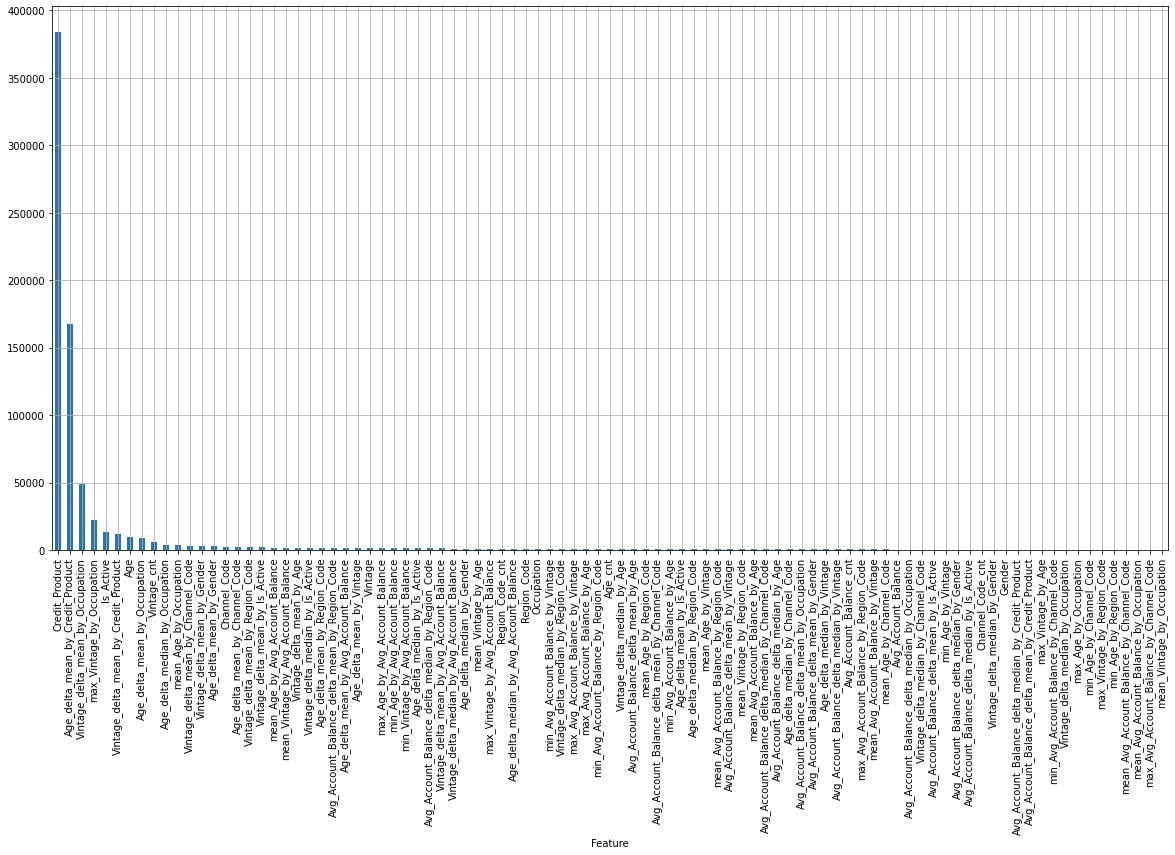

In [34]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

## Step 4. Predict to test data and check scores

In [35]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

[2021-06-01 09:45:09,407] (INFO): Prediction for test data:
array([[0.05088118],
       [0.8605482 ],
       [0.05405717],
       ...,
       [0.06782711],
       [0.21883398],
       [0.05230913]], dtype=float32)
Shape = (105312, 1)
[2021-06-01 09:45:09,408] (INFO): Check scores...
[2021-06-01 09:45:09,479] (INFO): OOF score: 0.875183912970529


CPU times: user 1min 50s, sys: 3.37 s, total: 1min 53s
Wall time: 14.8 s


## Step 5. Save OOF and TEST preds

In [36]:
joblib.dump((oof_pred.data[:, 0], test_pred.data[:, 0], [automl]), 'data_full_model.pkl')

['data_full_model.pkl']

## Step 6. Train model splitted by CreditProduct

In [37]:
def build_model_split_by_group(train_data, test_data, var):
    group = train_data[var[0]].astype(str).agg('_'.join, axis=1)
    test_group = test_data[var[0]].astype(str).agg('_'.join, axis=1)
    
    OOFs = []
    TESTs = []
    Models = []
    for v in var[1]:
        print('GROUP = {}'.format(v))
        tr_data = train_data[group.isin(v)]
        te_data = test_data[test_group.isin(v)]
        print('DATA SHAPE = {}, {}'.format(tr_data.shape, te_data.shape))
        #=====================================================================================
        task = Task('binary', )
        roles = {'target': TARGET_NAME, 'drop': ['ID']}
        automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS}
                      )
        oof_pred = automl.fit_predict(tr_data, roles = roles).data[:, 0]
        test_pred = automl.predict(te_data).data[:, 0]
        logging.info('Check scores...')
        logging.info('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred)))
        #=====================================================================================
        print('=' * 50 + '\n' + '=' * 50)
        OOFs.append(oof_pred)
        TESTs.append(test_pred)
        Models.append(automl)
    
    oof_preds = np.array([0.0] * len(train_data))
    test_preds = np.array([0.0] * len(test_data))
    for it, v in enumerate(var[1]):
        oof_preds[group.isin(v)] = OOFs[it]
        test_preds[test_group.isin(v)] = TESTs[it]
    
    return oof_preds, test_preds, Models

In [38]:
oof_preds_splitted, test_preds_splitted, Models_splitted = build_model_split_by_group(train_data, test_data, [['Credit_Product'], [['Yes'], ['No'], ['nan']]])

GROUP = ['Yes']
DATA SHAPE = (72043, 142), (31182, 142)
Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 64, 'random_state': 42}
Start automl preset with listed constraints:
- time: 3599.998500108719 seconds
- cpus: 64 cores
- memory: 16 gb

Train data shape: (72043, 142)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3578.9613404273987 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7266966208737938
Linear model: C = 5e-05 score = 0.7335116390596919
Linear model: C = 0.0001 score = 0.7348377141368698
Linear model: C = 0.0005 score = 0.737179882717108
Linear model: C = 0.001 score = 0.7377780240376306
Linear model: C = 0.005 score = 0.7383765560302606
Linear model: C = 0.01

[2021-06-01 09:51:41,257] (INFO): A new study created in memory with name: no-name-1e42eec0-a5c9-4e9e-9082-522413c3d302


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742222
[200]	valid's auc: 0.742957
[300]	valid's auc: 0.743367
[400]	valid's auc: 0.742711
Early stopping, best iteration is:
[256]	valid's auc: 0.743676
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:51:50,954] (INFO): Trial 0 finished with value: 0.743675777601576 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.743675777601576.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742548
[200]	valid's auc: 0.742335
[300]	valid's auc: 0.741856
Early stopping, best iteration is:
[122]	valid's auc: 0.742846
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:52:03,842] (INFO): Trial 1 finished with value: 0.742845978883436 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.743675777601576.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.743568
[200]	valid's auc: 0.744563
[300]	valid's auc: 0.743558
Early stopping, best iteration is:
[183]	valid's auc: 0.744862
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:52:25,662] (INFO): Trial 2 finished with value: 0.7448616572025046 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.741507
[200]	valid's auc: 0.740951
Early stopping, best iteration is:
[84]	valid's auc: 0.74191
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:52:42,529] (INFO): Trial 3 finished with value: 0.7419100624588706 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742496
[200]	valid's auc: 0.743542
[300]	valid's auc: 0.743529
[400]	valid's auc: 0.743704
[500]	valid's auc: 0.743125
[600]	valid's auc: 0.742911
Early stopping, best iteration is:
[401]	valid's auc: 0.743727
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:52:48,275] (INFO): Trial 4 finished with value: 0.7437274132921118 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.743019
[200]	valid's auc: 0.7428
[300]	valid's auc: 0.743328
[400]	valid's auc: 0.742188
Early stopping, best iteration is:
[225]	valid's auc: 0.743594
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:53:02,822] (INFO): Trial 5 finished with value: 0.7435938145934472 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742096
[200]	valid's auc: 0.742904
[300]	valid's auc: 0.743168
[400]	valid's auc: 0.743399
[500]	valid's auc: 0.743634
[600]	valid's auc: 0.743199
[700]	valid's auc: 0.74288
Early stopping, best iteration is:
[510]	valid's auc: 0.74366
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:53:09,745] (INFO): Trial 6 finished with value: 0.7436599832863775 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74094
[200]	valid's auc: 0.742027
[300]	valid's auc: 0.741503
[400]	valid's auc: 0.741201
Early stopping, best iteration is:
[202]	valid's auc: 0.742087
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:53:35,611] (INFO): Trial 7 finished with value: 0.7420874387576823 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.743058
[200]	valid's auc: 0.742526
Early stopping, best iteration is:
[90]	valid's auc: 0.743457
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:53:46,111] (INFO): Trial 8 finished with value: 0.7434568896008398 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742702
[200]	valid's auc: 0.742038
[300]	valid's auc: 0.741608
Early stopping, best iteration is:
[108]	valid's auc: 0.743247
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:54:14,262] (INFO): Trial 9 finished with value: 0.7432471768135971 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742735
[200]	valid's auc: 0.743467
[300]	valid's auc: 0.743947
[400]	valid's auc: 0.743809
[500]	valid's auc: 0.743649
Early stopping, best iteration is:
[312]	valid's auc: 0.744078
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:54:26,802] (INFO): Trial 10 finished with value: 0.744078404275444 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 89, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 0.001095687045466094, 'reg_alpha': 7.158478382247568, 'reg_lambda': 1.475649304728376}. Best is trial 2 with value: 0.7448616572025046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.743232
[200]	valid's auc: 0.744372
[300]	valid's auc: 0.744797
[400]	valid's auc: 0.744744
[500]	valid's auc: 0.743888
Early stopping, best iteration is:
[334]	valid's auc: 0.744907
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:54:39,573] (INFO): Trial 11 finished with value: 0.7449067519257567 and parameters: {'feature_fraction': 0.8820928649229942, 'num_leaves': 82, 'bagging_fraction': 0.9961813327301685, 'min_sum_hessian_in_leaf': 0.0010792712965192741, 'reg_alpha': 7.810397236050869, 'reg_lambda': 7.3871412375861425}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742344
[200]	valid's auc: 0.74235
[300]	valid's auc: 0.742384
Early stopping, best iteration is:
[181]	valid's auc: 0.742607
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:54:46,348] (INFO): Trial 12 finished with value: 0.7426074010084878 and parameters: {'feature_fraction': 0.8960543989023443, 'num_leaves': 59, 'bagging_fraction': 0.9983015751307269, 'min_sum_hessian_in_leaf': 0.0011572507524005946, 'reg_alpha': 0.2773945772986779, 'reg_lambda': 0.7694489801607968}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742925
[200]	valid's auc: 0.743668
[300]	valid's auc: 0.743313
[400]	valid's auc: 0.742672
Early stopping, best iteration is:
[268]	valid's auc: 0.743851
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:55:06,072] (INFO): Trial 13 finished with value: 0.7438514126189948 and parameters: {'feature_fraction': 0.9039757416031456, 'num_leaves': 166, 'bagging_fraction': 0.8358873929786039, 'min_sum_hessian_in_leaf': 0.004719001005314561, 'reg_alpha': 8.582011963752445, 'reg_lambda': 7.406156039909503}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74232
[200]	valid's auc: 0.742872
[300]	valid's auc: 0.742448
Early stopping, best iteration is:
[168]	valid's auc: 0.743242
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:55:14,189] (INFO): Trial 14 finished with value: 0.7432420534279602 and parameters: {'feature_fraction': 0.8369519432680195, 'num_leaves': 84, 'bagging_fraction': 0.9968178760098038, 'min_sum_hessian_in_leaf': 0.0036183670032828396, 'reg_alpha': 0.1513416833915054, 'reg_lambda': 0.016053078793989334}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.741871
[200]	valid's auc: 0.742066
[300]	valid's auc: 0.742038
Early stopping, best iteration is:
[123]	valid's auc: 0.742707
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:55:28,674] (INFO): Trial 15 finished with value: 0.7427074242300378 and parameters: {'feature_fraction': 0.9267790923694147, 'num_leaves': 181, 'bagging_fraction': 0.8610531339515688, 'min_sum_hessian_in_leaf': 0.00414318348737108, 'reg_alpha': 0.17183821663032375, 'reg_lambda': 1.3049574174204326e-06}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742225
[200]	valid's auc: 0.742393
[300]	valid's auc: 0.741011
Early stopping, best iteration is:
[181]	valid's auc: 0.742626
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:55:44,588] (INFO): Trial 16 finished with value: 0.742625673301053 and parameters: {'feature_fraction': 0.997521863264518, 'num_leaves': 111, 'bagging_fraction': 0.9488933070220409, 'min_sum_hessian_in_leaf': 7.1644313104393245, 'reg_alpha': 1.5320928573204893, 'reg_lambda': 0.0012620306563011989}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742371
[200]	valid's auc: 0.743783
[300]	valid's auc: 0.744375
[400]	valid's auc: 0.74464
[500]	valid's auc: 0.74469
[600]	valid's auc: 0.744558
Early stopping, best iteration is:
[489]	valid's auc: 0.744865
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:55:56,062] (INFO): Trial 17 finished with value: 0.7448648607137852 and parameters: {'feature_fraction': 0.8478248300112026, 'num_leaves': 47, 'bagging_fraction': 0.7723609967295647, 'min_sum_hessian_in_leaf': 0.016496236258518975, 'reg_alpha': 0.015217581103469546, 'reg_lambda': 0.23850362028873975}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742408
[200]	valid's auc: 0.743633
[300]	valid's auc: 0.743892
[400]	valid's auc: 0.744538
[500]	valid's auc: 0.744583
[600]	valid's auc: 0.744325
Early stopping, best iteration is:
[468]	valid's auc: 0.744716
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:56:04,455] (INFO): Trial 18 finished with value: 0.7447157579134878 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 50, 'bagging_fraction': 0.6539291231879923, 'min_sum_hessian_in_leaf': 0.019548454935130077, 'reg_alpha': 0.008943319752511064, 'reg_lambda': 0.23198912469621805}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742713
[200]	valid's auc: 0.743953
[300]	valid's auc: 0.744175
[400]	valid's auc: 0.743991
Early stopping, best iteration is:
[276]	valid's auc: 0.744461
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:56:12,987] (INFO): Trial 19 finished with value: 0.7444607829720896 and parameters: {'feature_fraction': 0.849107435105255, 'num_leaves': 65, 'bagging_fraction': 0.7759413981560217, 'min_sum_hessian_in_leaf': 0.00889775961135806, 'reg_alpha': 7.756156917704633e-06, 'reg_lambda': 4.899189978076087}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74128
[200]	valid's auc: 0.742507
[300]	valid's auc: 0.742942
[400]	valid's auc: 0.74328
[500]	valid's auc: 0.743547
[600]	valid's auc: 0.743606
[700]	valid's auc: 0.744038
[800]	valid's auc: 0.744045
[900]	valid's auc: 0.744113
[1000]	valid's auc: 0.744226
[1100]	valid's auc: 0.743904
Early stopping, best iteration is:
[974]	valid's auc: 0.74448
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:56:21,944] (INFO): Trial 20 finished with value: 0.7444804951704221 and parameters: {'feature_fraction': 0.7693790413280395, 'num_leaves': 24, 'bagging_fraction': 0.521023764011877, 'min_sum_hessian_in_leaf': 0.03931220701930835, 'reg_alpha': 0.013884671478083139, 'reg_lambda': 0.2886197997712235}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.743502
[200]	valid's auc: 0.74396
[300]	valid's auc: 0.743593
[400]	valid's auc: 0.74336
Early stopping, best iteration is:
[217]	valid's auc: 0.744156
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:56:32,774] (INFO): Trial 21 finished with value: 0.7441558131630069 and parameters: {'feature_fraction': 0.8555413792098965, 'num_leaves': 120, 'bagging_fraction': 0.8798778993776194, 'min_sum_hessian_in_leaf': 0.0020448073062581816, 'reg_alpha': 0.9114364373938447, 'reg_lambda': 0.07030186753204695}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742616
[200]	valid's auc: 0.744213
[300]	valid's auc: 0.744199
[400]	valid's auc: 0.744025
Early stopping, best iteration is:
[282]	valid's auc: 0.744469
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 09:56:42,696] (INFO): Trial 22 finished with value: 0.7444692549757896 and parameters: {'feature_fraction': 0.9431027758259503, 'num_leaves': 81, 'bagging_fraction': 0.9735170132613709, 'min_sum_hessian_in_leaf': 0.0010141026644228392, 'reg_alpha': 8.201471998200523, 'reg_lambda': 0.003163612073574571}. Best is trial 11 with value: 0.7449067519257567.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.742782
[200]	valid's auc: 0.742751
Early stopping, best iteration is:
[126]	valid's auc: 0.743104

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.740405
Early stopping, best iteration is:
[82]	valid's auc: 0.740723

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.744755
[200]	valid's auc: 0.744387
Early stopping, best iteration is:
[169]	valid's auc: 0.745038

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.741455
[200]	valid's auc: 0.741258
Early stopping, best iteration is:

[2021-06-01 09:57:59,600] (INFO): A new study created in memory with name: no-name-203a2715-c4d5-42a5-bc1a-05fe6fd2ca01


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113078	best: 0.7113078 (0)	total: 19.2ms	remaining: 38.5s
100:	test: 0.7408182	best: 0.7408182 (100)	total: 1.62s	remaining: 30.5s
200:	test: 0.7415158	best: 0.7417252 (176)	total: 3.25s	remaining: 29.1s
300:	test: 0.7424787	best: 0.7424787 (300)	total: 4.89s	remaining: 27.6s
400:	test: 0.7423952	best: 0.7427292 (350)	total: 6.52s	remaining: 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7427292461
bestIteration = 350

Shrink model to first 351 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:58:07,649] (INFO): Trial 0 finished with value: 0.74272923489569 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.74272923489569.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134606	best: 0.7134606 (0)	total: 23.4ms	remaining: 46.9s
100:	test: 0.7405535	best: 0.7405912 (99)	total: 2.24s	remaining: 42.2s
200:	test: 0.7405792	best: 0.7407161 (127)	total: 4.64s	remaining: 41.5s
300:	test: 0.7401564	best: 0.7409040 (246)	total: 7.05s	remaining: 39.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7409040148
bestIteration = 246

Shrink model to first 247 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:58:16,470] (INFO): Trial 1 finished with value: 0.7409040259720604 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.74272923489569.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7106875	best: 0.7106875 (0)	total: 16.2ms	remaining: 32.3s
100:	test: 0.7400717	best: 0.7400717 (100)	total: 1.39s	remaining: 26.1s
200:	test: 0.7410674	best: 0.7410973 (182)	total: 2.67s	remaining: 23.9s
300:	test: 0.7420822	best: 0.7420961 (296)	total: 3.97s	remaining: 22.4s
400:	test: 0.7421365	best: 0.7425404 (352)	total: 5.29s	remaining: 21.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7425403728
bestIteration = 352

Shrink model to first 353 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:58:23,137] (INFO): Trial 2 finished with value: 0.7425403728369211 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.74272923489569.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7106875	best: 0.7106875 (0)	total: 17.2ms	remaining: 34.4s
100:	test: 0.7398757	best: 0.7399461 (96)	total: 1.48s	remaining: 27.8s
200:	test: 0.7407321	best: 0.7407940 (198)	total: 3.05s	remaining: 27.3s
300:	test: 0.7413579	best: 0.7413801 (298)	total: 4.71s	remaining: 26.6s
400:	test: 0.7413496	best: 0.7414044 (306)	total: 6.21s	remaining: 24.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7414043765
bestIteration = 306

Shrink model to first 307 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:58:30,153] (INFO): Trial 3 finished with value: 0.741404376483075 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.74272923489569.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113082	best: 0.7113082 (0)	total: 23.2ms	remaining: 46.3s
100:	test: 0.7409713	best: 0.7409758 (87)	total: 1.61s	remaining: 30.3s
200:	test: 0.7419749	best: 0.7419749 (200)	total: 3.18s	remaining: 28.4s
300:	test: 0.7427693	best: 0.7428712 (291)	total: 4.88s	remaining: 27.5s
400:	test: 0.7430938	best: 0.7431340 (398)	total: 6.72s	remaining: 26.8s
500:	test: 0.7431553	best: 0.7432596 (437)	total: 8.59s	remaining: 25.7s
600:	test: 0.7432102	best: 0.7435308 (580)	total: 10.2s	remaining: 23.7s
700:	test: 0.7436402	best: 0.7437317 (694)	total: 11.7s	remaining: 21.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.743731733
bestIteration = 694

Shrink model to first 695 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:58:44,111] (INFO): Trial 4 finished with value: 0.7437317330094132 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113082	best: 0.7113082 (0)	total: 22.7ms	remaining: 45.4s
100:	test: 0.7404010	best: 0.7404010 (100)	total: 1.9s	remaining: 35.8s
200:	test: 0.7411756	best: 0.7411942 (167)	total: 3.94s	remaining: 35.3s
300:	test: 0.7412578	best: 0.7418311 (242)	total: 6s	remaining: 33.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7418310797
bestIteration = 242

Shrink model to first 243 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:58:51,666] (INFO): Trial 5 finished with value: 0.7418310908828784 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091217	best: 0.7091217 (0)	total: 13.4ms	remaining: 26.7s
100:	test: 0.7392725	best: 0.7392836 (96)	total: 1.08s	remaining: 20.3s
200:	test: 0.7404884	best: 0.7404998 (194)	total: 2.01s	remaining: 18s
300:	test: 0.7411477	best: 0.7411477 (300)	total: 3.02s	remaining: 17.1s
400:	test: 0.7418179	best: 0.7418362 (399)	total: 3.95s	remaining: 15.8s
500:	test: 0.7421085	best: 0.7421778 (424)	total: 4.87s	remaining: 14.6s
600:	test: 0.7423168	best: 0.7423944 (541)	total: 5.8s	remaining: 13.5s
700:	test: 0.7422579	best: 0.7424096 (616)	total: 6.72s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7424096205
bestIteration = 616

Shrink model to first 617 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:58:59,235] (INFO): Trial 6 finished with value: 0.7424096204636104 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6972150	best: 0.6972150 (0)	total: 11.2ms	remaining: 22.4s
100:	test: 0.7391340	best: 0.7391525 (99)	total: 1.08s	remaining: 20.3s
200:	test: 0.7401289	best: 0.7401743 (195)	total: 2.18s	remaining: 19.5s
300:	test: 0.7409443	best: 0.7409443 (300)	total: 3.32s	remaining: 18.8s
400:	test: 0.7415800	best: 0.7415816 (395)	total: 4.42s	remaining: 17.6s
500:	test: 0.7419094	best: 0.7419094 (500)	total: 5.47s	remaining: 16.4s
600:	test: 0.7422820	best: 0.7422820 (600)	total: 6.51s	remaining: 15.2s
700:	test: 0.7424075	best: 0.7424332 (694)	total: 7.58s	remaining: 14.1s
800:	test: 0.7425699	best: 0.7426255 (754)	total: 8.68s	remaining: 13s
900:	test: 0.7426281	best: 0.7426732 (888)	total: 9.79s	remaining: 11.9s
1000:	test: 0.7426162	best: 0.7426909 (947)	total: 10.8s	remaining: 10.7s
1100:	test: 0.7428738	best: 0.7428993 (1069)	total: 11.8s	remaining: 9.63s
1200:	tes

[2021-06-01 09:59:13,801] (INFO): Trial 7 finished with value: 0.743072858919283 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113149	best: 0.7113149 (0)	total: 18.7ms	remaining: 37.4s
100:	test: 0.7413176	best: 0.7413529 (96)	total: 1.54s	remaining: 29s
200:	test: 0.7417670	best: 0.7418622 (161)	total: 3.06s	remaining: 27.4s
300:	test: 0.7424051	best: 0.7424051 (300)	total: 4.58s	remaining: 25.8s
400:	test: 0.7425563	best: 0.7427391 (373)	total: 6.2s	remaining: 24.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7427391133
bestIteration = 373

Shrink model to first 374 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:59:21,861] (INFO): Trial 8 finished with value: 0.7427391133189765 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7106875	best: 0.7106875 (0)	total: 15.1ms	remaining: 30.1s
100:	test: 0.7405289	best: 0.7405818 (98)	total: 1.21s	remaining: 22.7s
200:	test: 0.7410047	best: 0.7410254 (198)	total: 2.65s	remaining: 23.7s
300:	test: 0.7416776	best: 0.7417393 (288)	total: 4.22s	remaining: 23.8s
400:	test: 0.7424567	best: 0.7424693 (398)	total: 5.73s	remaining: 22.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7424692817
bestIteration = 398

Shrink model to first 399 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:59:29,830] (INFO): Trial 9 finished with value: 0.742469292837498 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134610	best: 0.7134610 (0)	total: 25.3ms	remaining: 50.6s
100:	test: 0.7412124	best: 0.7412124 (100)	total: 2.01s	remaining: 37.8s
200:	test: 0.7414639	best: 0.7417573 (172)	total: 4.09s	remaining: 36.6s
300:	test: 0.7419755	best: 0.7423306 (270)	total: 6.32s	remaining: 35.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7423305596
bestIteration = 270

Shrink model to first 271 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:59:38,273] (INFO): Trial 10 finished with value: 0.7423305707531966 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.07376089249061034, 'min_data_in_leaf': 6}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6972150	best: 0.6972150 (0)	total: 9.78ms	remaining: 19.6s
100:	test: 0.7387224	best: 0.7387330 (98)	total: 832ms	remaining: 15.6s
200:	test: 0.7398825	best: 0.7398825 (200)	total: 1.79s	remaining: 16.1s
300:	test: 0.7406097	best: 0.7406392 (288)	total: 2.79s	remaining: 15.8s
400:	test: 0.7411507	best: 0.7411634 (398)	total: 3.79s	remaining: 15.1s
500:	test: 0.7414643	best: 0.7414731 (499)	total: 4.79s	remaining: 14.3s
600:	test: 0.7418516	best: 0.7418836 (593)	total: 5.75s	remaining: 13.4s
700:	test: 0.7421310	best: 0.7421372 (695)	total: 6.7s	remaining: 12.4s
800:	test: 0.7422092	best: 0.7422260 (723)	total: 7.71s	remaining: 11.5s
900:	test: 0.7424666	best: 0.7424758 (899)	total: 8.7s	remaining: 10.6s
1000:	test: 0.7428258	best: 0.7428258 (1000)	total: 9.64s	remaining: 9.63s
1100:	test: 0.7426853	best: 0.7428258 (1000)	total: 10.7s	remaining: 8.7s
Stopped b

[2021-06-01 09:59:49,662] (INFO): Trial 11 finished with value: 0.7428257978785744 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.1179121654705828e-06, 'min_data_in_leaf': 6}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6972150	best: 0.6972150 (0)	total: 11.4ms	remaining: 22.8s
100:	test: 0.7385987	best: 0.7385987 (100)	total: 1.1s	remaining: 20.6s
200:	test: 0.7398175	best: 0.7398251 (197)	total: 2.11s	remaining: 18.9s
300:	test: 0.7403742	best: 0.7403917 (272)	total: 3.11s	remaining: 17.5s
400:	test: 0.7407431	best: 0.7407506 (399)	total: 4.13s	remaining: 16.5s
500:	test: 0.7408357	best: 0.7409238 (449)	total: 5.12s	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7409238498
bestIteration = 449

Shrink model to first 450 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 09:59:55,932] (INFO): Trial 12 finished with value: 0.7409238609530551 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.04850872282395855, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091217	best: 0.7091217 (0)	total: 15.4ms	remaining: 30.7s
100:	test: 0.7391486	best: 0.7391486 (100)	total: 1.09s	remaining: 20.5s
200:	test: 0.7400944	best: 0.7401663 (182)	total: 2.08s	remaining: 18.6s
300:	test: 0.7408091	best: 0.7408979 (291)	total: 3.1s	remaining: 17.5s
400:	test: 0.7413618	best: 0.7413618 (400)	total: 4.13s	remaining: 16.5s
500:	test: 0.7413226	best: 0.7415691 (467)	total: 5.14s	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7415691173
bestIteration = 467

Shrink model to first 468 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:00:02,447] (INFO): Trial 13 finished with value: 0.7415691508159088 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.9108126641738325e-06, 'min_data_in_leaf': 7}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091217	best: 0.7091217 (0)	total: 13.2ms	remaining: 26.4s
100:	test: 0.7391305	best: 0.7391305 (100)	total: 1.11s	remaining: 20.9s
200:	test: 0.7403942	best: 0.7404116 (199)	total: 2.2s	remaining: 19.7s
300:	test: 0.7409652	best: 0.7409652 (300)	total: 3.29s	remaining: 18.6s
400:	test: 0.7413959	best: 0.7414558 (395)	total: 4.33s	remaining: 17.3s
500:	test: 0.7410503	best: 0.7415167 (436)	total: 5.3s	remaining: 15.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7415167115
bestIteration = 436

Shrink model to first 437 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:00:08,909] (INFO): Trial 14 finished with value: 0.7415167002949775 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6985723924523444e-08, 'min_data_in_leaf': 9}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113082	best: 0.7113082 (0)	total: 22.5ms	remaining: 45s
100:	test: 0.7404156	best: 0.7404247 (98)	total: 1.78s	remaining: 33.4s
200:	test: 0.7408119	best: 0.7409541 (109)	total: 3.6s	remaining: 32.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7409541436
bestIteration = 109

Shrink model to first 110 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:00:13,354] (INFO): Trial 15 finished with value: 0.7409541212982869 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.4415400729739797e-05, 'min_data_in_leaf': 16}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134612	best: 0.7134612 (0)	total: 24.3ms	remaining: 48.6s
100:	test: 0.7410467	best: 0.7412180 (95)	total: 2.2s	remaining: 41.4s
200:	test: 0.7413997	best: 0.7414938 (178)	total: 4.63s	remaining: 41.4s
300:	test: 0.7410432	best: 0.7418358 (220)	total: 6.95s	remaining: 39.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7418357678
bestIteration = 220

Shrink model to first 221 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:00:21,465] (INFO): Trial 16 finished with value: 0.7418357677861067 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.015237359911708626, 'min_data_in_leaf': 3}. Best is trial 4 with value: 0.7437317330094132.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6972150	best: 0.6972150 (0)	total: 12.5ms	remaining: 25s
100:	test: 0.7385683	best: 0.7385921 (99)	total: 1.01s	remaining: 19s
200:	test: 0.7394359	best: 0.7394359 (200)	total: 1.94s	remaining: 17.3s
300:	test: 0.7402232	best: 0.7402232 (300)	total: 2.86s	remaining: 16.1s
400:	test: 0.7407758	best: 0.7407883 (399)	total: 3.71s	remaining: 14.8s
500:	test: 0.7413928	best: 0.7413929 (480)	total: 4.53s	remaining: 13.6s
600:	test: 0.7417919	best: 0.7417939 (598)	total: 5.36s	remaining: 12.5s
700:	test: 0.7421086	best: 0.7421086 (700)	total: 6.19s	remaining: 11.5s
800:	test: 0.7425783	best: 0.7425820 (771)	total: 7.07s	remaining: 10.6s
900:	test: 0.7427265	best: 0.7427341 (892)	total: 7.92s	remaining: 9.66s
1000:	test: 0.7428837	best: 0.7429154 (997)	total: 8.75s	remaining: 8.73s
1100:	test: 0.7430024	best: 0.7430055 (1098)	total: 9.57s	remaining: 7.82s
1200:	test:

[2021-06-01 10:00:37,798] (INFO): Trial 17 finished with value: 0.7437916286245051 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.33838882364830586, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091217	best: 0.7091217 (0)	total: 14.3ms	remaining: 28.7s
100:	test: 0.7398724	best: 0.7398724 (100)	total: 1.07s	remaining: 20.2s
200:	test: 0.7407502	best: 0.7408046 (192)	total: 2.25s	remaining: 20.1s
300:	test: 0.7415614	best: 0.7415979 (297)	total: 3.33s	remaining: 18.8s
400:	test: 0.7419651	best: 0.7419651 (400)	total: 4.51s	remaining: 18s
500:	test: 0.7424201	best: 0.7424786 (486)	total: 5.8s	remaining: 17.3s
600:	test: 0.7426425	best: 0.7426610 (596)	total: 7.04s	remaining: 16.4s
700:	test: 0.7426757	best: 0.7428091 (674)	total: 8.3s	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7428091106
bestIteration = 674

Shrink model to first 675 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:00:47,742] (INFO): Trial 18 finished with value: 0.7428091329226796 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.6465646391079517, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113082	best: 0.7113082 (0)	total: 18.8ms	remaining: 37.6s
100:	test: 0.7407080	best: 0.7407080 (100)	total: 1.74s	remaining: 32.8s
200:	test: 0.7415020	best: 0.7415020 (200)	total: 3.58s	remaining: 32.1s
300:	test: 0.7421231	best: 0.7421869 (293)	total: 5.37s	remaining: 30.3s
400:	test: 0.7424143	best: 0.7426121 (352)	total: 7.23s	remaining: 28.8s
500:	test: 0.7429039	best: 0.7429039 (500)	total: 9.05s	remaining: 27.1s
600:	test: 0.7431719	best: 0.7431737 (598)	total: 10.7s	remaining: 24.9s
700:	test: 0.7431514	best: 0.7432538 (611)	total: 12.6s	remaining: 23.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7432538182
bestIteration = 611

Shrink model to first 612 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:01:01,254] (INFO): Trial 19 finished with value: 0.7432538182394226 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.5344981378158423, 'min_data_in_leaf': 14}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7106875	best: 0.7106875 (0)	total: 17.2ms	remaining: 34.4s
100:	test: 0.7403011	best: 0.7403047 (99)	total: 1.32s	remaining: 24.8s
200:	test: 0.7414124	best: 0.7414296 (188)	total: 2.77s	remaining: 24.8s
300:	test: 0.7419849	best: 0.7420069 (299)	total: 4.29s	remaining: 24.2s
400:	test: 0.7422548	best: 0.7422755 (396)	total: 5.81s	remaining: 23.2s
500:	test: 0.7426791	best: 0.7426971 (499)	total: 7.35s	remaining: 22s
600:	test: 0.7428158	best: 0.7429083 (584)	total: 9.04s	remaining: 21s
700:	test: 0.7427994	best: 0.7429122 (674)	total: 10.6s	remaining: 19.7s
800:	test: 0.7428290	best: 0.7429695 (748)	total: 12.2s	remaining: 18.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7429694759
bestIteration = 748

Shrink model to first 749 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:01:14,939] (INFO): Trial 20 finished with value: 0.7429694424314288 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.6790200643868756, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113082	best: 0.7113082 (0)	total: 20.2ms	remaining: 40.3s
100:	test: 0.7408986	best: 0.7408986 (100)	total: 1.6s	remaining: 30.1s
200:	test: 0.7418709	best: 0.7419967 (196)	total: 3.17s	remaining: 28.4s
300:	test: 0.7426219	best: 0.7426896 (298)	total: 5.05s	remaining: 28.5s
400:	test: 0.7433249	best: 0.7433533 (398)	total: 6.97s	remaining: 27.8s
500:	test: 0.7434490	best: 0.7435036 (495)	total: 8.6s	remaining: 25.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7435035582
bestIteration = 495

Shrink model to first 496 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:01:25,870] (INFO): Trial 21 finished with value: 0.7435035581745816 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.147258887130623, 'min_data_in_leaf': 14}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113061	best: 0.7113061 (0)	total: 20.4ms	remaining: 40.8s
100:	test: 0.7405526	best: 0.7405780 (96)	total: 1.97s	remaining: 37.1s
200:	test: 0.7412492	best: 0.7413211 (183)	total: 4.01s	remaining: 35.9s
300:	test: 0.7418176	best: 0.7419234 (268)	total: 6.1s	remaining: 34.4s
400:	test: 0.7419354	best: 0.7421523 (362)	total: 7.99s	remaining: 31.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7421522792
bestIteration = 362

Shrink model to first 363 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:01:35,797] (INFO): Trial 22 finished with value: 0.7421522791654476 and parameters: {'max_depth': 6, 'l2_leaf_reg': 8.087561548044848, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134610	best: 0.7134610 (0)	total: 24.6ms	remaining: 49.2s
100:	test: 0.7415173	best: 0.7416159 (92)	total: 2.08s	remaining: 39.1s
200:	test: 0.7421087	best: 0.7421146 (187)	total: 4.21s	remaining: 37.6s
300:	test: 0.7428492	best: 0.7430121 (277)	total: 6.27s	remaining: 35.4s
400:	test: 0.7428745	best: 0.7435990 (366)	total: 8.49s	remaining: 33.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7435990273
bestIteration = 366

Shrink model to first 367 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:01:46,404] (INFO): Trial 23 finished with value: 0.7435990272755657 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.14945416867833475, 'min_data_in_leaf': 14}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134610	best: 0.7134610 (0)	total: 22.1ms	remaining: 44.3s
100:	test: 0.7411458	best: 0.7413842 (91)	total: 2.06s	remaining: 38.8s
200:	test: 0.7411412	best: 0.7415326 (144)	total: 4.42s	remaining: 39.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7415325839
bestIteration = 144

Shrink model to first 145 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:01:52,521] (INFO): Trial 24 finished with value: 0.7415326173928383 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.09363477245729031, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134610	best: 0.7134610 (0)	total: 25.5ms	remaining: 50.9s
100:	test: 0.7406956	best: 0.7408118 (92)	total: 2.41s	remaining: 45.4s
200:	test: 0.7412710	best: 0.7413399 (128)	total: 4.53s	remaining: 40.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7413399267
bestIteration = 128

Shrink model to first 129 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:01:58,375] (INFO): Trial 25 finished with value: 0.7413399602335977 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.006489672025177757, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134610	best: 0.7134610 (0)	total: 24.7ms	remaining: 49.4s
100:	test: 0.7415184	best: 0.7416175 (92)	total: 2.23s	remaining: 42s
200:	test: 0.7421078	best: 0.7421139 (187)	total: 4.32s	remaining: 38.7s
300:	test: 0.7428449	best: 0.7430077 (277)	total: 6.4s	remaining: 36.1s
400:	test: 0.7429821	best: 0.7437459 (366)	total: 8.75s	remaining: 34.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7437458753
bestIteration = 366

Shrink model to first 367 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:02:09,449] (INFO): Trial 26 finished with value: 0.7437458865017608 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.14509352982240228, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134621	best: 0.7134621 (0)	total: 25.2ms	remaining: 50.5s
100:	test: 0.7408237	best: 0.7408237 (100)	total: 2.13s	remaining: 40.2s
200:	test: 0.7416816	best: 0.7416816 (200)	total: 4.17s	remaining: 37.3s
300:	test: 0.7425839	best: 0.7427289 (280)	total: 6.18s	remaining: 34.9s
400:	test: 0.7434929	best: 0.7435014 (398)	total: 8.18s	remaining: 32.6s
500:	test: 0.7431666	best: 0.7436415 (422)	total: 10.2s	remaining: 30.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7436414543
bestIteration = 422

Shrink model to first 423 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:02:20,821] (INFO): Trial 27 finished with value: 0.7436414431043672 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.118778409883786, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113082	best: 0.7113082 (0)	total: 20.8ms	remaining: 41.6s
100:	test: 0.7408030	best: 0.7409049 (92)	total: 1.74s	remaining: 32.8s
200:	test: 0.7416421	best: 0.7416421 (200)	total: 3.51s	remaining: 31.5s
300:	test: 0.7409719	best: 0.7418495 (215)	total: 5.39s	remaining: 30.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7418494636
bestIteration = 215

Shrink model to first 216 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:02:27,203] (INFO): Trial 28 finished with value: 0.7418494636339855 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0030656460603452995, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7113057	best: 0.7113057 (0)	total: 21.9ms	remaining: 43.8s
100:	test: 0.7408580	best: 0.7409086 (97)	total: 1.87s	remaining: 35.2s
200:	test: 0.7409845	best: 0.7411458 (153)	total: 3.62s	remaining: 32.4s
300:	test: 0.7415604	best: 0.7416239 (267)	total: 5.22s	remaining: 29.4s
400:	test: 0.7421734	best: 0.7422653 (389)	total: 6.79s	remaining: 27.1s
500:	test: 0.7424407	best: 0.7424407 (500)	total: 8.36s	remaining: 25s
600:	test: 0.7428268	best: 0.7429155 (592)	total: 9.97s	remaining: 23.2s
700:	test: 0.7424810	best: 0.7429368 (611)	total: 11.6s	remaining: 21.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7429367934
bestIteration = 611

Shrink model to first 612 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:02:39,668] (INFO): Trial 29 finished with value: 0.7429367934053119 and parameters: {'max_depth': 6, 'l2_leaf_reg': 8.895648671687853, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7106875	best: 0.7106875 (0)	total: 16.8ms	remaining: 33.5s
100:	test: 0.7406694	best: 0.7406745 (99)	total: 1.39s	remaining: 26.1s
200:	test: 0.7416984	best: 0.7416984 (200)	total: 2.9s	remaining: 25.9s
300:	test: 0.7420512	best: 0.7420512 (300)	total: 4.45s	remaining: 25.1s
400:	test: 0.7422633	best: 0.7423314 (350)	total: 6.14s	remaining: 24.5s
500:	test: 0.7426001	best: 0.7426519 (499)	total: 7.87s	remaining: 23.5s
600:	test: 0.7430244	best: 0.7430338 (599)	total: 9.53s	remaining: 22.2s
700:	test: 0.7431949	best: 0.7432032 (696)	total: 11.2s	remaining: 20.7s
800:	test: 0.7433047	best: 0.7434799 (775)	total: 12.8s	remaining: 19.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7434798723
bestIteration = 775

Shrink model to first 776 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:02:54,472] (INFO): Trial 30 finished with value: 0.7434799057689947 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.21758055084197606, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7134629	best: 0.7134629 (0)	total: 23.2ms	remaining: 46.4s
100:	test: 0.7409897	best: 0.7409897 (100)	total: 2.27s	remaining: 42.6s
200:	test: 0.7414849	best: 0.7415259 (190)	total: 4.52s	remaining: 40.5s
300:	test: 0.7418696	best: 0.7420468 (279)	total: 6.69s	remaining: 37.8s
400:	test: 0.7424270	best: 0.7426028 (392)	total: 8.83s	remaining: 35.2s
500:	test: 0.7424046	best: 0.7427180 (466)	total: 11s	remaining: 32.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7427180282
bestIteration = 466

Shrink model to first 467 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:03:07,654] (INFO): Trial 31 finished with value: 0.7427180281872382 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.3462104603136633, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.7437916286245051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6972150	best: 0.6972150 (0)	total: 11.9ms	remaining: 35.7s
100:	test: 0.7378828	best: 0.7378828 (100)	total: 964ms	remaining: 27.7s
200:	test: 0.7387975	best: 0.7388035 (192)	total: 2.01s	remaining: 28.1s
300:	test: 0.7395365	best: 0.7395467 (299)	total: 3.08s	remaining: 27.6s
400:	test: 0.7400373	best: 0.7400373 (400)	total: 4.01s	remaining: 26s
500:	test: 0.7406276	best: 0.7406276 (500)	total: 5.06s	remaining: 25.3s
600:	test: 0.7409795	best: 0.7409795 (600)	total: 6.11s	remaining: 24.4s
700:	test: 0.7412570	best: 0.7412666 (690)	total: 7.09s	remaining: 23.3s
800:	test: 0.7414620	best: 0.7414620 (800)	total: 8.18s	remaining: 22.5s
900:	test: 0.7416112	best: 0.7416160 (899)	total: 9.18s	remaining: 21.4s
1000:	test: 0.7417853	best: 0.7418352 (995)	total: 10.2s	remaining: 20.4s
1100:	test: 0.7418969	best: 0.7418969 (1100)	total: 11.3s	remaining: 19.4s
1200:	te

[2021-06-01 10:06:24,550] (INFO): A new study created in memory with name: no-name-d3955e2f-de98-4ab2-b56c-571d338b833c


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740221
[200]	valid's auc: 0.739671
[300]	valid's auc: 0.739789
Early stopping, best iteration is:
[117]	valid's auc: 0.740489
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:06:32,131] (INFO): Trial 0 finished with value: 0.740489333111104 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.740489333111104.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740614
[200]	valid's auc: 0.740866
[300]	valid's auc: 0.741436
[400]	valid's auc: 0.740858
Early stopping, best iteration is:
[290]	valid's auc: 0.74161
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:06:54,037] (INFO): Trial 1 finished with value: 0.7416097472288958 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.7416097472288958.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739403
[200]	valid's auc: 0.740206
[300]	valid's auc: 0.739951
[400]	valid's auc: 0.738649
Early stopping, best iteration is:
[226]	valid's auc: 0.74033
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:07:20,395] (INFO): Trial 2 finished with value: 0.7403300170257135 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 1 with value: 0.7416097472288958.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737891
[200]	valid's auc: 0.735818
Early stopping, best iteration is:
[77]	valid's auc: 0.738156
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:07:36,003] (INFO): Trial 3 finished with value: 0.7381561946375766 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 1 with value: 0.7416097472288958.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739455
[200]	valid's auc: 0.740684
[300]	valid's auc: 0.741065
[400]	valid's auc: 0.740752
Early stopping, best iteration is:
[288]	valid's auc: 0.741259
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:07:40,110] (INFO): Trial 4 finished with value: 0.7412592920244535 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 1 with value: 0.7416097472288958.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.741359
[200]	valid's auc: 0.741767
[300]	valid's auc: 0.740809
Early stopping, best iteration is:
[169]	valid's auc: 0.742231
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:07:52,450] (INFO): Trial 5 finished with value: 0.7422312507414398 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 5 with value: 0.7422312507414398.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739986
[200]	valid's auc: 0.740846
[300]	valid's auc: 0.74174
[400]	valid's auc: 0.741695
[500]	valid's auc: 0.741857
[600]	valid's auc: 0.741742
Early stopping, best iteration is:
[493]	valid's auc: 0.742004
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:07:58,376] (INFO): Trial 6 finished with value: 0.7420035223890167 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 5 with value: 0.7422312507414398.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739207
[200]	valid's auc: 0.739956
[300]	valid's auc: 0.739197
Early stopping, best iteration is:
[198]	valid's auc: 0.740055
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:08:16,917] (INFO): Trial 7 finished with value: 0.740055430344525 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 5 with value: 0.7422312507414398.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738834
[200]	valid's auc: 0.739532
[300]	valid's auc: 0.739001
[400]	valid's auc: 0.737897
Early stopping, best iteration is:
[206]	valid's auc: 0.739691
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:08:27,262] (INFO): Trial 8 finished with value: 0.7396909221062772 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 5 with value: 0.7422312507414398.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738469
[200]	valid's auc: 0.739296
[300]	valid's auc: 0.737823
Early stopping, best iteration is:
[187]	valid's auc: 0.73944
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:08:46,042] (INFO): Trial 9 finished with value: 0.739439965506555 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 5 with value: 0.7422312507414398.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740224
[200]	valid's auc: 0.741802
[300]	valid's auc: 0.740902
Early stopping, best iteration is:
[198]	valid's auc: 0.741901
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:08:56,685] (INFO): Trial 10 finished with value: 0.7419005747076913 and parameters: {'feature_fraction': 0.8472983349355854, 'num_leaves': 142, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 0.003752814322725355, 'reg_alpha': 2.1645631328906495e-05, 'reg_lambda': 1.210011886500966e-06}. Best is trial 5 with value: 0.7422312507414398.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739972
[200]	valid's auc: 0.741369
[300]	valid's auc: 0.742036
[400]	valid's auc: 0.742111
[500]	valid's auc: 0.742494
[600]	valid's auc: 0.743015
[700]	valid's auc: 0.743145
[800]	valid's auc: 0.743192
Early stopping, best iteration is:
[671]	valid's auc: 0.743394
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:09:01,545] (INFO): Trial 11 finished with value: 0.7433937235021062 and parameters: {'feature_fraction': 0.8690955766720535, 'num_leaves': 17, 'bagging_fraction': 0.8904832712072952, 'min_sum_hessian_in_leaf': 0.012940869124229216, 'reg_alpha': 3.579553426272947e-08, 'reg_lambda': 3.135979526057125}. Best is trial 11 with value: 0.7433937235021062.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740456
[200]	valid's auc: 0.741174
[300]	valid's auc: 0.741743
[400]	valid's auc: 0.741625
[500]	valid's auc: 0.740458
Early stopping, best iteration is:
[367]	valid's auc: 0.741883
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:09:13,367] (INFO): Trial 12 finished with value: 0.7418834409452675 and parameters: {'feature_fraction': 0.8617218605185976, 'num_leaves': 87, 'bagging_fraction': 0.9983015751307269, 'min_sum_hessian_in_leaf': 0.007300358083644766, 'reg_alpha': 1.42323092847081e-08, 'reg_lambda': 0.8212988225852077}. Best is trial 11 with value: 0.7433937235021062.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.741094
[200]	valid's auc: 0.74171
[300]	valid's auc: 0.740671
Early stopping, best iteration is:
[137]	valid's auc: 0.741818
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:09:27,989] (INFO): Trial 13 finished with value: 0.7418181428930337 and parameters: {'feature_fraction': 0.89877464500448, 'num_leaves': 180, 'bagging_fraction': 0.8444465254186173, 'min_sum_hessian_in_leaf': 0.5637706306508686, 'reg_alpha': 0.15613848742694247, 'reg_lambda': 6.49563790563595}. Best is trial 11 with value: 0.7433937235021062.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740507
[200]	valid's auc: 0.74171
[300]	valid's auc: 0.741853
[400]	valid's auc: 0.74116
Early stopping, best iteration is:
[259]	valid's auc: 0.741901
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:09:36,443] (INFO): Trial 14 finished with value: 0.7419008314350761 and parameters: {'feature_fraction': 0.7743155451921487, 'num_leaves': 74, 'bagging_fraction': 0.8985201029858344, 'min_sum_hessian_in_leaf': 9.24601720289609, 'reg_alpha': 2.2622145366119967e-05, 'reg_lambda': 0.4560542312980413}. Best is trial 11 with value: 0.7433937235021062.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740877
[200]	valid's auc: 0.741832
[300]	valid's auc: 0.741069
[400]	valid's auc: 0.740966
Early stopping, best iteration is:
[210]	valid's auc: 0.741885
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:09:51,503] (INFO): Trial 15 finished with value: 0.7418851487404798 and parameters: {'feature_fraction': 0.6522186852799047, 'num_leaves': 176, 'bagging_fraction': 0.988939518850625, 'min_sum_hessian_in_leaf': 0.0016701007972215283, 'reg_alpha': 1.3684725208253198e-06, 'reg_lambda': 3.7909642769354863e-06}. Best is trial 11 with value: 0.7433937235021062.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740984
[200]	valid's auc: 0.742241
[300]	valid's auc: 0.74247
[400]	valid's auc: 0.742378
[500]	valid's auc: 0.742476
[600]	valid's auc: 0.741995
Early stopping, best iteration is:
[470]	valid's auc: 0.74273
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:10:01,429] (INFO): Trial 16 finished with value: 0.7427299381054832 and parameters: {'feature_fraction': 0.9118153481603198, 'num_leaves': 58, 'bagging_fraction': 0.8053760955945778, 'min_sum_hessian_in_leaf': 0.03849226126679356, 'reg_alpha': 1.2418496866706978e-08, 'reg_lambda': 4.173888419402175}. Best is trial 11 with value: 0.7433937235021062.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.741582
[200]	valid's auc: 0.742843
[300]	valid's auc: 0.742787
[400]	valid's auc: 0.743112
[500]	valid's auc: 0.742988
[600]	valid's auc: 0.742715
Early stopping, best iteration is:
[425]	valid's auc: 0.74321
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:10:10,466] (INFO): Trial 17 finished with value: 0.7432100294772152 and parameters: {'feature_fraction': 0.9230001815370723, 'num_leaves': 54, 'bagging_fraction': 0.7852811204640975, 'min_sum_hessian_in_leaf': 0.024707445369452127, 'reg_alpha': 1.000078131634638e-08, 'reg_lambda': 8.521713769759241}. Best is trial 11 with value: 0.7433937235021062.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739697
[200]	valid's auc: 0.740892
[300]	valid's auc: 0.74124
[400]	valid's auc: 0.741377
[500]	valid's auc: 0.741569
[600]	valid's auc: 0.741775
[700]	valid's auc: 0.741949
[800]	valid's auc: 0.742164
[900]	valid's auc: 0.74215
Early stopping, best iteration is:
[781]	valid's auc: 0.742417
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:10:16,074] (INFO): Trial 18 finished with value: 0.7424167083718441 and parameters: {'feature_fraction': 0.923567206751885, 'num_leaves': 17, 'bagging_fraction': 0.6539291231879923, 'min_sum_hessian_in_leaf': 0.014245789429002587, 'reg_alpha': 5.332739328273541e-08, 'reg_lambda': 0.21180848321588108}. Best is trial 11 with value: 0.7433937235021062.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.741275
[200]	valid's auc: 0.742991
[300]	valid's auc: 0.743333
[400]	valid's auc: 0.743226
[500]	valid's auc: 0.743171
Early stopping, best iteration is:
[315]	valid's auc: 0.743528
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:10:22,690] (INFO): Trial 19 finished with value: 0.7435276793866975 and parameters: {'feature_fraction': 0.8638786209418334, 'num_leaves': 48, 'bagging_fraction': 0.771761965592801, 'min_sum_hessian_in_leaf': 0.002843489691081784, 'reg_alpha': 2.8436341307369556e-06, 'reg_lambda': 4.899189978076087}. Best is trial 19 with value: 0.7435276793866975.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739407
[200]	valid's auc: 0.740386
[300]	valid's auc: 0.740716
[400]	valid's auc: 0.739981
[500]	valid's auc: 0.739443
Early stopping, best iteration is:
[346]	valid's auc: 0.740943
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:10:35,469] (INFO): Trial 20 finished with value: 0.7409433722343037 and parameters: {'feature_fraction': 0.8362579612351208, 'num_leaves': 106, 'bagging_fraction': 0.6780266046026409, 'min_sum_hessian_in_leaf': 0.0021120104634734078, 'reg_alpha': 3.6698653396361217e-06, 'reg_lambda': 0.06579887631155501}. Best is trial 19 with value: 0.7435276793866975.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.741294
[200]	valid's auc: 0.742461
[300]	valid's auc: 0.742753
[400]	valid's auc: 0.743184
[500]	valid's auc: 0.742824
[600]	valid's auc: 0.742944
Early stopping, best iteration is:
[405]	valid's auc: 0.743248
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:10:42,995] (INFO): Trial 21 finished with value: 0.7432476232960055 and parameters: {'feature_fraction': 0.9212439815621295, 'num_leaves': 48, 'bagging_fraction': 0.7762577466273467, 'min_sum_hessian_in_leaf': 0.00574641947581884, 'reg_alpha': 1.1243778182968694e-08, 'reg_lambda': 3.775701078267658}. Best is trial 19 with value: 0.7435276793866975.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740766
[200]	valid's auc: 0.742539
[300]	valid's auc: 0.743384
[400]	valid's auc: 0.743637
[500]	valid's auc: 0.743918
[600]	valid's auc: 0.74378
Early stopping, best iteration is:
[483]	valid's auc: 0.744222
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:10:51,605] (INFO): Trial 22 finished with value: 0.7442222497453823 and parameters: {'feature_fraction': 0.8737391364081963, 'num_leaves': 49, 'bagging_fraction': 0.8599246452587492, 'min_sum_hessian_in_leaf': 0.005533029859344202, 'reg_alpha': 1.883676856409978e-07, 'reg_lambda': 1.728115087360936}. Best is trial 22 with value: 0.7442222497453823.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740222
[200]	valid's auc: 0.741564
[300]	valid's auc: 0.742265
[400]	valid's auc: 0.743054
[500]	valid's auc: 0.743092
[600]	valid's auc: 0.742891
Early stopping, best iteration is:
[459]	valid's auc: 0.743154
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:10:56,057] (INFO): Trial 23 finished with value: 0.7431543084726422 and parameters: {'feature_fraction': 0.8778012677886213, 'num_leaves': 19, 'bagging_fraction': 0.8423093119547929, 'min_sum_hessian_in_leaf': 0.00105388809290867, 'reg_alpha': 1.5367175969401512e-07, 'reg_lambda': 1.0585539135501372}. Best is trial 22 with value: 0.7442222497453823.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.740549
[200]	valid's auc: 0.741518
[300]	valid's auc: 0.742031
[400]	valid's auc: 0.741967
[500]	valid's auc: 0.741855
Early stopping, best iteration is:
[354]	valid's auc: 0.74221
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:11:02,266] (INFO): Trial 24 finished with value: 0.7422098753961359 and parameters: {'feature_fraction': 0.7405400350369375, 'num_leaves': 42, 'bagging_fraction': 0.8851905394307332, 'min_sum_hessian_in_leaf': 0.003033136187007317, 'reg_alpha': 3.2366775225183637e-06, 'reg_lambda': 0.0030136991705059448}. Best is trial 22 with value: 0.7442222497453823.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74082
[200]	valid's auc: 0.742899
[300]	valid's auc: 0.743182
[400]	valid's auc: 0.743364
[500]	valid's auc: 0.743727
[600]	valid's auc: 0.743395
[700]	valid's auc: 0.742572
Early stopping, best iteration is:
[515]	valid's auc: 0.743879
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:11:15,476] (INFO): Trial 25 finished with value: 0.7438786257217891 and parameters: {'feature_fraction': 0.8173155644483446, 'num_leaves': 76, 'bagging_fraction': 0.8652578390779853, 'min_sum_hessian_in_leaf': 0.00919905407063568, 'reg_alpha': 3.854293359361945e-06, 'reg_lambda': 0.22115343144302366}. Best is trial 22 with value: 0.7442222497453823.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739719
[200]	valid's auc: 0.741017
[300]	valid's auc: 0.740604
Early stopping, best iteration is:
[196]	valid's auc: 0.741144
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:11:23,415] (INFO): Trial 26 finished with value: 0.7411441776974983 and parameters: {'feature_fraction': 0.8184489288862757, 'num_leaves': 84, 'bagging_fraction': 0.7607011304111607, 'min_sum_hessian_in_leaf': 0.007354723800700688, 'reg_alpha': 8.717702249459767e-06, 'reg_lambda': 0.17241340929175047}. Best is trial 22 with value: 0.7442222497453823.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74023
[200]	valid's auc: 0.741809
[300]	valid's auc: 0.740596
Early stopping, best iteration is:
[170]	valid's auc: 0.741853
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:11:33,121] (INFO): Trial 27 finished with value: 0.7418528122520488 and parameters: {'feature_fraction': 0.7758669242190788, 'num_leaves': 115, 'bagging_fraction': 0.8367535043275174, 'min_sum_hessian_in_leaf': 0.048919225210639586, 'reg_alpha': 0.00022262508854049682, 'reg_lambda': 0.010225501078910343}. Best is trial 22 with value: 0.7442222497453823.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.740896
[200]	valid's auc: 0.741658
Early stopping, best iteration is:
[186]	valid's auc: 0.741948

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.746051
[200]	valid's auc: 0.746107
[300]	valid's auc: 0.747131
Early stopping, best iteration is:
[274]	valid's auc: 0.747485

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.743039
Early stopping, best iteration is:
[99]	valid's auc: 0.74314

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.743698
[200]	valid's auc: 0.744326
[300]	v

[2021-06-01 10:12:33,718] (INFO): A new study created in memory with name: no-name-a72d315f-db4d-492d-aeef-2268fc630b50


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7175983	best: 0.7175983 (0)	total: 19.6ms	remaining: 39.3s
100:	test: 0.7387892	best: 0.7387914 (99)	total: 1.85s	remaining: 34.8s
200:	test: 0.7407012	best: 0.7407085 (199)	total: 3.7s	remaining: 33.1s
300:	test: 0.7411368	best: 0.7411439 (299)	total: 5.53s	remaining: 31.2s
400:	test: 0.7413500	best: 0.7415123 (390)	total: 7.24s	remaining: 28.9s
500:	test: 0.7417964	best: 0.7418686 (493)	total: 8.9s	remaining: 26.6s
600:	test: 0.7416046	best: 0.7418761 (535)	total: 10.6s	remaining: 24.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7418760517
bestIteration = 535

Shrink model to first 536 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:12:45,665] (INFO): Trial 0 finished with value: 0.7418760404993477 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.7418760404993477.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7194334	best: 0.7194334 (0)	total: 21.4ms	remaining: 42.8s
100:	test: 0.7404769	best: 0.7406091 (98)	total: 1.92s	remaining: 36.2s
200:	test: 0.7402799	best: 0.7407196 (112)	total: 3.85s	remaining: 34.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7407196287
bestIteration = 112

Shrink model to first 113 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:12:50,368] (INFO): Trial 1 finished with value: 0.740719628737376 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7418760404993477.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7101121	best: 0.7101121 (0)	total: 13.6ms	remaining: 27.2s
100:	test: 0.7375530	best: 0.7379703 (93)	total: 1.35s	remaining: 25.3s
200:	test: 0.7392148	best: 0.7392313 (185)	total: 2.77s	remaining: 24.8s
300:	test: 0.7399592	best: 0.7403548 (291)	total: 4.19s	remaining: 23.7s
400:	test: 0.7398956	best: 0.7403927 (338)	total: 5.62s	remaining: 22.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7403927366
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:12:57,171] (INFO): Trial 2 finished with value: 0.7403927366420389 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7418760404993477.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7101121	best: 0.7101121 (0)	total: 15.2ms	remaining: 30.5s
100:	test: 0.7383438	best: 0.7383845 (97)	total: 1.33s	remaining: 25s
200:	test: 0.7401665	best: 0.7401665 (200)	total: 2.74s	remaining: 24.6s
300:	test: 0.7407003	best: 0.7408841 (299)	total: 4.24s	remaining: 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7408841352
bestIteration = 299

Shrink model to first 300 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:13:03,425] (INFO): Trial 3 finished with value: 0.7408841463428246 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7418760404993477.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7175983	best: 0.7175983 (0)	total: 19.9ms	remaining: 39.9s
100:	test: 0.7387155	best: 0.7387166 (98)	total: 2.04s	remaining: 38.4s
200:	test: 0.7403849	best: 0.7404035 (199)	total: 4.05s	remaining: 36.2s
300:	test: 0.7410746	best: 0.7411017 (298)	total: 6.1s	remaining: 34.5s
400:	test: 0.7412667	best: 0.7415624 (370)	total: 8.18s	remaining: 32.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7415623754
bestIteration = 370

Shrink model to first 371 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:13:13,761] (INFO): Trial 4 finished with value: 0.7415623531212403 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7418760404993477.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7175983	best: 0.7175983 (0)	total: 19.6ms	remaining: 39.1s
100:	test: 0.7394342	best: 0.7394342 (100)	total: 1.64s	remaining: 30.9s
200:	test: 0.7405710	best: 0.7405710 (200)	total: 3.21s	remaining: 28.8s
300:	test: 0.7404417	best: 0.7408587 (224)	total: 4.77s	remaining: 26.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7408587192
bestIteration = 224

Shrink model to first 225 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:13:19,585] (INFO): Trial 5 finished with value: 0.7408587191696642 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.7418760404993477.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 12.4ms	remaining: 24.8s
100:	test: 0.7375282	best: 0.7375282 (100)	total: 1.22s	remaining: 23s
200:	test: 0.7394203	best: 0.7394281 (198)	total: 2.43s	remaining: 21.8s
300:	test: 0.7408309	best: 0.7408309 (300)	total: 3.68s	remaining: 20.8s
400:	test: 0.7414380	best: 0.7414843 (399)	total: 4.92s	remaining: 19.6s
500:	test: 0.7417376	best: 0.7417906 (476)	total: 6.18s	remaining: 18.5s
600:	test: 0.7419646	best: 0.7419840 (591)	total: 7.45s	remaining: 17.3s
700:	test: 0.7416507	best: 0.7420215 (609)	total: 8.8s	remaining: 16.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7420215156
bestIteration = 609

Shrink model to first 610 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:13:29,461] (INFO): Trial 6 finished with value: 0.7420215156300766 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 6 with value: 0.7420215156300766.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 11.8ms	remaining: 23.7s
100:	test: 0.7368085	best: 0.7368495 (98)	total: 922ms	remaining: 17.3s
200:	test: 0.7385558	best: 0.7385653 (199)	total: 1.91s	remaining: 17.1s
300:	test: 0.7395642	best: 0.7395642 (300)	total: 2.91s	remaining: 16.4s
400:	test: 0.7404122	best: 0.7404122 (400)	total: 3.78s	remaining: 15.1s
500:	test: 0.7408482	best: 0.7408694 (499)	total: 4.69s	remaining: 14s
600:	test: 0.7412683	best: 0.7412683 (600)	total: 5.59s	remaining: 13s
700:	test: 0.7415627	best: 0.7416036 (689)	total: 6.57s	remaining: 12.2s
800:	test: 0.7416677	best: 0.7416677 (800)	total: 7.47s	remaining: 11.2s
900:	test: 0.7419463	best: 0.7419463 (900)	total: 8.41s	remaining: 10.3s
1000:	test: 0.7418852	best: 0.7419653 (901)	total: 9.28s	remaining: 9.26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7419652923
bestIt

[2021-06-01 10:13:39,449] (INFO): Trial 7 finished with value: 0.7419652811707339 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 6 with value: 0.7420215156300766.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7175983	best: 0.7175983 (0)	total: 21.5ms	remaining: 42.9s
100:	test: 0.7391950	best: 0.7391950 (100)	total: 2.06s	remaining: 38.8s
200:	test: 0.7408276	best: 0.7408579 (198)	total: 4.06s	remaining: 36.3s
300:	test: 0.7412795	best: 0.7413809 (297)	total: 6s	remaining: 33.9s
400:	test: 0.7418332	best: 0.7418611 (395)	total: 8.11s	remaining: 32.4s
500:	test: 0.7416453	best: 0.7419033 (430)	total: 10.2s	remaining: 30.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7419032871
bestIteration = 430

Shrink model to first 431 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:13:50,902] (INFO): Trial 8 finished with value: 0.7419032759262623 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 6 with value: 0.7420215156300766.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7101121	best: 0.7101121 (0)	total: 17.9ms	remaining: 35.7s
100:	test: 0.7383690	best: 0.7383690 (100)	total: 1.41s	remaining: 26.5s
200:	test: 0.7401136	best: 0.7401136 (200)	total: 2.91s	remaining: 26s
300:	test: 0.7412029	best: 0.7412612 (290)	total: 4.39s	remaining: 24.8s
400:	test: 0.7419563	best: 0.7419563 (400)	total: 5.83s	remaining: 23.3s
500:	test: 0.7418812	best: 0.7422249 (458)	total: 7.31s	remaining: 21.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7422249219
bestIteration = 458

Shrink model to first 459 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:13:59,789] (INFO): Trial 9 finished with value: 0.7422249218533002 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 9 with value: 0.7422249218533002.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 10.9ms	remaining: 21.8s
100:	test: 0.7368959	best: 0.7368959 (100)	total: 1.02s	remaining: 19.1s
200:	test: 0.7385785	best: 0.7386288 (199)	total: 2.08s	remaining: 18.6s
300:	test: 0.7398929	best: 0.7399038 (296)	total: 3.17s	remaining: 17.9s
400:	test: 0.7406014	best: 0.7406014 (400)	total: 4.25s	remaining: 17s
500:	test: 0.7407898	best: 0.7407898 (500)	total: 5.21s	remaining: 15.6s
600:	test: 0.7408156	best: 0.7409104 (550)	total: 6.6s	remaining: 15.4s
700:	test: 0.7413343	best: 0.7413589 (699)	total: 7.78s	remaining: 14.4s
800:	test: 0.7415254	best: 0.7415291 (799)	total: 8.95s	remaining: 13.4s
900:	test: 0.7415811	best: 0.7416440 (830)	total: 10.1s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7416439813
bestIteration = 830

Shrink model to first 831 iterations.
Lvl_0_Pipe_1_Mod_3_

[2021-06-01 10:14:10,939] (INFO): Trial 10 finished with value: 0.7416439812675627 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.05982575921790497, 'min_data_in_leaf': 20}. Best is trial 9 with value: 0.7422249218533002.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 13.8ms	remaining: 27.6s
100:	test: 0.7375846	best: 0.7375846 (100)	total: 1.22s	remaining: 22.9s
200:	test: 0.7395633	best: 0.7396214 (196)	total: 2.41s	remaining: 21.5s
300:	test: 0.7405156	best: 0.7405376 (285)	total: 3.64s	remaining: 20.5s
400:	test: 0.7407732	best: 0.7408535 (374)	total: 4.87s	remaining: 19.4s
500:	test: 0.7409419	best: 0.7410165 (486)	total: 6.13s	remaining: 18.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7410165061
bestIteration = 486

Shrink model to first 487 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:14:18,777] (INFO): Trial 11 finished with value: 0.7410164948907455 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.403895003076517e-05, 'min_data_in_leaf': 16}. Best is trial 9 with value: 0.7422249218533002.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 12.6ms	remaining: 25.2s
100:	test: 0.7373380	best: 0.7374043 (98)	total: 1.22s	remaining: 23s
200:	test: 0.7392236	best: 0.7392236 (200)	total: 2.34s	remaining: 21s
300:	test: 0.7403305	best: 0.7403410 (289)	total: 3.56s	remaining: 20.1s
400:	test: 0.7408066	best: 0.7408559 (386)	total: 4.81s	remaining: 19.2s
500:	test: 0.7410080	best: 0.7410132 (498)	total: 6.04s	remaining: 18.1s
600:	test: 0.7411195	best: 0.7411782 (569)	total: 7.26s	remaining: 16.9s
700:	test: 0.7415242	best: 0.7415242 (700)	total: 8.44s	remaining: 15.6s
800:	test: 0.7416161	best: 0.7416226 (799)	total: 9.59s	remaining: 14.4s
900:	test: 0.7416250	best: 0.7417453 (884)	total: 10.8s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7417452546
bestIteration = 884

Shrink model to first 885 iterations.
Lvl_0_Pipe_1_Mod_3_Ca

[2021-06-01 10:14:31,169] (INFO): Trial 12 finished with value: 0.7417452434777961 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.0032409031257222567, 'min_data_in_leaf': 9}. Best is trial 9 with value: 0.7422249218533002.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 10.9ms	remaining: 21.9s
100:	test: 0.7382990	best: 0.7382990 (100)	total: 1.05s	remaining: 19.7s
200:	test: 0.7399659	best: 0.7400214 (199)	total: 2.05s	remaining: 18.4s
300:	test: 0.7409645	best: 0.7409793 (293)	total: 3.11s	remaining: 17.5s
400:	test: 0.7418725	best: 0.7418943 (399)	total: 4.05s	remaining: 16.2s
500:	test: 0.7422596	best: 0.7422969 (488)	total: 5.04s	remaining: 15.1s
600:	test: 0.7424274	best: 0.7424443 (594)	total: 6s	remaining: 14s
700:	test: 0.7424470	best: 0.7425105 (676)	total: 6.96s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7425104808
bestIteration = 676

Shrink model to first 677 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:14:39,564] (INFO): Trial 13 finished with value: 0.7425104920017366 and parameters: {'max_depth': 4, 'l2_leaf_reg': 4.803959374627113e-06, 'min_data_in_leaf': 6}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 13.4ms	remaining: 26.7s
100:	test: 0.7379807	best: 0.7379807 (100)	total: 1.18s	remaining: 22.2s
200:	test: 0.7395432	best: 0.7395432 (200)	total: 2.4s	remaining: 21.5s
300:	test: 0.7404406	best: 0.7405570 (292)	total: 3.62s	remaining: 20.4s
400:	test: 0.7412650	best: 0.7413949 (391)	total: 4.87s	remaining: 19.4s
500:	test: 0.7415413	best: 0.7416081 (460)	total: 6.12s	remaining: 18.3s
600:	test: 0.7414061	best: 0.7416100 (507)	total: 7.29s	remaining: 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7416100374
bestIteration = 507

Shrink model to first 508 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:14:47,659] (INFO): Trial 14 finished with value: 0.7416100374424612 and parameters: {'max_depth': 4, 'l2_leaf_reg': 2.081537352895716e-06, 'min_data_in_leaf': 6}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7101121	best: 0.7101121 (0)	total: 15.5ms	remaining: 31s
100:	test: 0.7376711	best: 0.7382766 (99)	total: 1.3s	remaining: 24.4s
200:	test: 0.7394847	best: 0.7394847 (200)	total: 2.55s	remaining: 22.8s
300:	test: 0.7406123	best: 0.7406503 (295)	total: 3.79s	remaining: 21.4s
400:	test: 0.7408153	best: 0.7410920 (352)	total: 5.13s	remaining: 20.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7410920286
bestIteration = 352

Shrink model to first 353 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:14:54,145] (INFO): Trial 15 finished with value: 0.7410920062280724 and parameters: {'max_depth': 5, 'l2_leaf_reg': 3.73319018993768e-08, 'min_data_in_leaf': 7}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 11.8ms	remaining: 23.6s
100:	test: 0.7371280	best: 0.7371280 (100)	total: 1.06s	remaining: 20s
200:	test: 0.7383997	best: 0.7384140 (197)	total: 2.2s	remaining: 19.7s
300:	test: 0.7395403	best: 0.7395477 (295)	total: 3.32s	remaining: 18.7s
400:	test: 0.7403457	best: 0.7403457 (400)	total: 4.42s	remaining: 17.6s
500:	test: 0.7410602	best: 0.7410602 (500)	total: 5.46s	remaining: 16.3s
600:	test: 0.7412998	best: 0.7413280 (597)	total: 6.43s	remaining: 15s
700:	test: 0.7412736	best: 0.7414452 (667)	total: 7.44s	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7414451738
bestIteration = 667

Shrink model to first 668 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:15:02,946] (INFO): Trial 16 finished with value: 0.7414451514890255 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.760368365055925e-05, 'min_data_in_leaf': 6}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 12.1ms	remaining: 24.3s
100:	test: 0.7374685	best: 0.7375015 (98)	total: 1.13s	remaining: 21.3s
200:	test: 0.7391332	best: 0.7391655 (197)	total: 2.11s	remaining: 18.9s
300:	test: 0.7405705	best: 0.7405705 (300)	total: 3.23s	remaining: 18.2s
400:	test: 0.7412240	best: 0.7412615 (398)	total: 4.36s	remaining: 17.4s
500:	test: 0.7410441	best: 0.7413368 (410)	total: 5.41s	remaining: 16.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.741336779
bestIteration = 410

Shrink model to first 411 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:15:09,111] (INFO): Trial 17 finished with value: 0.741336790208498 and parameters: {'max_depth': 4, 'l2_leaf_reg': 2.2563091890981237e-07, 'min_data_in_leaf': 15}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7101121	best: 0.7101121 (0)	total: 14ms	remaining: 27.9s
100:	test: 0.7381792	best: 0.7381792 (100)	total: 1.35s	remaining: 25.5s
200:	test: 0.7400829	best: 0.7400829 (200)	total: 2.76s	remaining: 24.7s
300:	test: 0.7407794	best: 0.7408978 (297)	total: 4.17s	remaining: 23.6s
400:	test: 0.7402253	best: 0.7411397 (326)	total: 5.63s	remaining: 22.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7411397017
bestIteration = 326

Shrink model to first 327 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:15:15,750] (INFO): Trial 18 finished with value: 0.7411397128734138 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.482966771339908e-05, 'min_data_in_leaf': 18}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7194334	best: 0.7194334 (0)	total: 22.6ms	remaining: 45.2s
100:	test: 0.7393168	best: 0.7393169 (98)	total: 2.32s	remaining: 43.6s
200:	test: 0.7394580	best: 0.7399760 (140)	total: 4.67s	remaining: 41.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7399759565
bestIteration = 140

Shrink model to first 141 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:15:21,909] (INFO): Trial 19 finished with value: 0.7399759787999437 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.03714114937011124, 'min_data_in_leaf': 8}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 11ms	remaining: 22s
100:	test: 0.7377343	best: 0.7377473 (98)	total: 1.04s	remaining: 19.6s
200:	test: 0.7392739	best: 0.7392739 (200)	total: 2.19s	remaining: 19.6s
300:	test: 0.7397717	best: 0.7399401 (272)	total: 3.38s	remaining: 19.1s
400:	test: 0.7407307	best: 0.7407307 (400)	total: 4.64s	remaining: 18.5s
500:	test: 0.7412032	best: 0.7412069 (499)	total: 5.87s	remaining: 17.6s
600:	test: 0.7413681	best: 0.7414286 (571)	total: 7.04s	remaining: 16.4s
700:	test: 0.7417799	best: 0.7418000 (649)	total: 8.28s	remaining: 15.3s
800:	test: 0.7418288	best: 0.7419126 (777)	total: 9.5s	remaining: 14.2s
900:	test: 0.7420058	best: 0.7420327 (899)	total: 10.8s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7420327
bestIteration = 899

Shrink model to first 900 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoo

[2021-06-01 10:15:34,543] (INFO): Trial 20 finished with value: 0.742032700014408 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.842714201907882e-07, 'min_data_in_leaf': 4}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 12.4ms	remaining: 24.9s
100:	test: 0.7371653	best: 0.7371653 (100)	total: 1.13s	remaining: 21.2s
200:	test: 0.7388933	best: 0.7388933 (200)	total: 2.17s	remaining: 19.4s
300:	test: 0.7400491	best: 0.7400491 (300)	total: 3.29s	remaining: 18.6s
400:	test: 0.7404307	best: 0.7406386 (389)	total: 4.41s	remaining: 17.6s
500:	test: 0.7409198	best: 0.7409459 (498)	total: 5.58s	remaining: 16.7s
600:	test: 0.7412597	best: 0.7413039 (588)	total: 6.62s	remaining: 15.4s
700:	test: 0.7410418	best: 0.7413140 (605)	total: 7.71s	remaining: 14.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7413139973
bestIteration = 605

Shrink model to first 606 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:15:42,983] (INFO): Trial 21 finished with value: 0.7413139637953666 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.381810749666958e-07, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7101121	best: 0.7101121 (0)	total: 14.7ms	remaining: 29.5s
100:	test: 0.7386608	best: 0.7386608 (100)	total: 1.66s	remaining: 31.2s
200:	test: 0.7403437	best: 0.7404053 (197)	total: 3.2s	remaining: 28.6s
300:	test: 0.7415809	best: 0.7415809 (300)	total: 4.76s	remaining: 26.9s
400:	test: 0.7418046	best: 0.7420236 (327)	total: 6.36s	remaining: 25.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7420236029
bestIteration = 327

Shrink model to first 328 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:15:50,424] (INFO): Trial 22 finished with value: 0.7420236029353362 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5370450479503524e-06, 'min_data_in_leaf': 4}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 9.66ms	remaining: 19.3s
100:	test: 0.7362929	best: 0.7362929 (100)	total: 989ms	remaining: 18.6s
200:	test: 0.7382662	best: 0.7382662 (200)	total: 1.97s	remaining: 17.6s
300:	test: 0.7395349	best: 0.7395739 (299)	total: 2.85s	remaining: 16.1s
400:	test: 0.7404984	best: 0.7405097 (398)	total: 3.67s	remaining: 14.6s
500:	test: 0.7408501	best: 0.7408624 (499)	total: 4.46s	remaining: 13.4s
600:	test: 0.7410361	best: 0.7410877 (544)	total: 5.35s	remaining: 12.4s
700:	test: 0.7413258	best: 0.7413394 (698)	total: 6.26s	remaining: 11.6s
800:	test: 0.7414757	best: 0.7414757 (800)	total: 7.23s	remaining: 10.8s
900:	test: 0.7416016	best: 0.7416253 (874)	total: 8.08s	remaining: 9.85s
1000:	test: 0.7418362	best: 0.7419052 (973)	total: 9.17s	remaining: 9.15s
1100:	test: 0.7419566	best: 0.7420760 (1060)	total: 10.2s	remaining: 8.34s
Stoppe

[2021-06-01 10:16:01,908] (INFO): Trial 23 finished with value: 0.7420760088080263 and parameters: {'max_depth': 3, 'l2_leaf_reg': 2.173611617073011e-05, 'min_data_in_leaf': 4}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 11.2ms	remaining: 22.5s
100:	test: 0.7365402	best: 0.7365402 (100)	total: 936ms	remaining: 17.6s
200:	test: 0.7384832	best: 0.7384832 (200)	total: 1.98s	remaining: 17.7s
300:	test: 0.7393896	best: 0.7394170 (298)	total: 3.04s	remaining: 17.1s
400:	test: 0.7395900	best: 0.7395900 (400)	total: 4.08s	remaining: 16.3s
500:	test: 0.7404774	best: 0.7404967 (494)	total: 5.14s	remaining: 15.4s
600:	test: 0.7409316	best: 0.7409316 (600)	total: 6.23s	remaining: 14.5s
700:	test: 0.7411018	best: 0.7411076 (698)	total: 7.3s	remaining: 13.5s
800:	test: 0.7413890	best: 0.7414696 (790)	total: 8.37s	remaining: 12.5s
900:	test: 0.7416617	best: 0.7416987 (884)	total: 9.43s	remaining: 11.5s
1000:	test: 0.7417925	best: 0.7418455 (971)	total: 10.5s	remaining: 10.5s
1100:	test: 0.7419634	best: 0.7420395 (1079)	total: 11.6s	remaining: 9.43s
1200:	t

[2021-06-01 10:16:16,913] (INFO): Trial 24 finished with value: 0.7422410063820641 and parameters: {'max_depth': 3, 'l2_leaf_reg': 3.413699320413472e-05, 'min_data_in_leaf': 5}. Best is trial 13 with value: 0.7425104920017366.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 11.2ms	remaining: 22.4s
100:	test: 0.7372504	best: 0.7372504 (100)	total: 1.06s	remaining: 20s
200:	test: 0.7386644	best: 0.7386676 (199)	total: 1.94s	remaining: 17.3s
300:	test: 0.7400531	best: 0.7400558 (292)	total: 2.83s	remaining: 16s
400:	test: 0.7405404	best: 0.7405732 (388)	total: 3.83s	remaining: 15.3s
500:	test: 0.7410733	best: 0.7410733 (500)	total: 4.82s	remaining: 14.4s
600:	test: 0.7413051	best: 0.7413051 (600)	total: 5.77s	remaining: 13.4s
700:	test: 0.7415361	best: 0.7415907 (685)	total: 6.78s	remaining: 12.6s
800:	test: 0.7418630	best: 0.7418630 (800)	total: 7.83s	remaining: 11.7s
900:	test: 0.7421176	best: 0.7421626 (855)	total: 8.87s	remaining: 10.8s
1000:	test: 0.7421900	best: 0.7422619 (956)	total: 9.88s	remaining: 9.87s
1100:	test: 0.7422874	best: 0.7423319 (1076)	total: 10.9s	remaining: 8.89s
1200:	test

[2021-06-01 10:16:30,831] (INFO): Trial 25 finished with value: 0.7425244445770001 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.0003836564102276132, 'min_data_in_leaf': 6}. Best is trial 25 with value: 0.7425244445770001.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 11.1ms	remaining: 22.1s
100:	test: 0.7370446	best: 0.7370446 (100)	total: 1.08s	remaining: 20.3s
200:	test: 0.7385454	best: 0.7385488 (199)	total: 2.18s	remaining: 19.5s
300:	test: 0.7395775	best: 0.7396025 (297)	total: 3.23s	remaining: 18.2s
400:	test: 0.7403081	best: 0.7403081 (400)	total: 4.24s	remaining: 16.9s
500:	test: 0.7406158	best: 0.7406314 (491)	total: 5.22s	remaining: 15.6s
600:	test: 0.7407840	best: 0.7407991 (599)	total: 6.25s	remaining: 14.6s
700:	test: 0.7408992	best: 0.7410039 (625)	total: 7.3s	remaining: 13.5s
800:	test: 0.7410548	best: 0.7410734 (795)	total: 8.34s	remaining: 12.5s
900:	test: 0.7410755	best: 0.7411063 (835)	total: 9.39s	remaining: 11.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7411062825
bestIteration = 835

Shrink model to first 836 iterations.
Lvl_0_Pipe_1_Mod_

[2021-06-01 10:16:41,260] (INFO): Trial 26 finished with value: 0.7411062936651422 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.0008691164753442189, 'min_data_in_leaf': 6}. Best is trial 25 with value: 0.7425244445770001.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 11ms	remaining: 21.9s
100:	test: 0.7362379	best: 0.7362546 (99)	total: 960ms	remaining: 18.1s
200:	test: 0.7380264	best: 0.7380288 (198)	total: 1.95s	remaining: 17.4s
300:	test: 0.7391812	best: 0.7391812 (300)	total: 2.85s	remaining: 16.1s
400:	test: 0.7398926	best: 0.7399160 (395)	total: 3.72s	remaining: 14.8s
500:	test: 0.7400983	best: 0.7400983 (500)	total: 4.63s	remaining: 13.9s
600:	test: 0.7405079	best: 0.7405150 (599)	total: 5.58s	remaining: 13s
700:	test: 0.7409778	best: 0.7409810 (698)	total: 6.47s	remaining: 12s
800:	test: 0.7412567	best: 0.7412567 (800)	total: 7.35s	remaining: 11s
900:	test: 0.7414047	best: 0.7414055 (860)	total: 8.18s	remaining: 9.97s
1000:	test: 0.7414061	best: 0.7414877 (988)	total: 9.14s	remaining: 9.12s
1100:	test: 0.7415702	best: 0.7415847 (1097)	total: 10s	remaining: 8.17s
1200:	test: 0.741

[2021-06-01 10:16:56,452] (INFO): Trial 27 finished with value: 0.742059533607155 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.007009932842615946, 'min_data_in_leaf': 8}. Best is trial 25 with value: 0.7425244445770001.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 10.4ms	remaining: 20.8s
100:	test: 0.7367656	best: 0.7367656 (100)	total: 971ms	remaining: 18.3s
200:	test: 0.7386826	best: 0.7386832 (198)	total: 2.04s	remaining: 18.3s
300:	test: 0.7395892	best: 0.7396034 (299)	total: 3.12s	remaining: 17.6s
400:	test: 0.7403878	best: 0.7403897 (392)	total: 4.14s	remaining: 16.5s
500:	test: 0.7410789	best: 0.7410917 (496)	total: 5.18s	remaining: 15.5s
600:	test: 0.7413076	best: 0.7413250 (559)	total: 6.2s	remaining: 14.4s
700:	test: 0.7415163	best: 0.7415620 (645)	total: 7.22s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7415619736
bestIteration = 645

Shrink model to first 646 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:17:04,813] (INFO): Trial 28 finished with value: 0.7415619624491327 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.00016301379865820684, 'min_data_in_leaf': 5}. Best is trial 25 with value: 0.7425244445770001.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 11.7ms	remaining: 23.4s
100:	test: 0.7367426	best: 0.7367426 (100)	total: 1.03s	remaining: 19.3s
200:	test: 0.7386815	best: 0.7386871 (197)	total: 1.85s	remaining: 16.6s
300:	test: 0.7398806	best: 0.7399163 (297)	total: 2.71s	remaining: 15.3s
400:	test: 0.7401379	best: 0.7402026 (388)	total: 3.6s	remaining: 14.4s
500:	test: 0.7406063	best: 0.7406063 (500)	total: 4.44s	remaining: 13.3s
600:	test: 0.7407073	best: 0.7407497 (596)	total: 5.42s	remaining: 12.6s
700:	test: 0.7409102	best: 0.7409259 (694)	total: 6.52s	remaining: 12.1s
800:	test: 0.7409623	best: 0.7410281 (741)	total: 7.62s	remaining: 11.4s
900:	test: 0.7412724	best: 0.7412920 (897)	total: 8.75s	remaining: 10.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7412920303
bestIteration = 897

Shrink model to first 898 iterations.
Lvl_0_Pipe_1_Mod_

[2021-06-01 10:17:15,252] (INFO): Trial 29 finished with value: 0.7412920191849919 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.025949306569220454, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.7425244445770001.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 13.4ms	remaining: 26.7s
100:	test: 0.7374295	best: 0.7374295 (100)	total: 1.2s	remaining: 22.5s
200:	test: 0.7393989	best: 0.7394145 (198)	total: 2.36s	remaining: 21.1s
300:	test: 0.7404991	best: 0.7405450 (298)	total: 3.58s	remaining: 20.2s
400:	test: 0.7407918	best: 0.7409038 (377)	total: 4.85s	remaining: 19.3s
500:	test: 0.7410096	best: 0.7410699 (490)	total: 6.07s	remaining: 18.2s
600:	test: 0.7412434	best: 0.7412468 (599)	total: 7.28s	remaining: 16.9s
700:	test: 0.7408084	best: 0.7412494 (601)	total: 8.51s	remaining: 15.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7412494024
bestIteration = 601

Shrink model to first 602 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:17:24,527] (INFO): Trial 30 finished with value: 0.7412494136011668 and parameters: {'max_depth': 4, 'l2_leaf_reg': 7.840470012175765e-06, 'min_data_in_leaf': 10}. Best is trial 25 with value: 0.7425244445770001.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7101121	best: 0.7101121 (0)	total: 15.2ms	remaining: 30.4s
100:	test: 0.7377596	best: 0.7377596 (100)	total: 1.34s	remaining: 25.2s
200:	test: 0.7398908	best: 0.7398908 (200)	total: 2.65s	remaining: 23.7s
300:	test: 0.7407019	best: 0.7407540 (293)	total: 3.92s	remaining: 22.1s
400:	test: 0.7402160	best: 0.7408782 (340)	total: 5.23s	remaining: 20.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7408782305
bestIteration = 340

Shrink model to first 341 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:17:30,974] (INFO): Trial 31 finished with value: 0.7408782192888527 and parameters: {'max_depth': 5, 'l2_leaf_reg': 7.117285309217048e-05, 'min_data_in_leaf': 8}. Best is trial 25 with value: 0.7425244445770001.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7091801	best: 0.7091801 (0)	total: 11.9ms	remaining: 23.7s
100:	test: 0.7379005	best: 0.7379005 (100)	total: 1.19s	remaining: 22.5s
200:	test: 0.7396420	best: 0.7396420 (200)	total: 2.48s	remaining: 22.2s
300:	test: 0.7404559	best: 0.7404818 (295)	total: 3.79s	remaining: 21.4s
400:	test: 0.7410968	best: 0.7410968 (400)	total: 5.02s	remaining: 20s
500:	test: 0.7413089	best: 0.7413503 (497)	total: 6.26s	remaining: 18.7s
600:	test: 0.7416043	best: 0.7416509 (576)	total: 7.51s	remaining: 17.5s
700:	test: 0.7418964	best: 0.7419275 (679)	total: 8.71s	remaining: 16.1s
800:	test: 0.7417387	best: 0.7419438 (717)	total: 9.96s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7419438054
bestIteration = 717

Shrink model to first 718 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:17:41,817] (INFO): Trial 32 finished with value: 0.7419438165289484 and parameters: {'max_depth': 4, 'l2_leaf_reg': 4.251727653660591e-05, 'min_data_in_leaf': 3}. Best is trial 25 with value: 0.7425244445770001.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6870482	best: 0.6870482 (0)	total: 13.1ms	remaining: 39.4s
100:	test: 0.7350809	best: 0.7350809 (100)	total: 979ms	remaining: 28.1s
200:	test: 0.7370244	best: 0.7370244 (200)	total: 1.94s	remaining: 27s
300:	test: 0.7380673	best: 0.7380673 (300)	total: 2.82s	remaining: 25.3s
400:	test: 0.7390665	best: 0.7390665 (400)	total: 3.79s	remaining: 24.5s
500:	test: 0.7396870	best: 0.7396870 (500)	total: 4.72s	remaining: 23.6s
600:	test: 0.7403273	best: 0.7403273 (600)	total: 5.61s	remaining: 22.4s
700:	test: 0.7406032	best: 0.7406032 (700)	total: 6.51s	remaining: 21.4s
800:	test: 0.7409161	best: 0.7409647 (794)	total: 7.41s	remaining: 20.3s
900:	test: 0.7413375	best: 0.7413457 (899)	total: 8.37s	remaining: 19.5s
1000:	test: 0.7415735	best: 0.7415735 (1000)	total: 9.32s	remaining: 18.6s
1100:	test: 0.7417477	best: 0.7417477 (1100)	total: 10.3s	remaining: 17.8s
1200:	t

[2021-06-01 10:20:01,596] (INFO): A new study created in memory with name: no-name-f73cb7b7-049c-47cf-9406-a1410adc6c0f


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750213
[200]	valid's auc: 0.748878
Early stopping, best iteration is:
[72]	valid's auc: 0.75024
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:20:07,066] (INFO): Trial 0 finished with value: 0.7502400624289564 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7502400624289564.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748641
[200]	valid's auc: 0.746653
Early stopping, best iteration is:
[83]	valid's auc: 0.748908
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:20:19,011] (INFO): Trial 1 finished with value: 0.748908194242529 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.7502400624289564.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747906
[200]	valid's auc: 0.746808
Early stopping, best iteration is:
[79]	valid's auc: 0.748238
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:20:34,740] (INFO): Trial 2 finished with value: 0.7482380911198265 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 0 with value: 0.7502400624289564.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.745447
[200]	valid's auc: 0.742789
Early stopping, best iteration is:
[25]	valid's auc: 0.746687
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:20:46,391] (INFO): Trial 3 finished with value: 0.7466865870746289 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 0 with value: 0.7502400624289564.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751063
[200]	valid's auc: 0.751682
[300]	valid's auc: 0.751813
[400]	valid's auc: 0.750954
[500]	valid's auc: 0.750327
Early stopping, best iteration is:
[305]	valid's auc: 0.751933
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:20:50,859] (INFO): Trial 4 finished with value: 0.7519324874843167 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.7519324874843167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748528
[200]	valid's auc: 0.746675
Early stopping, best iteration is:
[60]	valid's auc: 0.749131
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:20:58,809] (INFO): Trial 5 finished with value: 0.7491305536439907 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.7519324874843167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750984
[200]	valid's auc: 0.751763
[300]	valid's auc: 0.751566
[400]	valid's auc: 0.751481
Early stopping, best iteration is:
[215]	valid's auc: 0.751826
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:02,682] (INFO): Trial 6 finished with value: 0.7518255326233757 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 4 with value: 0.7519324874843167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747892
[200]	valid's auc: 0.745387
Early stopping, best iteration is:
[75]	valid's auc: 0.748997
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:14,449] (INFO): Trial 7 finished with value: 0.7489965084629178 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 4 with value: 0.7519324874843167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74951
[200]	valid's auc: 0.748285
Early stopping, best iteration is:
[47]	valid's auc: 0.749684
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:21,568] (INFO): Trial 8 finished with value: 0.7496837453480439 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 4 with value: 0.7519324874843167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748733
[200]	valid's auc: 0.746925
Early stopping, best iteration is:
[51]	valid's auc: 0.749905
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:34,460] (INFO): Trial 9 finished with value: 0.7499052006226287 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 4 with value: 0.7519324874843167.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75017
[200]	valid's auc: 0.751684
[300]	valid's auc: 0.751943
[400]	valid's auc: 0.751788
[500]	valid's auc: 0.751741
Early stopping, best iteration is:
[318]	valid's auc: 0.751998
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:37,912] (INFO): Trial 10 finished with value: 0.7519977632124302 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8117835630346862, 'min_sum_hessian_in_leaf': 6.083603329305881, 'reg_alpha': 1.8436338969381074e-06, 'reg_lambda': 1.475649304728376}. Best is trial 10 with value: 0.7519977632124302.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750256
[200]	valid's auc: 0.752229
[300]	valid's auc: 0.75241
[400]	valid's auc: 0.752173
Early stopping, best iteration is:
[242]	valid's auc: 0.7527
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:41,014] (INFO): Trial 11 finished with value: 0.7526998009893962 and parameters: {'feature_fraction': 0.8830072969127754, 'num_leaves': 16, 'bagging_fraction': 0.8104730517997013, 'min_sum_hessian_in_leaf': 9.980979971437783, 'reg_alpha': 4.2982879191967924e-07, 'reg_lambda': 7.3871412375861425}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751418
[200]	valid's auc: 0.750738
Early stopping, best iteration is:
[81]	valid's auc: 0.751735
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:46,111] (INFO): Trial 12 finished with value: 0.7517347181014996 and parameters: {'feature_fraction': 0.8775203068614461, 'num_leaves': 72, 'bagging_fraction': 0.8288108336462993, 'min_sum_hessian_in_leaf': 7.5346635833089035, 'reg_alpha': 5.447266061300333e-06, 'reg_lambda': 2.4458676310406817}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750117
[200]	valid's auc: 0.751903
[300]	valid's auc: 0.751955
[400]	valid's auc: 0.751636
Early stopping, best iteration is:
[260]	valid's auc: 0.752225
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:49,348] (INFO): Trial 13 finished with value: 0.752225469240733 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 16, 'bagging_fraction': 0.8419933086365105, 'min_sum_hessian_in_leaf': 8.753495888230532, 'reg_alpha': 1.9791513550856306e-08, 'reg_lambda': 7.888328529928091}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751343
[200]	valid's auc: 0.750903
Early stopping, best iteration is:
[94]	valid's auc: 0.751413
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:54,773] (INFO): Trial 14 finished with value: 0.751413194957124 and parameters: {'feature_fraction': 0.8949325362087054, 'num_leaves': 70, 'bagging_fraction': 0.8687842530433758, 'min_sum_hessian_in_leaf': 9.577696157951726, 'reg_alpha': 1.0915612911946533e-08, 'reg_lambda': 6.717935565012725}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750671
[200]	valid's auc: 0.750061
Early stopping, best iteration is:
[84]	valid's auc: 0.750945
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:21:59,073] (INFO): Trial 15 finished with value: 0.7509453037172027 and parameters: {'feature_fraction': 0.8403885062747605, 'num_leaves': 62, 'bagging_fraction': 0.7418259681235052, 'min_sum_hessian_in_leaf': 0.0018477162655643907, 'reg_alpha': 1.1889224430629564e-08, 'reg_lambda': 0.2912844530318439}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75013
[200]	valid's auc: 0.749087
Early stopping, best iteration is:
[70]	valid's auc: 0.750695
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:05,677] (INFO): Trial 16 finished with value: 0.7506953517028996 and parameters: {'feature_fraction': 0.9118153481603198, 'num_leaves': 108, 'bagging_fraction': 0.6626269744248692, 'min_sum_hessian_in_leaf': 3.226706387445555, 'reg_alpha': 1.1480815506578966e-08, 'reg_lambda': 0.1445115528384557}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750966
[200]	valid's auc: 0.751289
[300]	valid's auc: 0.750573
Early stopping, best iteration is:
[148]	valid's auc: 0.75141
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:10,453] (INFO): Trial 17 finished with value: 0.7514101588767468 and parameters: {'feature_fraction': 0.6565446878656507, 'num_leaves': 45, 'bagging_fraction': 0.9898232498406144, 'min_sum_hessian_in_leaf': 9.635675203445723, 'reg_alpha': 9.076575510271483e-08, 'reg_lambda': 8.653705956991557}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749124
[200]	valid's auc: 0.746945
Early stopping, best iteration is:
[52]	valid's auc: 0.749804
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:20,019] (INFO): Trial 18 finished with value: 0.7498042732742016 and parameters: {'feature_fraction': 0.7832514743022075, 'num_leaves': 182, 'bagging_fraction': 0.8629001775147557, 'min_sum_hessian_in_leaf': 0.005602701211708396, 'reg_alpha': 1.139225206282795e-05, 'reg_lambda': 7.639371274654828e-06}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750252
[200]	valid's auc: 0.748679
Early stopping, best iteration is:
[88]	valid's auc: 0.750439
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:26,763] (INFO): Trial 19 finished with value: 0.7504385461836268 and parameters: {'feature_fraction': 0.9357531763135716, 'num_leaves': 100, 'bagging_fraction': 0.7836085985963568, 'min_sum_hessian_in_leaf': 0.8551908843370462, 'reg_alpha': 7.879944054907439e-08, 'reg_lambda': 0.4591143882409611}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750884
[200]	valid's auc: 0.751834
[300]	valid's auc: 0.751709
[400]	valid's auc: 0.751854
[500]	valid's auc: 0.751278
Early stopping, best iteration is:
[359]	valid's auc: 0.75213
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:30,906] (INFO): Trial 20 finished with value: 0.7521304354600972 and parameters: {'feature_fraction': 0.8478967744264092, 'num_leaves': 21, 'bagging_fraction': 0.6625395367910406, 'min_sum_hessian_in_leaf': 3.6403018121591986, 'reg_alpha': 0.01494784909610689, 'reg_lambda': 0.00146134927796615}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750862
[200]	valid's auc: 0.75171
[300]	valid's auc: 0.751841
[400]	valid's auc: 0.752009
[500]	valid's auc: 0.751454
Early stopping, best iteration is:
[393]	valid's auc: 0.752103
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:35,618] (INFO): Trial 21 finished with value: 0.7521029098196171 and parameters: {'feature_fraction': 0.8570890927762639, 'num_leaves': 24, 'bagging_fraction': 0.6788530245879202, 'min_sum_hessian_in_leaf': 3.294737015984547, 'reg_alpha': 0.04781588056986592, 'reg_lambda': 0.0019014979136402215}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750912
[200]	valid's auc: 0.750508
Early stopping, best iteration is:
[88]	valid's auc: 0.751167
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:39,461] (INFO): Trial 22 finished with value: 0.7511670938535936 and parameters: {'feature_fraction': 0.8178153203257047, 'num_leaves': 49, 'bagging_fraction': 0.5821829089905334, 'min_sum_hessian_in_leaf': 6.107900878470074, 'reg_alpha': 0.2817688837538318, 'reg_lambda': 3.6012673374217366e-06}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750261
[200]	valid's auc: 0.751504
[300]	valid's auc: 0.751528
[400]	valid's auc: 0.751226
Early stopping, best iteration is:
[261]	valid's auc: 0.751808
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:42,610] (INFO): Trial 23 finished with value: 0.7518078854061823 and parameters: {'feature_fraction': 0.7498889771266917, 'num_leaves': 19, 'bagging_fraction': 0.6101885948352268, 'min_sum_hessian_in_leaf': 3.5364355684600497, 'reg_alpha': 0.003709241863679984, 'reg_lambda': 0.057027227574277584}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751089
[200]	valid's auc: 0.750991
[300]	valid's auc: 0.750037
Early stopping, best iteration is:
[139]	valid's auc: 0.751488
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:47,022] (INFO): Trial 24 finished with value: 0.7514881928396813 and parameters: {'feature_fraction': 0.9397788293643687, 'num_leaves': 44, 'bagging_fraction': 0.7754661519533373, 'min_sum_hessian_in_leaf': 0.3662638260335116, 'reg_alpha': 0.01271251445350986, 'reg_lambda': 5.648747824702918}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750965
[200]	valid's auc: 0.749809
Early stopping, best iteration is:
[96]	valid's auc: 0.751135
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:53,426] (INFO): Trial 25 finished with value: 0.7511353824405345 and parameters: {'feature_fraction': 0.8502361533666435, 'num_leaves': 89, 'bagging_fraction': 0.8534715719937982, 'min_sum_hessian_in_leaf': 5.19026892003049, 'reg_alpha': 0.14208335534039462, 'reg_lambda': 0.0060070475669899625}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75126
[200]	valid's auc: 0.751235
[300]	valid's auc: 0.750855
Early stopping, best iteration is:
[103]	valid's auc: 0.751298
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:57,172] (INFO): Trial 26 finished with value: 0.7512978015786635 and parameters: {'feature_fraction': 0.9267028014378919, 'num_leaves': 41, 'bagging_fraction': 0.7089849351418358, 'min_sum_hessian_in_leaf': 9.741100068646011, 'reg_alpha': 0.0003009384733961003, 'reg_lambda': 0.7785348666911717}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750464
[200]	valid's auc: 0.751695
[300]	valid's auc: 0.751345
Early stopping, best iteration is:
[182]	valid's auc: 0.751726
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:22:59,725] (INFO): Trial 27 finished with value: 0.7517257772912707 and parameters: {'feature_fraction': 0.7561479113360021, 'num_leaves': 18, 'bagging_fraction': 0.5514025125914083, 'min_sum_hessian_in_leaf': 1.6521404583570602, 'reg_alpha': 2.6171056736508955e-05, 'reg_lambda': 0.000600451586992974}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751419
[200]	valid's auc: 0.750128
[300]	valid's auc: 0.748881
Early stopping, best iteration is:
[102]	valid's auc: 0.751467
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:05,740] (INFO): Trial 28 finished with value: 0.7514673867594481 and parameters: {'feature_fraction': 0.8317093233119468, 'num_leaves': 79, 'bagging_fraction': 0.7738942359376388, 'min_sum_hessian_in_leaf': 0.7743534579109662, 'reg_alpha': 2.043817836405886, 'reg_lambda': 9.005908409666702e-07}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749646
[200]	valid's auc: 0.748314
Early stopping, best iteration is:
[87]	valid's auc: 0.750112
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:12,924] (INFO): Trial 29 finished with value: 0.7501123014877822 and parameters: {'feature_fraction': 0.6869035548013795, 'num_leaves': 118, 'bagging_fraction': 0.6207263300044085, 'min_sum_hessian_in_leaf': 2.1720687906009366, 'reg_alpha': 4.05780809800615e-07, 'reg_lambda': 0.00011087384182601109}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750622
[200]	valid's auc: 0.750207
[300]	valid's auc: 0.749385
Early stopping, best iteration is:
[107]	valid's auc: 0.750893
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:17,355] (INFO): Trial 30 finished with value: 0.7508931545718973 and parameters: {'feature_fraction': 0.8841900354563402, 'num_leaves': 56, 'bagging_fraction': 0.7033267837721261, 'min_sum_hessian_in_leaf': 0.9433595813733308, 'reg_alpha': 0.004932710841505962, 'reg_lambda': 1.8292669003437008e-07}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750984
[200]	valid's auc: 0.751564
[300]	valid's auc: 0.751701
[400]	valid's auc: 0.751841
[500]	valid's auc: 0.751544
[600]	valid's auc: 0.75145
Early stopping, best iteration is:
[400]	valid's auc: 0.751841
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:22,709] (INFO): Trial 31 finished with value: 0.7518411929938517 and parameters: {'feature_fraction': 0.8623470226806776, 'num_leaves': 29, 'bagging_fraction': 0.6708730539992928, 'min_sum_hessian_in_leaf': 3.558005211330626, 'reg_alpha': 0.11142713649663308, 'reg_lambda': 0.0019528353220169652}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750773
[200]	valid's auc: 0.75134
[300]	valid's auc: 0.751495
[400]	valid's auc: 0.751315
Early stopping, best iteration is:
[252]	valid's auc: 0.75171
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:25,907] (INFO): Trial 32 finished with value: 0.7517095811419047 and parameters: {'feature_fraction': 0.9560671278446219, 'num_leaves': 19, 'bagging_fraction': 0.6816493181681358, 'min_sum_hessian_in_leaf': 3.7420104095482385, 'reg_alpha': 0.0300097731946389, 'reg_lambda': 5.093051945071582e-05}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751112
[200]	valid's auc: 0.751476
[300]	valid's auc: 0.751146
Early stopping, best iteration is:
[176]	valid's auc: 0.751715
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:29,819] (INFO): Trial 33 finished with value: 0.7517150840375887 and parameters: {'feature_fraction': 0.8539517921632579, 'num_leaves': 34, 'bagging_fraction': 0.6449005824558367, 'min_sum_hessian_in_leaf': 9.793426963839488, 'reg_alpha': 0.0008625294571112781, 'reg_lambda': 0.0013284443701217135}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750111
[200]	valid's auc: 0.751934
[300]	valid's auc: 0.751638
[400]	valid's auc: 0.751364
Early stopping, best iteration is:
[205]	valid's auc: 0.751954
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:32,799] (INFO): Trial 34 finished with value: 0.7519543986085108 and parameters: {'feature_fraction': 0.7705353019475544, 'num_leaves': 16, 'bagging_fraction': 0.9041825175467662, 'min_sum_hessian_in_leaf': 0.28104009449386336, 'reg_alpha': 0.6199781245100408, 'reg_lambda': 0.009523306769789092}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751064
[200]	valid's auc: 0.750239
[300]	valid's auc: 0.748644
Early stopping, best iteration is:
[100]	valid's auc: 0.751064
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:37,371] (INFO): Trial 35 finished with value: 0.7510639564172447 and parameters: {'feature_fraction': 0.9069040366131234, 'num_leaves': 61, 'bagging_fraction': 0.5694616634606255, 'min_sum_hessian_in_leaf': 2.6326778667277786, 'reg_alpha': 0.029433609456336076, 'reg_lambda': 0.00014625967190850836}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750158
[200]	valid's auc: 0.751841
[300]	valid's auc: 0.752164
[400]	valid's auc: 0.752172
Early stopping, best iteration is:
[254]	valid's auc: 0.752419
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:40,344] (INFO): Trial 36 finished with value: 0.7524191644715732 and parameters: {'feature_fraction': 0.8069074664880251, 'num_leaves': 16, 'bagging_fraction': 0.7630626331227492, 'min_sum_hessian_in_leaf': 1.5499638888601561, 'reg_alpha': 0.0068851011771966135, 'reg_lambda': 0.09132061124435652}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751572
[200]	valid's auc: 0.751606
[300]	valid's auc: 0.751334
[400]	valid's auc: 0.75121
Early stopping, best iteration is:
[215]	valid's auc: 0.751825
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:44,801] (INFO): Trial 37 finished with value: 0.7518250414927263 and parameters: {'feature_fraction': 0.8048421694185615, 'num_leaves': 37, 'bagging_fraction': 0.7622990726815776, 'min_sum_hessian_in_leaf': 1.2679459525091172, 'reg_alpha': 0.00013605867936679575, 'reg_lambda': 0.10916531019376648}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751514
[200]	valid's auc: 0.751404
[300]	valid's auc: 0.750612
Early stopping, best iteration is:
[119]	valid's auc: 0.751726
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:49,341] (INFO): Trial 38 finished with value: 0.7517259223980535 and parameters: {'feature_fraction': 0.7321218921776428, 'num_leaves': 54, 'bagging_fraction': 0.832919513919847, 'min_sum_hessian_in_leaf': 0.178565033306545, 'reg_alpha': 0.006845490807489224, 'reg_lambda': 0.025244162830881017}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749738
[200]	valid's auc: 0.748771
Early stopping, best iteration is:
[72]	valid's auc: 0.749882
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:23:59,277] (INFO): Trial 39 finished with value: 0.7498824411818586 and parameters: {'feature_fraction': 0.819895612413918, 'num_leaves': 163, 'bagging_fraction': 0.891240177229833, 'min_sum_hessian_in_leaf': 0.053379662431052965, 'reg_alpha': 0.0009925556135937932, 'reg_lambda': 2.240843793409695}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750358
[200]	valid's auc: 0.749241
Early stopping, best iteration is:
[86]	valid's auc: 0.750569
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:05,212] (INFO): Trial 40 finished with value: 0.7505688185883487 and parameters: {'feature_fraction': 0.7839915497453118, 'num_leaves': 87, 'bagging_fraction': 0.9554137385604629, 'min_sum_hessian_in_leaf': 0.5891542384682679, 'reg_alpha': 7.090833964179004e-05, 'reg_lambda': 0.24756317863168822}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751322
[200]	valid's auc: 0.751722
[300]	valid's auc: 0.751239
Early stopping, best iteration is:
[136]	valid's auc: 0.751918
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:08,271] (INFO): Trial 41 finished with value: 0.7519177647268985 and parameters: {'feature_fraction': 0.8638666850120787, 'num_leaves': 27, 'bagging_fraction': 0.6987221665479403, 'min_sum_hessian_in_leaf': 4.958516259898296, 'reg_alpha': 0.07443649300131294, 'reg_lambda': 0.003331558215082579}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750837
[200]	valid's auc: 0.751477
[300]	valid's auc: 0.751318
Early stopping, best iteration is:
[145]	valid's auc: 0.751566
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:11,295] (INFO): Trial 42 finished with value: 0.7515659812372912 and parameters: {'feature_fraction': 0.8321758877107912, 'num_leaves': 26, 'bagging_fraction': 0.7443460528929221, 'min_sum_hessian_in_leaf': 1.4181531909164977, 'reg_alpha': 0.035278992434477394, 'reg_lambda': 0.0005512884978151667}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750815
[200]	valid's auc: 0.751893
[300]	valid's auc: 0.75183
[400]	valid's auc: 0.751521
Early stopping, best iteration is:
[254]	valid's auc: 0.752166
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:14,424] (INFO): Trial 43 finished with value: 0.7521660759183507 and parameters: {'feature_fraction': 0.9994869284045224, 'num_leaves': 19, 'bagging_fraction': 0.7928622036203159, 'min_sum_hessian_in_leaf': 2.1115228499495444, 'reg_alpha': 0.001862051537519743, 'reg_lambda': 0.001016678646611022}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750331
[200]	valid's auc: 0.751937
[300]	valid's auc: 0.75178
[400]	valid's auc: 0.751692
Early stopping, best iteration is:
[253]	valid's auc: 0.75218
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:17,513] (INFO): Trial 44 finished with value: 0.752179961521253 and parameters: {'feature_fraction': 0.9637238640724025, 'num_leaves': 16, 'bagging_fraction': 0.7999203991434886, 'min_sum_hessian_in_leaf': 6.320184689364984, 'reg_alpha': 0.0018533697114878358, 'reg_lambda': 0.015136110383529912}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750794
[200]	valid's auc: 0.750764
[300]	valid's auc: 0.75016
Early stopping, best iteration is:
[134]	valid's auc: 0.75089
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:21,158] (INFO): Trial 45 finished with value: 0.7508901966259414 and parameters: {'feature_fraction': 0.9991024521054127, 'num_leaves': 37, 'bagging_fraction': 0.8094303554748823, 'min_sum_hessian_in_leaf': 2.0000755682609013, 'reg_alpha': 0.0012453792462873122, 'reg_lambda': 0.014467494510220232}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751079
[200]	valid's auc: 0.750614
[300]	valid's auc: 0.749654
Early stopping, best iteration is:
[134]	valid's auc: 0.751232
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:25,766] (INFO): Trial 46 finished with value: 0.751231621723673 and parameters: {'feature_fraction': 0.9664464329791664, 'num_leaves': 48, 'bagging_fraction': 0.7983541614188167, 'min_sum_hessian_in_leaf': 7.377179208958741, 'reg_alpha': 0.00044484753742795045, 'reg_lambda': 0.06502004414996004}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750383
[200]	valid's auc: 0.752126
[300]	valid's auc: 0.752137
[400]	valid's auc: 0.752032
Early stopping, best iteration is:
[241]	valid's auc: 0.752295
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:29,007] (INFO): Trial 47 finished with value: 0.7522945177451977 and parameters: {'feature_fraction': 0.9973843504768384, 'num_leaves': 16, 'bagging_fraction': 0.8414749751723682, 'min_sum_hessian_in_leaf': 5.4776309062095265, 'reg_alpha': 1.3529853858795012e-06, 'reg_lambda': 9.909404249008423}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751069
[200]	valid's auc: 0.750242
[300]	valid's auc: 0.748904
Early stopping, best iteration is:
[103]	valid's auc: 0.751116
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:34,470] (INFO): Trial 48 finished with value: 0.7511159492937073 and parameters: {'feature_fraction': 0.9535632203377231, 'num_leaves': 68, 'bagging_fraction': 0.8455851845837854, 'min_sum_hessian_in_leaf': 5.538672276469322, 'reg_alpha': 1.577720452315759e-06, 'reg_lambda': 1.2073790165564187}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751541
[200]	valid's auc: 0.751676
[300]	valid's auc: 0.751347
Early stopping, best iteration is:
[164]	valid's auc: 0.751819
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:38,559] (INFO): Trial 49 finished with value: 0.7518193711661393 and parameters: {'feature_fraction': 0.9131475112431787, 'num_leaves': 34, 'bagging_fraction': 0.8808768639271417, 'min_sum_hessian_in_leaf': 8.313641752632988, 'reg_alpha': 3.0963243940791877e-08, 'reg_lambda': 3.8506159757722993}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748846
[200]	valid's auc: 0.746512
Early stopping, best iteration is:
[90]	valid's auc: 0.748998
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:52,882] (INFO): Trial 50 finished with value: 0.7489977139654206 and parameters: {'feature_fraction': 0.9762963837011097, 'num_leaves': 207, 'bagging_fraction': 0.8277690440264681, 'min_sum_hessian_in_leaf': 9.635303176560488, 'reg_alpha': 1.9192662890512365e-07, 'reg_lambda': 9.794961549491429}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750346
[200]	valid's auc: 0.751851
[300]	valid's auc: 0.751786
[400]	valid's auc: 0.751558
Early stopping, best iteration is:
[241]	valid's auc: 0.751915
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:55,930] (INFO): Trial 51 finished with value: 0.7519147844568222 and parameters: {'feature_fraction': 0.9968276039961228, 'num_leaves': 17, 'bagging_fraction': 0.7937974065335075, 'min_sum_hessian_in_leaf': 4.659163029719755, 'reg_alpha': 3.752617560886569e-06, 'reg_lambda': 0.46928673957782546}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750299
[200]	valid's auc: 0.751587
[300]	valid's auc: 0.751805
[400]	valid's auc: 0.751747
[500]	valid's auc: 0.751303
Early stopping, best iteration is:
[306]	valid's auc: 0.751839
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:24:58,732] (INFO): Trial 52 finished with value: 0.7518395075227597 and parameters: {'feature_fraction': 0.9974796100466599, 'num_leaves': 17, 'bagging_fraction': 0.8172473008123096, 'min_sum_hessian_in_leaf': 2.3813824903315486, 'reg_alpha': 0.002384522723169183, 'reg_lambda': 0.02449950684994653}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750752
[200]	valid's auc: 0.75116
[300]	valid's auc: 0.750739
[400]	valid's auc: 0.750331
Early stopping, best iteration is:
[214]	valid's auc: 0.751305
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:25:02,142] (INFO): Trial 53 finished with value: 0.7513053582934264 and parameters: {'feature_fraction': 0.9281753179015402, 'num_leaves': 30, 'bagging_fraction': 0.9286111369211709, 'min_sum_hessian_in_leaf': 1.1859167721781685, 'reg_alpha': 1.0218326425106206e-06, 'reg_lambda': 0.9346073998433376}. Best is trial 11 with value: 0.7526998009893962.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.75164
[200]	valid's auc: 0.75221
Early stopping, best iteration is:
[197]	valid's auc: 0.752235

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.734957
[200]	valid's auc: 0.734921
Early stopping, best iteration is:
[119]	valid's auc: 0.735365

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.743031
[200]	valid's auc: 0.743521
Early stopping, best iteration is:
[178]	valid's auc: 0.74375

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.747103
[200]	valid's auc: 0.74708
Early sto

[2021-06-01 10:25:53,206] (INFO): A new study created in memory with name: no-name-07412446-ff77-4ef4-a037-5ec3215a1079


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7274868	best: 0.7274868 (0)	total: 19.7ms	remaining: 39.4s
100:	test: 0.7498028	best: 0.7498028 (100)	total: 1.77s	remaining: 33.3s
200:	test: 0.7510649	best: 0.7510977 (196)	total: 3.6s	remaining: 32.2s
300:	test: 0.7511660	best: 0.7511705 (299)	total: 5.41s	remaining: 30.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7511704983
bestIteration = 299

Shrink model to first 300 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:00,868] (INFO): Trial 0 finished with value: 0.7511704871198979 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.7511704871198979.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7277525	best: 0.7277525 (0)	total: 23.5ms	remaining: 47s
100:	test: 0.7484858	best: 0.7485800 (93)	total: 2.27s	remaining: 42.6s
200:	test: 0.7485661	best: 0.7491911 (127)	total: 4.64s	remaining: 41.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7491910967
bestIteration = 127

Shrink model to first 128 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:06,631] (INFO): Trial 1 finished with value: 0.7491910854965146 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7511704871198979.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7263600	best: 0.7263600 (0)	total: 15ms	remaining: 30s
100:	test: 0.7493548	best: 0.7493548 (100)	total: 1.39s	remaining: 26.2s
200:	test: 0.7504041	best: 0.7505243 (190)	total: 2.68s	remaining: 24s
300:	test: 0.7509800	best: 0.7510250 (286)	total: 4.05s	remaining: 22.9s
400:	test: 0.7506538	best: 0.7511023 (303)	total: 5.34s	remaining: 21.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7511023093
bestIteration = 303

Shrink model to first 304 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:12,532] (INFO): Trial 2 finished with value: 0.7511023092561295 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7511704871198979.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7263600	best: 0.7263600 (0)	total: 16.3ms	remaining: 32.7s
100:	test: 0.7493740	best: 0.7493740 (100)	total: 1.48s	remaining: 27.9s
200:	test: 0.7503889	best: 0.7505267 (192)	total: 3.08s	remaining: 27.5s
300:	test: 0.7510315	best: 0.7511216 (292)	total: 4.7s	remaining: 26.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7511215861
bestIteration = 292

Shrink model to first 293 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:19,262] (INFO): Trial 3 finished with value: 0.7511215749720537 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7511704871198979.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7274868	best: 0.7274868 (0)	total: 19.7ms	remaining: 39.4s
100:	test: 0.7496708	best: 0.7496708 (100)	total: 1.68s	remaining: 31.6s
200:	test: 0.7508092	best: 0.7508441 (196)	total: 3.59s	remaining: 32.1s
300:	test: 0.7511407	best: 0.7511822 (298)	total: 5.55s	remaining: 31.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7511821515
bestIteration = 298

Shrink model to first 299 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:27,281] (INFO): Trial 4 finished with value: 0.7511821514728182 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 4 with value: 0.7511821514728182.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7274868	best: 0.7274868 (0)	total: 19.5ms	remaining: 38.9s
100:	test: 0.7495035	best: 0.7495035 (100)	total: 2.01s	remaining: 37.9s
200:	test: 0.7498943	best: 0.7500527 (146)	total: 3.84s	remaining: 34.4s
300:	test: 0.7494930	best: 0.7500834 (231)	total: 5.73s	remaining: 32.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7500834476
bestIteration = 231

Shrink model to first 232 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:34,117] (INFO): Trial 5 finished with value: 0.7500834587241971 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7511821514728182.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 11.4ms	remaining: 22.9s
100:	test: 0.7475277	best: 0.7475277 (100)	total: 1.18s	remaining: 22.2s
200:	test: 0.7497385	best: 0.7497385 (200)	total: 2.41s	remaining: 21.5s
300:	test: 0.7506945	best: 0.7507172 (297)	total: 3.67s	remaining: 20.7s
400:	test: 0.7506893	best: 0.7507951 (336)	total: 4.9s	remaining: 19.5s
500:	test: 0.7510220	best: 0.7511308 (467)	total: 6.1s	remaining: 18.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7511308283
bestIteration = 467

Shrink model to first 468 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:41,546] (INFO): Trial 6 finished with value: 0.7511308059958479 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7511821514728182.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.8ms	remaining: 21.6s
100:	test: 0.7455016	best: 0.7455016 (100)	total: 1.09s	remaining: 20.6s
200:	test: 0.7482916	best: 0.7482916 (200)	total: 2.26s	remaining: 20.2s
300:	test: 0.7496248	best: 0.7496248 (300)	total: 3.39s	remaining: 19.1s
400:	test: 0.7499965	best: 0.7500421 (394)	total: 4.5s	remaining: 17.9s
500:	test: 0.7503881	best: 0.7504486 (489)	total: 5.6s	remaining: 16.7s
600:	test: 0.7505850	best: 0.7505899 (598)	total: 6.72s	remaining: 15.6s
700:	test: 0.7505983	best: 0.7506534 (615)	total: 7.83s	remaining: 14.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7506534382
bestIteration = 615

Shrink model to first 616 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:50,086] (INFO): Trial 7 finished with value: 0.7506534270047474 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 4 with value: 0.7511821514728182.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7274868	best: 0.7274868 (0)	total: 19ms	remaining: 38s
100:	test: 0.7495730	best: 0.7495846 (99)	total: 1.96s	remaining: 36.8s
200:	test: 0.7511093	best: 0.7511256 (197)	total: 3.93s	remaining: 35.2s
300:	test: 0.7508362	best: 0.7512416 (248)	total: 5.66s	remaining: 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7512415671
bestIteration = 248

Shrink model to first 249 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:26:57,132] (INFO): Trial 8 finished with value: 0.7512415782813812 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 8 with value: 0.7512415782813812.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7263600	best: 0.7263600 (0)	total: 14.2ms	remaining: 28.5s
100:	test: 0.7490069	best: 0.7490069 (100)	total: 1.49s	remaining: 27.9s
200:	test: 0.7504570	best: 0.7504822 (198)	total: 3.16s	remaining: 28.3s
300:	test: 0.7505745	best: 0.7506562 (294)	total: 4.76s	remaining: 26.9s
400:	test: 0.7504053	best: 0.7508640 (372)	total: 6.33s	remaining: 25.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7508640328
bestIteration = 372

Shrink model to first 373 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:27:05,149] (INFO): Trial 9 finished with value: 0.7508640327568069 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 8 with value: 0.7512415782813812.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7277525	best: 0.7277525 (0)	total: 21.7ms	remaining: 43.3s
100:	test: 0.7501276	best: 0.7501276 (100)	total: 2.23s	remaining: 42s
200:	test: 0.7503644	best: 0.7507539 (143)	total: 4.57s	remaining: 40.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7507538855
bestIteration = 143

Shrink model to first 144 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:27:11,311] (INFO): Trial 10 finished with value: 0.7507538967087058 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.07376089249061034, 'min_data_in_leaf': 16}. Best is trial 8 with value: 0.7512415782813812.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7274868	best: 0.7274868 (0)	total: 17.8ms	remaining: 35.5s
100:	test: 0.7499188	best: 0.7499344 (98)	total: 1.94s	remaining: 36.4s
200:	test: 0.7512870	best: 0.7513391 (192)	total: 3.91s	remaining: 35s
300:	test: 0.7511220	best: 0.7514401 (246)	total: 5.88s	remaining: 33.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7514401402
bestIteration = 246

Shrink model to first 247 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:27:18,678] (INFO): Trial 11 finished with value: 0.7514401401704732 and parameters: {'max_depth': 6, 'l2_leaf_reg': 8.839606169450693, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.7514401401704732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7277525	best: 0.7277525 (0)	total: 22.2ms	remaining: 44.4s
100:	test: 0.7498390	best: 0.7498390 (100)	total: 2.45s	remaining: 46.1s
200:	test: 0.7503088	best: 0.7506043 (164)	total: 5.06s	remaining: 45.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7506043474
bestIteration = 164

Shrink model to first 165 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:27:25,978] (INFO): Trial 12 finished with value: 0.7506043697501203 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.09540855933853185, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.7514401401704732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7274868	best: 0.7274868 (0)	total: 18.6ms	remaining: 37.2s
100:	test: 0.7500432	best: 0.7500432 (100)	total: 1.85s	remaining: 34.8s
200:	test: 0.7508832	best: 0.7509869 (171)	total: 3.88s	remaining: 34.7s
300:	test: 0.7507034	best: 0.7510118 (244)	total: 5.84s	remaining: 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7510117738
bestIteration = 244

Shrink model to first 245 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:27:33,176] (INFO): Trial 13 finished with value: 0.7510117402995781 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.11345440535135655, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.7514401401704732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 12.2ms	remaining: 24.4s
100:	test: 0.7478114	best: 0.7478114 (100)	total: 1.23s	remaining: 23.1s
200:	test: 0.7501370	best: 0.7501370 (200)	total: 2.49s	remaining: 22.3s
300:	test: 0.7506754	best: 0.7507214 (282)	total: 3.93s	remaining: 22.2s
400:	test: 0.7509886	best: 0.7510586 (394)	total: 5.36s	remaining: 21.4s
500:	test: 0.7511242	best: 0.7511242 (500)	total: 6.76s	remaining: 20.2s
600:	test: 0.7511867	best: 0.7512786 (546)	total: 8.26s	remaining: 19.2s
700:	test: 0.7513736	best: 0.7514022 (696)	total: 9.71s	remaining: 18s
800:	test: 0.7515557	best: 0.7516079 (791)	total: 11.1s	remaining: 16.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7516078501
bestIteration = 791

Shrink model to first 792 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:27:46,063] (INFO): Trial 14 finished with value: 0.7516078166389617 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.62055139068184, 'min_data_in_leaf': 6}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.8ms	remaining: 21.6s
100:	test: 0.7455259	best: 0.7455259 (100)	total: 1.08s	remaining: 20.4s
200:	test: 0.7485669	best: 0.7485669 (200)	total: 2.1s	remaining: 18.8s
300:	test: 0.7499849	best: 0.7499849 (300)	total: 3.13s	remaining: 17.7s
400:	test: 0.7504609	best: 0.7504609 (400)	total: 4.15s	remaining: 16.6s
500:	test: 0.7503827	best: 0.7504731 (422)	total: 5.18s	remaining: 15.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7504731262
bestIteration = 422

Shrink model to first 423 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:27:52,037] (INFO): Trial 15 finished with value: 0.7504731262461604 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.7302801536748407, 'min_data_in_leaf': 6}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 11.5ms	remaining: 23s
100:	test: 0.7474909	best: 0.7474909 (100)	total: 1.18s	remaining: 22.3s
200:	test: 0.7496172	best: 0.7496172 (200)	total: 2.37s	remaining: 21.2s
300:	test: 0.7504874	best: 0.7505809 (281)	total: 3.58s	remaining: 20.2s
400:	test: 0.7510676	best: 0.7510848 (396)	total: 4.8s	remaining: 19.1s
500:	test: 0.7512634	best: 0.7512761 (496)	total: 6.02s	remaining: 18s
600:	test: 0.7512766	best: 0.7514986 (530)	total: 7.3s	remaining: 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7514986182
bestIteration = 530

Shrink model to first 531 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:28:00,303] (INFO): Trial 16 finished with value: 0.7514986405280386 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.006913532623212049, 'min_data_in_leaf': 8}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 12.1ms	remaining: 24.1s
100:	test: 0.7482112	best: 0.7482112 (100)	total: 1.22s	remaining: 23s
200:	test: 0.7499862	best: 0.7500066 (199)	total: 2.44s	remaining: 21.9s
300:	test: 0.7510249	best: 0.7510814 (298)	total: 3.54s	remaining: 20s
400:	test: 0.7513996	best: 0.7514288 (389)	total: 4.75s	remaining: 18.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7514288442
bestIteration = 389

Shrink model to first 390 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:28:06,567] (INFO): Trial 17 finished with value: 0.7514288441655399 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00724183380118847, 'min_data_in_leaf': 7}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 12.5ms	remaining: 24.9s
100:	test: 0.7482811	best: 0.7482811 (100)	total: 1.19s	remaining: 22.4s
200:	test: 0.7498557	best: 0.7498557 (200)	total: 2.38s	remaining: 21.3s
300:	test: 0.7506963	best: 0.7507946 (276)	total: 3.55s	remaining: 20.1s
400:	test: 0.7511192	best: 0.7511192 (400)	total: 4.66s	remaining: 18.6s
500:	test: 0.7512317	best: 0.7512818 (497)	total: 5.82s	remaining: 17.4s
600:	test: 0.7513772	best: 0.7514326 (577)	total: 6.96s	remaining: 16.2s
700:	test: 0.7514111	best: 0.7515557 (676)	total: 8.11s	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7515556675
bestIteration = 676

Shrink model to first 677 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:28:16,080] (INFO): Trial 18 finished with value: 0.7515556898177768 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.009346690403461706, 'min_data_in_leaf': 9}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 12ms	remaining: 23.9s
100:	test: 0.7482722	best: 0.7482722 (100)	total: 1.12s	remaining: 21s
200:	test: 0.7504319	best: 0.7504495 (196)	total: 2.28s	remaining: 20.4s
300:	test: 0.7507920	best: 0.7509154 (253)	total: 3.5s	remaining: 19.8s
400:	test: 0.7508864	best: 0.7510233 (338)	total: 4.63s	remaining: 18.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.751023293
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:28:21,643] (INFO): Trial 19 finished with value: 0.7510232595457158 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.3126327080961932e-08, 'min_data_in_leaf': 4}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.5ms	remaining: 21.1s
100:	test: 0.7453984	best: 0.7453984 (100)	total: 1.14s	remaining: 21.4s
200:	test: 0.7488463	best: 0.7488463 (200)	total: 2.31s	remaining: 20.7s
300:	test: 0.7500601	best: 0.7500601 (300)	total: 3.38s	remaining: 19.1s
400:	test: 0.7505678	best: 0.7506448 (385)	total: 4.42s	remaining: 17.6s
500:	test: 0.7508640	best: 0.7508716 (490)	total: 5.46s	remaining: 16.3s
600:	test: 0.7511245	best: 0.7511308 (583)	total: 6.5s	remaining: 15.1s
700:	test: 0.7512946	best: 0.7513225 (646)	total: 7.55s	remaining: 14s
800:	test: 0.7512178	best: 0.7513741 (707)	total: 8.69s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7513740608
bestIteration = 707

Shrink model to first 708 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:28:30,984] (INFO): Trial 20 finished with value: 0.7513740607740246 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.45869373318551915, 'min_data_in_leaf': 9}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 12.4ms	remaining: 24.8s
100:	test: 0.7476894	best: 0.7476894 (100)	total: 1.28s	remaining: 24.1s
200:	test: 0.7499542	best: 0.7499726 (193)	total: 2.64s	remaining: 23.6s
300:	test: 0.7507797	best: 0.7507964 (299)	total: 4s	remaining: 22.6s
400:	test: 0.7511757	best: 0.7512439 (390)	total: 5.35s	remaining: 21.3s
500:	test: 0.7513640	best: 0.7514183 (494)	total: 6.62s	remaining: 19.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7514182737
bestIteration = 494

Shrink model to first 495 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:28:39,338] (INFO): Trial 21 finished with value: 0.75141827369452 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.003317531710295832, 'min_data_in_leaf': 9}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 14ms	remaining: 27.9s
100:	test: 0.7483414	best: 0.7483581 (99)	total: 1.25s	remaining: 23.5s
200:	test: 0.7499620	best: 0.7499747 (197)	total: 2.5s	remaining: 22.4s
300:	test: 0.7506185	best: 0.7507303 (284)	total: 3.75s	remaining: 21.1s
400:	test: 0.7510556	best: 0.7510581 (399)	total: 5s	remaining: 19.9s
500:	test: 0.7510187	best: 0.7511677 (483)	total: 6.27s	remaining: 18.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7511676966
bestIteration = 483

Shrink model to first 484 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:28:47,194] (INFO): Trial 22 finished with value: 0.7511677077669052 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.013912300825542743, 'min_data_in_leaf': 4}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7173178	best: 0.7173178 (0)	total: 12.2ms	remaining: 24.3s
100:	test: 0.7476743	best: 0.7476748 (98)	total: 1.16s	remaining: 21.8s
200:	test: 0.7498545	best: 0.7498545 (200)	total: 2.29s	remaining: 20.5s
300:	test: 0.7509058	best: 0.7509212 (299)	total: 3.53s	remaining: 19.9s
400:	test: 0.7510446	best: 0.7511598 (335)	total: 4.86s	remaining: 19.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7511598497
bestIteration = 335

Shrink model to first 336 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:28:53,017] (INFO): Trial 23 finished with value: 0.751159860838577 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00046495643049712497, 'min_data_in_leaf': 8}. Best is trial 14 with value: 0.7516078166389617.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 9.29ms	remaining: 18.6s
100:	test: 0.7458882	best: 0.7458882 (100)	total: 1.04s	remaining: 19.6s
200:	test: 0.7488119	best: 0.7488119 (200)	total: 2.05s	remaining: 18.4s
300:	test: 0.7503208	best: 0.7503240 (299)	total: 3.04s	remaining: 17.2s
400:	test: 0.7509384	best: 0.7509787 (399)	total: 4.12s	remaining: 16.4s
500:	test: 0.7510279	best: 0.7510876 (487)	total: 5.05s	remaining: 15.1s
600:	test: 0.7513391	best: 0.7513477 (598)	total: 6.03s	remaining: 14s
700:	test: 0.7513994	best: 0.7514112 (666)	total: 7.07s	remaining: 13.1s
800:	test: 0.7515281	best: 0.7515877 (782)	total: 8.09s	remaining: 12.1s
900:	test: 0.7514920	best: 0.7516517 (817)	total: 9.12s	remaining: 11.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.751651717
bestIteration = 817

Shrink model to first 818 iterations.
Lvl_0_Pipe_1_Mod_3_

[2021-06-01 10:29:02,910] (INFO): Trial 24 finished with value: 0.7516517170217712 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.035833977380190084, 'min_data_in_leaf': 13}. Best is trial 24 with value: 0.7516517170217712.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.3ms	remaining: 20.5s
100:	test: 0.7466170	best: 0.7466170 (100)	total: 1.23s	remaining: 23s
200:	test: 0.7488063	best: 0.7488370 (199)	total: 2.85s	remaining: 25.5s
300:	test: 0.7498187	best: 0.7498187 (300)	total: 4.5s	remaining: 25.4s
400:	test: 0.7503086	best: 0.7503086 (400)	total: 5.71s	remaining: 22.8s
500:	test: 0.7504625	best: 0.7504625 (500)	total: 6.73s	remaining: 20.1s
600:	test: 0.7505459	best: 0.7506555 (547)	total: 7.78s	remaining: 18.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7506555143
bestIteration = 547

Shrink model to first 548 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:29:11,765] (INFO): Trial 25 finished with value: 0.7506555366341272 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.03369179001360325, 'min_data_in_leaf': 14}. Best is trial 24 with value: 0.7516517170217712.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.3ms	remaining: 20.6s
100:	test: 0.7457546	best: 0.7457546 (100)	total: 1.14s	remaining: 21.5s
200:	test: 0.7487729	best: 0.7487751 (199)	total: 2.25s	remaining: 20.1s
300:	test: 0.7501177	best: 0.7501485 (299)	total: 3.35s	remaining: 18.9s
400:	test: 0.7508142	best: 0.7508178 (393)	total: 4.45s	remaining: 17.8s
500:	test: 0.7509377	best: 0.7509377 (500)	total: 5.58s	remaining: 16.7s
600:	test: 0.7511099	best: 0.7511099 (600)	total: 6.63s	remaining: 15.4s
700:	test: 0.7512170	best: 0.7512357 (699)	total: 7.67s	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7512356512
bestIteration = 699

Shrink model to first 700 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:29:21,034] (INFO): Trial 26 finished with value: 0.7512356512274092 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.1394647151208863, 'min_data_in_leaf': 14}. Best is trial 24 with value: 0.7516517170217712.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 11.3ms	remaining: 22.6s
100:	test: 0.7467273	best: 0.7467273 (100)	total: 1.04s	remaining: 19.5s
200:	test: 0.7494638	best: 0.7494714 (198)	total: 2.08s	remaining: 18.7s
300:	test: 0.7508759	best: 0.7508759 (300)	total: 3.2s	remaining: 18.1s
400:	test: 0.7512026	best: 0.7512733 (391)	total: 4.25s	remaining: 16.9s
500:	test: 0.7517566	best: 0.7517685 (494)	total: 5.27s	remaining: 15.8s
600:	test: 0.7519201	best: 0.7519588 (595)	total: 6.33s	remaining: 14.7s
700:	test: 0.7521067	best: 0.7521707 (679)	total: 7.37s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7521706635
bestIteration = 679

Shrink model to first 680 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:29:29,772] (INFO): Trial 27 finished with value: 0.7521706746871577 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.20697052319909212, 'min_data_in_leaf': 12}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 9.68ms	remaining: 19.3s
100:	test: 0.7457743	best: 0.7457743 (100)	total: 1.04s	remaining: 19.6s
200:	test: 0.7483255	best: 0.7483255 (200)	total: 2.1s	remaining: 18.8s
300:	test: 0.7498311	best: 0.7498311 (300)	total: 3.06s	remaining: 17.3s
400:	test: 0.7504366	best: 0.7504744 (390)	total: 4.04s	remaining: 16.1s
500:	test: 0.7507675	best: 0.7507912 (486)	total: 5.06s	remaining: 15.1s
600:	test: 0.7509654	best: 0.7509898 (543)	total: 6.04s	remaining: 14.1s
700:	test: 0.7511760	best: 0.7512095 (695)	total: 7.03s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7512094874
bestIteration = 695

Shrink model to first 696 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:29:38,271] (INFO): Trial 28 finished with value: 0.7512094761962145 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.3159462622479671, 'min_data_in_leaf': 18}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.4ms	remaining: 20.8s
100:	test: 0.7456035	best: 0.7456035 (100)	total: 1.13s	remaining: 21.3s
200:	test: 0.7487033	best: 0.7487041 (199)	total: 2.17s	remaining: 19.4s
300:	test: 0.7501753	best: 0.7501753 (300)	total: 3.22s	remaining: 18.2s
400:	test: 0.7505750	best: 0.7506082 (352)	total: 4.27s	remaining: 17s
500:	test: 0.7510287	best: 0.7510626 (492)	total: 5.32s	remaining: 15.9s
600:	test: 0.7513379	best: 0.7513902 (592)	total: 6.36s	remaining: 14.8s
700:	test: 0.7516273	best: 0.7516538 (698)	total: 7.42s	remaining: 13.8s
800:	test: 0.7515661	best: 0.7516656 (719)	total: 8.49s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7516656361
bestIteration = 719

Shrink model to first 720 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:29:47,491] (INFO): Trial 29 finished with value: 0.7516656361108542 and parameters: {'max_depth': 3, 'l2_leaf_reg': 2.7739776996883756, 'min_data_in_leaf': 12}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.3ms	remaining: 20.5s
100:	test: 0.7455620	best: 0.7455620 (100)	total: 980ms	remaining: 18.4s
200:	test: 0.7485794	best: 0.7485794 (200)	total: 1.95s	remaining: 17.5s
300:	test: 0.7497024	best: 0.7497262 (298)	total: 2.95s	remaining: 16.6s
400:	test: 0.7504419	best: 0.7504419 (400)	total: 4.02s	remaining: 16s
500:	test: 0.7508435	best: 0.7508635 (484)	total: 5s	remaining: 14.9s
600:	test: 0.7511063	best: 0.7511116 (589)	total: 5.88s	remaining: 13.7s
700:	test: 0.7513696	best: 0.7513835 (690)	total: 6.72s	remaining: 12.4s
800:	test: 0.7514312	best: 0.7514800 (794)	total: 7.57s	remaining: 11.3s
900:	test: 0.7517402	best: 0.7517419 (899)	total: 8.38s	remaining: 10.2s
1000:	test: 0.7516748	best: 0.7517873 (982)	total: 9.37s	remaining: 9.36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7517873137
bestIt

[2021-06-01 10:29:58,269] (INFO): Trial 30 finished with value: 0.7517873025671533 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.179305097663762, 'min_data_in_leaf': 12}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.2ms	remaining: 20.4s
100:	test: 0.7464715	best: 0.7464715 (100)	total: 995ms	remaining: 18.7s
200:	test: 0.7489382	best: 0.7489382 (200)	total: 2.03s	remaining: 18.2s
300:	test: 0.7497608	best: 0.7497936 (297)	total: 3.11s	remaining: 17.5s
400:	test: 0.7505996	best: 0.7505996 (400)	total: 4.21s	remaining: 16.8s
500:	test: 0.7510586	best: 0.7510693 (481)	total: 5.3s	remaining: 15.9s
600:	test: 0.7512190	best: 0.7512453 (595)	total: 6.38s	remaining: 14.9s
700:	test: 0.7511255	best: 0.7512608 (605)	total: 7.48s	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7512608217
bestIteration = 605

Shrink model to first 606 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:30:06,562] (INFO): Trial 31 finished with value: 0.7512608216731848 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.923758969383108, 'min_data_in_leaf': 12}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.3ms	remaining: 20.5s
100:	test: 0.7461916	best: 0.7461916 (100)	total: 1.06s	remaining: 19.9s
200:	test: 0.7491849	best: 0.7491849 (200)	total: 2.13s	remaining: 19.1s
300:	test: 0.7508740	best: 0.7508740 (300)	total: 3.2s	remaining: 18.1s
400:	test: 0.7513076	best: 0.7513210 (392)	total: 4.27s	remaining: 17s
500:	test: 0.7514512	best: 0.7514513 (499)	total: 5.27s	remaining: 15.8s
600:	test: 0.7513999	best: 0.7514928 (510)	total: 6.26s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7514928251
bestIteration = 510

Shrink model to first 511 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:30:13,510] (INFO): Trial 32 finished with value: 0.7514928139326087 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.25040046604136595, 'min_data_in_leaf': 11}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.2ms	remaining: 20.5s
100:	test: 0.7458278	best: 0.7458407 (99)	total: 1.1s	remaining: 20.6s
200:	test: 0.7486231	best: 0.7486231 (200)	total: 2.16s	remaining: 19.3s
300:	test: 0.7496936	best: 0.7497251 (297)	total: 3.29s	remaining: 18.6s
400:	test: 0.7503649	best: 0.7503649 (400)	total: 4.33s	remaining: 17.3s
500:	test: 0.7506232	best: 0.7506307 (496)	total: 5.42s	remaining: 16.2s
600:	test: 0.7508260	best: 0.7508265 (599)	total: 6.27s	remaining: 14.6s
700:	test: 0.7510222	best: 0.7510761 (677)	total: 7.17s	remaining: 13.3s
800:	test: 0.7511078	best: 0.7511605 (777)	total: 8.16s	remaining: 12.2s
900:	test: 0.7511795	best: 0.7512097 (879)	total: 9.15s	remaining: 11.2s
1000:	test: 0.7512201	best: 0.7512706 (973)	total: 10.3s	remaining: 10.3s
1100:	test: 0.7512450	best: 0.7513059 (1086)	total: 11.4s	remaining: 9.27s
Stopped 

[2021-06-01 10:30:26,224] (INFO): Trial 33 finished with value: 0.7513059052343767 and parameters: {'max_depth': 3, 'l2_leaf_reg': 2.006729916256674, 'min_data_in_leaf': 13}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 8.91ms	remaining: 17.8s
100:	test: 0.7462298	best: 0.7462298 (100)	total: 954ms	remaining: 17.9s
200:	test: 0.7490285	best: 0.7490285 (200)	total: 1.83s	remaining: 16.4s
300:	test: 0.7501104	best: 0.7501104 (300)	total: 2.75s	remaining: 15.5s
400:	test: 0.7506120	best: 0.7506374 (399)	total: 3.64s	remaining: 14.5s
500:	test: 0.7509518	best: 0.7509610 (497)	total: 4.63s	remaining: 13.9s
600:	test: 0.7511764	best: 0.7511764 (600)	total: 5.69s	remaining: 13.2s
700:	test: 0.7513515	best: 0.7513826 (695)	total: 6.64s	remaining: 12.3s
800:	test: 0.7514075	best: 0.7514266 (734)	total: 7.61s	remaining: 11.4s
900:	test: 0.7515225	best: 0.7515225 (900)	total: 8.55s	remaining: 10.4s
1000:	test: 0.7514714	best: 0.7515672 (908)	total: 9.46s	remaining: 9.45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7515671867
b

[2021-06-01 10:30:36,344] (INFO): Trial 34 finished with value: 0.7515671644156736 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.032944864259210484, 'min_data_in_leaf': 11}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 11.4ms	remaining: 22.8s
100:	test: 0.7462032	best: 0.7462032 (100)	total: 945ms	remaining: 17.8s
200:	test: 0.7490687	best: 0.7490687 (200)	total: 1.85s	remaining: 16.6s
300:	test: 0.7503188	best: 0.7503188 (300)	total: 2.81s	remaining: 15.9s
400:	test: 0.7508128	best: 0.7508394 (393)	total: 3.83s	remaining: 15.3s
500:	test: 0.7511824	best: 0.7512490 (483)	total: 4.77s	remaining: 14.3s
600:	test: 0.7512608	best: 0.7513135 (523)	total: 5.84s	remaining: 13.6s
700:	test: 0.7512757	best: 0.7514037 (661)	total: 6.95s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7514036626
bestIteration = 661

Shrink model to first 662 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:30:44,483] (INFO): Trial 35 finished with value: 0.751403662557704 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.44525523232922704, 'min_data_in_leaf': 17}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 10.6ms	remaining: 21.1s
100:	test: 0.7459444	best: 0.7459444 (100)	total: 978ms	remaining: 18.4s
200:	test: 0.7486599	best: 0.7486599 (200)	total: 1.81s	remaining: 16.2s
300:	test: 0.7497401	best: 0.7497782 (292)	total: 2.78s	remaining: 15.7s
400:	test: 0.7504160	best: 0.7504447 (396)	total: 3.69s	remaining: 14.7s
500:	test: 0.7506434	best: 0.7506510 (494)	total: 4.52s	remaining: 13.5s
600:	test: 0.7508123	best: 0.7508123 (600)	total: 5.27s	remaining: 12.3s
700:	test: 0.7509690	best: 0.7510211 (675)	total: 6.08s	remaining: 11.3s
800:	test: 0.7510397	best: 0.7510954 (727)	total: 6.85s	remaining: 10.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7510954446
bestIteration = 727

Shrink model to first 728 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:30:52,178] (INFO): Trial 36 finished with value: 0.7510954445890997 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.0012270833053957969, 'min_data_in_leaf': 13}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 11.6ms	remaining: 23.2s
100:	test: 0.7453808	best: 0.7453808 (100)	total: 1.13s	remaining: 21.2s
200:	test: 0.7483380	best: 0.7483467 (198)	total: 2.24s	remaining: 20.1s
300:	test: 0.7496981	best: 0.7496981 (300)	total: 3.36s	remaining: 19s
400:	test: 0.7503472	best: 0.7503472 (400)	total: 4.43s	remaining: 17.7s
500:	test: 0.7507572	best: 0.7507572 (500)	total: 5.5s	remaining: 16.4s
600:	test: 0.7508301	best: 0.7508836 (553)	total: 6.6s	remaining: 15.4s
700:	test: 0.7510248	best: 0.7510248 (700)	total: 7.68s	remaining: 14.2s
800:	test: 0.7511073	best: 0.7511419 (752)	total: 8.82s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7511419234
bestIteration = 752

Shrink model to first 753 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:31:02,161] (INFO): Trial 37 finished with value: 0.751141923407818 and parameters: {'max_depth': 3, 'l2_leaf_reg': 3.2382365214565327, 'min_data_in_leaf': 14}. Best is trial 27 with value: 0.7521706746871577.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6880470	best: 0.6880470 (0)	total: 9.47ms	remaining: 28.4s
100:	test: 0.7423075	best: 0.7423075 (100)	total: 795ms	remaining: 22.8s
200:	test: 0.7463520	best: 0.7463520 (200)	total: 1.64s	remaining: 22.9s
300:	test: 0.7480464	best: 0.7480507 (299)	total: 2.54s	remaining: 22.8s
400:	test: 0.7491763	best: 0.7491763 (400)	total: 3.62s	remaining: 23.5s
500:	test: 0.7499191	best: 0.7499279 (498)	total: 4.74s	remaining: 23.7s
600:	test: 0.7503754	best: 0.7503754 (600)	total: 5.86s	remaining: 23.4s
700:	test: 0.7506513	best: 0.7506655 (673)	total: 6.95s	remaining: 22.8s
800:	test: 0.7508934	best: 0.7509184 (798)	total: 8.01s	remaining: 22s
900:	test: 0.7511548	best: 0.7511548 (900)	total: 9.02s	remaining: 21s
1000:	test: 0.7512934	best: 0.7513019 (998)	total: 10s	remaining: 20.1s
1100:	test: 0.7514031	best: 0.7514168 (1086)	total: 11s	remaining: 19s
1200:	test: 0.75

[2021-06-01 10:33:41,453] (INFO): A new study created in memory with name: no-name-caefccf1-6e85-48ad-b173-9f709eb58796


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748481
[200]	valid's auc: 0.747099
[300]	valid's auc: 0.746108
Early stopping, best iteration is:
[108]	valid's auc: 0.748687
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:33:48,449] (INFO): Trial 0 finished with value: 0.7486873975294968 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747564
[200]	valid's auc: 0.746282
Early stopping, best iteration is:
[66]	valid's auc: 0.748052
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:33:59,518] (INFO): Trial 1 finished with value: 0.7480517963349063 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.746409
[200]	valid's auc: 0.74536
[300]	valid's auc: 0.744209
Early stopping, best iteration is:
[113]	valid's auc: 0.74667
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:34:15,174] (INFO): Trial 2 finished with value: 0.7466695649328073 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.743738
[200]	valid's auc: 0.741505
Early stopping, best iteration is:
[25]	valid's auc: 0.745592
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:34:25,468] (INFO): Trial 3 finished with value: 0.7455918010470816 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747693
[200]	valid's auc: 0.74808
[300]	valid's auc: 0.747994
Early stopping, best iteration is:
[177]	valid's auc: 0.748396
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:34:28,297] (INFO): Trial 4 finished with value: 0.7483960342718111 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747744
[200]	valid's auc: 0.747168
[300]	valid's auc: 0.745528
Early stopping, best iteration is:
[127]	valid's auc: 0.748143
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:34:38,405] (INFO): Trial 5 finished with value: 0.7481428006118059 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747609
[200]	valid's auc: 0.748047
[300]	valid's auc: 0.748326
[400]	valid's auc: 0.748058
Early stopping, best iteration is:
[280]	valid's auc: 0.748416
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:34:42,568] (INFO): Trial 6 finished with value: 0.7484164496799368 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.744754
[200]	valid's auc: 0.744125
Early stopping, best iteration is:
[26]	valid's auc: 0.746269
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:34:52,895] (INFO): Trial 7 finished with value: 0.7462684897853085 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74789
[200]	valid's auc: 0.747755
Early stopping, best iteration is:
[68]	valid's auc: 0.748172
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:34:59,213] (INFO): Trial 8 finished with value: 0.7481724135575454 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74696
[200]	valid's auc: 0.745267
[300]	valid's auc: 0.743381
Early stopping, best iteration is:
[131]	valid's auc: 0.74732
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:35:14,647] (INFO): Trial 9 finished with value: 0.7473196321574311 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 0 with value: 0.7486873975294968.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748486
[200]	valid's auc: 0.748254
[300]	valid's auc: 0.746964
Early stopping, best iteration is:
[120]	valid's auc: 0.748872
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:35:20,067] (INFO): Trial 10 finished with value: 0.7488720291674456 and parameters: {'feature_fraction': 0.6591377620440741, 'num_leaves': 92, 'bagging_fraction': 0.5023623641678501, 'min_sum_hessian_in_leaf': 6.037016369049049, 'reg_alpha': 0.044629157407987986, 'reg_lambda': 6.3505203867794775e-06}. Best is trial 10 with value: 0.7488720291674456.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747783
[200]	valid's auc: 0.746497
[300]	valid's auc: 0.744796
Early stopping, best iteration is:
[139]	valid's auc: 0.748114
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:35:25,255] (INFO): Trial 11 finished with value: 0.7481142368997262 and parameters: {'feature_fraction': 0.6734307400766498, 'num_leaves': 78, 'bagging_fraction': 0.5018055470485477, 'min_sum_hessian_in_leaf': 9.980585382555322, 'reg_alpha': 0.0752551628201671, 'reg_lambda': 7.650079634768741e-06}. Best is trial 10 with value: 0.7488720291674456.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748227
[200]	valid's auc: 0.747861
[300]	valid's auc: 0.746079
Early stopping, best iteration is:
[125]	valid's auc: 0.748544
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:35:30,718] (INFO): Trial 12 finished with value: 0.7485442775934722 and parameters: {'feature_fraction': 0.6347818693744313, 'num_leaves': 94, 'bagging_fraction': 0.6065450039008404, 'min_sum_hessian_in_leaf': 7.132731717981334, 'reg_alpha': 0.01629363588656633, 'reg_lambda': 3.42440655706267e-06}. Best is trial 10 with value: 0.7488720291674456.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749104
[200]	valid's auc: 0.748759
Early stopping, best iteration is:
[98]	valid's auc: 0.749241
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:35:35,908] (INFO): Trial 13 finished with value: 0.7492413370915841 and parameters: {'feature_fraction': 0.8595101921818923, 'num_leaves': 86, 'bagging_fraction': 0.5722204162781267, 'min_sum_hessian_in_leaf': 3.461551230853909, 'reg_alpha': 0.563243585320909, 'reg_lambda': 4.588492805253924}. Best is trial 13 with value: 0.7492413370915841.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747333
[200]	valid's auc: 0.74774
[300]	valid's auc: 0.746278
Early stopping, best iteration is:
[189]	valid's auc: 0.747831
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:35:41,391] (INFO): Trial 14 finished with value: 0.7478312898354396 and parameters: {'feature_fraction': 0.8772372705168184, 'num_leaves': 66, 'bagging_fraction': 0.5527535456408017, 'min_sum_hessian_in_leaf': 9.568207200965967, 'reg_alpha': 0.7304974546883456, 'reg_lambda': 4.875750956053463}. Best is trial 13 with value: 0.7492413370915841.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.746899
Early stopping, best iteration is:
[98]	valid's auc: 0.747155

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.737944
[200]	valid's auc: 0.73512
Early stopping, best iteration is:
[102]	valid's auc: 0.738038

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.741017
[200]	valid's auc: 0.74004
Early stopping, best iteration is:
[108]	valid's auc: 0.741171

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.738838
Early stopping, best iteration is:
[81]	valid's auc: 0.739312

=

[2021-06-01 10:36:37,588] (INFO): A new study created in memory with name: no-name-04c4d7d5-cbd7-49c4-ae9b-5e11249ae330


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218680	best: 0.7218680 (0)	total: 21.4ms	remaining: 42.7s
100:	test: 0.7470626	best: 0.7470626 (100)	total: 1.71s	remaining: 32.2s
200:	test: 0.7478618	best: 0.7478958 (198)	total: 3.44s	remaining: 30.8s
300:	test: 0.7482923	best: 0.7485585 (272)	total: 5.14s	remaining: 29s
400:	test: 0.7485331	best: 0.7487195 (372)	total: 7.07s	remaining: 28.2s
500:	test: 0.7487397	best: 0.7489358 (480)	total: 8.81s	remaining: 26.4s
600:	test: 0.7486328	best: 0.7489817 (513)	total: 10.6s	remaining: 24.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7489816964
bestIteration = 513

Shrink model to first 514 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:36:48,917] (INFO): Trial 0 finished with value: 0.7489817075710782 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 19.9ms	remaining: 39.8s
100:	test: 0.7480212	best: 0.7480212 (100)	total: 2.13s	remaining: 40s
200:	test: 0.7471523	best: 0.7483714 (117)	total: 4.29s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7483713996
bestIteration = 117

Shrink model to first 118 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:36:54,079] (INFO): Trial 1 finished with value: 0.7483713996049256 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7212812	best: 0.7212812 (0)	total: 18.5ms	remaining: 37.1s
100:	test: 0.7462313	best: 0.7462372 (99)	total: 1.48s	remaining: 27.9s
200:	test: 0.7470256	best: 0.7470418 (194)	total: 2.91s	remaining: 26s
300:	test: 0.7470240	best: 0.7472524 (259)	total: 4.4s	remaining: 24.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7472524031
bestIteration = 259

Shrink model to first 260 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:36:59,800] (INFO): Trial 2 finished with value: 0.7472523807446603 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7212812	best: 0.7212812 (0)	total: 15.6ms	remaining: 31.2s
100:	test: 0.7459529	best: 0.7459529 (100)	total: 1.5s	remaining: 28.2s
200:	test: 0.7467568	best: 0.7468151 (196)	total: 3.91s	remaining: 35s
300:	test: 0.7472557	best: 0.7474763 (284)	total: 5.69s	remaining: 32.1s
400:	test: 0.7472324	best: 0.7475374 (350)	total: 7.34s	remaining: 29.3s
500:	test: 0.7475735	best: 0.7476849 (495)	total: 8.93s	remaining: 26.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7476848659
bestIteration = 495

Shrink model to first 496 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:37:10,754] (INFO): Trial 3 finished with value: 0.7476848547675324 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218680	best: 0.7218680 (0)	total: 21ms	remaining: 41.9s
100:	test: 0.7475309	best: 0.7475552 (98)	total: 2.2s	remaining: 41.4s
200:	test: 0.7481550	best: 0.7481949 (197)	total: 4.2s	remaining: 37.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7481948605
bestIteration = 197

Shrink model to first 198 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:37:17,292] (INFO): Trial 4 finished with value: 0.7481948492985695 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 19.9ms	remaining: 39.8s
100:	test: 0.7459733	best: 0.7460842 (79)	total: 2.53s	remaining: 47.6s
200:	test: 0.7455469	best: 0.7462783 (139)	total: 5.81s	remaining: 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7462783459
bestIteration = 139

Shrink model to first 140 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:37:24,310] (INFO): Trial 5 finished with value: 0.7462783458844746 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7143255	best: 0.7143255 (0)	total: 14ms	remaining: 28s
100:	test: 0.7453268	best: 0.7453268 (100)	total: 1.16s	remaining: 21.8s
200:	test: 0.7465393	best: 0.7465393 (200)	total: 2.26s	remaining: 20.2s
300:	test: 0.7468721	best: 0.7469961 (264)	total: 3.42s	remaining: 19.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7469961445
bestIteration = 264

Shrink model to first 265 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:37:28,996] (INFO): Trial 6 finished with value: 0.7469961444904585 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7135197	best: 0.7135197 (0)	total: 10.1ms	remaining: 20.3s
100:	test: 0.7445148	best: 0.7445148 (100)	total: 1.08s	remaining: 20.3s
200:	test: 0.7457641	best: 0.7457735 (198)	total: 2.13s	remaining: 19.1s
300:	test: 0.7465494	best: 0.7466884 (291)	total: 3.17s	remaining: 17.9s
400:	test: 0.7469026	best: 0.7469154 (370)	total: 4.16s	remaining: 16.6s
500:	test: 0.7470291	best: 0.7470465 (488)	total: 5.17s	remaining: 15.5s
600:	test: 0.7470598	best: 0.7472368 (551)	total: 6.19s	remaining: 14.4s
700:	test: 0.7473983	best: 0.7474091 (699)	total: 7.25s	remaining: 13.4s
800:	test: 0.7473787	best: 0.7474445 (719)	total: 8.34s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7474445244
bestIteration = 719

Shrink model to first 720 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:37:38,073] (INFO): Trial 7 finished with value: 0.7474445021250107 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218594	best: 0.7218594 (0)	total: 16.3ms	remaining: 32.5s
100:	test: 0.7470890	best: 0.7470890 (100)	total: 1.97s	remaining: 37s
200:	test: 0.7481199	best: 0.7481736 (198)	total: 3.97s	remaining: 35.6s
300:	test: 0.7480383	best: 0.7481823 (208)	total: 5.93s	remaining: 33.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7481822697
bestIteration = 208

Shrink model to first 209 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:37:44,615] (INFO): Trial 8 finished with value: 0.7481822808187719 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7212812	best: 0.7212812 (0)	total: 18.2ms	remaining: 36.4s
100:	test: 0.7459209	best: 0.7459431 (99)	total: 1.52s	remaining: 28.6s
200:	test: 0.7465831	best: 0.7467103 (189)	total: 2.96s	remaining: 26.5s
300:	test: 0.7465014	best: 0.7469014 (257)	total: 4.37s	remaining: 24.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7469013563
bestIteration = 257

Shrink model to first 258 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:37:50,317] (INFO): Trial 9 finished with value: 0.7469013562751472 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 23.3ms	remaining: 46.7s
100:	test: 0.7471363	best: 0.7472362 (98)	total: 2.23s	remaining: 42s
200:	test: 0.7477201	best: 0.7481623 (165)	total: 4.78s	remaining: 42.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7481622672
bestIteration = 165

Shrink model to first 166 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:37:57,213] (INFO): Trial 10 finished with value: 0.748162278406874 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.07376089249061034, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 20.8ms	remaining: 41.7s
100:	test: 0.7474822	best: 0.7474822 (100)	total: 2.15s	remaining: 40.4s
200:	test: 0.7469867	best: 0.7479387 (123)	total: 4.29s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7479386689
bestIteration = 123

Shrink model to first 124 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:02,513] (INFO): Trial 11 finished with value: 0.7479386576926084 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.018211685984916886, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 20.6ms	remaining: 41.1s
100:	test: 0.7464954	best: 0.7465819 (83)	total: 2.21s	remaining: 41.5s
200:	test: 0.7465297	best: 0.7469297 (131)	total: 4.46s	remaining: 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7469297302
bestIteration = 131

Shrink model to first 132 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:08,204] (INFO): Trial 12 finished with value: 0.7469297302322034 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.051158207975016835, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 16.7ms	remaining: 33.5s
100:	test: 0.7471271	best: 0.7471697 (95)	total: 1.68s	remaining: 31.6s
200:	test: 0.7474726	best: 0.7477579 (137)	total: 3.8s	remaining: 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.747757877
bestIteration = 137

Shrink model to first 138 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:13,193] (INFO): Trial 13 finished with value: 0.7477578658033721 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0020398742145272017, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 22.9ms	remaining: 45.7s
100:	test: 0.7474096	best: 0.7474224 (99)	total: 2.44s	remaining: 46s
200:	test: 0.7475583	best: 0.7480072 (127)	total: 4.9s	remaining: 43.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7480072039
bestIteration = 127

Shrink model to first 128 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:19,252] (INFO): Trial 14 finished with value: 0.7480072150664239 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.7805499400526901, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 17.6ms	remaining: 35.2s
100:	test: 0.7468005	best: 0.7468148 (98)	total: 1.69s	remaining: 31.8s
200:	test: 0.7471688	best: 0.7473705 (153)	total: 3.44s	remaining: 30.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.74737052
bestIteration = 153

Shrink model to first 154 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:24,090] (INFO): Trial 15 finished with value: 0.747370486503752 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.4046585741679946, 'min_data_in_leaf': 18}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7143255	best: 0.7143255 (0)	total: 12ms	remaining: 23.9s
100:	test: 0.7456810	best: 0.7456859 (95)	total: 1.05s	remaining: 19.8s
200:	test: 0.7462661	best: 0.7462678 (198)	total: 2.23s	remaining: 20s
300:	test: 0.7465164	best: 0.7465510 (289)	total: 3.48s	remaining: 19.6s
400:	test: 0.7465658	best: 0.7466863 (344)	total: 4.69s	remaining: 18.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7466862634
bestIteration = 344

Shrink model to first 345 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:29,772] (INFO): Trial 16 finished with value: 0.7466862410507624 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.0050144789967666754, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262750	best: 0.7262750 (0)	total: 20.2ms	remaining: 40.4s
100:	test: 0.7474120	best: 0.7474120 (100)	total: 2.15s	remaining: 40.5s
200:	test: 0.7476352	best: 0.7477507 (155)	total: 4.37s	remaining: 39.2s
300:	test: 0.7475611	best: 0.7478525 (247)	total: 6.6s	remaining: 37.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7478525424
bestIteration = 247

Shrink model to first 248 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:37,924] (INFO): Trial 17 finished with value: 0.7478525312360209 and parameters: {'max_depth': 7, 'l2_leaf_reg': 8.721823750775435, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 19.5ms	remaining: 38.9s
100:	test: 0.7457523	best: 0.7461002 (91)	total: 1.68s	remaining: 31.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7461001994
bestIteration = 91

Shrink model to first 92 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:41,835] (INFO): Trial 18 finished with value: 0.7461002105655686 and parameters: {'max_depth': 6, 'l2_leaf_reg': 6.617246402294666e-08, 'min_data_in_leaf': 14}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7143255	best: 0.7143255 (0)	total: 14.6ms	remaining: 29.2s
100:	test: 0.7451699	best: 0.7451710 (99)	total: 1.18s	remaining: 22.2s
200:	test: 0.7462682	best: 0.7462682 (200)	total: 2.23s	remaining: 19.9s
300:	test: 0.7472710	best: 0.7473741 (293)	total: 3.3s	remaining: 18.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7473740695
bestIteration = 293

Shrink model to first 294 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:46,643] (INFO): Trial 19 finished with value: 0.74737408068714 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.2188691132435095e-05, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 20.1ms	remaining: 40.2s
100:	test: 0.7478617	best: 0.7479498 (98)	total: 3.68s	remaining: 1m 9s
200:	test: 0.7471047	best: 0.7481992 (108)	total: 8.07s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.748199169
bestIteration = 108

Shrink model to first 109 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:38:55,438] (INFO): Trial 20 finished with value: 0.7481991690158711 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.29282215447810656, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 22.7ms	remaining: 45.4s
100:	test: 0.7481735	best: 0.7481735 (100)	total: 2.33s	remaining: 43.8s
200:	test: 0.7477755	best: 0.7483368 (149)	total: 4.64s	remaining: 41.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7483368195
bestIteration = 149

Shrink model to first 150 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:01,653] (INFO): Trial 21 finished with value: 0.7483368083803319 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.2481237968726412, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 22.8ms	remaining: 45.7s
100:	test: 0.7464692	best: 0.7464692 (100)	total: 2.24s	remaining: 42.2s
200:	test: 0.7466100	best: 0.7468759 (160)	total: 4.76s	remaining: 42.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7468758621
bestIteration = 160

Shrink model to first 161 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:08,344] (INFO): Trial 22 finished with value: 0.7468758732916858 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.004809154605237793, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 19.9ms	remaining: 39.8s
100:	test: 0.7466248	best: 0.7466248 (100)	total: 1.85s	remaining: 34.8s
200:	test: 0.7470732	best: 0.7473176 (178)	total: 3.8s	remaining: 34s
300:	test: 0.7476187	best: 0.7476187 (300)	total: 5.8s	remaining: 32.8s
400:	test: 0.7475032	best: 0.7476931 (308)	total: 7.82s	remaining: 31.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7476931035
bestIteration = 308

Shrink model to first 309 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:16,813] (INFO): Trial 23 finished with value: 0.7476931035300283 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.8992275165117906, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 22.4ms	remaining: 44.8s
100:	test: 0.7475825	best: 0.7476062 (97)	total: 2.43s	remaining: 45.7s
200:	test: 0.7473392	best: 0.7478424 (123)	total: 4.78s	remaining: 42.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7478423849
bestIteration = 123

Shrink model to first 124 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:22,606] (INFO): Trial 24 finished with value: 0.7478423625991688 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.07499065703187013, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 21.5ms	remaining: 43s
100:	test: 0.7469495	best: 0.7469572 (99)	total: 1.94s	remaining: 36.5s
200:	test: 0.7470750	best: 0.7471504 (179)	total: 3.84s	remaining: 34.4s
300:	test: 0.7475544	best: 0.7475595 (284)	total: 5.63s	remaining: 31.8s
400:	test: 0.7469594	best: 0.7475942 (339)	total: 7.31s	remaining: 29.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7475941854
bestIteration = 339

Shrink model to first 340 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:31,263] (INFO): Trial 25 finished with value: 0.7475941741903791 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.014100261824584995, 'min_data_in_leaf': 18}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262947	best: 0.7262947 (0)	total: 22.8ms	remaining: 45.7s
100:	test: 0.7477216	best: 0.7477216 (100)	total: 2.06s	remaining: 38.6s
200:	test: 0.7482090	best: 0.7483127 (164)	total: 4.14s	remaining: 37.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7483127318
bestIteration = 164

Shrink model to first 165 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:37,223] (INFO): Trial 26 finished with value: 0.748312731816457 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.2417012034902037, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 16.1ms	remaining: 32.1s
100:	test: 0.7458637	best: 0.7459438 (85)	total: 1.59s	remaining: 29.9s
200:	test: 0.7463315	best: 0.7463315 (200)	total: 3.2s	remaining: 28.6s
300:	test: 0.7463461	best: 0.7466427 (256)	total: 4.81s	remaining: 27.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7466426644
bestIteration = 256

Shrink model to first 257 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:43,402] (INFO): Trial 27 finished with value: 0.746642664367699 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0008427598507630282, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7212812	best: 0.7212812 (0)	total: 14.2ms	remaining: 28.5s
100:	test: 0.7456002	best: 0.7458327 (81)	total: 1.13s	remaining: 21.3s
200:	test: 0.7463051	best: 0.7463051 (200)	total: 2.47s	remaining: 22.1s
300:	test: 0.7466281	best: 0.7469097 (270)	total: 4.01s	remaining: 22.6s
400:	test: 0.7465666	best: 0.7471546 (352)	total: 5.44s	remaining: 21.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7471546457
bestIteration = 352

Shrink model to first 353 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:50,053] (INFO): Trial 28 finished with value: 0.7471546792316341 and parameters: {'max_depth': 5, 'l2_leaf_reg': 9.670413098876928e-05, 'min_data_in_leaf': 18}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7212812	best: 0.7212812 (0)	total: 16.8ms	remaining: 33.6s
100:	test: 0.7465624	best: 0.7465624 (100)	total: 1.49s	remaining: 28s
200:	test: 0.7471950	best: 0.7471950 (200)	total: 2.82s	remaining: 25.3s
300:	test: 0.7481055	best: 0.7481653 (288)	total: 4.3s	remaining: 24.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7481652587
bestIteration = 288

Shrink model to first 289 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:39:56,125] (INFO): Trial 29 finished with value: 0.7481652698390104 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.2133096932858274, 'min_data_in_leaf': 14}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 22.5ms	remaining: 44.9s
100:	test: 0.7465884	best: 0.7466466 (96)	total: 2.29s	remaining: 43.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7466465711
bestIteration = 96

Shrink model to first 97 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:40:00,999] (INFO): Trial 30 finished with value: 0.7466465599267126 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.030424139766199215, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262947	best: 0.7262947 (0)	total: 19.6ms	remaining: 39.1s
100:	test: 0.7469999	best: 0.7470211 (99)	total: 2.12s	remaining: 39.9s
200:	test: 0.7474063	best: 0.7476005 (184)	total: 4.35s	remaining: 38.9s
300:	test: 0.7480649	best: 0.7481419 (282)	total: 6.54s	remaining: 36.9s
400:	test: 0.7474487	best: 0.7482082 (311)	total: 8.68s	remaining: 34.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7482082103
bestIteration = 311

Shrink model to first 312 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:40:10,415] (INFO): Trial 31 finished with value: 0.7482081991225816 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.3876236142169875, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262949	best: 0.7262949 (0)	total: 22.2ms	remaining: 44.5s
100:	test: 0.7474830	best: 0.7476071 (88)	total: 2.17s	remaining: 40.8s
200:	test: 0.7475543	best: 0.7476783 (125)	total: 6s	remaining: 53.7s
300:	test: 0.7478111	best: 0.7480725 (240)	total: 8.45s	remaining: 47.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7480724796
bestIteration = 240

Shrink model to first 241 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:40:20,304] (INFO): Trial 32 finished with value: 0.7480724907945373 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.890482340029223, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218589	best: 0.7218589 (0)	total: 18.5ms	remaining: 37s
100:	test: 0.7467122	best: 0.7468092 (94)	total: 1.95s	remaining: 36.6s
200:	test: 0.7471459	best: 0.7471693 (198)	total: 3.73s	remaining: 33.4s
300:	test: 0.7474351	best: 0.7474370 (299)	total: 5.51s	remaining: 31.1s
400:	test: 0.7473105	best: 0.7475024 (326)	total: 7.29s	remaining: 29.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7475023886
bestIteration = 326

Shrink model to first 327 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:40:28,580] (INFO): Trial 33 finished with value: 0.7475023662451442 and parameters: {'max_depth': 6, 'l2_leaf_reg': 6.941008864870493, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262628	best: 0.7262628 (0)	total: 22.6ms	remaining: 45.1s
100:	test: 0.7475659	best: 0.7475659 (100)	total: 2.39s	remaining: 45s
200:	test: 0.7478318	best: 0.7479727 (190)	total: 4.76s	remaining: 42.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7479726908
bestIteration = 190

Shrink model to first 191 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:40:35,832] (INFO): Trial 34 finished with value: 0.7479727019762518 and parameters: {'max_depth': 7, 'l2_leaf_reg': 9.474067543578569, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 19.8ms	remaining: 39.6s
100:	test: 0.7465903	best: 0.7465961 (99)	total: 1.84s	remaining: 34.6s
200:	test: 0.7471279	best: 0.7472027 (132)	total: 3.77s	remaining: 33.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7472027096
bestIteration = 132

Shrink model to first 133 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:40:40,648] (INFO): Trial 35 finished with value: 0.7472027207387819 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.1315791769993771, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 22.8ms	remaining: 45.6s
100:	test: 0.7475848	best: 0.7476281 (99)	total: 2.25s	remaining: 42.4s
200:	test: 0.7464760	best: 0.7480474 (120)	total: 4.53s	remaining: 40.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7480474096
bestIteration = 120

Shrink model to first 121 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:40:46,149] (INFO): Trial 36 finished with value: 0.7480473984831831 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0001913686547711161, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218685	best: 0.7218685 (0)	total: 20.9ms	remaining: 41.9s
100:	test: 0.7470825	best: 0.7471070 (93)	total: 2s	remaining: 37.5s
200:	test: 0.7475006	best: 0.7477669 (147)	total: 3.99s	remaining: 35.7s
300:	test: 0.7477861	best: 0.7480676 (271)	total: 6s	remaining: 33.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7480675907
bestIteration = 271

Shrink model to first 272 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:40:53,983] (INFO): Trial 37 finished with value: 0.7480675906501048 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.610243716964167, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7212812	best: 0.7212812 (0)	total: 13.9ms	remaining: 27.7s
100:	test: 0.7464848	best: 0.7464848 (100)	total: 1.47s	remaining: 27.6s
200:	test: 0.7473223	best: 0.7473691 (173)	total: 3.15s	remaining: 28.2s
300:	test: 0.7475613	best: 0.7478616 (251)	total: 4.82s	remaining: 27.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7478615613
bestIteration = 251

Shrink model to first 252 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:41:00,092] (INFO): Trial 38 finished with value: 0.7478615501806714 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.513135346428647, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 20.8ms	remaining: 41.5s
100:	test: 0.7469113	best: 0.7469599 (89)	total: 2.1s	remaining: 39.5s
200:	test: 0.7461382	best: 0.7472658 (109)	total: 4.48s	remaining: 40.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7472658422
bestIteration = 109

Shrink model to first 110 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:41:05,247] (INFO): Trial 39 finished with value: 0.7472658421892747 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.007501724519105202, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218680	best: 0.7218680 (0)	total: 17.5ms	remaining: 35s
100:	test: 0.7467337	best: 0.7467337 (100)	total: 1.79s	remaining: 33.7s
200:	test: 0.7475091	best: 0.7475091 (200)	total: 3.79s	remaining: 33.9s
300:	test: 0.7475649	best: 0.7477701 (227)	total: 5.8s	remaining: 32.7s
400:	test: 0.7475311	best: 0.7478123 (321)	total: 7.8s	remaining: 31.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7478123367
bestIteration = 321

Shrink model to first 322 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:41:13,965] (INFO): Trial 40 finished with value: 0.7478123366572014 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.259707111060342, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262949	best: 0.7262949 (0)	total: 23.1ms	remaining: 46.3s
100:	test: 0.7476708	best: 0.7476732 (99)	total: 2.34s	remaining: 44s
200:	test: 0.7483339	best: 0.7483938 (197)	total: 4.68s	remaining: 41.9s
300:	test: 0.7480568	best: 0.7484643 (207)	total: 6.86s	remaining: 38.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7484642679
bestIteration = 207

Shrink model to first 208 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:41:21,454] (INFO): Trial 41 finished with value: 0.7484642679458805 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.1214087636193866, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262750	best: 0.7262750 (0)	total: 23.5ms	remaining: 47s
100:	test: 0.7476255	best: 0.7476478 (99)	total: 2.5s	remaining: 47s
200:	test: 0.7475218	best: 0.7479893 (123)	total: 5.07s	remaining: 45.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7479893223
bestIteration = 123

Shrink model to first 124 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:41:27,586] (INFO): Trial 42 finished with value: 0.7479892887977251 and parameters: {'max_depth': 7, 'l2_leaf_reg': 8.395544103594652, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 22.2ms	remaining: 44.4s
100:	test: 0.7464721	best: 0.7470075 (86)	total: 2.4s	remaining: 45.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7470074628
bestIteration = 86

Shrink model to first 87 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:41:32,348] (INFO): Trial 43 finished with value: 0.7470074851436328 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.3388914822435953e-06, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7262953	best: 0.7262953 (0)	total: 22.6ms	remaining: 45.1s
100:	test: 0.7476076	best: 0.7476287 (98)	total: 2.45s	remaining: 46.1s
200:	test: 0.7479148	best: 0.7482301 (146)	total: 5s	remaining: 44.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7482301102
bestIteration = 146

Shrink model to first 147 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:41:38,977] (INFO): Trial 44 finished with value: 0.7482301102467757 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.1976329326452402, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.7489817075710782.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7218680	best: 0.7218680 (0)	total: 20.4ms	remaining: 1m 1s
100:	test: 0.7456669	best: 0.7457014 (99)	total: 1.81s	remaining: 51.9s
200:	test: 0.7468261	best: 0.7468442 (199)	total: 3.66s	remaining: 51s
300:	test: 0.7470814	best: 0.7471120 (284)	total: 5.59s	remaining: 50.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.747111962
bestIteration = 284

Shrink model to first 285 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6989356	best: 0.6989356 (0)	total: 19.3ms	remaining: 58s
100:	test: 0.7352343	best: 0.7352343 (100)	total: 1.79s	remaining: 51.3s
200:	test: 0.7367026	best: 0.7367278 (199)	total: 3.72s	remaining: 51.8s
300:	test: 0.7372971	best: 0.7373142 (299)	total: 5.63s	remaining: 50.5s
400:	test: 0.7378555	best: 0.7378733 (399)	total: 7.76s	remaining: 50.3s
500:	test: 0.7383192	best:

[2021-06-01 10:42:58,690] (INFO): Check scores...
[2021-06-01 10:42:58,712] (INFO): OOF score: 0.7473552690278489


GROUP = ['No']
DATA SHAPE = (144357, 142), (61608, 142)
Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 64, 'random_state': 42}
Start automl preset with listed constraints:
- time: 3599.9984571933746 seconds
- cpus: 64 cores
- memory: 16 gb

Train data shape: (144357, 142)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3576.8813915252686 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6712572405041577
Linear model: C = 5e-05 score = 0.6741725405158137
Linear model: C = 0.0001 score = 0.6744025124313008
Linear model: C = 0.0005 score = 0.6721098924783209
Linear model: C = 0.001 score = 0.670943054636144

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[2021-06-01 10:44:30,520] (INFO): A new study created in memory with name: no-name-60a25bc9-dc6d-4cbd-8ea3-2526a7ad955a


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.674821
Early stopping, best iteration is:
[25]	valid's auc: 0.678483
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:44:33,491] (INFO): Trial 0 finished with value: 0.6784828556913475 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.6784828556913475.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.672003
Early stopping, best iteration is:
[16]	valid's auc: 0.676388
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:44:38,452] (INFO): Trial 1 finished with value: 0.6763884415844327 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.6784828556913475.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677847
Early stopping, best iteration is:
[97]	valid's auc: 0.679139
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:44:49,638] (INFO): Trial 2 finished with value: 0.6791389556607778 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.6791389556607778.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.670824
Early stopping, best iteration is:
[41]	valid's auc: 0.677541
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:44:56,769] (INFO): Trial 3 finished with value: 0.67754097545849 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.6791389556607778.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.67919
Early stopping, best iteration is:
[84]	valid's auc: 0.680025
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:44:59,253] (INFO): Trial 4 finished with value: 0.6800246756645605 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.6800246756645605.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677573
Early stopping, best iteration is:
[73]	valid's auc: 0.679546
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:05,699] (INFO): Trial 5 finished with value: 0.6795460381483135 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.6800246756645605.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677902
[200]	valid's auc: 0.680708
[300]	valid's auc: 0.678922
Early stopping, best iteration is:
[231]	valid's auc: 0.680968
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:09,708] (INFO): Trial 6 finished with value: 0.6809676995111051 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 6 with value: 0.6809676995111051.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676042
Early stopping, best iteration is:
[62]	valid's auc: 0.680699
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:18,336] (INFO): Trial 7 finished with value: 0.680699249393555 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 6 with value: 0.6809676995111051.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.672294
Early stopping, best iteration is:
[43]	valid's auc: 0.678073
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:23,037] (INFO): Trial 8 finished with value: 0.6780727030409127 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 6 with value: 0.6809676995111051.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.674156
Early stopping, best iteration is:
[40]	valid's auc: 0.678749
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:31,479] (INFO): Trial 9 finished with value: 0.6787494760269981 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 6 with value: 0.6809676995111051.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676678
[200]	valid's auc: 0.678252
[300]	valid's auc: 0.68066
[400]	valid's auc: 0.680119
Early stopping, best iteration is:
[302]	valid's auc: 0.680805
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:35,297] (INFO): Trial 10 finished with value: 0.6808049105012328 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 0.008660554736271515, 'reg_alpha': 1.7238246488428573e-08, 'reg_lambda': 1.475649304728376}. Best is trial 6 with value: 0.6809676995111051.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677814
[200]	valid's auc: 0.67819
[300]	valid's auc: 0.678072
Early stopping, best iteration is:
[220]	valid's auc: 0.678875
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:38,715] (INFO): Trial 11 finished with value: 0.678874604958445 and parameters: {'feature_fraction': 0.8982689713156164, 'num_leaves': 16, 'bagging_fraction': 0.8760737922573953, 'min_sum_hessian_in_leaf': 0.009516535943251574, 'reg_alpha': 1.6648902228622425e-08, 'reg_lambda': 7.3871412375861425}. Best is trial 6 with value: 0.6809676995111051.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678575
Early stopping, best iteration is:
[69]	valid's auc: 0.680597
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:42,461] (INFO): Trial 12 finished with value: 0.6805970631120807 and parameters: {'feature_fraction': 0.8975870867199489, 'num_leaves': 67, 'bagging_fraction': 0.8314799492356344, 'min_sum_hessian_in_leaf': 0.0048033573489059045, 'reg_alpha': 1.2463219988817348e-08, 'reg_lambda': 1.0244142732026253}. Best is trial 6 with value: 0.6809676995111051.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.675445
Early stopping, best iteration is:
[40]	valid's auc: 0.677337
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:45,039] (INFO): Trial 13 finished with value: 0.6773371131231869 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 48, 'bagging_fraction': 0.9913239280399375, 'min_sum_hessian_in_leaf': 0.014253598274463387, 'reg_alpha': 7.113541565483427e-07, 'reg_lambda': 0.14421628604613834}. Best is trial 6 with value: 0.6809676995111051.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681351
Early stopping, best iteration is:
[45]	valid's auc: 0.684983
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:48,848] (INFO): Trial 14 finished with value: 0.6849832790483377 and parameters: {'feature_fraction': 0.9245148155311483, 'num_leaves': 76, 'bagging_fraction': 0.8773859805147405, 'min_sum_hessian_in_leaf': 0.0020664409627057616, 'reg_alpha': 1.0894628023010927e-08, 'reg_lambda': 4.691196717123876}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677226
Early stopping, best iteration is:
[68]	valid's auc: 0.679222
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:53,140] (INFO): Trial 15 finished with value: 0.6792220435936741 and parameters: {'feature_fraction': 0.9493291550193348, 'num_leaves': 85, 'bagging_fraction': 0.8924871526176658, 'min_sum_hessian_in_leaf': 0.0012613986557104746, 'reg_alpha': 7.978977427024365e-06, 'reg_lambda': 0.015382508042333834}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.679928
Early stopping, best iteration is:
[33]	valid's auc: 0.681838
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:45:57,571] (INFO): Trial 16 finished with value: 0.6818378575717123 and parameters: {'feature_fraction': 0.8287076128170441, 'num_leaves': 106, 'bagging_fraction': 0.8054502921274501, 'min_sum_hessian_in_leaf': 0.002677977149084546, 'reg_alpha': 1.0997329162304231e-07, 'reg_lambda': 6.243069797304175}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.679689
Early stopping, best iteration is:
[84]	valid's auc: 0.680356
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:06,583] (INFO): Trial 17 finished with value: 0.6803561564903375 and parameters: {'feature_fraction': 0.803784131847949, 'num_leaves': 169, 'bagging_fraction': 0.7853423593258976, 'min_sum_hessian_in_leaf': 0.0028653442094548286, 'reg_alpha': 4.9486149826202635e-06, 'reg_lambda': 8.607327278180735}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677371
Early stopping, best iteration is:
[63]	valid's auc: 0.680649
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:10,924] (INFO): Trial 18 finished with value: 0.6806488072329168 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 104, 'bagging_fraction': 0.6879852159541493, 'min_sum_hessian_in_leaf': 0.001928994602712651, 'reg_alpha': 0.144676552472792, 'reg_lambda': 0.4810962032212277}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678103
Early stopping, best iteration is:
[59]	valid's auc: 0.679579
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:16,018] (INFO): Trial 19 finished with value: 0.6795791765541601 and parameters: {'feature_fraction': 0.8379039812601142, 'num_leaves': 121, 'bagging_fraction': 0.7794182833538805, 'min_sum_hessian_in_leaf': 0.047743872904567004, 'reg_alpha': 1.1559435570227009e-07, 'reg_lambda': 2.4743127670517186e-06}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.680205
Early stopping, best iteration is:
[61]	valid's auc: 0.681
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:23,847] (INFO): Trial 20 finished with value: 0.6809997470854345 and parameters: {'feature_fraction': 0.7536457137422995, 'num_leaves': 173, 'bagging_fraction': 0.8480422236410555, 'min_sum_hessian_in_leaf': 0.004423334503744925, 'reg_alpha': 4.936642031141381e-06, 'reg_lambda': 7.849203964826864}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677621
Early stopping, best iteration is:
[41]	valid's auc: 0.678523
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:31,113] (INFO): Trial 21 finished with value: 0.6785227766060624 and parameters: {'feature_fraction': 0.7541212171260572, 'num_leaves': 180, 'bagging_fraction': 0.8333548097893577, 'min_sum_hessian_in_leaf': 9.278969835148601, 'reg_alpha': 3.5477060240867186e-06, 'reg_lambda': 3.775701078267658}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.679076
Early stopping, best iteration is:
[51]	valid's auc: 0.681185
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:34,905] (INFO): Trial 22 finished with value: 0.6811850652849467 and parameters: {'feature_fraction': 0.8470312671655646, 'num_leaves': 83, 'bagging_fraction': 0.8639252675084801, 'min_sum_hessian_in_leaf': 0.0036810917590724937, 'reg_alpha': 5.264744816593169e-08, 'reg_lambda': 0.16214082489616305}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681556
Early stopping, best iteration is:
[57]	valid's auc: 0.682788
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:38,721] (INFO): Trial 23 finished with value: 0.6827883325012811 and parameters: {'feature_fraction': 0.9318662603708217, 'num_leaves': 77, 'bagging_fraction': 0.9518676855442653, 'min_sum_hessian_in_leaf': 0.0010344746438397103, 'reg_alpha': 7.108354694404322e-08, 'reg_lambda': 0.21109628900329594}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.680302
Early stopping, best iteration is:
[42]	valid's auc: 0.68171
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:41,699] (INFO): Trial 24 finished with value: 0.6817104678039758 and parameters: {'feature_fraction': 0.9294632067011532, 'num_leaves': 60, 'bagging_fraction': 0.9532941541969404, 'min_sum_hessian_in_leaf': 0.0010284077373697727, 'reg_alpha': 1.9969954253855745e-07, 'reg_lambda': 0.1451456828882923}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.680959
[200]	valid's auc: 0.681837
Early stopping, best iteration is:
[175]	valid's auc: 0.684062
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:48,342] (INFO): Trial 25 finished with value: 0.6840625116835533 and parameters: {'feature_fraction': 0.8598210477972524, 'num_leaves': 89, 'bagging_fraction': 0.9973060229447147, 'min_sum_hessian_in_leaf': 0.0010710508517242363, 'reg_alpha': 1.3711948451160576e-08, 'reg_lambda': 0.0019955917123189106}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678345
Early stopping, best iteration is:
[26]	valid's auc: 0.680338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:51,270] (INFO): Trial 26 finished with value: 0.6803380610029932 and parameters: {'feature_fraction': 0.925088550098419, 'num_leaves': 86, 'bagging_fraction': 0.9820517375861121, 'min_sum_hessian_in_leaf': 0.0013517441680823258, 'reg_alpha': 1.2744493938935393e-08, 'reg_lambda': 0.0015836800844714301}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678931
Early stopping, best iteration is:
[71]	valid's auc: 0.680597
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:53,966] (INFO): Trial 27 finished with value: 0.6805967992012298 and parameters: {'feature_fraction': 0.8697513471237154, 'num_leaves': 48, 'bagging_fraction': 0.9954888318934104, 'min_sum_hessian_in_leaf': 0.0010220515486131512, 'reg_alpha': 1.1791874726488357e-08, 'reg_lambda': 0.002535685961673676}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.679062
Early stopping, best iteration is:
[51]	valid's auc: 0.680843
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:46:56,869] (INFO): Trial 28 finished with value: 0.6808433359211259 and parameters: {'feature_fraction': 0.932370899133097, 'num_leaves': 68, 'bagging_fraction': 0.9213836931533039, 'min_sum_hessian_in_leaf': 0.030690564905574057, 'reg_alpha': 1.109699089790741e-06, 'reg_lambda': 0.00033950071845419323}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.680143
[200]	valid's auc: 0.676652
Early stopping, best iteration is:
[103]	valid's auc: 0.680217
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:02,944] (INFO): Trial 29 finished with value: 0.680216793966998 and parameters: {'feature_fraction': 0.953687218749369, 'num_leaves': 125, 'bagging_fraction': 0.9508745066287272, 'min_sum_hessian_in_leaf': 0.006388837549055193, 'reg_alpha': 0.002917503374468285, 'reg_lambda': 3.580352991184285e-05}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677496
Early stopping, best iteration is:
[55]	valid's auc: 0.67954
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:06,668] (INFO): Trial 30 finished with value: 0.6795398450403454 and parameters: {'feature_fraction': 0.8586877759042904, 'num_leaves': 94, 'bagging_fraction': 0.9852496186801583, 'min_sum_hessian_in_leaf': 0.0015197479998379886, 'reg_alpha': 3.8451296644121784e-08, 'reg_lambda': 0.06523577512377371}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681557
[200]	valid's auc: 0.68143
Early stopping, best iteration is:
[154]	valid's auc: 0.683584
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:12,533] (INFO): Trial 31 finished with value: 0.6835841292811289 and parameters: {'feature_fraction': 0.8322925388982426, 'num_leaves': 93, 'bagging_fraction': 0.9008869160880725, 'min_sum_hessian_in_leaf': 0.002491944117068809, 'reg_alpha': 1.1338002025404017e-07, 'reg_lambda': 1.2812502812395634}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676974
Early stopping, best iteration is:
[36]	valid's auc: 0.683897
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:16,628] (INFO): Trial 32 finished with value: 0.68389660852564 and parameters: {'feature_fraction': 0.7849096329756645, 'num_leaves': 122, 'bagging_fraction': 0.9096555228659382, 'min_sum_hessian_in_leaf': 0.002115852459415551, 'reg_alpha': 1.0371109616624237e-08, 'reg_lambda': 0.7718258313573736}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678116
Early stopping, best iteration is:
[26]	valid's auc: 0.682696
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:20,396] (INFO): Trial 33 finished with value: 0.682696157238085 and parameters: {'feature_fraction': 0.7801150491499451, 'num_leaves': 115, 'bagging_fraction': 0.900825251141731, 'min_sum_hessian_in_leaf': 0.0026359064758984477, 'reg_alpha': 2.471777248451735e-08, 'reg_lambda': 1.4673122300461119}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676867
Early stopping, best iteration is:
[32]	valid's auc: 0.678801
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:24,321] (INFO): Trial 34 finished with value: 0.6788012025537774 and parameters: {'feature_fraction': 0.7066750574619092, 'num_leaves': 131, 'bagging_fraction': 0.9179424323367127, 'min_sum_hessian_in_leaf': 0.0021432320122514443, 'reg_alpha': 2.4393477607796264e-05, 'reg_lambda': 0.009523306769789092}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676705
Early stopping, best iteration is:
[53]	valid's auc: 0.681819
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:28,448] (INFO): Trial 35 finished with value: 0.6818192606537512 and parameters: {'feature_fraction': 0.8193035119024749, 'num_leaves': 103, 'bagging_fraction': 0.875898850124839, 'min_sum_hessian_in_leaf': 0.01501530296951003, 'reg_alpha': 1.3548575160537205e-06, 'reg_lambda': 0.7569278864920739}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678752
Early stopping, best iteration is:
[47]	valid's auc: 0.682293
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:34,615] (INFO): Trial 36 finished with value: 0.6822934732647311 and parameters: {'feature_fraction': 0.7796104635614293, 'num_leaves': 142, 'bagging_fraction': 0.5066619454530973, 'min_sum_hessian_in_leaf': 0.0071744716138311335, 'reg_alpha': 1.0207195805322275e-08, 'reg_lambda': 2.5112546250089736}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677656
Early stopping, best iteration is:
[61]	valid's auc: 0.678471
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:37,073] (INFO): Trial 37 finished with value: 0.678471094064425 and parameters: {'feature_fraction': 0.7240195673934946, 'num_leaves': 43, 'bagging_fraction': 0.9622391684358896, 'min_sum_hessian_in_leaf': 0.004760148839141485, 'reg_alpha': 2.3592292317172907e-07, 'reg_lambda': 0.41444776249636406}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677985
Early stopping, best iteration is:
[34]	valid's auc: 0.680715
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:40,093] (INFO): Trial 38 finished with value: 0.680715163217865 and parameters: {'feature_fraction': 0.6563787264827344, 'num_leaves': 98, 'bagging_fraction': 0.9294854646397305, 'min_sum_hessian_in_leaf': 0.02412673735103294, 'reg_alpha': 3.891900896846092e-08, 'reg_lambda': 5.4670599690506455e-06}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.672668
Early stopping, best iteration is:
[45]	valid's auc: 0.676921
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:43,972] (INFO): Trial 39 finished with value: 0.6769206793945006 and parameters: {'feature_fraction': 0.5007250058963768, 'num_leaves': 151, 'bagging_fraction': 0.5815074891199351, 'min_sum_hessian_in_leaf': 0.48851064821490325, 'reg_alpha': 3.1973976218334305e-07, 'reg_lambda': 5.701692958682879e-08}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678837
Early stopping, best iteration is:
[39]	valid's auc: 0.679887
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:46,260] (INFO): Trial 40 finished with value: 0.6798870989379788 and parameters: {'feature_fraction': 0.7820043124299556, 'num_leaves': 57, 'bagging_fraction': 0.7437323548029118, 'min_sum_hessian_in_leaf': 0.0671310816611164, 'reg_alpha': 4.2382364358994896e-08, 'reg_lambda': 0.0009265772469976998}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68085
Early stopping, best iteration is:
[59]	valid's auc: 0.682124
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:49,556] (INFO): Trial 41 finished with value: 0.6821242712211815 and parameters: {'feature_fraction': 0.9975247228618005, 'num_leaves': 76, 'bagging_fraction': 0.9487277594758956, 'min_sum_hessian_in_leaf': 0.0011030183144745802, 'reg_alpha': 8.919512064390964e-08, 'reg_lambda': 0.3077869377730565}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678285
Early stopping, best iteration is:
[66]	valid's auc: 0.680763
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:52,867] (INFO): Trial 42 finished with value: 0.6807629750670223 and parameters: {'feature_fraction': 0.9113828600208355, 'num_leaves': 76, 'bagging_fraction': 0.8978437691724415, 'min_sum_hessian_in_leaf': 0.0018291613387768555, 'reg_alpha': 4.482224254220643e-07, 'reg_lambda': 0.03594623107576133}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.675276
Early stopping, best iteration is:
[24]	valid's auc: 0.678491
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:47:56,284] (INFO): Trial 43 finished with value: 0.6784909841455556 and parameters: {'feature_fraction': 0.8719210669636633, 'num_leaves': 114, 'bagging_fraction': 0.9686221278392008, 'min_sum_hessian_in_leaf': 0.002995185032543682, 'reg_alpha': 1.0973318341059547e-08, 'reg_lambda': 8.096460641819403e-05}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678635
Early stopping, best iteration is:
[59]	valid's auc: 0.681481
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:00,102] (INFO): Trial 44 finished with value: 0.6814809533339639 and parameters: {'feature_fraction': 0.9637238640724025, 'num_leaves': 91, 'bagging_fraction': 0.9989412975716813, 'min_sum_hessian_in_leaf': 0.0010025320285385565, 'reg_alpha': 0.00020795910692307873, 'reg_lambda': 0.006155352528488961}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677617
Early stopping, best iteration is:
[55]	valid's auc: 0.680555
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:02,268] (INFO): Trial 45 finished with value: 0.6805547406086223 and parameters: {'feature_fraction': 0.8194273590513919, 'num_leaves': 38, 'bagging_fraction': 0.9363413109280931, 'min_sum_hessian_in_leaf': 0.010601955801308008, 'reg_alpha': 1.3171737034278606e-07, 'reg_lambda': 0.06395065494662525}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678752
Early stopping, best iteration is:
[54]	valid's auc: 0.680735
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:05,632] (INFO): Trial 46 finished with value: 0.6807347629970596 and parameters: {'feature_fraction': 0.8557744940176683, 'num_leaves': 75, 'bagging_fraction': 0.8805507936519923, 'min_sum_hessian_in_leaf': 0.0017583055967077238, 'reg_alpha': 2.8244984828636914e-08, 'reg_lambda': 2.3918159582730025}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677537
Early stopping, best iteration is:
[66]	valid's auc: 0.678886
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:08,697] (INFO): Trial 47 finished with value: 0.6788864017734808 and parameters: {'feature_fraction': 0.9067205195732658, 'num_leaves': 59, 'bagging_fraction': 0.9149719796178744, 'min_sum_hessian_in_leaf': 0.006343738444059715, 'reg_alpha': 1.240762110844931e-06, 'reg_lambda': 0.18053906077857518}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.672188
Early stopping, best iteration is:
[21]	valid's auc: 0.677731
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:14,454] (INFO): Trial 48 finished with value: 0.6777306393900141 and parameters: {'feature_fraction': 0.8729340990614685, 'num_leaves': 157, 'bagging_fraction': 0.8591816077277433, 'min_sum_hessian_in_leaf': 4.391789977117924, 'reg_alpha': 3.1018544226020816e-05, 'reg_lambda': 1.2405419341314183}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.67575
[200]	valid's auc: 0.676288
Early stopping, best iteration is:
[126]	valid's auc: 0.677043
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:17,148] (INFO): Trial 49 finished with value: 0.6770434771134312 and parameters: {'feature_fraction': 0.8413656074010654, 'num_leaves': 27, 'bagging_fraction': 0.8081166796679095, 'min_sum_hessian_in_leaf': 0.2805872440271691, 'reg_alpha': 0.003971298080293403, 'reg_lambda': 0.024008989143668287}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677777
[200]	valid's auc: 0.677871
Early stopping, best iteration is:
[155]	valid's auc: 0.678919
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:26,329] (INFO): Trial 50 finished with value: 0.6789191091249376 and parameters: {'feature_fraction': 0.9773165953749787, 'num_leaves': 112, 'bagging_fraction': 0.9723418075231189, 'min_sum_hessian_in_leaf': 0.003518001156816066, 'reg_alpha': 8.376307743842536e-08, 'reg_lambda': 9.74692144083045}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678291
Early stopping, best iteration is:
[34]	valid's auc: 0.681762
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:30,949] (INFO): Trial 51 finished with value: 0.6817622031277835 and parameters: {'feature_fraction': 0.7798787290556166, 'num_leaves': 118, 'bagging_fraction': 0.8986965190103106, 'min_sum_hessian_in_leaf': 0.002237400403824025, 'reg_alpha': 2.288317706102497e-08, 'reg_lambda': 1.3614078848718267}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678985
Early stopping, best iteration is:
[78]	valid's auc: 0.680893
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:36,296] (INFO): Trial 52 finished with value: 0.6808931886808636 and parameters: {'feature_fraction': 0.7976557166204674, 'num_leaves': 96, 'bagging_fraction': 0.9347133004017849, 'min_sum_hessian_in_leaf': 0.002700117836835861, 'reg_alpha': 1.0405776940212539e-08, 'reg_lambda': 4.301667966614579}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676375
Early stopping, best iteration is:
[61]	valid's auc: 0.678622
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:42,183] (INFO): Trial 53 finished with value: 0.6786216815959569 and parameters: {'feature_fraction': 0.7601428716988554, 'num_leaves': 136, 'bagging_fraction': 0.9066496039559586, 'min_sum_hessian_in_leaf': 0.001402173826942107, 'reg_alpha': 3.1695079333338496e-08, 'reg_lambda': 0.6092856892955044}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678658
Early stopping, best iteration is:
[69]	valid's auc: 0.680669
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:47,231] (INFO): Trial 54 finished with value: 0.6806693570911746 and parameters: {'feature_fraction': 0.7388886748163295, 'num_leaves': 108, 'bagging_fraction': 0.8256435013781163, 'min_sum_hessian_in_leaf': 0.004074245616675683, 'reg_alpha': 6.591827698110182e-08, 'reg_lambda': 1.8152734129397223}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.679941
Early stopping, best iteration is:
[65]	valid's auc: 0.681078
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:53,451] (INFO): Trial 55 finished with value: 0.6810780230438157 and parameters: {'feature_fraction': 0.8180715973486974, 'num_leaves': 128, 'bagging_fraction': 0.8906742944148156, 'min_sum_hessian_in_leaf': 0.0016555052589103986, 'reg_alpha': 8.163303235762443, 'reg_lambda': 0.3106978753018175}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676738
Early stopping, best iteration is:
[61]	valid's auc: 0.680147
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:48:57,344] (INFO): Trial 56 finished with value: 0.6801467080420234 and parameters: {'feature_fraction': 0.884267816918739, 'num_leaves': 85, 'bagging_fraction': 0.8527654848260572, 'min_sum_hessian_in_leaf': 0.0010735180268035397, 'reg_alpha': 2.2615809832148084e-07, 'reg_lambda': 0.06334527752949509}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678725
Early stopping, best iteration is:
[56]	valid's auc: 0.681691
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:49:01,144] (INFO): Trial 57 finished with value: 0.6816905249406751 and parameters: {'feature_fraction': 0.9399931841823826, 'num_leaves': 70, 'bagging_fraction': 0.8737571577217577, 'min_sum_hessian_in_leaf': 0.010949003406397055, 'reg_alpha': 2.1302814650204688e-08, 'reg_lambda': 4.201137392136861}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681599
Early stopping, best iteration is:
[96]	valid's auc: 0.681713
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:49:06,631] (INFO): Trial 58 finished with value: 0.68171313330357 and parameters: {'feature_fraction': 0.7657152843070996, 'num_leaves': 102, 'bagging_fraction': 0.9416043279526592, 'min_sum_hessian_in_leaf': 0.0026746675433702294, 'reg_alpha': 6.18334447940137e-07, 'reg_lambda': 0.8663751272134543}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68141
Early stopping, best iteration is:
[99]	valid's auc: 0.68167
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:49:13,888] (INFO): Trial 59 finished with value: 0.6816700278645873 and parameters: {'feature_fraction': 0.9154522545350648, 'num_leaves': 117, 'bagging_fraction': 0.970317203465195, 'min_sum_hessian_in_leaf': 0.0056156005486097645, 'reg_alpha': 2.3860007062877044e-06, 'reg_lambda': 9.598478263857391}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677728
Early stopping, best iteration is:
[68]	valid's auc: 0.680249
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:49:18,251] (INFO): Trial 60 finished with value: 0.6802489383086393 and parameters: {'feature_fraction': 0.8044750320337039, 'num_leaves': 90, 'bagging_fraction': 0.9991394727858867, 'min_sum_hessian_in_leaf': 0.0021556932133590533, 'reg_alpha': 1.1695308014559397e-05, 'reg_lambda': 0.11059358983604031}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678784
Early stopping, best iteration is:
[93]	valid's auc: 0.679404
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:49:24,299] (INFO): Trial 61 finished with value: 0.6794043620065142 and parameters: {'feature_fraction': 0.7781020323534608, 'num_leaves': 138, 'bagging_fraction': 0.5048140984243461, 'min_sum_hessian_in_leaf': 0.006224590522252352, 'reg_alpha': 1.2691620843097392e-08, 'reg_lambda': 2.51620155619779}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.67796
Early stopping, best iteration is:
[53]	valid's auc: 0.682517
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:49:28,980] (INFO): Trial 62 finished with value: 0.682517181696023 and parameters: {'feature_fraction': 0.7344571045453739, 'num_leaves': 142, 'bagging_fraction': 0.6177951366527303, 'min_sum_hessian_in_leaf': 0.0036090748548972054, 'reg_alpha': 0.09495124189439891, 'reg_lambda': 0.2870377461719795}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.674472
Early stopping, best iteration is:
[51]	valid's auc: 0.678101
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:49:33,941] (INFO): Trial 63 finished with value: 0.6781007303732799 and parameters: {'feature_fraction': 0.6938436851867791, 'num_leaves': 154, 'bagging_fraction': 0.6107569963675512, 'min_sum_hessian_in_leaf': 0.0035118522960003013, 'reg_alpha': 0.0005228519189837158, 'reg_lambda': 0.2453510666383074}. Best is trial 14 with value: 0.6849832790483377.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.680001
[200]	valid's auc: 0.67941
Early stopping, best iteration is:
[127]	valid's auc: 0.682117

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684455
Early stopping, best iteration is:
[49]	valid's auc: 0.685854

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68782
[200]	valid's auc: 0.687421
Early stopping, best iteration is:
[126]	valid's auc: 0.689177

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.703252
Early stopping, best iteration is:
[41]	valid's auc: 0.703904

=

[2021-06-01 10:50:38,591] (INFO): A new study created in memory with name: no-name-2db78e6d-32f1-4e6d-9baa-52badc5d1f1e


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6369497	best: 0.6369497 (0)	total: 28.4ms	remaining: 1m 25s
100:	test: 0.6749537	best: 0.6753268 (99)	total: 2.28s	remaining: 1m 5s
200:	test: 0.6771122	best: 0.6776078 (171)	total: 4.31s	remaining: 60s
300:	test: 0.6768713	best: 0.6778724 (242)	total: 6.33s	remaining: 56.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6778723507
bestIteration = 242

Shrink model to first 243 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:50:46,752] (INFO): Trial 0 finished with value: 0.6778723595169552 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.6778723595169552.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6504058	best: 0.6504058 (0)	total: 31.9ms	remaining: 1m 35s
100:	test: 0.6725731	best: 0.6732110 (65)	total: 2.46s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6732109901
bestIteration = 65

Shrink model to first 66 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:50:51,750] (INFO): Trial 1 finished with value: 0.6732110077215916 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.6778723595169552.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6339030	best: 0.6339030 (0)	total: 20.8ms	remaining: 1m 2s
100:	test: 0.6748648	best: 0.6748648 (100)	total: 1.81s	remaining: 52.1s
200:	test: 0.6785094	best: 0.6785094 (200)	total: 3.63s	remaining: 50.5s
300:	test: 0.6793657	best: 0.6794861 (284)	total: 5.45s	remaining: 48.8s
400:	test: 0.6795458	best: 0.6798075 (391)	total: 7.27s	remaining: 47.1s
500:	test: 0.6800102	best: 0.6806006 (449)	total: 9.11s	remaining: 45.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6806006347
bestIteration = 449

Shrink model to first 450 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:51:02,773] (INFO): Trial 2 finished with value: 0.6806006347055963 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.6806006347055963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6339030	best: 0.6339030 (0)	total: 21.3ms	remaining: 1m 3s
100:	test: 0.6746794	best: 0.6746794 (100)	total: 1.73s	remaining: 49.6s
200:	test: 0.6772386	best: 0.6774661 (196)	total: 3.4s	remaining: 47.4s
300:	test: 0.6787167	best: 0.6787677 (287)	total: 5.17s	remaining: 46.3s
400:	test: 0.6791514	best: 0.6796798 (362)	total: 7.04s	remaining: 45.6s
500:	test: 0.6790110	best: 0.6799560 (459)	total: 8.75s	remaining: 43.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6799559533
bestIteration = 459

Shrink model to first 460 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:51:13,564] (INFO): Trial 3 finished with value: 0.6799559268878972 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.6806006347055963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 21.2ms	remaining: 1m 3s
100:	test: 0.6735662	best: 0.6735662 (100)	total: 1.8s	remaining: 51.7s
200:	test: 0.6778869	best: 0.6778869 (200)	total: 3.5s	remaining: 48.8s
300:	test: 0.6791754	best: 0.6791754 (300)	total: 5.21s	remaining: 46.7s
400:	test: 0.6805163	best: 0.6805163 (400)	total: 6.91s	remaining: 44.8s
500:	test: 0.6816667	best: 0.6816812 (469)	total: 8.59s	remaining: 42.8s
600:	test: 0.6816367	best: 0.6822160 (557)	total: 10.3s	remaining: 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6822160242
bestIteration = 557

Shrink model to first 558 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:51:25,831] (INFO): Trial 4 finished with value: 0.6822160330240444 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.6822160330240444.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6369497	best: 0.6369497 (0)	total: 23.5ms	remaining: 1m 10s
100:	test: 0.6735861	best: 0.6736142 (99)	total: 2.11s	remaining: 1m
200:	test: 0.6742725	best: 0.6747401 (172)	total: 4.16s	remaining: 57.9s
300:	test: 0.6758875	best: 0.6765172 (285)	total: 6.23s	remaining: 55.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6765171861
bestIteration = 285

Shrink model to first 286 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:51:35,115] (INFO): Trial 5 finished with value: 0.6765171948915656 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.6822160330240444.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5729674	best: 0.5729674 (0)	total: 14.9ms	remaining: 44.5s
100:	test: 0.6736022	best: 0.6737302 (99)	total: 1.35s	remaining: 38.8s
200:	test: 0.6762502	best: 0.6764465 (188)	total: 2.63s	remaining: 36.6s
300:	test: 0.6769907	best: 0.6770616 (299)	total: 3.87s	remaining: 34.7s
400:	test: 0.6782023	best: 0.6782204 (399)	total: 5.1s	remaining: 33s
500:	test: 0.6784028	best: 0.6784324 (499)	total: 6.35s	remaining: 31.7s
600:	test: 0.6792926	best: 0.6795135 (593)	total: 7.58s	remaining: 30.2s
700:	test: 0.6800340	best: 0.6800340 (700)	total: 8.8s	remaining: 28.9s
800:	test: 0.6798119	best: 0.6803720 (718)	total: 10s	remaining: 27.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6803720351
bestIteration = 718

Shrink model to first 719 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:51:46,409] (INFO): Trial 6 finished with value: 0.6803720703146477 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 4 with value: 0.6822160330240444.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6369497	best: 0.6369497 (0)	total: 25.6ms	remaining: 1m 16s
100:	test: 0.6749383	best: 0.6750334 (97)	total: 2.25s	remaining: 1m 4s
200:	test: 0.6769368	best: 0.6772706 (196)	total: 4.45s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6772706428
bestIteration = 196

Shrink model to first 197 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:51:54,017] (INFO): Trial 7 finished with value: 0.6772706251828133 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 4 with value: 0.6822160330240444.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6339030	best: 0.6339030 (0)	total: 23.2ms	remaining: 1m 9s
100:	test: 0.6727121	best: 0.6727443 (85)	total: 1.89s	remaining: 54.3s
200:	test: 0.6747688	best: 0.6751995 (191)	total: 3.66s	remaining: 51s
300:	test: 0.6766139	best: 0.6767094 (293)	total: 5.47s	remaining: 49.1s
400:	test: 0.6771058	best: 0.6772829 (395)	total: 7.36s	remaining: 47.7s
500:	test: 0.6775741	best: 0.6775859 (421)	total: 9.14s	remaining: 45.6s
600:	test: 0.6767495	best: 0.6777893 (507)	total: 10.9s	remaining: 43.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.677789254
bestIteration = 507

Shrink model to first 508 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:52:06,085] (INFO): Trial 8 finished with value: 0.6777892627870306 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 4 with value: 0.6822160330240444.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6504058	best: 0.6504058 (0)	total: 31.9ms	remaining: 1m 35s
100:	test: 0.6731131	best: 0.6731131 (100)	total: 2.75s	remaining: 1m 19s
200:	test: 0.6759697	best: 0.6767101 (180)	total: 5.33s	remaining: 1m 14s
300:	test: 0.6784096	best: 0.6793607 (286)	total: 7.86s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6793606936
bestIteration = 286

Shrink model to first 287 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:52:17,098] (INFO): Trial 9 finished with value: 0.6793606759636595 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 4 with value: 0.6822160330240444.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5729674	best: 0.5729674 (0)	total: 17ms	remaining: 51s
100:	test: 0.6716544	best: 0.6716873 (99)	total: 1.37s	remaining: 39.4s
200:	test: 0.6754191	best: 0.6754191 (200)	total: 2.65s	remaining: 36.9s
300:	test: 0.6773182	best: 0.6774286 (289)	total: 4.02s	remaining: 36.1s
400:	test: 0.6789548	best: 0.6790235 (382)	total: 5.41s	remaining: 35s
500:	test: 0.6801642	best: 0.6802116 (499)	total: 6.7s	remaining: 33.4s
600:	test: 0.6798286	best: 0.6802826 (509)	total: 8.04s	remaining: 32.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6802825693
bestIteration = 509

Shrink model to first 510 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:52:26,289] (INFO): Trial 10 finished with value: 0.6802825605510459 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.6822160330240444.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 18.8ms	remaining: 56.5s
100:	test: 0.6732880	best: 0.6732880 (100)	total: 1.51s	remaining: 43.3s
200:	test: 0.6765008	best: 0.6769177 (194)	total: 3.05s	remaining: 42.4s
300:	test: 0.6785569	best: 0.6786609 (284)	total: 4.58s	remaining: 41.1s
400:	test: 0.6799095	best: 0.6800307 (375)	total: 6.13s	remaining: 39.8s
500:	test: 0.6809818	best: 0.6810010 (497)	total: 7.7s	remaining: 38.4s
600:	test: 0.6816915	best: 0.6818316 (566)	total: 9.26s	remaining: 37s
700:	test: 0.6815028	best: 0.6822163 (661)	total: 10.8s	remaining: 35.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6822163057
bestIteration = 661

Shrink model to first 662 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:52:39,070] (INFO): Trial 11 finished with value: 0.6822163057319238 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 7.799142482803473, 'min_data_in_leaf': 4}. Best is trial 11 with value: 0.6822163057319238.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 19.6ms	remaining: 58.8s
100:	test: 0.6701696	best: 0.6705755 (64)	total: 1.66s	remaining: 47.8s
200:	test: 0.6727186	best: 0.6727186 (200)	total: 3.31s	remaining: 46.1s
300:	test: 0.6755209	best: 0.6755209 (300)	total: 4.95s	remaining: 44.4s
400:	test: 0.6772887	best: 0.6773464 (397)	total: 6.48s	remaining: 42s
500:	test: 0.6789481	best: 0.6790147 (497)	total: 8.06s	remaining: 40.2s
600:	test: 0.6795564	best: 0.6796032 (599)	total: 9.68s	remaining: 38.6s
700:	test: 0.6803955	best: 0.6803955 (700)	total: 11.3s	remaining: 36.9s
800:	test: 0.6799428	best: 0.6804372 (704)	total: 12.9s	remaining: 35.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6804372299
bestIteration = 704

Shrink model to first 705 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:52:53,076] (INFO): Trial 12 finished with value: 0.6804372299037384 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.185514751492105, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.6822163057319238.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 18.3ms	remaining: 55s
100:	test: 0.6722335	best: 0.6722335 (100)	total: 1.6s	remaining: 45.8s
200:	test: 0.6759296	best: 0.6760023 (194)	total: 3.14s	remaining: 43.8s
300:	test: 0.6779525	best: 0.6779525 (300)	total: 4.62s	remaining: 41.4s
400:	test: 0.6799677	best: 0.6799677 (400)	total: 6.17s	remaining: 40s
500:	test: 0.6807326	best: 0.6808278 (487)	total: 7.71s	remaining: 38.5s
600:	test: 0.6806673	best: 0.6811347 (581)	total: 9.33s	remaining: 37.2s
700:	test: 0.6814419	best: 0.6816326 (670)	total: 10.9s	remaining: 35.9s
800:	test: 0.6817596	best: 0.6817705 (772)	total: 12.5s	remaining: 34.3s
900:	test: 0.6819581	best: 0.6822350 (895)	total: 14s	remaining: 32.6s
1000:	test: 0.6827119	best: 0.6827773 (993)	total: 15.6s	remaining: 31.2s
1100:	test: 0.6824595	best: 0.6828308 (1072)	total: 17.2s	remaining: 29.7s
Stopped by ov

[2021-06-01 10:53:12,577] (INFO): Trial 13 finished with value: 0.6828308221482783 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.09568862877935923, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 19.6ms	remaining: 58.7s
100:	test: 0.6718303	best: 0.6718303 (100)	total: 1.59s	remaining: 45.5s
200:	test: 0.6744011	best: 0.6753153 (185)	total: 3.1s	remaining: 43.2s
300:	test: 0.6770111	best: 0.6771247 (291)	total: 4.59s	remaining: 41.2s
400:	test: 0.6789999	best: 0.6790142 (399)	total: 6.06s	remaining: 39.3s
500:	test: 0.6785886	best: 0.6793137 (489)	total: 7.48s	remaining: 37.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6793136822
bestIteration = 489

Shrink model to first 490 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:53:22,410] (INFO): Trial 14 finished with value: 0.6793137174262535 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0661382578175957, 'min_data_in_leaf': 4}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 18.7ms	remaining: 56.1s
100:	test: 0.6737213	best: 0.6738010 (96)	total: 1.5s	remaining: 43.1s
200:	test: 0.6766397	best: 0.6767537 (193)	total: 2.97s	remaining: 41.4s
300:	test: 0.6789848	best: 0.6789848 (300)	total: 4.45s	remaining: 39.9s
400:	test: 0.6795060	best: 0.6797984 (346)	total: 5.96s	remaining: 38.6s
500:	test: 0.6802366	best: 0.6805107 (475)	total: 7.44s	remaining: 37.1s
600:	test: 0.6806759	best: 0.6808274 (592)	total: 8.91s	remaining: 35.6s
700:	test: 0.6809459	best: 0.6810216 (695)	total: 10.4s	remaining: 34.1s
800:	test: 0.6808363	best: 0.6811462 (735)	total: 11.9s	remaining: 32.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6811462088
bestIteration = 735

Shrink model to first 736 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:53:35,930] (INFO): Trial 15 finished with value: 0.6811462264047204 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.08857600965028004, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5729674	best: 0.5729674 (0)	total: 16.7ms	remaining: 49.9s
100:	test: 0.6729640	best: 0.6729640 (100)	total: 1.37s	remaining: 39.3s
200:	test: 0.6770204	best: 0.6770204 (200)	total: 2.67s	remaining: 37.1s
300:	test: 0.6786451	best: 0.6786509 (299)	total: 3.97s	remaining: 35.6s
400:	test: 0.6797421	best: 0.6797783 (399)	total: 5.27s	remaining: 34.2s
500:	test: 0.6807479	best: 0.6808083 (491)	total: 6.47s	remaining: 32.3s
600:	test: 0.6810629	best: 0.6811683 (559)	total: 7.7s	remaining: 30.7s
700:	test: 0.6810925	best: 0.6814223 (658)	total: 8.95s	remaining: 29.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6814223035
bestIteration = 658

Shrink model to first 659 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:53:46,703] (INFO): Trial 16 finished with value: 0.6814223035458622 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008329425158554954, 'min_data_in_leaf': 6}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 20.1ms	remaining: 1m
100:	test: 0.6740271	best: 0.6740271 (100)	total: 1.6s	remaining: 46.1s
200:	test: 0.6767973	best: 0.6771202 (196)	total: 3.2s	remaining: 44.6s
300:	test: 0.6791432	best: 0.6792467 (294)	total: 4.79s	remaining: 42.9s
400:	test: 0.6797541	best: 0.6799440 (355)	total: 6.33s	remaining: 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6799440245
bestIteration = 355

Shrink model to first 356 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:53:54,931] (INFO): Trial 17 finished with value: 0.6799440421025778 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.25878739431021686, 'min_data_in_leaf': 6}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5729674	best: 0.5729674 (0)	total: 17.7ms	remaining: 53.2s
100:	test: 0.6716983	best: 0.6717137 (96)	total: 1.43s	remaining: 41s
200:	test: 0.6748550	best: 0.6749870 (195)	total: 2.75s	remaining: 38.3s
300:	test: 0.6771945	best: 0.6772193 (297)	total: 4.19s	remaining: 37.6s
400:	test: 0.6795319	best: 0.6795802 (394)	total: 5.66s	remaining: 36.7s
500:	test: 0.6804734	best: 0.6804734 (500)	total: 7.01s	remaining: 35s
600:	test: 0.6811381	best: 0.6814677 (574)	total: 8.38s	remaining: 33.4s
700:	test: 0.6815618	best: 0.6815938 (674)	total: 9.69s	remaining: 31.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6815937928
bestIteration = 674

Shrink model to first 675 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:54:06,700] (INFO): Trial 18 finished with value: 0.6815938016138148 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.085462955791158, 'min_data_in_leaf': 3}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 18.5ms	remaining: 55.5s
100:	test: 0.6730119	best: 0.6730119 (100)	total: 1.59s	remaining: 45.6s
200:	test: 0.6757958	best: 0.6761154 (187)	total: 3.05s	remaining: 42.5s
300:	test: 0.6780356	best: 0.6782460 (296)	total: 4.54s	remaining: 40.8s
400:	test: 0.6805081	best: 0.6805081 (400)	total: 6s	remaining: 38.9s
500:	test: 0.6793871	best: 0.6805571 (402)	total: 7.47s	remaining: 37.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.680557063
bestIteration = 402

Shrink model to first 403 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:54:15,246] (INFO): Trial 19 finished with value: 0.6805570718211388 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005111420138352979, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6339030	best: 0.6339030 (0)	total: 22.4ms	remaining: 1m 7s
100:	test: 0.6745531	best: 0.6747796 (90)	total: 1.74s	remaining: 50s
200:	test: 0.6755179	best: 0.6770850 (156)	total: 3.53s	remaining: 49.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6770849727
bestIteration = 156

Shrink model to first 157 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:54:20,749] (INFO): Trial 20 finished with value: 0.67708499029028 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.734116836776458e-05, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 19.3ms	remaining: 57.8s
100:	test: 0.6727155	best: 0.6727155 (100)	total: 1.72s	remaining: 49.5s
200:	test: 0.6765052	best: 0.6765479 (196)	total: 3.4s	remaining: 47.3s
300:	test: 0.6782640	best: 0.6783238 (299)	total: 5.1s	remaining: 45.7s
400:	test: 0.6799813	best: 0.6799831 (399)	total: 6.79s	remaining: 44s
500:	test: 0.6800296	best: 0.6803364 (423)	total: 8.5s	remaining: 42.4s
600:	test: 0.6805803	best: 0.6806832 (596)	total: 10.2s	remaining: 40.7s
700:	test: 0.6800573	best: 0.6806926 (647)	total: 11.8s	remaining: 38.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6806926428
bestIteration = 647

Shrink model to first 648 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:54:34,404] (INFO): Trial 21 finished with value: 0.6806926692163386 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.94826742031518, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 20.5ms	remaining: 1m 1s
100:	test: 0.6724548	best: 0.6724548 (100)	total: 1.65s	remaining: 47.3s
200:	test: 0.6757010	best: 0.6758644 (193)	total: 3.21s	remaining: 44.7s
300:	test: 0.6778796	best: 0.6778796 (300)	total: 4.69s	remaining: 42.1s
400:	test: 0.6797001	best: 0.6797364 (394)	total: 6.21s	remaining: 40.2s
500:	test: 0.6793477	best: 0.6798993 (416)	total: 7.73s	remaining: 38.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.679899318
bestIteration = 416

Shrink model to first 417 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:54:43,402] (INFO): Trial 22 finished with value: 0.679899291619291 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.7665137595499786, 'min_data_in_leaf': 3}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5729674	best: 0.5729674 (0)	total: 14.1ms	remaining: 42.3s
100:	test: 0.6689939	best: 0.6690956 (97)	total: 1.41s	remaining: 40.4s
200:	test: 0.6731694	best: 0.6734363 (195)	total: 2.71s	remaining: 37.8s
300:	test: 0.6756511	best: 0.6756875 (298)	total: 4.08s	remaining: 36.6s
400:	test: 0.6773911	best: 0.6773954 (398)	total: 5.38s	remaining: 34.9s
500:	test: 0.6782716	best: 0.6783034 (493)	total: 6.78s	remaining: 33.8s
600:	test: 0.6789046	best: 0.6789046 (600)	total: 8.19s	remaining: 32.7s
700:	test: 0.6796321	best: 0.6796321 (700)	total: 9.54s	remaining: 31.3s
800:	test: 0.6797718	best: 0.6799533 (794)	total: 10.8s	remaining: 29.7s
900:	test: 0.6802743	best: 0.6803598 (883)	total: 12.2s	remaining: 28.5s
1000:	test: 0.6806782	best: 0.6806782 (1000)	total: 13.6s	remaining: 27.2s
1100:	test: 0.6810338	best: 0.6810472 (1057)	total: 14.9s	remaining: 25.7s
1200:	

[2021-06-01 10:55:01,792] (INFO): Trial 23 finished with value: 0.681725440346251 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5182173554998077, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 18.9ms	remaining: 56.5s
100:	test: 0.6744457	best: 0.6744457 (100)	total: 1.55s	remaining: 44.5s
200:	test: 0.6772755	best: 0.6773096 (187)	total: 3.01s	remaining: 41.9s
300:	test: 0.6789039	best: 0.6789366 (299)	total: 4.47s	remaining: 40.1s
400:	test: 0.6808695	best: 0.6809009 (396)	total: 5.95s	remaining: 38.5s
500:	test: 0.6816550	best: 0.6816550 (500)	total: 7.6s	remaining: 37.9s
600:	test: 0.6817522	best: 0.6819641 (570)	total: 9.12s	remaining: 36.4s
700:	test: 0.6820449	best: 0.6821858 (654)	total: 10.6s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6821857624
bestIteration = 654

Shrink model to first 655 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:55:14,293] (INFO): Trial 24 finished with value: 0.682185771246473 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.933612931100484, 'min_data_in_leaf': 5}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6339030	best: 0.6339030 (0)	total: 21.5ms	remaining: 1m 4s
100:	test: 0.6731801	best: 0.6731801 (100)	total: 1.9s	remaining: 54.5s
200:	test: 0.6775648	best: 0.6775648 (200)	total: 3.73s	remaining: 52s
300:	test: 0.6784762	best: 0.6790027 (278)	total: 5.53s	remaining: 49.6s
400:	test: 0.6802866	best: 0.6803687 (395)	total: 7.43s	remaining: 48.2s
500:	test: 0.6794318	best: 0.6803693 (405)	total: 9.37s	remaining: 46.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6803693168
bestIteration = 405

Shrink model to first 406 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:55:24,797] (INFO): Trial 25 finished with value: 0.6803693080477414 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.08107436168337644, 'min_data_in_leaf': 2}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 18.9ms	remaining: 56.8s
100:	test: 0.6726685	best: 0.6726694 (99)	total: 1.52s	remaining: 43.6s
200:	test: 0.6759844	best: 0.6761153 (196)	total: 3.12s	remaining: 43.5s
300:	test: 0.6782317	best: 0.6782317 (300)	total: 4.6s	remaining: 41.3s
400:	test: 0.6787795	best: 0.6790988 (351)	total: 6.14s	remaining: 39.8s
500:	test: 0.6789516	best: 0.6793286 (453)	total: 7.63s	remaining: 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6793285668
bestIteration = 453

Shrink model to first 454 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:55:34,294] (INFO): Trial 26 finished with value: 0.6793285580131032 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6909940476763103, 'min_data_in_leaf': 8}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5729674	best: 0.5729674 (0)	total: 16.3ms	remaining: 48.7s
100:	test: 0.6720246	best: 0.6720246 (100)	total: 1.27s	remaining: 36.6s
200:	test: 0.6764288	best: 0.6765044 (190)	total: 2.51s	remaining: 35s
300:	test: 0.6776697	best: 0.6776697 (300)	total: 3.78s	remaining: 33.9s
400:	test: 0.6788972	best: 0.6788972 (400)	total: 5.05s	remaining: 32.7s
500:	test: 0.6801025	best: 0.6801811 (477)	total: 6.29s	remaining: 31.4s
600:	test: 0.6804046	best: 0.6804046 (600)	total: 7.48s	remaining: 29.9s
700:	test: 0.6803897	best: 0.6807085 (624)	total: 8.69s	remaining: 28.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6807085215
bestIteration = 624

Shrink model to first 625 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 10:55:44,316] (INFO): Trial 27 finished with value: 0.680708539055507 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.2070008751167484, 'min_data_in_leaf': 5}. Best is trial 13 with value: 0.6828308221482783.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5803507	best: 0.5803507 (0)	total: 18.2ms	remaining: 54.5s
100:	test: 0.6714240	best: 0.6716220 (84)	total: 1.47s	remaining: 42.1s
200:	test: 0.6745177	best: 0.6745625 (196)	total: 2.88s	remaining: 40.1s
300:	test: 0.6763775	best: 0.6763806 (299)	total: 4.4s	remaining: 39.4s
400:	test: 0.6772385	best: 0.6775646 (364)	total: 6.02s	remaining: 39s
500:	test: 0.6782422	best: 0.6783356 (462)	total: 7.6s	remaining: 37.9s
600:	test: 0.6794272	best: 0.6794656 (595)	total: 9.2s	remaining: 36.7s
700:	test: 0.6800520	best: 0.6801178 (687)	total: 10.6s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6801178186
bestIteration = 687

Shrink model to first 688 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5979270	best: 0.5979270 (0)	total: 20ms	remaining: 60s
100:	test: 0.6834134	best: 0.6

[2021-06-01 10:58:23,794] (INFO): A new study created in memory with name: no-name-891365a6-3245-4852-9bdd-36603a670ef1


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68414
Early stopping, best iteration is:
[44]	valid's auc: 0.689083
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:58:27,008] (INFO): Trial 0 finished with value: 0.6890829493796995 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.6890829493796995.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68665
Early stopping, best iteration is:
[44]	valid's auc: 0.689361
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:58:32,993] (INFO): Trial 1 finished with value: 0.689360566000805 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.689360566000805.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691622
[200]	valid's auc: 0.689578
Early stopping, best iteration is:
[100]	valid's auc: 0.691622
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:58:44,561] (INFO): Trial 2 finished with value: 0.6916220972555471 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.6916220972555471.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681013
Early stopping, best iteration is:
[28]	valid's auc: 0.686189
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:58:50,742] (INFO): Trial 3 finished with value: 0.686189254869705 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.6916220972555471.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690287
[200]	valid's auc: 0.693836
[300]	valid's auc: 0.695121
[400]	valid's auc: 0.695295
Early stopping, best iteration is:
[325]	valid's auc: 0.696369
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:58:54,651] (INFO): Trial 4 finished with value: 0.6963693344388265 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691909
Early stopping, best iteration is:
[66]	valid's auc: 0.694931
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:58:59,541] (INFO): Trial 5 finished with value: 0.6949307915786047 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689779
Early stopping, best iteration is:
[97]	valid's auc: 0.689988
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:01,615] (INFO): Trial 6 finished with value: 0.6899882075834782 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685908
Early stopping, best iteration is:
[31]	valid's auc: 0.689078
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:08,386] (INFO): Trial 7 finished with value: 0.6890781198111278 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690221
[200]	valid's auc: 0.685192
Early stopping, best iteration is:
[109]	valid's auc: 0.691479
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:14,892] (INFO): Trial 8 finished with value: 0.6914791631386917 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.6923
Early stopping, best iteration is:
[99]	valid's auc: 0.692459
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:26,826] (INFO): Trial 9 finished with value: 0.6924589849548821 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690144
[200]	valid's auc: 0.690231
Early stopping, best iteration is:
[122]	valid's auc: 0.691988
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:29,011] (INFO): Trial 10 finished with value: 0.6919878864919431 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8117835630346862, 'min_sum_hessian_in_leaf': 6.083603329305881, 'reg_alpha': 1.8436338969381074e-06, 'reg_lambda': 1.475649304728376}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684751
Early stopping, best iteration is:
[25]	valid's auc: 0.688363
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:32,952] (INFO): Trial 11 finished with value: 0.6883633788506243 and parameters: {'feature_fraction': 0.8483714991078111, 'num_leaves': 128, 'bagging_fraction': 0.7217108106191683, 'min_sum_hessian_in_leaf': 1.107899668292902, 'reg_alpha': 1.451640649418324e-05, 'reg_lambda': 3.2297662546989463e-06}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691934
Early stopping, best iteration is:
[64]	valid's auc: 0.692231
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:36,663] (INFO): Trial 12 finished with value: 0.6922314498162521 and parameters: {'feature_fraction': 0.9033425978503127, 'num_leaves': 84, 'bagging_fraction': 0.841733081002365, 'min_sum_hessian_in_leaf': 0.5022212571154975, 'reg_alpha': 1.529485100612009e-08, 'reg_lambda': 0.0006937984841156657}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.6889
Early stopping, best iteration is:
[80]	valid's auc: 0.691501
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:44,485] (INFO): Trial 13 finished with value: 0.6915012700709701 and parameters: {'feature_fraction': 0.642704608355033, 'num_leaves': 174, 'bagging_fraction': 0.6403079430369203, 'min_sum_hessian_in_leaf': 8.753495888230532, 'reg_alpha': 9.983532110378069e-06, 'reg_lambda': 0.8236903725466951}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688422
[200]	valid's auc: 0.689399
Early stopping, best iteration is:
[178]	valid's auc: 0.689839
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:49,626] (INFO): Trial 14 finished with value: 0.6898388076507755 and parameters: {'feature_fraction': 0.7713579334116103, 'num_leaves': 61, 'bagging_fraction': 0.877803820120359, 'min_sum_hessian_in_leaf': 3.623317839725236, 'reg_alpha': 0.05922039401026184, 'reg_lambda': 4.16129542909316e-06}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687384
Early stopping, best iteration is:
[21]	valid's auc: 0.689454
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:54,889] (INFO): Trial 15 finished with value: 0.689453999239057 and parameters: {'feature_fraction': 0.9314689224697675, 'num_leaves': 176, 'bagging_fraction': 0.9866094223587264, 'min_sum_hessian_in_leaf': 0.5028366716780474, 'reg_alpha': 0.00012234301639856655, 'reg_lambda': 1.7104773015350872e-07}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691938
[200]	valid's auc: 0.693556
Early stopping, best iteration is:
[172]	valid's auc: 0.694703
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 10:59:59,273] (INFO): Trial 16 finished with value: 0.6947026670390742 and parameters: {'feature_fraction': 0.8153805897489185, 'num_leaves': 58, 'bagging_fraction': 0.7689711651985607, 'min_sum_hessian_in_leaf': 0.012900732870306991, 'reg_alpha': 7.512561914424154e-07, 'reg_lambda': 0.0011905443242145096}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690405
Early stopping, best iteration is:
[77]	valid's auc: 0.691439
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:04,294] (INFO): Trial 17 finished with value: 0.6914394709467142 and parameters: {'feature_fraction': 0.5023700598265446, 'num_leaves': 166, 'bagging_fraction': 0.6492032399758378, 'min_sum_hessian_in_leaf': 0.5537800570865068, 'reg_alpha': 1.0001636450969634e-08, 'reg_lambda': 0.14253770898931725}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683873
Early stopping, best iteration is:
[14]	valid's auc: 0.685389
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:06,724] (INFO): Trial 18 finished with value: 0.6853885845361436 and parameters: {'feature_fraction': 0.7447747407399429, 'num_leaves': 107, 'bagging_fraction': 0.5118477057529162, 'min_sum_hessian_in_leaf': 0.04467345586575704, 'reg_alpha': 0.007212824613669639, 'reg_lambda': 2.021990494521613e-05}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688068
Early stopping, best iteration is:
[47]	valid's auc: 0.692908
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:12,683] (INFO): Trial 19 finished with value: 0.6929082315993658 and parameters: {'feature_fraction': 0.6646666598415474, 'num_leaves': 195, 'bagging_fraction': 0.7073585817326872, 'min_sum_hessian_in_leaf': 3.2007247459532215, 'reg_alpha': 0.00024711568440893193, 'reg_lambda': 0.00010951771290077344}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685294
Early stopping, best iteration is:
[50]	valid's auc: 0.690876
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:16,769] (INFO): Trial 20 finished with value: 0.6908761884235506 and parameters: {'feature_fraction': 0.8568154762236232, 'num_leaves': 129, 'bagging_fraction': 0.5635842696027438, 'min_sum_hessian_in_leaf': 0.0022690121112433903, 'reg_alpha': 4.660982599177124e-06, 'reg_lambda': 4.0266719560046746e-07}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689874
[200]	valid's auc: 0.690467
[300]	valid's auc: 0.691728
Early stopping, best iteration is:
[240]	valid's auc: 0.692215
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:21,099] (INFO): Trial 21 finished with value: 0.6922146123039637 and parameters: {'feature_fraction': 0.807319302479305, 'num_leaves': 45, 'bagging_fraction': 0.7886620960493191, 'min_sum_hessian_in_leaf': 0.008468043632711239, 'reg_alpha': 4.986414684568784e-07, 'reg_lambda': 0.0009092683850710952}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689389
[200]	valid's auc: 0.690589
Early stopping, best iteration is:
[166]	valid's auc: 0.692901
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:25,549] (INFO): Trial 22 finished with value: 0.692900622169831 and parameters: {'feature_fraction': 0.8195694802082311, 'num_leaves': 65, 'bagging_fraction': 0.7644538450306126, 'min_sum_hessian_in_leaf': 0.004757729496026038, 'reg_alpha': 1.250805424249719e-07, 'reg_lambda': 0.002026765697523666}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689762
[200]	valid's auc: 0.688016
Early stopping, best iteration is:
[103]	valid's auc: 0.689835
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:27,479] (INFO): Trial 23 finished with value: 0.6898353328245719 and parameters: {'feature_fraction': 0.9365316586377272, 'num_leaves': 20, 'bagging_fraction': 0.8698302636906368, 'min_sum_hessian_in_leaf': 0.2317979087331847, 'reg_alpha': 2.9396367893266347e-06, 'reg_lambda': 0.014621426101390124}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689357
Early stopping, best iteration is:
[51]	valid's auc: 0.691448
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:30,578] (INFO): Trial 24 finished with value: 0.6914475202276671 and parameters: {'feature_fraction': 0.7736836981270123, 'num_leaves': 88, 'bagging_fraction': 0.690020023683008, 'min_sum_hessian_in_leaf': 0.048135638459813224, 'reg_alpha': 4.204023071589041e-08, 'reg_lambda': 0.00023600796274039572}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689287
Early stopping, best iteration is:
[23]	valid's auc: 0.694386
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:34,374] (INFO): Trial 25 finished with value: 0.6943863083050545 and parameters: {'feature_fraction': 0.7246984697584851, 'num_leaves': 145, 'bagging_fraction': 0.7672544142019787, 'min_sum_hessian_in_leaf': 0.020944605517344686, 'reg_alpha': 1.0627275772347029e-06, 'reg_lambda': 0.17062056989118826}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68979
[200]	valid's auc: 0.688854
Early stopping, best iteration is:
[129]	valid's auc: 0.690031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:37,649] (INFO): Trial 26 finished with value: 0.6900308027948159 and parameters: {'feature_fraction': 0.8686113421424569, 'num_leaves': 46, 'bagging_fraction': 0.9466305041050753, 'min_sum_hessian_in_leaf': 1.3565831280371579, 'reg_alpha': 3.49751745256529e-05, 'reg_lambda': 1.0949809639795995e-05}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691552
Early stopping, best iteration is:
[49]	valid's auc: 0.694657
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:41,429] (INFO): Trial 27 finished with value: 0.6946565002342208 and parameters: {'feature_fraction': 0.9300564415746486, 'num_leaves': 106, 'bagging_fraction': 0.8402499944383842, 'min_sum_hessian_in_leaf': 0.23863535776817912, 'reg_alpha': 0.27094335724554874, 'reg_lambda': 0.002518714563981714}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689293
[200]	valid's auc: 0.691825
[300]	valid's auc: 0.690469
Early stopping, best iteration is:
[213]	valid's auc: 0.692904
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:45,061] (INFO): Trial 28 finished with value: 0.6929042905306587 and parameters: {'feature_fraction': 0.8300238543550531, 'num_leaves': 38, 'bagging_fraction': 0.7455008617479284, 'min_sum_hessian_in_leaf': 0.9168337788415145, 'reg_alpha': 7.78466569281476e-05, 'reg_lambda': 0.0003462555908016313}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686648
Early stopping, best iteration is:
[50]	valid's auc: 0.690237
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:47,926] (INFO): Trial 29 finished with value: 0.6902371986742879 and parameters: {'feature_fraction': 0.6776381697393057, 'num_leaves': 85, 'bagging_fraction': 0.5897432814726961, 'min_sum_hessian_in_leaf': 0.07755278129317705, 'reg_alpha': 0.0018587587419492727, 'reg_lambda': 3.956394371242632e-05}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690723
[200]	valid's auc: 0.690532
Early stopping, best iteration is:
[172]	valid's auc: 0.692157
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:52,378] (INFO): Trial 30 finished with value: 0.6921570885354927 and parameters: {'feature_fraction': 0.620561192661433, 'num_leaves': 57, 'bagging_fraction': 0.6771127430756025, 'min_sum_hessian_in_leaf': 0.0040248827203085875, 'reg_alpha': 3.804879335536373e-07, 'reg_lambda': 5.214038294234741}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686943
Early stopping, best iteration is:
[54]	valid's auc: 0.688763
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:00:56,172] (INFO): Trial 31 finished with value: 0.688762702359143 and parameters: {'feature_fraction': 0.9423389890479152, 'num_leaves': 105, 'bagging_fraction': 0.8290543445494538, 'min_sum_hessian_in_leaf': 0.2408834022927793, 'reg_alpha': 0.06077729932588852, 'reg_lambda': 0.003282215009779947}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690608
[200]	valid's auc: 0.692194
[300]	valid's auc: 0.690977
Early stopping, best iteration is:
[236]	valid's auc: 0.692852
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:02,381] (INFO): Trial 32 finished with value: 0.6928516755040147 and parameters: {'feature_fraction': 0.9008465117763684, 'num_leaves': 74, 'bagging_fraction': 0.9065464335088864, 'min_sum_hessian_in_leaf': 0.32818578812015986, 'reg_alpha': 0.008121064687237342, 'reg_lambda': 0.00012693149570616554}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686874
Early stopping, best iteration is:
[48]	valid's auc: 0.689687
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:06,433] (INFO): Trial 33 finished with value: 0.6896874723718328 and parameters: {'feature_fraction': 0.7801150491499451, 'num_leaves': 119, 'bagging_fraction': 0.8559910092096905, 'min_sum_hessian_in_leaf': 0.7371689343849365, 'reg_alpha': 0.5638593046284236, 'reg_lambda': 0.007402007722818249}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691651
[200]	valid's auc: 0.691716
Early stopping, best iteration is:
[115]	valid's auc: 0.693152
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:15,057] (INFO): Trial 34 finished with value: 0.6931520852256108 and parameters: {'feature_fraction': 0.998906671521771, 'num_leaves': 156, 'bagging_fraction': 0.9156126026479542, 'min_sum_hessian_in_leaf': 0.21406675174994325, 'reg_alpha': 0.6220895266941682, 'reg_lambda': 0.0011723914820488935}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689997
[200]	valid's auc: 0.690052
Early stopping, best iteration is:
[177]	valid's auc: 0.692163
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:21,751] (INFO): Trial 35 finished with value: 0.6921629737474682 and parameters: {'feature_fraction': 0.9589837498075925, 'num_leaves': 102, 'bagging_fraction': 0.778861908695615, 'min_sum_hessian_in_leaf': 1.8643714748008922, 'reg_alpha': 0.0009958800126054954, 'reg_lambda': 0.05245263864656643}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690201
[200]	valid's auc: 0.691003
Early stopping, best iteration is:
[171]	valid's auc: 0.692171
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:24,817] (INFO): Trial 36 finished with value: 0.6921714628798392 and parameters: {'feature_fraction': 0.7050762580292752, 'num_leaves': 30, 'bagging_fraction': 0.9614074451951647, 'min_sum_hessian_in_leaf': 0.0010416173606871031, 'reg_alpha': 1.368917827882517e-07, 'reg_lambda': 0.006857516843162656}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688283
Early stopping, best iteration is:
[39]	valid's auc: 0.691577
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:29,074] (INFO): Trial 37 finished with value: 0.691577364366317 and parameters: {'feature_fraction': 0.8789384321107814, 'num_leaves': 120, 'bagging_fraction': 0.743830725900557, 'min_sum_hessian_in_leaf': 0.1539963993050097, 'reg_alpha': 1.7671586941767105e-05, 'reg_lambda': 0.0003664140525594748}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687911
[200]	valid's auc: 0.687386
Early stopping, best iteration is:
[136]	valid's auc: 0.6894
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:36,337] (INFO): Trial 38 finished with value: 0.6893996863859388 and parameters: {'feature_fraction': 0.9118808998091404, 'num_leaves': 141, 'bagging_fraction': 0.9960848308726316, 'min_sum_hessian_in_leaf': 0.09233431082804504, 'reg_alpha': 3.35932998089594e-08, 'reg_lambda': 2.7813739925723886e-08}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690765
[200]	valid's auc: 0.690279
Early stopping, best iteration is:
[128]	valid's auc: 0.692521
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:46,774] (INFO): Trial 39 finished with value: 0.6925211271632442 and parameters: {'feature_fraction': 0.8411485526476927, 'num_leaves': 197, 'bagging_fraction': 0.8260136324850139, 'min_sum_hessian_in_leaf': 0.34092544998735685, 'reg_alpha': 5.350672250385207, 'reg_lambda': 5.2506931136168775e-05}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691271
[200]	valid's auc: 0.691742
Early stopping, best iteration is:
[198]	valid's auc: 0.69183
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:52,040] (INFO): Trial 40 finished with value: 0.6918298302833302 and parameters: {'feature_fraction': 0.999156336926033, 'num_leaves': 74, 'bagging_fraction': 0.8823629019656752, 'min_sum_hessian_in_leaf': 0.022704487434514375, 'reg_alpha': 1.113999746066797e-06, 'reg_lambda': 0.035324578020794375}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690377
Early stopping, best iteration is:
[14]	valid's auc: 0.69106
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:01:55,822] (INFO): Trial 41 finished with value: 0.6910594481184256 and parameters: {'feature_fraction': 0.756761320582965, 'num_leaves': 152, 'bagging_fraction': 0.8036551466004135, 'min_sum_hessian_in_leaf': 0.014437118218470126, 'reg_alpha': 7.37337199616282e-07, 'reg_lambda': 0.19895204412128598}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.693688
[200]	valid's auc: 0.69332
Early stopping, best iteration is:
[173]	valid's auc: 0.694413
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:04,720] (INFO): Trial 42 finished with value: 0.6944130688653374 and parameters: {'feature_fraction': 0.736024927789163, 'num_leaves': 136, 'bagging_fraction': 0.7651042416475208, 'min_sum_hessian_in_leaf': 0.025661940727838284, 'reg_alpha': 6.1071737823707545e-06, 'reg_lambda': 7.937370380086967}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689699
[200]	valid's auc: 0.690787
[300]	valid's auc: 0.692068
Early stopping, best iteration is:
[266]	valid's auc: 0.692791
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:12,448] (INFO): Trial 43 finished with value: 0.6927911079637298 and parameters: {'feature_fraction': 0.7894356861104466, 'num_leaves': 96, 'bagging_fraction': 0.7297112421699615, 'min_sum_hessian_in_leaf': 0.011222459258620508, 'reg_alpha': 5.432518802428316e-06, 'reg_lambda': 5.087356277384306e-06}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684917
Early stopping, best iteration is:
[63]	valid's auc: 0.687321
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:16,933] (INFO): Trial 44 finished with value: 0.6873208958013983 and parameters: {'feature_fraction': 0.7275046572964983, 'num_leaves': 132, 'bagging_fraction': 0.8019542882163153, 'min_sum_hessian_in_leaf': 0.031784490394711984, 'reg_alpha': 3.595724263019666e-05, 'reg_lambda': 0.0020994108604357772}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.695382
[200]	valid's auc: 0.693682
Early stopping, best iteration is:
[106]	valid's auc: 0.696296
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:25,195] (INFO): Trial 45 finished with value: 0.6962964158707189 and parameters: {'feature_fraction': 0.969627800810062, 'num_leaves': 161, 'bagging_fraction': 0.7602175799689966, 'min_sum_hessian_in_leaf': 0.07013224994561773, 'reg_alpha': 0.0003307942137529586, 'reg_lambda': 6.211742873244241}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686976
Early stopping, best iteration is:
[26]	valid's auc: 0.6917
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:30,835] (INFO): Trial 46 finished with value: 0.6916999509565669 and parameters: {'feature_fraction': 0.9670293165899718, 'num_leaves': 189, 'bagging_fraction': 0.7012970733424241, 'min_sum_hessian_in_leaf': 0.06522914456993982, 'reg_alpha': 0.00030785799013842056, 'reg_lambda': 2.8417556356803733}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685969
Early stopping, best iteration is:
[61]	valid's auc: 0.690177
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:36,759] (INFO): Trial 47 finished with value: 0.6901766135399462 and parameters: {'feature_fraction': 0.985296744182815, 'num_leaves': 166, 'bagging_fraction': 0.669969696146686, 'min_sum_hessian_in_leaf': 0.1424828963643402, 'reg_alpha': 0.20042390251545003, 'reg_lambda': 1.7286809296364335e-06}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689664
[200]	valid's auc: 0.689434
Early stopping, best iteration is:
[159]	valid's auc: 0.691567
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:44,104] (INFO): Trial 48 finished with value: 0.6915665352244011 and parameters: {'feature_fraction': 0.9497863764241047, 'num_leaves': 117, 'bagging_fraction': 0.8428589772559434, 'min_sum_hessian_in_leaf': 1.7508542577189794, 'reg_alpha': 0.004773733553353891, 'reg_lambda': 0.755216560320924}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687704
Early stopping, best iteration is:
[49]	valid's auc: 0.689462
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:51,654] (INFO): Trial 49 finished with value: 0.6894615558864216 and parameters: {'feature_fraction': 0.9180983437873635, 'num_leaves': 213, 'bagging_fraction': 0.6292754383317544, 'min_sum_hessian_in_leaf': 3.9729747516917326, 'reg_alpha': 0.025663864785459588, 'reg_lambda': 6.907223364627229e-08}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685151
Early stopping, best iteration is:
[39]	valid's auc: 0.688676
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:02:57,030] (INFO): Trial 50 finished with value: 0.688676333134667 and parameters: {'feature_fraction': 0.8887102940783632, 'num_leaves': 181, 'bagging_fraction': 0.7184654847404927, 'min_sum_hessian_in_leaf': 0.5940814493578652, 'reg_alpha': 0.00013046682458451418, 'reg_lambda': 0.014058577068336483}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.694153
[200]	valid's auc: 0.693449
Early stopping, best iteration is:
[130]	valid's auc: 0.694436
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:03:06,679] (INFO): Trial 51 finished with value: 0.6944357300104025 and parameters: {'feature_fraction': 0.749327160188094, 'num_leaves': 158, 'bagging_fraction': 0.762630477141197, 'min_sum_hessian_in_leaf': 0.028653400851323743, 'reg_alpha': 2.2099446849722605e-07, 'reg_lambda': 8.511590730532241}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687759
Early stopping, best iteration is:
[43]	valid's auc: 0.689862
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:03:12,455] (INFO): Trial 52 finished with value: 0.689862322107592 and parameters: {'feature_fraction': 0.798043160221101, 'num_leaves': 161, 'bagging_fraction': 0.7413000507678849, 'min_sum_hessian_in_leaf': 0.0636275733657576, 'reg_alpha': 1.640606414252786e-08, 'reg_lambda': 0.42910094699355755}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688954
Early stopping, best iteration is:
[21]	valid's auc: 0.6913
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:03:16,941] (INFO): Trial 53 finished with value: 0.6912997389481833 and parameters: {'feature_fraction': 0.704254190090303, 'num_leaves': 153, 'bagging_fraction': 0.7855222049921858, 'min_sum_hessian_in_leaf': 0.007059007821228356, 'reg_alpha': 2.723557070132971e-07, 'reg_lambda': 0.0006648570332452818}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689354
[200]	valid's auc: 0.690631
[300]	valid's auc: 0.690733
Early stopping, best iteration is:
[205]	valid's auc: 0.691216
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:03:19,829] (INFO): Trial 54 finished with value: 0.6912155425897133 and parameters: {'feature_fraction': 0.9717255080894858, 'num_leaves': 16, 'bagging_fraction': 0.8111884842522518, 'min_sum_hessian_in_leaf': 0.11145659007610485, 'reg_alpha': 2.5018297588987585e-07, 'reg_lambda': 2.4859038841501335}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.692797
[200]	valid's auc: 0.691992
Early stopping, best iteration is:
[132]	valid's auc: 0.693727
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:03:30,371] (INFO): Trial 55 finished with value: 0.6937270150143281 and parameters: {'feature_fraction': 0.761198301356651, 'num_leaves': 169, 'bagging_fraction': 0.756522875162987, 'min_sum_hessian_in_leaf': 0.045120954528581926, 'reg_alpha': 1.7615807805233636e-06, 'reg_lambda': 8.993159688730241}. Best is trial 4 with value: 0.6963693344388265.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690271
Early stopping, best iteration is:
[77]	valid's auc: 0.691913

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684749
Early stopping, best iteration is:
[62]	valid's auc: 0.688241

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.682007
[200]	valid's auc: 0.681535
Early stopping, best iteration is:
[122]	valid's auc: 0.68265

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689679
Early stopping, best iteration is:
[88]	valid's auc: 0.691087

===== Start working with fold

[2021-06-01 11:04:27,148] (INFO): A new study created in memory with name: no-name-c6b9a03d-e011-465c-800a-9a11148e4a06


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 25.1ms	remaining: 1m 15s
100:	test: 0.6841214	best: 0.6841214 (100)	total: 2.1s	remaining: 1m
200:	test: 0.6860668	best: 0.6861224 (151)	total: 4.21s	remaining: 58.6s
300:	test: 0.6855968	best: 0.6864465 (213)	total: 6.36s	remaining: 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6864465416
bestIteration = 213

Shrink model to first 214 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:04:34,563] (INFO): Trial 0 finished with value: 0.6864465327612332 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.6864465327612332.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6501072	best: 0.6501072 (0)	total: 28.3ms	remaining: 1m 25s
100:	test: 0.6851923	best: 0.6856792 (81)	total: 2.6s	remaining: 1m 14s
200:	test: 0.6881077	best: 0.6881099 (199)	total: 5.02s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6881099365
bestIteration = 199

Shrink model to first 200 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:04:42,822] (INFO): Trial 1 finished with value: 0.6881099364634626 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6881099364634626.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 21.2ms	remaining: 1m 3s
100:	test: 0.6849614	best: 0.6849614 (100)	total: 1.9s	remaining: 54.5s
200:	test: 0.6869693	best: 0.6871530 (195)	total: 3.8s	remaining: 52.9s
300:	test: 0.6876044	best: 0.6877194 (282)	total: 5.72s	remaining: 51.3s
400:	test: 0.6881762	best: 0.6881762 (400)	total: 7.66s	remaining: 49.6s
500:	test: 0.6883719	best: 0.6884262 (474)	total: 9.57s	remaining: 47.8s
600:	test: 0.6884016	best: 0.6888052 (547)	total: 11.4s	remaining: 45.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.688805236
bestIteration = 547

Shrink model to first 548 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:04:56,008] (INFO): Trial 2 finished with value: 0.6888052535853388 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.6888052535853388.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 22ms	remaining: 1m 5s
100:	test: 0.6854449	best: 0.6854822 (98)	total: 1.85s	remaining: 53.2s
200:	test: 0.6887183	best: 0.6887183 (200)	total: 3.57s	remaining: 49.7s
300:	test: 0.6888438	best: 0.6890236 (283)	total: 5.31s	remaining: 47.6s
400:	test: 0.6880836	best: 0.6893177 (342)	total: 7.11s	remaining: 46.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6893177421
bestIteration = 342

Shrink model to first 343 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:05:04,677] (INFO): Trial 3 finished with value: 0.6893177596607866 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.6893177596607866.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435054	best: 0.6435054 (0)	total: 21.7ms	remaining: 1m 5s
100:	test: 0.6855358	best: 0.6855563 (94)	total: 1.65s	remaining: 47.4s
200:	test: 0.6892567	best: 0.6894263 (192)	total: 3.24s	remaining: 45.1s
300:	test: 0.6912065	best: 0.6912065 (300)	total: 4.82s	remaining: 43.2s
400:	test: 0.6918053	best: 0.6920254 (352)	total: 6.44s	remaining: 41.7s
500:	test: 0.6920927	best: 0.6922913 (488)	total: 7.94s	remaining: 39.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6922913224
bestIteration = 488

Shrink model to first 489 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:05:14,713] (INFO): Trial 4 finished with value: 0.6922913223912963 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 25.1ms	remaining: 1m 15s
100:	test: 0.6825505	best: 0.6826000 (99)	total: 1.98s	remaining: 56.9s
200:	test: 0.6836261	best: 0.6841180 (178)	total: 4.04s	remaining: 56.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6841179769
bestIteration = 178

Shrink model to first 179 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:05:20,975] (INFO): Trial 5 finished with value: 0.6841180121355006 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6424048	best: 0.6424048 (0)	total: 16.1ms	remaining: 48.3s
100:	test: 0.6841111	best: 0.6841120 (99)	total: 1.24s	remaining: 35.6s
200:	test: 0.6876439	best: 0.6876439 (200)	total: 2.41s	remaining: 33.6s
300:	test: 0.6896415	best: 0.6897710 (284)	total: 3.6s	remaining: 32.2s
400:	test: 0.6908809	best: 0.6909152 (398)	total: 4.78s	remaining: 31s
500:	test: 0.6914652	best: 0.6916942 (478)	total: 6s	remaining: 29.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6916941801
bestIteration = 478

Shrink model to first 479 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:05:28,625] (INFO): Trial 6 finished with value: 0.6916942152940737 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 23.2ms	remaining: 1m 9s
100:	test: 0.6862936	best: 0.6863183 (89)	total: 2.2s	remaining: 1m 3s
200:	test: 0.6852984	best: 0.6872266 (117)	total: 4.16s	remaining: 57.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6872266268
bestIteration = 117

Shrink model to first 118 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:05:33,893] (INFO): Trial 7 finished with value: 0.6872266180484232 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 20.7ms	remaining: 1m 1s
100:	test: 0.6861507	best: 0.6861871 (96)	total: 1.77s	remaining: 50.9s
200:	test: 0.6901668	best: 0.6901925 (199)	total: 3.52s	remaining: 49s
300:	test: 0.6903342	best: 0.6908966 (283)	total: 5.26s	remaining: 47.2s
400:	test: 0.6904911	best: 0.6910097 (344)	total: 6.87s	remaining: 44.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6910097185
bestIteration = 344

Shrink model to first 345 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:05:42,274] (INFO): Trial 8 finished with value: 0.6910097097200566 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6501072	best: 0.6501072 (0)	total: 26.7ms	remaining: 1m 20s
100:	test: 0.6876828	best: 0.6876828 (100)	total: 2.57s	remaining: 1m 13s
200:	test: 0.6860737	best: 0.6882344 (103)	total: 5.02s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6882344056
bestIteration = 103

Shrink model to first 104 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:05:48,116] (INFO): Trial 9 finished with value: 0.6882344056177824 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6424048	best: 0.6424048 (0)	total: 20.2ms	remaining: 1m
100:	test: 0.6841691	best: 0.6841691 (100)	total: 1.37s	remaining: 39.3s
200:	test: 0.6865394	best: 0.6865394 (200)	total: 2.58s	remaining: 36s
300:	test: 0.6881342	best: 0.6881873 (298)	total: 3.8s	remaining: 34s
400:	test: 0.6890117	best: 0.6890409 (378)	total: 5.04s	remaining: 32.7s
500:	test: 0.6893306	best: 0.6894311 (431)	total: 6.28s	remaining: 31.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6894310566
bestIteration = 431

Shrink model to first 432 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:05:55,577] (INFO): Trial 10 finished with value: 0.6894311093712544 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6424048	best: 0.6424048 (0)	total: 16.8ms	remaining: 50.5s
100:	test: 0.6848048	best: 0.6848653 (96)	total: 1.35s	remaining: 38.7s
200:	test: 0.6875163	best: 0.6875163 (200)	total: 2.56s	remaining: 35.7s
300:	test: 0.6892680	best: 0.6892693 (296)	total: 3.73s	remaining: 33.5s
400:	test: 0.6893577	best: 0.6897448 (380)	total: 4.93s	remaining: 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6897448114
bestIteration = 380

Shrink model to first 381 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:06:02,298] (INFO): Trial 11 finished with value: 0.6897448201997365 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07229699744221589, 'min_data_in_leaf': 20}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435054	best: 0.6435054 (0)	total: 18.3ms	remaining: 55s
100:	test: 0.6855814	best: 0.6855814 (100)	total: 1.65s	remaining: 47.3s
200:	test: 0.6881384	best: 0.6883932 (196)	total: 3.27s	remaining: 45.6s
300:	test: 0.6890484	best: 0.6891929 (253)	total: 4.8s	remaining: 43s
400:	test: 0.6893680	best: 0.6895622 (372)	total: 6.29s	remaining: 40.8s
500:	test: 0.6900004	best: 0.6902358 (476)	total: 7.81s	remaining: 39s
600:	test: 0.6897768	best: 0.6902442 (510)	total: 9.33s	remaining: 37.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6902441747
bestIteration = 510

Shrink model to first 511 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:06:12,568] (INFO): Trial 12 finished with value: 0.6902441747177803 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.514024548650633, 'min_data_in_leaf': 5}. Best is trial 4 with value: 0.6922913223912963.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 19.2ms	remaining: 57.7s
100:	test: 0.6859138	best: 0.6859138 (100)	total: 1.57s	remaining: 45.2s
200:	test: 0.6903503	best: 0.6904430 (194)	total: 2.95s	remaining: 41.1s
300:	test: 0.6919404	best: 0.6921054 (292)	total: 4.33s	remaining: 38.8s
400:	test: 0.6916085	best: 0.6924286 (349)	total: 5.72s	remaining: 37.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6924285648
bestIteration = 349

Shrink model to first 350 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:06:19,753] (INFO): Trial 13 finished with value: 0.6924285560337717 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.929726985816085e-05, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.6924285560337717.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 17.2ms	remaining: 51.4s
100:	test: 0.6862815	best: 0.6863123 (99)	total: 1.4s	remaining: 40.2s
200:	test: 0.6894853	best: 0.6898324 (196)	total: 2.74s	remaining: 38.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.689832421
bestIteration = 196

Shrink model to first 197 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:06:24,585] (INFO): Trial 14 finished with value: 0.6898324298052119 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0889987254366625e-05, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.6924285560337717.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 19.4ms	remaining: 58.3s
100:	test: 0.6872063	best: 0.6873655 (89)	total: 1.41s	remaining: 40.6s
200:	test: 0.6903077	best: 0.6903077 (200)	total: 2.76s	remaining: 38.4s
300:	test: 0.6909475	best: 0.6915811 (279)	total: 4.12s	remaining: 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6915811471
bestIteration = 279

Shrink model to first 280 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:06:30,650] (INFO): Trial 15 finished with value: 0.6915811470885136 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 6.794578560720331e-06, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.6924285560337717.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 21.4ms	remaining: 1m 4s
100:	test: 0.6853372	best: 0.6853566 (97)	total: 1.52s	remaining: 43.6s
200:	test: 0.6876753	best: 0.6877627 (194)	total: 2.95s	remaining: 41.1s
300:	test: 0.6902450	best: 0.6902700 (299)	total: 4.44s	remaining: 39.8s
400:	test: 0.6906506	best: 0.6906506 (400)	total: 5.93s	remaining: 38.5s
500:	test: 0.6908979	best: 0.6909760 (483)	total: 7.46s	remaining: 37.2s
600:	test: 0.6906899	best: 0.6912695 (521)	total: 8.99s	remaining: 35.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.69126953
bestIteration = 521

Shrink model to first 522 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:06:40,786] (INFO): Trial 16 finished with value: 0.6912695123587252 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.007230065446525416, 'min_data_in_leaf': 14}. Best is trial 13 with value: 0.6924285560337717.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 16.3ms	remaining: 48.8s
100:	test: 0.6849076	best: 0.6849315 (99)	total: 1.38s	remaining: 39.5s
200:	test: 0.6886438	best: 0.6887025 (199)	total: 2.72s	remaining: 37.9s
300:	test: 0.6905877	best: 0.6905877 (300)	total: 4.22s	remaining: 37.8s
400:	test: 0.6908085	best: 0.6910706 (359)	total: 5.71s	remaining: 37s
500:	test: 0.6911200	best: 0.6911402 (499)	total: 7.08s	remaining: 35.3s
600:	test: 0.6916546	best: 0.6920899 (579)	total: 8.46s	remaining: 33.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6920898528
bestIteration = 579

Shrink model to first 580 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:06:51,108] (INFO): Trial 17 finished with value: 0.6920898704417648 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.806339674128662e-05, 'min_data_in_leaf': 7}. Best is trial 13 with value: 0.6924285560337717.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6424048	best: 0.6424048 (0)	total: 17.1ms	remaining: 51.2s
100:	test: 0.6854113	best: 0.6854113 (100)	total: 1.32s	remaining: 38s
200:	test: 0.6881290	best: 0.6881292 (194)	total: 2.55s	remaining: 35.5s
300:	test: 0.6900179	best: 0.6900700 (297)	total: 3.79s	remaining: 34s
400:	test: 0.6901453	best: 0.6903608 (374)	total: 5.05s	remaining: 32.8s
500:	test: 0.6902644	best: 0.6907968 (415)	total: 6.3s	remaining: 31.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6907968128
bestIteration = 415

Shrink model to first 416 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:06:58,381] (INFO): Trial 18 finished with value: 0.6907968040395954 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.370264273021221e-07, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.6924285560337717.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 21.6ms	remaining: 1m 4s
100:	test: 0.6852896	best: 0.6852896 (100)	total: 1.57s	remaining: 45.1s
200:	test: 0.6892662	best: 0.6892662 (200)	total: 3s	remaining: 41.8s
300:	test: 0.6910478	best: 0.6910930 (298)	total: 4.39s	remaining: 39.4s
400:	test: 0.6923343	best: 0.6926467 (371)	total: 5.78s	remaining: 37.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6926466696
bestIteration = 371

Shrink model to first 372 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:07:05,942] (INFO): Trial 19 finished with value: 0.6926466783520527 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.006866885578391822, 'min_data_in_leaf': 18}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 19.5ms	remaining: 58.6s
100:	test: 0.6848314	best: 0.6848314 (100)	total: 1.65s	remaining: 47.3s
200:	test: 0.6874770	best: 0.6876255 (188)	total: 3.26s	remaining: 45.4s
300:	test: 0.6878894	best: 0.6885893 (270)	total: 4.88s	remaining: 43.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6885893481
bestIteration = 270

Shrink model to first 271 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:07:12,735] (INFO): Trial 20 finished with value: 0.688589330524149 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004650919437361174, 'min_data_in_leaf': 18}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 19.6ms	remaining: 58.8s
100:	test: 0.6860823	best: 0.6860823 (100)	total: 1.58s	remaining: 45.4s
200:	test: 0.6894155	best: 0.6895011 (197)	total: 3.01s	remaining: 41.9s
300:	test: 0.6895206	best: 0.6896874 (286)	total: 4.42s	remaining: 39.6s
400:	test: 0.6906707	best: 0.6906891 (398)	total: 5.93s	remaining: 38.4s
500:	test: 0.6906467	best: 0.6910004 (426)	total: 7.36s	remaining: 36.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6910004113
bestIteration = 426

Shrink model to first 427 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:07:21,253] (INFO): Trial 21 finished with value: 0.6910004288551328 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.17508804766516103, 'min_data_in_leaf': 20}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 20.8ms	remaining: 1m 2s
100:	test: 0.6867900	best: 0.6867900 (100)	total: 1.39s	remaining: 39.9s
200:	test: 0.6906992	best: 0.6906992 (200)	total: 2.72s	remaining: 37.9s
300:	test: 0.6915632	best: 0.6916081 (297)	total: 4.07s	remaining: 36.5s
400:	test: 0.6914039	best: 0.6918827 (320)	total: 5.53s	remaining: 35.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6918826828
bestIteration = 320

Shrink model to first 321 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:07:27,857] (INFO): Trial 22 finished with value: 0.6918826916267684 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00011845826414188501, 'min_data_in_leaf': 13}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6424048	best: 0.6424048 (0)	total: 16.6ms	remaining: 49.8s
100:	test: 0.6839339	best: 0.6839339 (100)	total: 1.34s	remaining: 38.5s
200:	test: 0.6874122	best: 0.6874122 (200)	total: 2.59s	remaining: 36.1s
300:	test: 0.6891970	best: 0.6892471 (297)	total: 3.86s	remaining: 34.6s
400:	test: 0.6894351	best: 0.6894351 (400)	total: 5.16s	remaining: 33.5s
500:	test: 0.6893985	best: 0.6894375 (401)	total: 6.47s	remaining: 32.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6894374608
bestIteration = 401

Shrink model to first 402 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:07:35,113] (INFO): Trial 23 finished with value: 0.6894374696227614 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.141983552591588, 'min_data_in_leaf': 17}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 18.4ms	remaining: 55.3s
100:	test: 0.6847278	best: 0.6847278 (100)	total: 1.46s	remaining: 41.8s
200:	test: 0.6880076	best: 0.6880946 (195)	total: 2.91s	remaining: 40.5s
300:	test: 0.6888807	best: 0.6889690 (256)	total: 4.41s	remaining: 39.5s
400:	test: 0.6898244	best: 0.6899025 (332)	total: 5.88s	remaining: 38.1s
500:	test: 0.6900656	best: 0.6904917 (471)	total: 7.26s	remaining: 36.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6904917495
bestIteration = 471

Shrink model to first 472 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:07:44,127] (INFO): Trial 24 finished with value: 0.6904917318929665 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0020250081768136063, 'min_data_in_leaf': 15}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 22.6ms	remaining: 1m 7s
100:	test: 0.6867827	best: 0.6867827 (100)	total: 1.81s	remaining: 52s
200:	test: 0.6883751	best: 0.6885402 (190)	total: 3.48s	remaining: 48.4s
300:	test: 0.6891092	best: 0.6893045 (296)	total: 5.3s	remaining: 47.6s
400:	test: 0.6901502	best: 0.6902921 (390)	total: 7.16s	remaining: 46.4s
500:	test: 0.6905379	best: 0.6909047 (482)	total: 9.01s	remaining: 44.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6909046644
bestIteration = 482

Shrink model to first 483 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:07:55,453] (INFO): Trial 25 finished with value: 0.6909046556073358 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.07607196814199842, 'min_data_in_leaf': 18}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 19.5ms	remaining: 58.3s
100:	test: 0.6867032	best: 0.6867032 (100)	total: 1.42s	remaining: 40.9s
200:	test: 0.6887660	best: 0.6892784 (160)	total: 2.84s	remaining: 39.5s
300:	test: 0.6898445	best: 0.6898984 (298)	total: 4.33s	remaining: 38.8s
400:	test: 0.6904751	best: 0.6905089 (396)	total: 5.8s	remaining: 37.6s
500:	test: 0.6906654	best: 0.6907781 (484)	total: 7.29s	remaining: 36.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.690778084
bestIteration = 484

Shrink model to first 485 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:08:04,792] (INFO): Trial 26 finished with value: 0.6907781015572939 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 4.846663130303933e-06, 'min_data_in_leaf': 20}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6424048	best: 0.6424048 (0)	total: 16.6ms	remaining: 49.9s
100:	test: 0.6839339	best: 0.6839339 (100)	total: 1.34s	remaining: 38.6s
200:	test: 0.6866773	best: 0.6866773 (200)	total: 2.63s	remaining: 36.7s
300:	test: 0.6886321	best: 0.6886592 (299)	total: 3.83s	remaining: 34.3s
400:	test: 0.6890950	best: 0.6891942 (391)	total: 5.01s	remaining: 32.5s
500:	test: 0.6893764	best: 0.6895413 (471)	total: 6.2s	remaining: 30.9s
600:	test: 0.6899833	best: 0.6899968 (598)	total: 7.38s	remaining: 29.4s
700:	test: 0.6904048	best: 0.6909046 (690)	total: 8.57s	remaining: 28.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6909046468
bestIteration = 690

Shrink model to first 691 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:08:15,207] (INFO): Trial 27 finished with value: 0.6909046468103075 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.803149162143659e-06, 'min_data_in_leaf': 6}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 19.4ms	remaining: 58.1s
100:	test: 0.6859091	best: 0.6859091 (100)	total: 1.48s	remaining: 42.5s
200:	test: 0.6888249	best: 0.6889484 (177)	total: 2.81s	remaining: 39.1s
300:	test: 0.6884121	best: 0.6891251 (236)	total: 4.16s	remaining: 37.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6891251311
bestIteration = 236

Shrink model to first 237 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:08:20,625] (INFO): Trial 28 finished with value: 0.6891251487247608 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 9.658203561033645e-08, 'min_data_in_leaf': 16}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 21.3ms	remaining: 1m 3s
100:	test: 0.6850870	best: 0.6853208 (92)	total: 1.79s	remaining: 51.3s
200:	test: 0.6873196	best: 0.6874216 (198)	total: 3.41s	remaining: 47.5s
300:	test: 0.6861996	best: 0.6877240 (209)	total: 5.07s	remaining: 45.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6877240284
bestIteration = 209

Shrink model to first 210 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:08:26,603] (INFO): Trial 29 finished with value: 0.6877240196261702 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.468304286792308e-05, 'min_data_in_leaf': 12}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6424048	best: 0.6424048 (0)	total: 19.2ms	remaining: 57.6s
100:	test: 0.6834234	best: 0.6835064 (96)	total: 1.34s	remaining: 38.4s
200:	test: 0.6865194	best: 0.6865194 (200)	total: 2.59s	remaining: 36.1s
300:	test: 0.6880698	best: 0.6881193 (290)	total: 3.81s	remaining: 34.1s
400:	test: 0.6887470	best: 0.6889349 (389)	total: 5.04s	remaining: 32.7s
500:	test: 0.6892905	best: 0.6894024 (494)	total: 6.29s	remaining: 31.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6894024135
bestIteration = 494

Shrink model to first 495 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:08:34,854] (INFO): Trial 30 finished with value: 0.6894024046677033 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6624826635963735, 'min_data_in_leaf': 8}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 17.8ms	remaining: 53.5s
100:	test: 0.6880026	best: 0.6880026 (100)	total: 1.51s	remaining: 43.3s
200:	test: 0.6886449	best: 0.6892370 (145)	total: 2.94s	remaining: 41s
300:	test: 0.6893992	best: 0.6894736 (258)	total: 4.4s	remaining: 39.4s
400:	test: 0.6898286	best: 0.6903152 (366)	total: 5.88s	remaining: 38.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6903151667
bestIteration = 366

Shrink model to first 367 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:08:42,487] (INFO): Trial 31 finished with value: 0.6903151667366764 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.824232319534826e-05, 'min_data_in_leaf': 2}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 19.2ms	remaining: 57.6s
100:	test: 0.6839740	best: 0.6841529 (91)	total: 1.45s	remaining: 41.7s
200:	test: 0.6861120	best: 0.6861241 (199)	total: 2.79s	remaining: 38.9s
300:	test: 0.6872361	best: 0.6875053 (263)	total: 4.13s	remaining: 37s
400:	test: 0.6881931	best: 0.6882373 (398)	total: 5.48s	remaining: 35.5s
500:	test: 0.6884974	best: 0.6885320 (496)	total: 6.82s	remaining: 34s
600:	test: 0.6892921	best: 0.6892949 (596)	total: 8.16s	remaining: 32.6s
700:	test: 0.6888311	best: 0.6893291 (601)	total: 9.48s	remaining: 31.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6893291166
bestIteration = 601

Shrink model to first 602 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:08:52,793] (INFO): Trial 32 finished with value: 0.6893290990303476 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017103006482144446, 'min_data_in_leaf': 7}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 19ms	remaining: 56.9s
100:	test: 0.6870160	best: 0.6870160 (100)	total: 1.56s	remaining: 44.7s
200:	test: 0.6894273	best: 0.6896515 (183)	total: 2.92s	remaining: 40.6s
300:	test: 0.6895993	best: 0.6901952 (248)	total: 4.26s	remaining: 38.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6901952281
bestIteration = 248

Shrink model to first 249 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:08:58,467] (INFO): Trial 33 finished with value: 0.6901952456460207 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002086048931738678, 'min_data_in_leaf': 4}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 20.9ms	remaining: 1m 2s
100:	test: 0.6857673	best: 0.6857673 (100)	total: 1.78s	remaining: 51s
200:	test: 0.6894208	best: 0.6894411 (196)	total: 3.48s	remaining: 48.4s
300:	test: 0.6898908	best: 0.6903078 (268)	total: 5.13s	remaining: 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6903078476
bestIteration = 268

Shrink model to first 269 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:09:05,549] (INFO): Trial 34 finished with value: 0.6903078300150209 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.3064518396771064e-05, 'min_data_in_leaf': 10}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6447248	best: 0.6447248 (0)	total: 21.3ms	remaining: 1m 3s
100:	test: 0.6870120	best: 0.6870120 (100)	total: 1.64s	remaining: 47s
200:	test: 0.6885871	best: 0.6888291 (198)	total: 3.23s	remaining: 45s
300:	test: 0.6890954	best: 0.6892553 (298)	total: 4.81s	remaining: 43.2s
400:	test: 0.6903206	best: 0.6906169 (351)	total: 6.42s	remaining: 41.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6906168696
bestIteration = 351

Shrink model to first 352 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:09:13,566] (INFO): Trial 35 finished with value: 0.6906168344333283 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.667243322439577e-06, 'min_data_in_leaf': 19}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 18.7ms	remaining: 56.1s
100:	test: 0.6862394	best: 0.6863528 (92)	total: 1.4s	remaining: 40.3s
200:	test: 0.6876067	best: 0.6877357 (193)	total: 2.79s	remaining: 38.9s
300:	test: 0.6889043	best: 0.6889043 (300)	total: 4.14s	remaining: 37.1s
400:	test: 0.6901556	best: 0.6901556 (400)	total: 5.51s	remaining: 35.7s
500:	test: 0.6900271	best: 0.6904409 (454)	total: 7s	remaining: 34.9s
600:	test: 0.6903885	best: 0.6907592 (547)	total: 8.39s	remaining: 33.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6907591791
bestIteration = 547

Shrink model to first 548 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:09:23,398] (INFO): Trial 36 finished with value: 0.6907591527581982 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.8450594884443215e-07, 'min_data_in_leaf': 6}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6424048	best: 0.6424048 (0)	total: 19ms	remaining: 56.9s
100:	test: 0.6849610	best: 0.6849713 (96)	total: 1.38s	remaining: 39.6s
200:	test: 0.6877138	best: 0.6877761 (197)	total: 2.7s	remaining: 37.7s
300:	test: 0.6889448	best: 0.6889730 (299)	total: 4.06s	remaining: 36.4s
400:	test: 0.6895711	best: 0.6896244 (390)	total: 5.39s	remaining: 34.9s
500:	test: 0.6899591	best: 0.6900042 (495)	total: 6.75s	remaining: 33.6s
600:	test: 0.6898436	best: 0.6900986 (574)	total: 8.09s	remaining: 32.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6900986279
bestIteration = 574

Shrink model to first 575 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:09:33,286] (INFO): Trial 37 finished with value: 0.690098627883501 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.026522785500962504, 'min_data_in_leaf': 11}. Best is trial 19 with value: 0.6926466783520527.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6435043	best: 0.6435043 (0)	total: 19.3ms	remaining: 57.9s
100:	test: 0.6842983	best: 0.6843176 (95)	total: 1.5s	remaining: 43s
200:	test: 0.6873048	best: 0.6873048 (200)	total: 2.94s	remaining: 41s
300:	test: 0.6892786	best: 0.6893033 (299)	total: 4.33s	remaining: 38.9s
400:	test: 0.6901741	best: 0.6902264 (381)	total: 5.82s	remaining: 37.7s
500:	test: 0.6911148	best: 0.6911379 (498)	total: 7.43s	remaining: 37.1s
600:	test: 0.6909203	best: 0.6912419 (536)	total: 9.01s	remaining: 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6912419337
bestIteration = 536

Shrink model to first 537 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6396970	best: 0.6396970 (0)	total: 16.5ms	remaining: 49.3s
100:	test: 0.6767169	best: 0.6767169 (100)	total: 1.54s	remaining: 44.2s
200:	test: 0.6801784	best: 0

[2021-06-01 11:11:46,294] (INFO): A new study created in memory with name: no-name-7185091c-2754-498d-b8f3-9b25fae12eff


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.680265
Early stopping, best iteration is:
[87]	valid's auc: 0.682687
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:11:50,145] (INFO): Trial 0 finished with value: 0.6826866828385372 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.6826866828385372.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677648
Early stopping, best iteration is:
[3]	valid's auc: 0.684571
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:11:54,716] (INFO): Trial 1 finished with value: 0.6845713669922301 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.6845713669922301.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.682768
Early stopping, best iteration is:
[45]	valid's auc: 0.683881
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:03,710] (INFO): Trial 2 finished with value: 0.6838814424487407 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 1 with value: 0.6845713669922301.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.673839
Early stopping, best iteration is:
[18]	valid's auc: 0.680302
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:09,897] (INFO): Trial 3 finished with value: 0.680301738072879 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 1 with value: 0.6845713669922301.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686237
Early stopping, best iteration is:
[79]	valid's auc: 0.687595
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:12,261] (INFO): Trial 4 finished with value: 0.6875949672200731 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.6875949672200731.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681768
Early stopping, best iteration is:
[11]	valid's auc: 0.68453
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:16,043] (INFO): Trial 5 finished with value: 0.6845299593797216 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.6875949672200731.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68506
[200]	valid's auc: 0.683173
Early stopping, best iteration is:
[110]	valid's auc: 0.68525
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:18,496] (INFO): Trial 6 finished with value: 0.6852497410374775 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 4 with value: 0.6875949672200731.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.677431
Early stopping, best iteration is:
[13]	valid's auc: 0.683564
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:24,300] (INFO): Trial 7 finished with value: 0.6835639576950906 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 4 with value: 0.6875949672200731.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.679492
Early stopping, best iteration is:
[8]	valid's auc: 0.68523
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:27,601] (INFO): Trial 8 finished with value: 0.6852298685504037 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 4 with value: 0.6875949672200731.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681513
Early stopping, best iteration is:
[43]	valid's auc: 0.68446
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:35,570] (INFO): Trial 9 finished with value: 0.6844598998458321 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 4 with value: 0.6875949672200731.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686581
[200]	valid's auc: 0.688641
[300]	valid's auc: 0.687433
Early stopping, best iteration is:
[230]	valid's auc: 0.689041
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:38,360] (INFO): Trial 10 finished with value: 0.6890408643960071 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8117835630346862, 'min_sum_hessian_in_leaf': 6.083603329305881, 'reg_alpha': 1.8436338969381074e-06, 'reg_lambda': 1.475649304728376}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685877
[200]	valid's auc: 0.687514
[300]	valid's auc: 0.688654
Early stopping, best iteration is:
[290]	valid's auc: 0.688779
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:41,972] (INFO): Trial 11 finished with value: 0.6887792671635521 and parameters: {'feature_fraction': 0.8830072969127754, 'num_leaves': 16, 'bagging_fraction': 0.8104730517997013, 'min_sum_hessian_in_leaf': 9.980979971437783, 'reg_alpha': 4.2982879191967924e-07, 'reg_lambda': 7.3871412375861425}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684581
Early stopping, best iteration is:
[56]	valid's auc: 0.687165
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:45,357] (INFO): Trial 12 finished with value: 0.6871646077954867 and parameters: {'feature_fraction': 0.8775203068614461, 'num_leaves': 72, 'bagging_fraction': 0.8288108336462993, 'min_sum_hessian_in_leaf': 7.5346635833089035, 'reg_alpha': 5.447266061300333e-06, 'reg_lambda': 2.4458676310406817}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686182
[200]	valid's auc: 0.68723
Early stopping, best iteration is:
[145]	valid's auc: 0.688023
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:47,753] (INFO): Trial 13 finished with value: 0.6880233385162491 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 16, 'bagging_fraction': 0.8419933086365105, 'min_sum_hessian_in_leaf': 8.753495888230532, 'reg_alpha': 1.9791513550856306e-08, 'reg_lambda': 7.888328529928091}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685522
Early stopping, best iteration is:
[91]	valid's auc: 0.68669
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:51,640] (INFO): Trial 14 finished with value: 0.6866901664617692 and parameters: {'feature_fraction': 0.8949325362087054, 'num_leaves': 70, 'bagging_fraction': 0.7777459525821402, 'min_sum_hessian_in_leaf': 9.577354854005726, 'reg_alpha': 4.142997737799618e-06, 'reg_lambda': 0.5526954701093373}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683732
Early stopping, best iteration is:
[46]	valid's auc: 0.686878
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:54,462] (INFO): Trial 15 finished with value: 0.6868780270024786 and parameters: {'feature_fraction': 0.8403885062747605, 'num_leaves': 62, 'bagging_fraction': 0.8707927046128391, 'min_sum_hessian_in_leaf': 3.5268735170391605, 'reg_alpha': 1.2509634082179366e-08, 'reg_lambda': 0.2912844530318439}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.682738
Early stopping, best iteration is:
[25]	valid's auc: 0.688672
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:12:58,037] (INFO): Trial 16 finished with value: 0.6886717938680313 and parameters: {'feature_fraction': 0.9118153481603198, 'num_leaves': 108, 'bagging_fraction': 0.6759457688916176, 'min_sum_hessian_in_leaf': 0.012900732870306991, 'reg_alpha': 5.726143053288e-06, 'reg_lambda': 6.243069797304175}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688294
[200]	valid's auc: 0.685842
Early stopping, best iteration is:
[101]	valid's auc: 0.688311
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:00,989] (INFO): Trial 17 finished with value: 0.6883111245021432 and parameters: {'feature_fraction': 0.6565446878656507, 'num_leaves': 45, 'bagging_fraction': 0.9898232498406144, 'min_sum_hessian_in_leaf': 0.0015599771123698124, 'reg_alpha': 2.702984406566215e-07, 'reg_lambda': 0.23285471988012654}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678689
Early stopping, best iteration is:
[8]	valid's auc: 0.683234
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:05,350] (INFO): Trial 18 finished with value: 0.6832341131165892 and parameters: {'feature_fraction': 0.7832514743022075, 'num_leaves': 182, 'bagging_fraction': 0.7618700730985548, 'min_sum_hessian_in_leaf': 0.5610538260615668, 'reg_alpha': 3.489844452259591e-05, 'reg_lambda': 7.639371274654828e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.682614
Early stopping, best iteration is:
[16]	valid's auc: 0.688356
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:08,369] (INFO): Trial 19 finished with value: 0.6883561564903375 and parameters: {'feature_fraction': 0.9357531763135716, 'num_leaves': 100, 'bagging_fraction': 0.6741919979144638, 'min_sum_hessian_in_leaf': 3.4571885819349832, 'reg_alpha': 1.360107013339663e-06, 'reg_lambda': 0.0016703146003562517}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686061
Early stopping, best iteration is:
[81]	valid's auc: 0.686726
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:10,401] (INFO): Trial 20 finished with value: 0.686725996758295 and parameters: {'feature_fraction': 0.8409134680682222, 'num_leaves': 21, 'bagging_fraction': 0.8604937174815251, 'min_sum_hessian_in_leaf': 8.17725157215215, 'reg_alpha': 1.4384583221005883e-08, 'reg_lambda': 0.0433607861580623}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683968
Early stopping, best iteration is:
[67]	valid's auc: 0.685783
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:14,733] (INFO): Trial 21 finished with value: 0.685782577045474 and parameters: {'feature_fraction': 0.9212439815621295, 'num_leaves': 100, 'bagging_fraction': 0.6907390948548412, 'min_sum_hessian_in_leaf': 0.008468043632711239, 'reg_alpha': 5.115978079203889e-06, 'reg_lambda': 3.775701078267658}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681289
Early stopping, best iteration is:
[66]	valid's auc: 0.683597
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:21,895] (INFO): Trial 22 finished with value: 0.6835967266257458 and parameters: {'feature_fraction': 0.9425002566413878, 'num_leaves': 176, 'bagging_fraction': 0.603581956291509, 'min_sum_hessian_in_leaf': 0.0033146542679417085, 'reg_alpha': 1.5876206632461387e-05, 'reg_lambda': 6.912133932089976}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685876
Early stopping, best iteration is:
[15]	valid's auc: 0.687479
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:25,360] (INFO): Trial 23 finished with value: 0.687479312688174 and parameters: {'feature_fraction': 0.8269245606827519, 'num_leaves': 118, 'bagging_fraction': 0.7990809811939072, 'min_sum_hessian_in_leaf': 0.024245538734475523, 'reg_alpha': 9.384764983653874e-08, 'reg_lambda': 1.1003063905960502}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684631
Early stopping, best iteration is:
[24]	valid's auc: 0.688031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:27,561] (INFO): Trial 24 finished with value: 0.6880310359160675 and parameters: {'feature_fraction': 0.7476246389452318, 'num_leaves': 55, 'bagging_fraction': 0.613119533662577, 'min_sum_hessian_in_leaf': 0.004276069312217469, 'reg_alpha': 1.3833146382109911e-06, 'reg_lambda': 7.688546825022231}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.682706
[200]	valid's auc: 0.680366
Early stopping, best iteration is:
[121]	valid's auc: 0.684954
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:32,010] (INFO): Trial 25 finished with value: 0.6849542664487935 and parameters: {'feature_fraction': 0.8635632052766208, 'num_leaves': 83, 'bagging_fraction': 0.7182986481543305, 'min_sum_hessian_in_leaf': 0.0483908781369803, 'reg_alpha': 0.00020333533794542166, 'reg_lambda': 0.08682412634118518}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686004
Early stopping, best iteration is:
[15]	valid's auc: 0.687051
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:33,783] (INFO): Trial 26 finished with value: 0.6870506774811468 and parameters: {'feature_fraction': 0.9093305444702974, 'num_leaves': 41, 'bagging_fraction': 0.755428574915067, 'min_sum_hessian_in_leaf': 0.010607869355425195, 'reg_alpha': 6.235838573331609e-08, 'reg_lambda': 1.2354548174565458}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.679999
Early stopping, best iteration is:
[20]	valid's auc: 0.684637
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:38,647] (INFO): Trial 27 finished with value: 0.6846366937248598 and parameters: {'feature_fraction': 0.9513346652696967, 'num_leaves': 163, 'bagging_fraction': 0.5514025125914083, 'min_sum_hessian_in_leaf': 0.06007774253651483, 'reg_alpha': 0.00696880540124135, 'reg_lambda': 8.508807189945555}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.678797
Early stopping, best iteration is:
[38]	valid's auc: 0.684341
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:42,489] (INFO): Trial 28 finished with value: 0.6843411223688638 and parameters: {'feature_fraction': 0.776942632901109, 'num_leaves': 125, 'bagging_fraction': 0.6511877942325573, 'min_sum_hessian_in_leaf': 0.0032747154984971174, 'reg_alpha': 1.2819768850776455e-05, 'reg_lambda': 0.009950442037804987}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686489
Early stopping, best iteration is:
[90]	valid's auc: 0.687214
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:46,596] (INFO): Trial 29 finished with value: 0.6872143637879125 and parameters: {'feature_fraction': 0.6618491083424329, 'num_leaves': 89, 'bagging_fraction': 0.8068606676812966, 'min_sum_hessian_in_leaf': 0.4831265669352138, 'reg_alpha': 1.537250290713245e-06, 'reg_lambda': 0.17503860111552325}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684165
[200]	valid's auc: 0.685387
Early stopping, best iteration is:
[135]	valid's auc: 0.686369
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:48,909] (INFO): Trial 30 finished with value: 0.6863690925205466 and parameters: {'feature_fraction': 0.8607921722668083, 'num_leaves': 16, 'bagging_fraction': 0.8767733243365049, 'min_sum_hessian_in_leaf': 5.001768709351457, 'reg_alpha': 0.0005012700067556322, 'reg_lambda': 2.0219823023917534}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683407
Early stopping, best iteration is:
[19]	valid's auc: 0.686106
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:51,854] (INFO): Trial 31 finished with value: 0.686106122951667 and parameters: {'feature_fraction': 0.9327424939959688, 'num_leaves': 95, 'bagging_fraction': 0.6818033638938048, 'min_sum_hessian_in_leaf': 3.558005211330626, 'reg_alpha': 1.2936236818523725e-06, 'reg_lambda': 0.0011590192864051616}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687555
Early stopping, best iteration is:
[67]	valid's auc: 0.68901
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:53,919] (INFO): Trial 32 finished with value: 0.6890101979551307 and parameters: {'feature_fraction': 0.942554718581581, 'num_leaves': 46, 'bagging_fraction': 0.6365125540584314, 'min_sum_hessian_in_leaf': 1.2781193492483578, 'reg_alpha': 1.5609856054684653e-07, 'reg_lambda': 7.453772744951701e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686968
Early stopping, best iteration is:
[97]	valid's auc: 0.687817
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:56,191] (INFO): Trial 33 finished with value: 0.6878169426367773 and parameters: {'feature_fraction': 0.9623061940943665, 'num_leaves': 43, 'bagging_fraction': 0.6376478620438971, 'min_sum_hessian_in_leaf': 0.9670563975705337, 'reg_alpha': 1.73495551718438e-07, 'reg_lambda': 8.747774470497205e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685485
[200]	valid's auc: 0.687605
[300]	valid's auc: 0.68819
Early stopping, best iteration is:
[283]	valid's auc: 0.688644
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:13:58,623] (INFO): Trial 34 finished with value: 0.6886440480405719 and parameters: {'feature_fraction': 0.9981746598417158, 'num_leaves': 16, 'bagging_fraction': 0.5733070535679331, 'min_sum_hessian_in_leaf': 1.2421941362008577, 'reg_alpha': 4.317432462668925e-08, 'reg_lambda': 3.33052914751498e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684515
Early stopping, best iteration is:
[77]	valid's auc: 0.686789
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:00,515] (INFO): Trial 35 finished with value: 0.6867885348329335 and parameters: {'feature_fraction': 0.9017939766333672, 'num_leaves': 33, 'bagging_fraction': 0.7177512078394089, 'min_sum_hessian_in_leaf': 0.24859217413271203, 'reg_alpha': 5.727288968407447e-05, 'reg_lambda': 0.00013323853947964123}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681511
Early stopping, best iteration is:
[10]	valid's auc: 0.687523
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:02,364] (INFO): Trial 36 finished with value: 0.687522523691497 and parameters: {'feature_fraction': 0.9996101695527831, 'num_leaves': 77, 'bagging_fraction': 0.5085760216901293, 'min_sum_hessian_in_leaf': 1.8230777632711315, 'reg_alpha': 4.095150625688414e-07, 'reg_lambda': 1.9880314813692043e-07}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68311
Early stopping, best iteration is:
[66]	valid's auc: 0.684568
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:04,588] (INFO): Trial 37 finished with value: 0.6845680857006503 and parameters: {'feature_fraction': 0.8211063757173573, 'num_leaves': 58, 'bagging_fraction': 0.5349095445659164, 'min_sum_hessian_in_leaf': 0.25344484288900115, 'reg_alpha': 8.822683024561538e-06, 'reg_lambda': 1.4437609390647011e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687484
Early stopping, best iteration is:
[95]	valid's auc: 0.688383
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:06,787] (INFO): Trial 38 finished with value: 0.6883832777287832 and parameters: {'feature_fraction': 0.8611675624526549, 'num_leaves': 28, 'bagging_fraction': 0.9048051813132818, 'min_sum_hessian_in_leaf': 5.998873396130528, 'reg_alpha': 2.976182244842932e-06, 'reg_lambda': 2.0042124665874e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.680328
Early stopping, best iteration is:
[21]	valid's auc: 0.685693
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:09,420] (INFO): Trial 39 finished with value: 0.685692944123475 and parameters: {'feature_fraction': 0.5007250058963768, 'num_leaves': 116, 'bagging_fraction': 0.6945584948521453, 'min_sum_hessian_in_leaf': 2.121385542150629, 'reg_alpha': 6.381173780116999e-07, 'reg_lambda': 0.0004652836609654538}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684913
Early stopping, best iteration is:
[58]	valid's auc: 0.687056
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:11,401] (INFO): Trial 40 finished with value: 0.6870563075792997 and parameters: {'feature_fraction': 0.9143536062879405, 'num_leaves': 44, 'bagging_fraction': 0.6267811951222223, 'min_sum_hessian_in_leaf': 0.8137784381933112, 'reg_alpha': 0.6524368878225995, 'reg_lambda': 0.006052393014771881}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68526
[200]	valid's auc: 0.685174
Early stopping, best iteration is:
[144]	valid's auc: 0.686104
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:13,130] (INFO): Trial 41 finished with value: 0.686104433922221 and parameters: {'feature_fraction': 0.9990184043676094, 'num_leaves': 19, 'bagging_fraction': 0.5435677874598617, 'min_sum_hessian_in_leaf': 1.3357654750733854, 'reg_alpha': 4.6320409898513534e-08, 'reg_lambda': 8.945605267407278e-07}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687062
[200]	valid's auc: 0.68453
Early stopping, best iteration is:
[137]	valid's auc: 0.687985
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:15,448] (INFO): Trial 42 finished with value: 0.6879853529477742 and parameters: {'feature_fraction': 0.9688464836741763, 'num_leaves': 31, 'bagging_fraction': 0.5719560710672769, 'min_sum_hessian_in_leaf': 4.731302234759944, 'reg_alpha': 3.343855704055512e-08, 'reg_lambda': 6.740129697746498e-08}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681869
Early stopping, best iteration is:
[34]	valid's auc: 0.688012
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:17,176] (INFO): Trial 43 finished with value: 0.6880118056120643 and parameters: {'feature_fraction': 0.9999701699601753, 'num_leaves': 53, 'bagging_fraction': 0.5786418220619186, 'min_sum_hessian_in_leaf': 0.1633864180227766, 'reg_alpha': 1.427322700107388e-07, 'reg_lambda': 5.09809159364703e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684188
Early stopping, best iteration is:
[67]	valid's auc: 0.685208
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:18,476] (INFO): Trial 44 finished with value: 0.6852084125982243 and parameters: {'feature_fraction': 0.9637238640724025, 'num_leaves': 16, 'bagging_fraction': 0.5920717247123333, 'min_sum_hessian_in_leaf': 0.08091935383744443, 'reg_alpha': 6.364084986925372e-07, 'reg_lambda': 3.0204590382356542e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.679554
Early stopping, best iteration is:
[28]	valid's auc: 0.687293
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:21,974] (INFO): Trial 45 finished with value: 0.68729303561257 and parameters: {'feature_fraction': 0.881896882959944, 'num_leaves': 143, 'bagging_fraction': 0.7834488640639666, 'min_sum_hessian_in_leaf': 0.4397850764065143, 'reg_alpha': 1.5517125358275303e-07, 'reg_lambda': 3.919266659641837e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685903
Early stopping, best iteration is:
[83]	valid's auc: 0.686725
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:23,847] (INFO): Trial 46 finished with value: 0.6867250554762602 and parameters: {'feature_fraction': 0.9858334678213857, 'num_leaves': 28, 'bagging_fraction': 0.835923015746026, 'min_sum_hessian_in_leaf': 2.4429176478603596, 'reg_alpha': 3.712510728739985e-08, 'reg_lambda': 0.00020331295014393386}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.682853
Early stopping, best iteration is:
[15]	valid's auc: 0.685854
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:25,796] (INFO): Trial 47 finished with value: 0.6858536218465402 and parameters: {'feature_fraction': 0.9264952009327548, 'num_leaves': 67, 'bagging_fraction': 0.7499724310018179, 'min_sum_hessian_in_leaf': 0.8883451810511073, 'reg_alpha': 2.348508146543791e-05, 'reg_lambda': 2.0726681826989174e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.67886
Early stopping, best iteration is:
[43]	valid's auc: 0.683584
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:33,047] (INFO): Trial 48 finished with value: 0.6835842524395259 and parameters: {'feature_fraction': 0.8993048379600594, 'num_leaves': 201, 'bagging_fraction': 0.6550065697536287, 'min_sum_hessian_in_leaf': 9.51701837899246, 'reg_alpha': 8.79309246127173e-05, 'reg_lambda': 2.662428602403475e-07}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684894
[200]	valid's auc: 0.688185
[300]	valid's auc: 0.686111
Early stopping, best iteration is:
[226]	valid's auc: 0.688332
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:37,294] (INFO): Trial 49 finished with value: 0.6883319294742236 and parameters: {'feature_fraction': 0.8041413152896657, 'num_leaves': 34, 'bagging_fraction': 0.948779238688565, 'min_sum_hessian_in_leaf': 2.8226605474721964, 'reg_alpha': 1.4950768801251364e-08, 'reg_lambda': 0.5586423762693749}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683626
Early stopping, best iteration is:
[84]	valid's auc: 0.685663
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:40,197] (INFO): Trial 50 finished with value: 0.6856625415934497 and parameters: {'feature_fraction': 0.8749177154902454, 'num_leaves': 52, 'bagging_fraction': 0.8164579586915385, 'min_sum_hessian_in_leaf': 0.028488572870638273, 'reg_alpha': 2.904055010144883e-07, 'reg_lambda': 4.733564543756989e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685012
Early stopping, best iteration is:
[48]	valid's auc: 0.686827
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:42,099] (INFO): Trial 51 finished with value: 0.6868273473220745 and parameters: {'feature_fraction': 0.8461041725853496, 'num_leaves': 27, 'bagging_fraction': 0.8972753828325934, 'min_sum_hessian_in_leaf': 6.171861253347136, 'reg_alpha': 2.7970565318861564e-06, 'reg_lambda': 8.036360551772911e-07}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686523
[200]	valid's auc: 0.685283
Early stopping, best iteration is:
[114]	valid's auc: 0.687823
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:44,250] (INFO): Trial 52 finished with value: 0.6878228102546959 and parameters: {'feature_fraction': 0.8585291854217438, 'num_leaves': 17, 'bagging_fraction': 0.9005574732829473, 'min_sum_hessian_in_leaf': 5.058137942091872, 'reg_alpha': 3.0627640881360207e-06, 'reg_lambda': 8.04724035029365e-08}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683581
Early stopping, best iteration is:
[35]	valid's auc: 0.686143
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:46,240] (INFO): Trial 53 finished with value: 0.6861427801688589 and parameters: {'feature_fraction': 0.9453353116689165, 'num_leaves': 37, 'bagging_fraction': 0.9285043802808289, 'min_sum_hessian_in_leaf': 1.5590922162109906, 'reg_alpha': 6.836514490576571e-07, 'reg_lambda': 1.2441220685159237e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684967
Early stopping, best iteration is:
[60]	valid's auc: 0.685806
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:48,342] (INFO): Trial 54 finished with value: 0.6858058099973828 and parameters: {'feature_fraction': 0.8878374549821024, 'num_leaves': 27, 'bagging_fraction': 0.9922122553466353, 'min_sum_hessian_in_leaf': 6.926604879318963, 'reg_alpha': 6.346220079134296e-06, 'reg_lambda': 1.2767307064754633e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683152
Early stopping, best iteration is:
[55]	valid's auc: 0.685213
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:50,292] (INFO): Trial 55 finished with value: 0.6852133213400513 and parameters: {'feature_fraction': 0.922057229849579, 'num_leaves': 23, 'bagging_fraction': 0.851499135078894, 'min_sum_hessian_in_leaf': 3.560271333905933, 'reg_alpha': 2.022236642461741e-06, 'reg_lambda': 2.2321265327153615e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68513
Early stopping, best iteration is:
[8]	valid's auc: 0.687846
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:51,920] (INFO): Trial 56 finished with value: 0.6878463423055692 and parameters: {'feature_fraction': 0.977923462536496, 'num_leaves': 48, 'bagging_fraction': 0.6237668663287905, 'min_sum_hessian_in_leaf': 0.0015907318818232086, 'reg_alpha': 2.7154800428236905e-07, 'reg_lambda': 2.4618479656166782e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685841
[200]	valid's auc: 0.687321
Early stopping, best iteration is:
[145]	valid's auc: 0.68846
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:54,222] (INFO): Trial 57 finished with value: 0.6884596711230946 and parameters: {'feature_fraction': 0.951311473663659, 'num_leaves': 16, 'bagging_fraction': 0.960736034146953, 'min_sum_hessian_in_leaf': 0.33962701516751675, 'reg_alpha': 1.0877116903140219e-07, 'reg_lambda': 6.622266627677989e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.682848
Early stopping, best iteration is:
[29]	valid's auc: 0.687727
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:56,415] (INFO): Trial 58 finished with value: 0.6877273624969485 and parameters: {'feature_fraction': 0.9533238416065749, 'num_leaves': 62, 'bagging_fraction': 0.565005421747497, 'min_sum_hessian_in_leaf': 0.3863885948180989, 'reg_alpha': 7.983032312614982e-08, 'reg_lambda': 6.597400414290824e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686445
[200]	valid's auc: 0.685719
Early stopping, best iteration is:
[126]	valid's auc: 0.687109
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:14:58,393] (INFO): Trial 59 finished with value: 0.6871094680217023 and parameters: {'feature_fraction': 0.9083511445854675, 'num_leaves': 17, 'bagging_fraction': 0.7045133898576734, 'min_sum_hessian_in_leaf': 0.1862383046177661, 'reg_alpha': 2.6752158106829722e-08, 'reg_lambda': 0.0005436594849073742}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68523
[200]	valid's auc: 0.68536
Early stopping, best iteration is:
[110]	valid's auc: 0.686575
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:02,940] (INFO): Trial 60 finished with value: 0.6865749165931748 and parameters: {'feature_fraction': 0.9369681661955145, 'num_leaves': 77, 'bagging_fraction': 0.7392300791729942, 'min_sum_hessian_in_leaf': 0.7071517193999941, 'reg_alpha': 8.029294249722661e-08, 'reg_lambda': 3.639077596450196}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685063
Early stopping, best iteration is:
[65]	valid's auc: 0.686527
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:05,479] (INFO): Trial 61 finished with value: 0.6865268320361382 and parameters: {'feature_fraction': 0.8798048684639383, 'num_leaves': 37, 'bagging_fraction': 0.9537706294066381, 'min_sum_hessian_in_leaf': 9.34850086417427, 'reg_alpha': 7.816214102304913e-07, 'reg_lambda': 3.230458085989992e-06}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687469
[200]	valid's auc: 0.687974
Early stopping, best iteration is:
[179]	valid's auc: 0.688804
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:08,496] (INFO): Trial 62 finished with value: 0.6888044706498145 and parameters: {'feature_fraction': 0.83410084056855, 'num_leaves': 23, 'bagging_fraction': 0.9787146429366957, 'min_sum_hessian_in_leaf': 1.3183097411732865, 'reg_alpha': 1.7344241322847686e-07, 'reg_lambda': 0.0019383989057522506}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683313
Early stopping, best iteration is:
[40]	valid's auc: 0.685997
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:13,604] (INFO): Trial 63 finished with value: 0.6859968726564167 and parameters: {'feature_fraction': 0.8236156223597347, 'num_leaves': 158, 'bagging_fraction': 0.9680678967041267, 'min_sum_hessian_in_leaf': 0.3419563105546142, 'reg_alpha': 1.365371772903592e-07, 'reg_lambda': 0.0027046887347205104}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68502
Early stopping, best iteration is:
[64]	valid's auc: 0.686794
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:15,284] (INFO): Trial 64 finished with value: 0.6867935843272142 and parameters: {'feature_fraction': 0.7522287483713332, 'num_leaves': 21, 'bagging_fraction': 0.7781492114132414, 'min_sum_hessian_in_leaf': 0.5671993391901995, 'reg_alpha': 1.06419355230858e-08, 'reg_lambda': 0.0006668307832028862}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684251
Early stopping, best iteration is:
[44]	valid's auc: 0.685585
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:17,305] (INFO): Trial 65 finished with value: 0.6855845471399762 and parameters: {'feature_fraction': 0.847148350804499, 'num_leaves': 42, 'bagging_fraction': 0.6682604034185327, 'min_sum_hessian_in_leaf': 0.09162742713610196, 'reg_alpha': 2.0029532250691572e-07, 'reg_lambda': 0.02858319591289362}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676008
Early stopping, best iteration is:
[9]	valid's auc: 0.686447
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:20,468] (INFO): Trial 66 finished with value: 0.6864467438899141 and parameters: {'feature_fraction': 0.8948660697284281, 'num_leaves': 132, 'bagging_fraction': 0.526028818361628, 'min_sum_hessian_in_leaf': 1.0681389223724038, 'reg_alpha': 2.2551784267290928e-08, 'reg_lambda': 0.00021919340424166595}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686236
[200]	valid's auc: 0.686924
Early stopping, best iteration is:
[142]	valid's auc: 0.687638
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:22,755] (INFO): Trial 67 finished with value: 0.6876376504016943 and parameters: {'feature_fraction': 0.9515796555836143, 'num_leaves': 16, 'bagging_fraction': 0.9977887346443189, 'min_sum_hessian_in_leaf': 1.5964763317099189, 'reg_alpha': 4.021591625686689e-07, 'reg_lambda': 5.98890809183826e-05}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.674006
Early stopping, best iteration is:
[35]	valid's auc: 0.680382
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:30,142] (INFO): Trial 68 finished with value: 0.6803815183231106 and parameters: {'feature_fraction': 0.9167201114079895, 'num_leaves': 244, 'bagging_fraction': 0.5945873107898428, 'min_sum_hessian_in_leaf': 1.2265625778852904, 'reg_alpha': 1.006997502120764e-06, 'reg_lambda': 0.4161015339589176}. Best is trial 10 with value: 0.6890408643960071.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688138
[200]	valid's auc: 0.687342
Early stopping, best iteration is:
[144]	valid's auc: 0.68923
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:33,637] (INFO): Trial 69 finished with value: 0.6892304139661624 and parameters: {'feature_fraction': 0.7909199149727776, 'num_leaves': 37, 'bagging_fraction': 0.975596189400819, 'min_sum_hessian_in_leaf': 0.6699337200772607, 'reg_alpha': 6.370045201803015e-08, 'reg_lambda': 2.1676929331387917}. Best is trial 69 with value: 0.6892304139661624.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688121
[200]	valid's auc: 0.686814
Early stopping, best iteration is:
[119]	valid's auc: 0.689194
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:37,823] (INFO): Trial 70 finished with value: 0.6891943637439274 and parameters: {'feature_fraction': 0.7742416011709039, 'num_leaves': 63, 'bagging_fraction': 0.9266699023434326, 'min_sum_hessian_in_leaf': 0.6357223020932345, 'reg_alpha': 4.748413384189873e-08, 'reg_lambda': 1.8558392512225808}. Best is trial 69 with value: 0.6892304139661624.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68864
[200]	valid's auc: 0.688345
Early stopping, best iteration is:
[126]	valid's auc: 0.689577
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:42,297] (INFO): Trial 71 finished with value: 0.6895768409431295 and parameters: {'feature_fraction': 0.7677137761926413, 'num_leaves': 66, 'bagging_fraction': 0.9316017497253591, 'min_sum_hessian_in_leaf': 0.6710458351692155, 'reg_alpha': 1.0009118957533507e-08, 'reg_lambda': 1.1831168906962712}. Best is trial 71 with value: 0.6895768409431295.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684678
Early stopping, best iteration is:
[20]	valid's auc: 0.686786
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:44,873] (INFO): Trial 72 finished with value: 0.6867863619669275 and parameters: {'feature_fraction': 0.7176900528305692, 'num_leaves': 65, 'bagging_fraction': 0.9780136698620202, 'min_sum_hessian_in_leaf': 0.01294756094028919, 'reg_alpha': 1.2790792898109547e-08, 'reg_lambda': 1.0671488597344152}. Best is trial 71 with value: 0.6895768409431295.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687143
Early stopping, best iteration is:
[44]	valid's auc: 0.688038
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:48,114] (INFO): Trial 73 finished with value: 0.6880378272219644 and parameters: {'feature_fraction': 0.7954580475939818, 'num_leaves': 74, 'bagging_fraction': 0.935963879935589, 'min_sum_hessian_in_leaf': 0.6670873658507441, 'reg_alpha': 6.081325364933495e-08, 'reg_lambda': 3.562454292844369}. Best is trial 71 with value: 0.6895768409431295.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688106
Early stopping, best iteration is:
[32]	valid's auc: 0.689014
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:51,730] (INFO): Trial 74 finished with value: 0.6890137607516181 and parameters: {'feature_fraction': 0.7657216077630483, 'num_leaves': 91, 'bagging_fraction': 0.9283349477790429, 'min_sum_hessian_in_leaf': 0.5806733950063657, 'reg_alpha': 1.0400093906832686e-08, 'reg_lambda': 9.858521454493802}. Best is trial 71 with value: 0.6895768409431295.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.684678
Early stopping, best iteration is:
[20]	valid's auc: 0.686426
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:54,677] (INFO): Trial 75 finished with value: 0.6864264139573653 and parameters: {'feature_fraction': 0.7722150851962339, 'num_leaves': 92, 'bagging_fraction': 0.9198347643144018, 'min_sum_hessian_in_leaf': 0.6083539649428664, 'reg_alpha': 1.0159469602421809e-08, 'reg_lambda': 0.09365478184277264}. Best is trial 71 with value: 0.6895768409431295.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68874
[200]	valid's auc: 0.688109
Early stopping, best iteration is:
[144]	valid's auc: 0.689241
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:15:59,240] (INFO): Trial 76 finished with value: 0.6892408120536883 and parameters: {'feature_fraction': 0.7601777469955248, 'num_leaves': 58, 'bagging_fraction': 0.8732043374185545, 'min_sum_hessian_in_leaf': 0.30094559336527305, 'reg_alpha': 2.6019531579781618e-08, 'reg_lambda': 9.36236007191077}. Best is trial 71 with value: 0.6895768409431295.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688148
Early stopping, best iteration is:
[32]	valid's auc: 0.689123
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:02,246] (INFO): Trial 77 finished with value: 0.6891226063835636 and parameters: {'feature_fraction': 0.7115990886726139, 'num_leaves': 81, 'bagging_fraction': 0.8785096528513048, 'min_sum_hessian_in_leaf': 0.17071175436890432, 'reg_alpha': 2.7966807757757223e-08, 'reg_lambda': 1.8127258421032895}. Best is trial 71 with value: 0.6895768409431295.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687352
[200]	valid's auc: 0.684694
Early stopping, best iteration is:
[111]	valid's auc: 0.688738
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:06,877] (INFO): Trial 78 finished with value: 0.6887383609816604 and parameters: {'feature_fraction': 0.7268857926495821, 'num_leaves': 81, 'bagging_fraction': 0.8752246185881261, 'min_sum_hessian_in_leaf': 0.16500905014323278, 'reg_alpha': 2.01008815838552e-08, 'reg_lambda': 2.0739889714817528}. Best is trial 71 with value: 0.6895768409431295.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688899
[200]	valid's auc: 0.686436
Early stopping, best iteration is:
[119]	valid's auc: 0.690285
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:12,164] (INFO): Trial 79 finished with value: 0.6902851336818423 and parameters: {'feature_fraction': 0.6866203300741766, 'num_leaves': 85, 'bagging_fraction': 0.8923237385985962, 'min_sum_hessian_in_leaf': 0.2153817446501579, 'reg_alpha': 2.9396199276957868e-08, 'reg_lambda': 9.749065024943615}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686613
[200]	valid's auc: 0.684034
Early stopping, best iteration is:
[114]	valid's auc: 0.687321
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:17,606] (INFO): Trial 80 finished with value: 0.6873206318905474 and parameters: {'feature_fraction': 0.6918581307677811, 'num_leaves': 105, 'bagging_fraction': 0.889787538064126, 'min_sum_hessian_in_leaf': 0.12554110900823365, 'reg_alpha': 1.003760045774064e-08, 'reg_lambda': 0.8465282703977139}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685818
Early stopping, best iteration is:
[34]	valid's auc: 0.687501
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:20,800] (INFO): Trial 81 finished with value: 0.6875010765363461 and parameters: {'feature_fraction': 0.628607135575638, 'num_leaves': 84, 'bagging_fraction': 0.9127317048099904, 'min_sum_hessian_in_leaf': 0.26202653812545923, 'reg_alpha': 2.5369620574484327e-08, 'reg_lambda': 5.254821456451364}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687946
Early stopping, best iteration is:
[91]	valid's auc: 0.688324
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:24,215] (INFO): Trial 82 finished with value: 0.6883240737278946 and parameters: {'feature_fraction': 0.7569744230360133, 'num_leaves': 58, 'bagging_fraction': 0.8633097461922538, 'min_sum_hessian_in_leaf': 0.2294996266118542, 'reg_alpha': 5.409448173313153e-08, 'reg_lambda': 2.142376430219004}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688068
[200]	valid's auc: 0.686924
Early stopping, best iteration is:
[130]	valid's auc: 0.688942
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:28,547] (INFO): Trial 83 finished with value: 0.6889421353466799 and parameters: {'feature_fraction': 0.7355160662100794, 'num_leaves': 71, 'bagging_fraction': 0.9390050753921277, 'min_sum_hessian_in_leaf': 0.43585957713335277, 'reg_alpha': 3.443127698403454e-08, 'reg_lambda': 9.45103437274476}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.682234
Early stopping, best iteration is:
[9]	valid's auc: 0.685356
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:30,876] (INFO): Trial 84 finished with value: 0.6853563962093605 and parameters: {'feature_fraction': 0.6707324636725358, 'num_leaves': 97, 'bagging_fraction': 0.8917632781583441, 'min_sum_hessian_in_leaf': 0.2928328824625681, 'reg_alpha': 0.002318678267030738, 'reg_lambda': 0.22144022455028337}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68468
[200]	valid's auc: 0.684354
Early stopping, best iteration is:
[119]	valid's auc: 0.686586
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:35,129] (INFO): Trial 85 finished with value: 0.6865864934825017 and parameters: {'feature_fraction': 0.7712931997238793, 'num_leaves': 87, 'bagging_fraction': 0.9143643194363013, 'min_sum_hessian_in_leaf': 0.7764909163222924, 'reg_alpha': 1.683744207263164e-08, 'reg_lambda': 0.6932954830981536}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685566
Early stopping, best iteration is:
[47]	valid's auc: 0.68693
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:37,230] (INFO): Trial 86 finished with value: 0.6869295687916622 and parameters: {'feature_fraction': 0.6964711105784329, 'num_leaves': 50, 'bagging_fraction': 0.8258453325549424, 'min_sum_hessian_in_leaf': 0.19192378404738444, 'reg_alpha': 8.787948742102454e-08, 'reg_lambda': 1.2967989090852674}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685914
Early stopping, best iteration is:
[23]	valid's auc: 0.687974
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:39,373] (INFO): Trial 87 finished with value: 0.6879744358355747 and parameters: {'feature_fraction': 0.7029827517358194, 'num_leaves': 57, 'bagging_fraction': 0.8836941370586907, 'min_sum_hessian_in_leaf': 0.1363914918406372, 'reg_alpha': 4.4120054099063506e-08, 'reg_lambda': 4.891848499782308}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686523
[200]	valid's auc: 0.685947
Early stopping, best iteration is:
[105]	valid's auc: 0.687608
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:43,071] (INFO): Trial 88 finished with value: 0.6876084882526683 and parameters: {'feature_fraction': 0.7901419821400022, 'num_leaves': 67, 'bagging_fraction': 0.8440853755744168, 'min_sum_hessian_in_leaf': 0.07285283700197939, 'reg_alpha': 1.9024405618871003e-08, 'reg_lambda': 9.17416948248324}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685638
Early stopping, best iteration is:
[86]	valid's auc: 0.685679
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:16:46,356] (INFO): Trial 89 finished with value: 0.6856791855711141 and parameters: {'feature_fraction': 0.8106480440224154, 'num_leaves': 77, 'bagging_fraction': 0.8594282648871135, 'min_sum_hessian_in_leaf': 0.500334295164385, 'reg_alpha': 0.09962850221409288, 'reg_lambda': 0.11753796542184536}. Best is trial 79 with value: 0.6902851336818423.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687789
Early stopping, best iteration is:
[59]	valid's auc: 0.689475

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681705
Early stopping, best iteration is:
[55]	valid's auc: 0.683947

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685285
Early stopping, best iteration is:
[36]	valid's auc: 0.687683

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.69175
Early stopping, best iteration is:
[91]	valid's auc: 0.692886

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Lig

[2021-06-01 11:17:36,385] (INFO): A new study created in memory with name: no-name-23db9baf-24ab-4855-aaf1-5e03861be813


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 22.4ms	remaining: 1m 7s
100:	test: 0.6849762	best: 0.6850353 (98)	total: 2.04s	remaining: 58.7s
200:	test: 0.6845072	best: 0.6851344 (102)	total: 4.21s	remaining: 58.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6851344384
bestIteration = 102

Shrink model to first 103 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:17:41,215] (INFO): Trial 0 finished with value: 0.6851344207926563 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.6851344207926563.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6404322	best: 0.6404322 (0)	total: 30.9ms	remaining: 1m 32s
100:	test: 0.6844567	best: 0.6844768 (99)	total: 2.63s	remaining: 1m 15s
200:	test: 0.6836824	best: 0.6848972 (102)	total: 5.06s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6848971649
bestIteration = 102

Shrink model to first 103 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:17:46,959] (INFO): Trial 1 finished with value: 0.6848971561406557 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.6851344207926563.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 22.3ms	remaining: 1m 6s
100:	test: 0.6798893	best: 0.6798893 (100)	total: 1.99s	remaining: 57.2s
200:	test: 0.6832360	best: 0.6832644 (197)	total: 3.99s	remaining: 55.6s
300:	test: 0.6842016	best: 0.6847631 (255)	total: 5.91s	remaining: 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6847630806
bestIteration = 255

Shrink model to first 256 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:17:54,488] (INFO): Trial 2 finished with value: 0.6847631070224478 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.6851344207926563.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 21.6ms	remaining: 1m 4s
100:	test: 0.6837731	best: 0.6838236 (99)	total: 1.77s	remaining: 50.9s
200:	test: 0.6859966	best: 0.6865390 (154)	total: 3.38s	remaining: 47s
300:	test: 0.6862750	best: 0.6869420 (280)	total: 5.02s	remaining: 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6869419638
bestIteration = 280

Shrink model to first 281 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:01,409] (INFO): Trial 3 finished with value: 0.6869419198194849 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6351851	best: 0.6351851 (0)	total: 20.1ms	remaining: 1m
100:	test: 0.6782759	best: 0.6782759 (100)	total: 1.7s	remaining: 48.7s
200:	test: 0.6809484	best: 0.6809484 (200)	total: 3.34s	remaining: 46.6s
300:	test: 0.6823985	best: 0.6824623 (286)	total: 5.03s	remaining: 45.1s
400:	test: 0.6824766	best: 0.6826539 (324)	total: 6.65s	remaining: 43.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6826538611
bestIteration = 324

Shrink model to first 325 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:09,036] (INFO): Trial 4 finished with value: 0.68265386992274 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 24.4ms	remaining: 1m 13s
100:	test: 0.6833522	best: 0.6834431 (99)	total: 2.13s	remaining: 1m 1s
200:	test: 0.6850209	best: 0.6855399 (179)	total: 4.23s	remaining: 58.9s
300:	test: 0.6856889	best: 0.6865087 (277)	total: 6.12s	remaining: 54.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6865087278
bestIteration = 277

Shrink model to first 278 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:17,193] (INFO): Trial 5 finished with value: 0.6865087277517654 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6233850	best: 0.6233850 (0)	total: 14.7ms	remaining: 44.2s
100:	test: 0.6785558	best: 0.6787550 (86)	total: 1.27s	remaining: 36.5s
200:	test: 0.6808098	best: 0.6809092 (191)	total: 2.4s	remaining: 33.5s
300:	test: 0.6819477	best: 0.6821014 (283)	total: 3.59s	remaining: 32.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6821013902
bestIteration = 283

Shrink model to first 284 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:22,346] (INFO): Trial 6 finished with value: 0.6821013901504073 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 23.5ms	remaining: 1m 10s
100:	test: 0.6836394	best: 0.6836394 (100)	total: 2.2s	remaining: 1m 3s
200:	test: 0.6827179	best: 0.6855454 (166)	total: 4.31s	remaining: 60s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6855453652
bestIteration = 166

Shrink model to first 167 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:28,598] (INFO): Trial 7 finished with value: 0.6855453563786154 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 21.8ms	remaining: 1m 5s
100:	test: 0.6760017	best: 0.6760017 (100)	total: 1.8s	remaining: 51.8s
200:	test: 0.6796289	best: 0.6797010 (190)	total: 3.47s	remaining: 48.3s
300:	test: 0.6818061	best: 0.6818338 (297)	total: 5.25s	remaining: 47.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6818338109
bestIteration = 297

Shrink model to first 298 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:36,075] (INFO): Trial 8 finished with value: 0.6818337933446081 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6404322	best: 0.6404322 (0)	total: 28.6ms	remaining: 1m 25s
100:	test: 0.6807719	best: 0.6807719 (100)	total: 2.36s	remaining: 1m 7s
200:	test: 0.6787932	best: 0.6815580 (110)	total: 4.57s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6815580417
bestIteration = 110

Shrink model to first 111 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:41,453] (INFO): Trial 9 finished with value: 0.6815580416935161 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6233850	best: 0.6233850 (0)	total: 15.4ms	remaining: 46.2s
100:	test: 0.6780211	best: 0.6780516 (99)	total: 1.37s	remaining: 39.3s
200:	test: 0.6794140	best: 0.6795002 (193)	total: 2.64s	remaining: 36.8s
300:	test: 0.6794949	best: 0.6798457 (216)	total: 3.85s	remaining: 34.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6798456561
bestIteration = 216

Shrink model to first 217 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:46,069] (INFO): Trial 10 finished with value: 0.6798456825284419 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3697479343358416e-08, 'min_data_in_leaf': 20}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 23.6ms	remaining: 1m 10s
100:	test: 0.6812537	best: 0.6812537 (100)	total: 2.15s	remaining: 1m 1s
200:	test: 0.6842018	best: 0.6842018 (200)	total: 4.24s	remaining: 59s
300:	test: 0.6837718	best: 0.6846857 (218)	total: 6.36s	remaining: 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6846856844
bestIteration = 218

Shrink model to first 219 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:53,425] (INFO): Trial 11 finished with value: 0.6846856843758179 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.1274815881549366e-05, 'min_data_in_leaf': 14}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6351851	best: 0.6351851 (0)	total: 17.3ms	remaining: 52s
100:	test: 0.6788081	best: 0.6788843 (94)	total: 1.48s	remaining: 42.4s
200:	test: 0.6817048	best: 0.6817048 (200)	total: 2.88s	remaining: 40.1s
300:	test: 0.6827452	best: 0.6830313 (286)	total: 4.3s	remaining: 38.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6830312888
bestIteration = 286

Shrink model to first 287 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:18:59,560] (INFO): Trial 12 finished with value: 0.6830312976276613 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02920272906976885, 'min_data_in_leaf': 13}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 21.4ms	remaining: 1m 4s
100:	test: 0.6801654	best: 0.6801654 (100)	total: 1.77s	remaining: 50.9s
200:	test: 0.6814533	best: 0.6821974 (164)	total: 3.42s	remaining: 47.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6821974009
bestIteration = 164

Shrink model to first 165 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:04,611] (INFO): Trial 13 finished with value: 0.6821974097149984 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.008572647154127554, 'min_data_in_leaf': 17}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 22.2ms	remaining: 1m 6s
100:	test: 0.6833318	best: 0.6833318 (100)	total: 1.87s	remaining: 53.8s
200:	test: 0.6832122	best: 0.6845117 (174)	total: 3.7s	remaining: 51.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6845116616
bestIteration = 174

Shrink model to first 175 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:10,231] (INFO): Trial 14 finished with value: 0.6845117055458665 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.652567019858523e-05, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6351851	best: 0.6351851 (0)	total: 17.2ms	remaining: 51.5s
100:	test: 0.6786545	best: 0.6786615 (98)	total: 1.46s	remaining: 41.8s
200:	test: 0.6819242	best: 0.6819460 (199)	total: 2.88s	remaining: 40.1s
300:	test: 0.6823819	best: 0.6827204 (236)	total: 4.36s	remaining: 39.1s
400:	test: 0.6820721	best: 0.6828175 (336)	total: 5.8s	remaining: 37.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6828174947
bestIteration = 336

Shrink model to first 337 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:17,160] (INFO): Trial 15 finished with value: 0.6828174858532788 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.154523352414091e-08, 'min_data_in_leaf': 7}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6404322	best: 0.6404322 (0)	total: 30.2ms	remaining: 1m 30s
100:	test: 0.6785077	best: 0.6797481 (50)	total: 2.61s	remaining: 1m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6797480707
bestIteration = 50

Shrink model to first 51 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:21,530] (INFO): Trial 16 finished with value: 0.6797480794987454 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 5.740835011590548e-07, 'min_data_in_leaf': 16}. Best is trial 3 with value: 0.6869419198194849.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 23.8ms	remaining: 1m 11s
100:	test: 0.6830947	best: 0.6831099 (98)	total: 1.97s	remaining: 56.7s
200:	test: 0.6864732	best: 0.6873870 (165)	total: 3.84s	remaining: 53.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6873869791
bestIteration = 165

Shrink model to first 166 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:27,290] (INFO): Trial 17 finished with value: 0.687386996672524 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00020137568935065076, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 21.8ms	remaining: 1m 5s
100:	test: 0.6806139	best: 0.6806139 (100)	total: 1.79s	remaining: 51.5s
200:	test: 0.6827273	best: 0.6831482 (178)	total: 3.57s	remaining: 49.7s
300:	test: 0.6813045	best: 0.6832925 (223)	total: 5.39s	remaining: 48.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.683292543
bestIteration = 223

Shrink model to first 224 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:33,696] (INFO): Trial 18 finished with value: 0.6832925429789817 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 7.902880055983576e-08, 'min_data_in_leaf': 6}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6351851	best: 0.6351851 (0)	total: 16.5ms	remaining: 49.4s
100:	test: 0.6799785	best: 0.6799785 (100)	total: 1.42s	remaining: 40.7s
200:	test: 0.6826920	best: 0.6826920 (200)	total: 2.76s	remaining: 38.5s
300:	test: 0.6826260	best: 0.6828929 (294)	total: 4.12s	remaining: 36.9s
400:	test: 0.6832332	best: 0.6834128 (379)	total: 5.48s	remaining: 35.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6834127544
bestIteration = 379

Shrink model to first 380 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:40,867] (INFO): Trial 19 finished with value: 0.6834127895596867 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 3.751005253552462e-06, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 21.9ms	remaining: 1m 5s
100:	test: 0.6812009	best: 0.6812400 (96)	total: 2.08s	remaining: 59.9s
200:	test: 0.6833672	best: 0.6834480 (164)	total: 4.17s	remaining: 58s
300:	test: 0.6836606	best: 0.6839288 (227)	total: 6.27s	remaining: 56.2s
400:	test: 0.6832161	best: 0.6839836 (310)	total: 8.35s	remaining: 54.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6839835584
bestIteration = 310

Shrink model to first 311 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:50,095] (INFO): Trial 20 finished with value: 0.6839835583539879 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.24756381016217197, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 24.3ms	remaining: 1m 12s
100:	test: 0.6834162	best: 0.6834256 (99)	total: 1.96s	remaining: 56.2s
200:	test: 0.6842117	best: 0.6846950 (188)	total: 3.76s	remaining: 52.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6846949828
bestIteration = 188

Shrink model to first 189 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:19:56,041] (INFO): Trial 21 finished with value: 0.6846949828347985 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00014064820363505597, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 19.4ms	remaining: 58.2s
100:	test: 0.6763449	best: 0.6763449 (100)	total: 1.68s	remaining: 48.1s
200:	test: 0.6796600	best: 0.6796600 (200)	total: 3.28s	remaining: 45.7s
300:	test: 0.6803640	best: 0.6806814 (260)	total: 4.89s	remaining: 43.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6806814266
bestIteration = 260

Shrink model to first 261 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:02,492] (INFO): Trial 22 finished with value: 0.6806814266140897 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0009406515570085535, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6404322	best: 0.6404322 (0)	total: 28.5ms	remaining: 1m 25s
100:	test: 0.6804780	best: 0.6807327 (99)	total: 2.56s	remaining: 1m 13s
200:	test: 0.6796926	best: 0.6815643 (116)	total: 4.78s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6815642524
bestIteration = 116

Shrink model to first 117 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:08,200] (INFO): Trial 23 finished with value: 0.681564234801484 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 8.864716244072096e-05, 'min_data_in_leaf': 14}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 22.9ms	remaining: 1m 8s
100:	test: 0.6837784	best: 0.6837784 (100)	total: 2.03s	remaining: 58.4s
200:	test: 0.6844040	best: 0.6857230 (169)	total: 3.98s	remaining: 55.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6857229772
bestIteration = 169

Shrink model to first 170 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:14,065] (INFO): Trial 24 finished with value: 0.6857229683812808 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002342900066271228, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 21.3ms	remaining: 1m 3s
100:	test: 0.6812637	best: 0.6812637 (100)	total: 1.71s	remaining: 49.2s
200:	test: 0.6844212	best: 0.6844645 (196)	total: 3.39s	remaining: 47.3s
300:	test: 0.6854850	best: 0.6854967 (263)	total: 5.08s	remaining: 45.6s
400:	test: 0.6854641	best: 0.6862296 (362)	total: 6.89s	remaining: 44.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6862296332
bestIteration = 362

Shrink model to first 363 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:22,719] (INFO): Trial 25 finished with value: 0.6862296420269233 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.06720094553636097, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 21ms	remaining: 1m 2s
100:	test: 0.6834975	best: 0.6835133 (99)	total: 1.9s	remaining: 54.6s
200:	test: 0.6830487	best: 0.6846771 (141)	total: 3.8s	remaining: 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6846771161
bestIteration = 141

Shrink model to first 142 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:27,945] (INFO): Trial 26 finished with value: 0.6846771248672198 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9827057463198087e-06, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6404322	best: 0.6404322 (0)	total: 26.2ms	remaining: 1m 18s
100:	test: 0.6808235	best: 0.6810857 (95)	total: 2.37s	remaining: 1m 7s
200:	test: 0.6794267	best: 0.6821998 (142)	total: 4.56s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6821998201
bestIteration = 142

Shrink model to first 143 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:34,012] (INFO): Trial 27 finished with value: 0.6821998025067132 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.003469826805765239, 'min_data_in_leaf': 6}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 22.6ms	remaining: 1m 7s
100:	test: 0.6804404	best: 0.6805062 (98)	total: 1.96s	remaining: 56.3s
200:	test: 0.6805810	best: 0.6818657 (172)	total: 3.87s	remaining: 53.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6818656826
bestIteration = 172

Shrink model to first 173 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:39,795] (INFO): Trial 28 finished with value: 0.6818656913694554 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 4.4410867971277144e-05, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377622	best: 0.6377622 (0)	total: 26.3ms	remaining: 1m 18s
100:	test: 0.6805606	best: 0.6806715 (99)	total: 2.19s	remaining: 1m 2s
200:	test: 0.6821252	best: 0.6821599 (198)	total: 4.35s	remaining: 1m
300:	test: 0.6833116	best: 0.6835739 (292)	total: 6.33s	remaining: 56.8s
400:	test: 0.6833294	best: 0.6838111 (314)	total: 8.41s	remaining: 54.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6838111102
bestIteration = 314

Shrink model to first 315 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:49,106] (INFO): Trial 29 finished with value: 0.6838111102069722 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2269412094703243, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 19.7ms	remaining: 59.2s
100:	test: 0.6823739	best: 0.6823739 (100)	total: 1.74s	remaining: 49.9s
200:	test: 0.6831797	best: 0.6842095 (140)	total: 3.38s	remaining: 47.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6842094572
bestIteration = 140

Shrink model to first 141 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:20:53,723] (INFO): Trial 30 finished with value: 0.684209466042371 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.806309974847611e-08, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 21.2ms	remaining: 1m 3s
100:	test: 0.6786777	best: 0.6786777 (100)	total: 1.69s	remaining: 48.4s
200:	test: 0.6819973	best: 0.6819996 (199)	total: 3.38s	remaining: 47.1s
300:	test: 0.6822223	best: 0.6824819 (259)	total: 5.07s	remaining: 45.4s
400:	test: 0.6825949	best: 0.6830822 (379)	total: 6.77s	remaining: 43.9s
500:	test: 0.6830182	best: 0.6832621 (489)	total: 8.46s	remaining: 42.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6832621492
bestIteration = 489

Shrink model to first 490 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:21:04,328] (INFO): Trial 31 finished with value: 0.6832621404489563 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04614949877059942, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6351851	best: 0.6351851 (0)	total: 18.9ms	remaining: 56.6s
100:	test: 0.6788710	best: 0.6789264 (93)	total: 1.55s	remaining: 44.4s
200:	test: 0.6820024	best: 0.6820134 (199)	total: 3.05s	remaining: 42.4s
300:	test: 0.6836649	best: 0.6837172 (291)	total: 4.55s	remaining: 40.9s
400:	test: 0.6834169	best: 0.6840205 (338)	total: 6.08s	remaining: 39.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6840205235
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:21:11,602] (INFO): Trial 32 finished with value: 0.6840205058731161 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.038061038966298, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 20.8ms	remaining: 1m 2s
100:	test: 0.6814862	best: 0.6814862 (100)	total: 1.86s	remaining: 53.5s
200:	test: 0.6839430	best: 0.6840039 (185)	total: 3.7s	remaining: 51.5s
300:	test: 0.6846290	best: 0.6846290 (300)	total: 5.5s	remaining: 49.4s
400:	test: 0.6860006	best: 0.6861006 (391)	total: 7.33s	remaining: 47.5s
500:	test: 0.6854191	best: 0.6863004 (439)	total: 9.1s	remaining: 45.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6863003789
bestIteration = 439

Shrink model to first 440 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:21:22,011] (INFO): Trial 33 finished with value: 0.686300387729025 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.243871902288053, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 18.7ms	remaining: 56.1s
100:	test: 0.6810204	best: 0.6810204 (100)	total: 1.73s	remaining: 49.5s
200:	test: 0.6842432	best: 0.6843766 (186)	total: 3.44s	remaining: 47.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6843765744
bestIteration = 186

Shrink model to first 187 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:21:27,512] (INFO): Trial 34 finished with value: 0.6843765655961416 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.8401972285470571, 'min_data_in_leaf': 7}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6404322	best: 0.6404322 (0)	total: 29.7ms	remaining: 1m 29s
100:	test: 0.6829409	best: 0.6829409 (100)	total: 2.65s	remaining: 1m 16s
200:	test: 0.6842656	best: 0.6849167 (160)	total: 5.22s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6849167471
bestIteration = 160

Shrink model to first 161 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:21:35,002] (INFO): Trial 35 finished with value: 0.6849167295287653 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.23533731574858233, 'min_data_in_leaf': 5}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6351851	best: 0.6351851 (0)	total: 17.9ms	remaining: 53.7s
100:	test: 0.6782996	best: 0.6783018 (99)	total: 1.52s	remaining: 43.6s
200:	test: 0.6828447	best: 0.6828965 (190)	total: 3.04s	remaining: 42.3s
300:	test: 0.6834572	best: 0.6836632 (259)	total: 4.48s	remaining: 40.2s
400:	test: 0.6833671	best: 0.6837358 (336)	total: 5.92s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6837358076
bestIteration = 336

Shrink model to first 337 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:21:42,031] (INFO): Trial 36 finished with value: 0.6837357988471495 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.7956745191091016e-07, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 23.5ms	remaining: 1m 10s
100:	test: 0.6828917	best: 0.6830595 (93)	total: 2s	remaining: 57.6s
200:	test: 0.6844469	best: 0.6861409 (173)	total: 3.88s	remaining: 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6861409064
bestIteration = 173

Shrink model to first 174 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:21:47,904] (INFO): Trial 37 finished with value: 0.6861409064018175 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1608845223668645e-06, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 19.3ms	remaining: 57.8s
100:	test: 0.6811800	best: 0.6811800 (100)	total: 1.77s	remaining: 50.8s
200:	test: 0.6835619	best: 0.6835622 (199)	total: 3.54s	remaining: 49.2s
300:	test: 0.6842841	best: 0.6842984 (296)	total: 5.28s	remaining: 47.4s
400:	test: 0.6848407	best: 0.6848810 (389)	total: 7.19s	remaining: 46.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6848809784
bestIteration = 389

Shrink model to first 390 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:21:57,454] (INFO): Trial 38 finished with value: 0.6848809784054947 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 7.461569421038931, 'min_data_in_leaf': 3}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 25.9ms	remaining: 1m 17s
100:	test: 0.6824740	best: 0.6824740 (100)	total: 2.19s	remaining: 1m 2s
200:	test: 0.6845403	best: 0.6847564 (159)	total: 4.36s	remaining: 1m
300:	test: 0.6852419	best: 0.6859856 (253)	total: 6.67s	remaining: 59.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6859855773
bestIteration = 253

Shrink model to first 254 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:22:05,971] (INFO): Trial 39 finished with value: 0.6859855684749693 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0015562546729279095, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 22.5ms	remaining: 1m 7s
100:	test: 0.6789155	best: 0.6789155 (100)	total: 1.71s	remaining: 49.1s
200:	test: 0.6825974	best: 0.6825974 (200)	total: 3.28s	remaining: 45.6s
300:	test: 0.6803667	best: 0.6825974 (200)	total: 4.93s	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.682597437
bestIteration = 200

Shrink model to first 201 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:22:11,546] (INFO): Trial 40 finished with value: 0.6825974281887577 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0002504034420053538, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 20.2ms	remaining: 1m
100:	test: 0.6804853	best: 0.6806183 (97)	total: 1.65s	remaining: 47.2s
200:	test: 0.6829991	best: 0.6829991 (200)	total: 3.28s	remaining: 45.7s
300:	test: 0.6840725	best: 0.6840912 (297)	total: 4.95s	remaining: 44.4s
400:	test: 0.6852551	best: 0.6852551 (400)	total: 6.65s	remaining: 43.1s
500:	test: 0.6849847	best: 0.6854293 (451)	total: 8.3s	remaining: 41.4s
600:	test: 0.6849209	best: 0.6854581 (543)	total: 9.95s	remaining: 39.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6854581162
bestIteration = 543

Shrink model to first 544 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:22:22,865] (INFO): Trial 41 finished with value: 0.6854581162483313 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08808915183603216, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 21.6ms	remaining: 1m 4s
100:	test: 0.6805985	best: 0.6806592 (95)	total: 1.72s	remaining: 49.5s
200:	test: 0.6837697	best: 0.6839012 (190)	total: 3.41s	remaining: 47.5s
300:	test: 0.6843084	best: 0.6843303 (297)	total: 5.1s	remaining: 45.8s
400:	test: 0.6841495	best: 0.6843669 (302)	total: 6.8s	remaining: 44.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6843669329
bestIteration = 302

Shrink model to first 303 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:22:30,309] (INFO): Trial 42 finished with value: 0.6843669416471115 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.008300559625810344, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6394850	best: 0.6394850 (0)	total: 20.5ms	remaining: 1m 1s
100:	test: 0.6792006	best: 0.6792006 (100)	total: 1.74s	remaining: 50s
200:	test: 0.6826248	best: 0.6827936 (189)	total: 3.47s	remaining: 48.3s
300:	test: 0.6833961	best: 0.6835920 (248)	total: 5.22s	remaining: 46.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.683592029
bestIteration = 248

Shrink model to first 249 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:22:36,981] (INFO): Trial 43 finished with value: 0.6835920114185428 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.3189372443998132, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.687386996672524.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6377617	best: 0.6377617 (0)	total: 23ms	remaining: 1m 9s
100:	test: 0.6803713	best: 0.6803713 (100)	total: 2.15s	remaining: 1m 1s
200:	test: 0.6827888	best: 0.6832944 (187)	total: 4.18s	remaining: 58.2s
300:	test: 0.6838216	best: 0.6839776 (296)	total: 6.02s	remaining: 54s
400:	test: 0.6841740	best: 0.6843718 (395)	total: 7.91s	remaining: 51.3s
500:	test: 0.6826336	best: 0.6849338 (425)	total: 9.92s	remaining: 49.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6849337606
bestIteration = 425

Shrink model to first 426 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6404784	best: 0.6404784 (0)	total: 23.3ms	remaining: 1m 9s
100:	test: 0.6753302	best: 0.6754664 (98)	total: 2.18s	remaining: 1m 2s
200:	test: 0.6788347	best: 0.6789148 (194)	total: 4.46s	remaining: 1m 2s
300:	test: 0.6802229	best

[2021-06-01 11:24:50,749] (INFO): A new study created in memory with name: no-name-c8177ae4-2cce-4f38-b3c9-3c0045540f3b


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688436
Early stopping, best iteration is:
[17]	valid's auc: 0.69091
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:24:53,266] (INFO): Trial 0 finished with value: 0.6909097051016166 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.6909097051016166.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.69
Early stopping, best iteration is:
[28]	valid's auc: 0.691367
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:24:58,208] (INFO): Trial 1 finished with value: 0.6913666931310604 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.6913666931310604.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691891
Early stopping, best iteration is:
[35]	valid's auc: 0.693469
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:06,354] (INFO): Trial 2 finished with value: 0.6934685935091127 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.6934685935091127.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.681741
Early stopping, best iteration is:
[47]	valid's auc: 0.687016
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:13,780] (INFO): Trial 3 finished with value: 0.6870164306497265 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.6934685935091127.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691151
[200]	valid's auc: 0.690417
Early stopping, best iteration is:
[170]	valid's auc: 0.692244
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:16,288] (INFO): Trial 4 finished with value: 0.6922436512945926 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: 0.6934685935091127.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689298
Early stopping, best iteration is:
[30]	valid's auc: 0.691561
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:20,191] (INFO): Trial 5 finished with value: 0.6915610370816738 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: 0.6934685935091127.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691747
Early stopping, best iteration is:
[78]	valid's auc: 0.692742
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:22,096] (INFO): Trial 6 finished with value: 0.6927415982880982 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: 0.6934685935091127.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685994
Early stopping, best iteration is:
[41]	valid's auc: 0.690722
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:28,407] (INFO): Trial 7 finished with value: 0.6907222844123256 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: 0.6934685935091127.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690338
Early stopping, best iteration is:
[26]	valid's auc: 0.692767
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:31,740] (INFO): Trial 8 finished with value: 0.6927665906456799 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: 0.6934685935091127.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.685563
Early stopping, best iteration is:
[43]	valid's auc: 0.688476
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:39,062] (INFO): Trial 9 finished with value: 0.6884761039720783 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 2 with value: 0.6934685935091127.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.693589
Early stopping, best iteration is:
[96]	valid's auc: 0.693994
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:44,561] (INFO): Trial 10 finished with value: 0.6939942423449358 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 89, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 0.001095687045466094, 'reg_alpha': 7.158478382247568, 'reg_lambda': 1.475649304728376}. Best is trial 10 with value: 0.6939942423449358.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.692705
Early stopping, best iteration is:
[58]	valid's auc: 0.693635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:48,339] (INFO): Trial 11 finished with value: 0.6936354291520325 and parameters: {'feature_fraction': 0.8820928649229942, 'num_leaves': 82, 'bagging_fraction': 0.9961813327301685, 'min_sum_hessian_in_leaf': 0.0010792712965192741, 'reg_alpha': 7.810397236050869, 'reg_lambda': 7.3871412375861425}. Best is trial 10 with value: 0.6939942423449358.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.69296
[200]	valid's auc: 0.692869
Early stopping, best iteration is:
[161]	valid's auc: 0.693545
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:53,786] (INFO): Trial 12 finished with value: 0.6935446702104029 and parameters: {'feature_fraction': 0.8773246642233846, 'num_leaves': 84, 'bagging_fraction': 0.9983015751307269, 'min_sum_hessian_in_leaf': 0.001157221505863164, 'reg_alpha': 0.26839261859698943, 'reg_lambda': 2.4458676310406817}. Best is trial 10 with value: 0.6939942423449358.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.695079
Early stopping, best iteration is:
[70]	valid's auc: 0.696116
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:25:57,312] (INFO): Trial 13 finished with value: 0.6961162615268561 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 70, 'bagging_fraction': 0.8479288054090426, 'min_sum_hessian_in_leaf': 0.004843332650725561, 'reg_alpha': 8.58240358630114, 'reg_lambda': 7.888328529928091}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.692966
[200]	valid's auc: 0.694361
[300]	valid's auc: 0.691913
Early stopping, best iteration is:
[202]	valid's auc: 0.694666
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:02,055] (INFO): Trial 14 finished with value: 0.6946661417773076 and parameters: {'feature_fraction': 0.8949325362087054, 'num_leaves': 64, 'bagging_fraction': 0.8378364354929895, 'min_sum_hessian_in_leaf': 0.005317148574784224, 'reg_alpha': 0.151889045989453, 'reg_lambda': 0.5526954701093373}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689632
Early stopping, best iteration is:
[32]	valid's auc: 0.692459
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:04,206] (INFO): Trial 15 finished with value: 0.6924592576627615 and parameters: {'feature_fraction': 0.9155581959913521, 'num_leaves': 60, 'bagging_fraction': 0.8220990076555325, 'min_sum_hessian_in_leaf': 0.00611950301006309, 'reg_alpha': 0.158971998683023, 'reg_lambda': 0.2912844530318439}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.69167
[200]	valid's auc: 0.693271
[300]	valid's auc: 0.692145
Early stopping, best iteration is:
[242]	valid's auc: 0.694265
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:06,894] (INFO): Trial 16 finished with value: 0.6942654635264208 and parameters: {'feature_fraction': 0.7963393998415729, 'num_leaves': 16, 'bagging_fraction': 0.8516459456719877, 'min_sum_hessian_in_leaf': 0.004224280215661359, 'reg_alpha': 0.3589316645857106, 'reg_lambda': 0.1445115528384557}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.692314
Early stopping, best iteration is:
[64]	valid's auc: 0.693417
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:09,668] (INFO): Trial 17 finished with value: 0.6934166734477094 and parameters: {'feature_fraction': 0.8397609810107151, 'num_leaves': 56, 'bagging_fraction': 0.8672197657607971, 'min_sum_hessian_in_leaf': 0.005296973125041984, 'reg_alpha': 0.015217581103469546, 'reg_lambda': 8.653705956991557}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688456
Early stopping, best iteration is:
[60]	valid's auc: 0.689704
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:15,851] (INFO): Trial 18 finished with value: 0.6897040635673269 and parameters: {'feature_fraction': 0.9299204246425794, 'num_leaves': 177, 'bagging_fraction': 0.7844940082612348, 'min_sum_hessian_in_leaf': 0.023535197712695126, 'reg_alpha': 1.1524023764269091, 'reg_lambda': 0.5119960271721703}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687982
Early stopping, best iteration is:
[30]	valid's auc: 0.691095
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:18,819] (INFO): Trial 19 finished with value: 0.6910951376624975 and parameters: {'feature_fraction': 0.665175162845305, 'num_leaves': 117, 'bagging_fraction': 0.6741919979144638, 'min_sum_hessian_in_leaf': 0.002890232292622068, 'reg_alpha': 0.02854335713363218, 'reg_lambda': 8.012254759954527e-06}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690555
Early stopping, best iteration is:
[76]	valid's auc: 0.692672
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:21,178] (INFO): Trial 20 finished with value: 0.6926720137937404 and parameters: {'feature_fraction': 0.759115445699686, 'num_leaves': 51, 'bagging_fraction': 0.7648766067375417, 'min_sum_hessian_in_leaf': 0.011446805490449897, 'reg_alpha': 0.00341693288511774, 'reg_lambda': 0.002090571351271229}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.692638
[200]	valid's auc: 0.692355
Early stopping, best iteration is:
[101]	valid's auc: 0.693131
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:23,309] (INFO): Trial 21 finished with value: 0.693131077921878 and parameters: {'feature_fraction': 0.8229250203311252, 'num_leaves': 25, 'bagging_fraction': 0.8561898527044514, 'min_sum_hessian_in_leaf': 9.278969835148601, 'reg_alpha': 0.3359621915869495, 'reg_lambda': 0.09083389814382188}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689097
Early stopping, best iteration is:
[42]	valid's auc: 0.692331
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:24,666] (INFO): Trial 22 finished with value: 0.6923306187169973 and parameters: {'feature_fraction': 0.7595257322506653, 'num_leaves': 17, 'bagging_fraction': 0.8662407450902627, 'min_sum_hessian_in_leaf': 0.0031859506964579364, 'reg_alpha': 1.0857983244169105, 'reg_lambda': 0.15684589736221777}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.694099
[200]	valid's auc: 0.69256
Early stopping, best iteration is:
[140]	valid's auc: 0.696001
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:28,814] (INFO): Trial 23 finished with value: 0.696000844514723 and parameters: {'feature_fraction': 0.9365316586377272, 'num_leaves': 63, 'bagging_fraction': 0.8322846832339865, 'min_sum_hessian_in_leaf': 0.04646021218049772, 'reg_alpha': 0.09273371308948164, 'reg_lambda': 5.778910681983653}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690981
Early stopping, best iteration is:
[54]	valid's auc: 0.693067
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:31,770] (INFO): Trial 24 finished with value: 0.693067387436524 and parameters: {'feature_fraction': 0.9408044182486269, 'num_leaves': 67, 'bagging_fraction': 0.8975646884701932, 'min_sum_hessian_in_leaf': 0.043811482267957357, 'reg_alpha': 1.6812189954497916e-05, 'reg_lambda': 7.62589024375168}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689605
Early stopping, best iteration is:
[25]	valid's auc: 0.692959
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:34,855] (INFO): Trial 25 finished with value: 0.6929585857897201 and parameters: {'feature_fraction': 0.8479592005882968, 'num_leaves': 107, 'bagging_fraction': 0.8225906350109576, 'min_sum_hessian_in_leaf': 0.009133693042320657, 'reg_alpha': 0.07585783805860123, 'reg_lambda': 1.3612085518067742}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.692444
[200]	valid's auc: 0.691771
Early stopping, best iteration is:
[114]	valid's auc: 0.693565
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:37,735] (INFO): Trial 26 finished with value: 0.6935651233013488 and parameters: {'feature_fraction': 0.9360363178260074, 'num_leaves': 43, 'bagging_fraction': 0.7509280367918374, 'min_sum_hessian_in_leaf': 0.051469445268916274, 'reg_alpha': 0.006868145498908355, 'reg_lambda': 5.085207366071663}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.686235
Early stopping, best iteration is:
[30]	valid's auc: 0.689021
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:41,456] (INFO): Trial 27 finished with value: 0.6890210886762451 and parameters: {'feature_fraction': 0.9016693168630898, 'num_leaves': 127, 'bagging_fraction': 0.6998501754972669, 'min_sum_hessian_in_leaf': 0.0022840921302146287, 'reg_alpha': 2.4178768631143024, 'reg_lambda': 0.9330940116682855}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688027
Early stopping, best iteration is:
[20]	valid's auc: 0.691977
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:43,630] (INFO): Trial 28 finished with value: 0.6919772860727647 and parameters: {'feature_fraction': 0.8588652499847155, 'num_leaves': 74, 'bagging_fraction': 0.7847955256423156, 'min_sum_hessian_in_leaf': 0.024179054667308988, 'reg_alpha': 0.056654980471903614, 'reg_lambda': 0.010367648309122379}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691026
Early stopping, best iteration is:
[50]	valid's auc: 0.692581
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:47,536] (INFO): Trial 29 finished with value: 0.6925814659807917 and parameters: {'feature_fraction': 0.9501498946243092, 'num_leaves': 96, 'bagging_fraction': 0.8958928816067985, 'min_sum_hessian_in_leaf': 0.009790840727108566, 'reg_alpha': 0.0009093466566591841, 'reg_lambda': 8.31574344516597}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691281
[200]	valid's auc: 0.691625
Early stopping, best iteration is:
[150]	valid's auc: 0.69376
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:50,245] (INFO): Trial 30 finished with value: 0.6937603469547987 and parameters: {'feature_fraction': 0.6387337087410516, 'num_leaves': 41, 'bagging_fraction': 0.6147213965035336, 'min_sum_hessian_in_leaf': 0.001957400923560929, 'reg_alpha': 0.6708091667045846, 'reg_lambda': 0.05317551866230987}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691201
[200]	valid's auc: 0.690308
Early stopping, best iteration is:
[107]	valid's auc: 0.691754
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:53,701] (INFO): Trial 31 finished with value: 0.6917541054631745 and parameters: {'feature_fraction': 0.7750395908045574, 'num_leaves': 69, 'bagging_fraction': 0.842817824700839, 'min_sum_hessian_in_leaf': 0.006011199494186482, 'reg_alpha': 0.166554969631263, 'reg_lambda': 0.453199841015539}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690234
Early stopping, best iteration is:
[18]	valid's auc: 0.692645
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:56,719] (INFO): Trial 32 finished with value: 0.6926450948869471 and parameters: {'feature_fraction': 0.8539332894113371, 'num_leaves': 100, 'bagging_fraction': 0.9535090271073862, 'min_sum_hessian_in_leaf': 0.004179580546776966, 'reg_alpha': 3.0775292538558894, 'reg_lambda': 0.19580090143284418}. Best is trial 13 with value: 0.6961162615268561.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.694993
[200]	valid's auc: 0.696202
Early stopping, best iteration is:
[190]	valid's auc: 0.696667
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:26:59,090] (INFO): Trial 33 finished with value: 0.6966674129479061 and parameters: {'feature_fraction': 0.7165488699851633, 'num_leaves': 17, 'bagging_fraction': 0.8393067461853904, 'min_sum_hessian_in_leaf': 0.37647812698678745, 'reg_alpha': 0.014355932476224065, 'reg_lambda': 2.4787992488352866}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.69149
[200]	valid's auc: 0.689333
Early stopping, best iteration is:
[105]	valid's auc: 0.691952
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:01,715] (INFO): Trial 34 finished with value: 0.691951713111311 and parameters: {'feature_fraction': 0.6981144567266405, 'num_leaves': 43, 'bagging_fraction': 0.8010535308966225, 'min_sum_hessian_in_leaf': 0.32734117175341504, 'reg_alpha': 0.01159220621244622, 'reg_lambda': 2.3183625635208944}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.69242
[200]	valid's auc: 0.693186
Early stopping, best iteration is:
[195]	valid's auc: 0.693564
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:05,102] (INFO): Trial 35 finished with value: 0.6935639532965764 and parameters: {'feature_fraction': 0.723731108060734, 'num_leaves': 35, 'bagging_fraction': 0.8844003925298051, 'min_sum_hessian_in_leaf': 0.5449995665657519, 'reg_alpha': 0.0015847467732133785, 'reg_lambda': 2.7939136671419633}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.688763
[200]	valid's auc: 0.69405
Early stopping, best iteration is:
[197]	valid's auc: 0.694168
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:07,455] (INFO): Trial 36 finished with value: 0.6941684762887097 and parameters: {'feature_fraction': 0.999483872263951, 'num_leaves': 17, 'bagging_fraction': 0.9302732761544616, 'min_sum_hessian_in_leaf': 3.106913084537971, 'reg_alpha': 0.0003604863388125172, 'reg_lambda': 0.0008426035534612166}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.693226
[200]	valid's auc: 0.693096
Early stopping, best iteration is:
[122]	valid's auc: 0.694625
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:10,495] (INFO): Trial 37 finished with value: 0.6946246286004588 and parameters: {'feature_fraction': 0.6206203406452138, 'num_leaves': 55, 'bagging_fraction': 0.8265578605534373, 'min_sum_hessian_in_leaf': 0.0867336917904126, 'reg_alpha': 0.05690306063536387, 'reg_lambda': 0.527568766818497}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691638
Early stopping, best iteration is:
[54]	valid's auc: 0.693019
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:17,166] (INFO): Trial 38 finished with value: 0.6930185991172182 and parameters: {'feature_fraction': 0.9590249019043077, 'num_leaves': 174, 'bagging_fraction': 0.9192519070603336, 'min_sum_hessian_in_leaf': 0.2629258921564206, 'reg_alpha': 0.004295047337238341, 'reg_lambda': 9.804122944512265}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.68934
Early stopping, best iteration is:
[42]	valid's auc: 0.691673
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:20,339] (INFO): Trial 39 finished with value: 0.6916730320497736 and parameters: {'feature_fraction': 0.5072396313730573, 'num_leaves': 120, 'bagging_fraction': 0.777363551229747, 'min_sum_hessian_in_leaf': 0.7317872555347766, 'reg_alpha': 2.2807093201206413e-05, 'reg_lambda': 0.016872782618627697}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.687249
Early stopping, best iteration is:
[12]	valid's auc: 0.690014
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:22,290] (INFO): Trial 40 finished with value: 0.6900138685152154 and parameters: {'feature_fraction': 0.7150197393719998, 'num_leaves': 73, 'bagging_fraction': 0.725379077411922, 'min_sum_hessian_in_leaf': 0.15791814398385473, 'reg_alpha': 0.028195040529882424, 'reg_lambda': 0.00011732806888706368}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690607
Early stopping, best iteration is:
[26]	valid's auc: 0.693549
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:24,126] (INFO): Trial 41 finished with value: 0.6935491566948685 and parameters: {'feature_fraction': 0.59058551502018, 'num_leaves': 53, 'bagging_fraction': 0.824781456982925, 'min_sum_hessian_in_leaf': 0.08595368456445383, 'reg_alpha': 0.05419547185333515, 'reg_lambda': 0.7193066604798796}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.693599
[200]	valid's auc: 0.693788
Early stopping, best iteration is:
[117]	valid's auc: 0.694462
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:26,457] (INFO): Trial 42 finished with value: 0.6944622970360612 and parameters: {'feature_fraction': 0.6314033333767906, 'num_leaves': 31, 'bagging_fraction': 0.8361445702651592, 'min_sum_hessian_in_leaf': 0.08746197650622697, 'reg_alpha': 0.06042369053150749, 'reg_lambda': 2.912623978540976}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.692702
[200]	valid's auc: 0.691081
Early stopping, best iteration is:
[104]	valid's auc: 0.693072
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:29,497] (INFO): Trial 43 finished with value: 0.6930722433961807 and parameters: {'feature_fraction': 0.674756046871298, 'num_leaves': 61, 'bagging_fraction': 0.7988857963115125, 'min_sum_hessian_in_leaf': 0.1599786207052164, 'reg_alpha': 0.0001654036958075653, 'reg_lambda': 0.6528051899873168}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.690806
Early stopping, best iteration is:
[41]	valid's auc: 0.692426
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:32,576] (INFO): Trial 44 finished with value: 0.6924263039945108 and parameters: {'feature_fraction': 0.5246757777004825, 'num_leaves': 89, 'bagging_fraction': 0.8780891018569545, 'min_sum_hessian_in_leaf': 0.9524164874399804, 'reg_alpha': 9.669080593629998, 'reg_lambda': 0.046338000566940846}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691219
[200]	valid's auc: 0.689218
Early stopping, best iteration is:
[139]	valid's auc: 0.692641
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:36,864] (INFO): Trial 45 finished with value: 0.692640590808425 and parameters: {'feature_fraction': 0.5823163493911231, 'num_leaves': 79, 'bagging_fraction': 0.8117193401279358, 'min_sum_hessian_in_leaf': 0.06526712522928808, 'reg_alpha': 0.010779550569903608, 'reg_lambda': 3.198989041442889}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.691969
[200]	valid's auc: 0.690836
Early stopping, best iteration is:
[122]	valid's auc: 0.692649
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:39,567] (INFO): Trial 46 finished with value: 0.6926486488864061 and parameters: {'feature_fraction': 0.6241670881374841, 'num_leaves': 48, 'bagging_fraction': 0.7505359393039259, 'min_sum_hessian_in_leaf': 0.02378684287216858, 'reg_alpha': 0.11486916301486887, 'reg_lambda': 0.287556805916746}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.693512
[200]	valid's auc: 0.691856
Early stopping, best iteration is:
[119]	valid's auc: 0.694873
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:43,521] (INFO): Trial 47 finished with value: 0.6948729863052261 and parameters: {'feature_fraction': 0.5609597587434729, 'num_leaves': 63, 'bagging_fraction': 0.9592839346704854, 'min_sum_hessian_in_leaf': 0.3715802985955539, 'reg_alpha': 0.741834871688401, 'reg_lambda': 1.123734845023638}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.693626
Early stopping, best iteration is:
[84]	valid's auc: 0.69426
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:48,745] (INFO): Trial 48 finished with value: 0.6942604316261967 and parameters: {'feature_fraction': 0.9154539328707506, 'num_leaves': 99, 'bagging_fraction': 0.9681846213941012, 'min_sum_hessian_in_leaf': 1.9023777782927402, 'reg_alpha': 4.455146992301001, 'reg_lambda': 1.5426448699840782e-07}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.689239
[200]	valid's auc: 0.686217
Early stopping, best iteration is:
[113]	valid's auc: 0.690492
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:27:56,785] (INFO): Trial 49 finished with value: 0.6904915383583425 and parameters: {'feature_fraction': 0.9724933976620872, 'num_leaves': 151, 'bagging_fraction': 0.5440735469232756, 'min_sum_hessian_in_leaf': 0.37627989976521947, 'reg_alpha': 0.5877645342232659, 'reg_lambda': 1.451184278721307}. Best is trial 33 with value: 0.6966674129479061.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.692352
[200]	valid's auc: 0.696084
[300]	valid's auc: 0.695988
Early stopping, best iteration is:
[283]	valid's auc: 0.697287

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.676833
[200]	valid's auc: 0.67869
[300]	valid's auc: 0.675688
Early stopping, best iteration is:
[205]	valid's auc: 0.679062

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.683578
[200]	valid's auc: 0.68619
[300]	valid's auc: 0.687485
Early stopping, best iteration is:
[276]	valid's auc: 0.688057

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't im

[2021-06-01 11:28:56,937] (INFO): A new study created in memory with name: no-name-5fcbf5d1-f965-42d0-973c-9aefdea85cbc


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655647	best: 0.6655647 (0)	total: 24.4ms	remaining: 1m 13s
100:	test: 0.6891581	best: 0.6891581 (100)	total: 2.15s	remaining: 1m 1s
200:	test: 0.6905938	best: 0.6910358 (198)	total: 4.16s	remaining: 57.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6910357753
bestIteration = 198

Shrink model to first 199 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:03,689] (INFO): Trial 0 finished with value: 0.6910357665180702 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.6910357665180702.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6662046	best: 0.6662046 (0)	total: 32.2ms	remaining: 1m 36s
100:	test: 0.6896333	best: 0.6901573 (91)	total: 2.72s	remaining: 1m 18s
200:	test: 0.6852962	best: 0.6901713 (127)	total: 5.09s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6901713265
bestIteration = 127

Shrink model to first 128 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:10,018] (INFO): Trial 1 finished with value: 0.690171335322928 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.6910357665180702.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 21.3ms	remaining: 1m 3s
100:	test: 0.6886827	best: 0.6886827 (100)	total: 1.92s	remaining: 55s
200:	test: 0.6927719	best: 0.6927719 (200)	total: 3.76s	remaining: 52.3s
300:	test: 0.6936469	best: 0.6942652 (278)	total: 5.61s	remaining: 50.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.694265182
bestIteration = 278

Shrink model to first 279 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:17,608] (INFO): Trial 2 finished with value: 0.6942651908185415 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677383	best: 0.6677383 (0)	total: 20.7ms	remaining: 1m 1s
100:	test: 0.6889211	best: 0.6889453 (98)	total: 1.72s	remaining: 49.3s
200:	test: 0.6917334	best: 0.6918280 (199)	total: 3.46s	remaining: 48.1s
300:	test: 0.6918545	best: 0.6925652 (288)	total: 5.06s	remaining: 45.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6925651915
bestIteration = 288

Shrink model to first 289 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:24,645] (INFO): Trial 3 finished with value: 0.6925651914783186 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671465	best: 0.6671465 (0)	total: 19.2ms	remaining: 57.6s
100:	test: 0.6851179	best: 0.6851179 (100)	total: 1.6s	remaining: 46s
200:	test: 0.6909114	best: 0.6909879 (199)	total: 3.12s	remaining: 43.4s
300:	test: 0.6924777	best: 0.6928517 (254)	total: 4.79s	remaining: 43s
400:	test: 0.6926790	best: 0.6929194 (325)	total: 6.49s	remaining: 42.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6929194126
bestIteration = 325

Shrink model to first 326 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:32,106] (INFO): Trial 4 finished with value: 0.6929194126224161 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655619	best: 0.6655619 (0)	total: 26.2ms	remaining: 1m 18s
100:	test: 0.6922994	best: 0.6923162 (99)	total: 2.18s	remaining: 1m 2s
200:	test: 0.6928576	best: 0.6940002 (130)	total: 4.43s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6940002067
bestIteration = 130

Shrink model to first 131 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:37,657] (INFO): Trial 5 finished with value: 0.6940002155271949 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6354543	best: 0.6354543 (0)	total: 16.3ms	remaining: 48.8s
100:	test: 0.6866323	best: 0.6866323 (100)	total: 1.39s	remaining: 39.8s
200:	test: 0.6911054	best: 0.6911421 (197)	total: 2.61s	remaining: 36.3s
300:	test: 0.6931814	best: 0.6932728 (297)	total: 3.85s	remaining: 34.5s
400:	test: 0.6923432	best: 0.6933784 (361)	total: 5.05s	remaining: 32.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6933783888
bestIteration = 361

Shrink model to first 362 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:44,000] (INFO): Trial 6 finished with value: 0.6933784063743267 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655619	best: 0.6655619 (0)	total: 26ms	remaining: 1m 18s
100:	test: 0.6903997	best: 0.6903997 (100)	total: 2.13s	remaining: 1m 1s
200:	test: 0.6919860	best: 0.6935464 (178)	total: 4.19s	remaining: 58.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6935463592
bestIteration = 178

Shrink model to first 179 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:50,345] (INFO): Trial 7 finished with value: 0.6935463504428204 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677383	best: 0.6677383 (0)	total: 21.6ms	remaining: 1m 4s
100:	test: 0.6887215	best: 0.6888782 (98)	total: 1.72s	remaining: 49.4s
200:	test: 0.6920424	best: 0.6920782 (198)	total: 3.48s	remaining: 48.5s
300:	test: 0.6910864	best: 0.6926643 (223)	total: 5.28s	remaining: 47.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.692664334
bestIteration = 223

Shrink model to first 224 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:29:56,572] (INFO): Trial 8 finished with value: 0.6926643427850073 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6662046	best: 0.6662046 (0)	total: 29.1ms	remaining: 1m 27s
100:	test: 0.6887238	best: 0.6891155 (92)	total: 2.36s	remaining: 1m 7s
200:	test: 0.6882429	best: 0.6894564 (150)	total: 4.62s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6894564448
bestIteration = 150

Shrink model to first 151 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:30:02,788] (INFO): Trial 9 finished with value: 0.6894564272188854 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6354543	best: 0.6354543 (0)	total: 18.5ms	remaining: 55.4s
100:	test: 0.6876498	best: 0.6876498 (100)	total: 1.31s	remaining: 37.6s
200:	test: 0.6921743	best: 0.6922532 (195)	total: 2.51s	remaining: 34.9s
300:	test: 0.6935825	best: 0.6935825 (300)	total: 3.73s	remaining: 33.4s
400:	test: 0.6932487	best: 0.6936807 (311)	total: 4.97s	remaining: 32.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6936806987
bestIteration = 311

Shrink model to first 312 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:30:08,440] (INFO): Trial 10 finished with value: 0.6936806986599926 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.6942651908185415.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655619	best: 0.6655619 (0)	total: 22.8ms	remaining: 1m 8s
100:	test: 0.6920296	best: 0.6921263 (94)	total: 1.89s	remaining: 54.2s
200:	test: 0.6935023	best: 0.6944065 (190)	total: 3.78s	remaining: 52.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6944065415
bestIteration = 190

Shrink model to first 191 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:30:14,597] (INFO): Trial 11 finished with value: 0.694406532673263 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.12165308163948774, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.694406532673263.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671465	best: 0.6671465 (0)	total: 19.6ms	remaining: 58.7s
100:	test: 0.6849005	best: 0.6850424 (99)	total: 1.52s	remaining: 43.7s
200:	test: 0.6900000	best: 0.6900000 (200)	total: 2.88s	remaining: 40.1s
300:	test: 0.6913592	best: 0.6914338 (299)	total: 4.26s	remaining: 38.2s
400:	test: 0.6914809	best: 0.6914815 (399)	total: 5.61s	remaining: 36.3s
500:	test: 0.6914915	best: 0.6919873 (420)	total: 6.97s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6919873235
bestIteration = 420

Shrink model to first 421 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:30:22,415] (INFO): Trial 12 finished with value: 0.6919873498732128 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.1674083423587901, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.694406532673263.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 21.3ms	remaining: 1m 3s
100:	test: 0.6887256	best: 0.6887676 (98)	total: 1.83s	remaining: 52.5s
200:	test: 0.6937050	best: 0.6937050 (200)	total: 3.63s	remaining: 50.5s
300:	test: 0.6938726	best: 0.6940523 (297)	total: 5.33s	remaining: 47.8s
400:	test: 0.6950986	best: 0.6952652 (373)	total: 7.02s	remaining: 45.5s
500:	test: 0.6938196	best: 0.6955034 (421)	total: 8.77s	remaining: 43.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.695503355
bestIteration = 421

Shrink model to first 422 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:30:32,162] (INFO): Trial 13 finished with value: 0.6955033461696638 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10926154547652583, 'min_data_in_leaf': 15}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655647	best: 0.6655647 (0)	total: 23.5ms	remaining: 1m 10s
100:	test: 0.6934853	best: 0.6936381 (97)	total: 2s	remaining: 57.5s
200:	test: 0.6950372	best: 0.6950692 (194)	total: 3.99s	remaining: 55.6s
300:	test: 0.6926469	best: 0.6951214 (203)	total: 5.96s	remaining: 53.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6951214232
bestIteration = 203

Shrink model to first 204 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:30:38,749] (INFO): Trial 14 finished with value: 0.6951214407773054 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04101734984064871, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 19.2ms	remaining: 57.6s
100:	test: 0.6860874	best: 0.6860874 (100)	total: 1.56s	remaining: 44.7s
200:	test: 0.6924436	best: 0.6924436 (200)	total: 3s	remaining: 41.8s
300:	test: 0.6932939	best: 0.6933532 (288)	total: 4.41s	remaining: 39.5s
400:	test: 0.6941633	best: 0.6942071 (394)	total: 5.92s	remaining: 38.3s
500:	test: 0.6931931	best: 0.6942527 (406)	total: 7.34s	remaining: 36.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6942526639
bestIteration = 406

Shrink model to first 407 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:30:46,725] (INFO): Trial 15 finished with value: 0.6942526550531231 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.017572441121939838, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6662045	best: 0.6662045 (0)	total: 29.1ms	remaining: 1m 27s
100:	test: 0.6887535	best: 0.6892480 (91)	total: 2.46s	remaining: 1m 10s
200:	test: 0.6902865	best: 0.6903851 (178)	total: 4.82s	remaining: 1m 7s
300:	test: 0.6887977	best: 0.6912816 (207)	total: 7.12s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6912816347
bestIteration = 207

Shrink model to first 208 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:30:54,582] (INFO): Trial 16 finished with value: 0.6912816082727254 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00954262902736008, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655295	best: 0.6655295 (0)	total: 23.8ms	remaining: 1m 11s
100:	test: 0.6896117	best: 0.6896117 (100)	total: 2.04s	remaining: 58.6s
200:	test: 0.6932817	best: 0.6933225 (199)	total: 4s	remaining: 55.7s
300:	test: 0.6933611	best: 0.6941503 (229)	total: 5.96s	remaining: 53.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.694150328
bestIteration = 229

Shrink model to first 230 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:01,659] (INFO): Trial 17 finished with value: 0.6941503456132518 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 8.21500026027855, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 21.9ms	remaining: 1m 5s
100:	test: 0.6882987	best: 0.6884347 (99)	total: 1.74s	remaining: 49.9s
200:	test: 0.6909339	best: 0.6912884 (194)	total: 3.37s	remaining: 46.9s
300:	test: 0.6901414	best: 0.6917091 (236)	total: 5.07s	remaining: 45.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6917090911
bestIteration = 236

Shrink model to first 237 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:07,893] (INFO): Trial 18 finished with value: 0.6917091174601219 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004069909160010052, 'min_data_in_leaf': 20}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 16.6ms	remaining: 49.9s
100:	test: 0.6889044	best: 0.6889990 (99)	total: 1.39s	remaining: 40s
200:	test: 0.6942617	best: 0.6942773 (196)	total: 2.84s	remaining: 39.6s
300:	test: 0.6944864	best: 0.6953580 (282)	total: 4.3s	remaining: 38.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6953579665
bestIteration = 282

Shrink model to first 283 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:13,956] (INFO): Trial 19 finished with value: 0.695357957681895 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5681336755115948e-05, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 18.7ms	remaining: 56.1s
100:	test: 0.6868164	best: 0.6868164 (100)	total: 1.48s	remaining: 42.6s
200:	test: 0.6904914	best: 0.6904914 (200)	total: 2.87s	remaining: 39.9s
300:	test: 0.6911604	best: 0.6916331 (287)	total: 4.28s	remaining: 38.4s
400:	test: 0.6911099	best: 0.6918390 (358)	total: 5.7s	remaining: 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6918389968
bestIteration = 358

Shrink model to first 359 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:21,044] (INFO): Trial 20 finished with value: 0.6918389967868854 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0983294769347187e-05, 'min_data_in_leaf': 18}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 18.4ms	remaining: 55.2s
100:	test: 0.6873633	best: 0.6874200 (97)	total: 1.43s	remaining: 41s
200:	test: 0.6912198	best: 0.6913565 (197)	total: 2.8s	remaining: 39s
300:	test: 0.6927631	best: 0.6930044 (276)	total: 4.16s	remaining: 37.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6930043655
bestIteration = 276

Shrink model to first 277 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:26,749] (INFO): Trial 21 finished with value: 0.6930044095104675 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.7372815825139983e-05, 'min_data_in_leaf': 14}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 20.6ms	remaining: 1m 1s
100:	test: 0.6909999	best: 0.6909999 (100)	total: 1.66s	remaining: 47.8s
200:	test: 0.6939167	best: 0.6939825 (197)	total: 3.34s	remaining: 46.5s
300:	test: 0.6932523	best: 0.6947622 (216)	total: 5.1s	remaining: 45.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6947622493
bestIteration = 216

Shrink model to first 217 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:32,688] (INFO): Trial 22 finished with value: 0.6947622229210972 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.65346183240734e-05, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6354543	best: 0.6354543 (0)	total: 14.3ms	remaining: 42.8s
100:	test: 0.6824980	best: 0.6827234 (94)	total: 1.32s	remaining: 37.8s
200:	test: 0.6886754	best: 0.6886754 (200)	total: 2.5s	remaining: 34.9s
300:	test: 0.6907046	best: 0.6907046 (300)	total: 3.67s	remaining: 32.9s
400:	test: 0.6911864	best: 0.6912740 (355)	total: 4.83s	remaining: 31.3s
500:	test: 0.6913217	best: 0.6917177 (481)	total: 5.97s	remaining: 29.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6917177034
bestIteration = 481

Shrink model to first 482 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:40,240] (INFO): Trial 23 finished with value: 0.6917176857657483 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.174428846628043e-06, 'min_data_in_leaf': 20}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655647	best: 0.6655647 (0)	total: 25.3ms	remaining: 1m 16s
100:	test: 0.6908959	best: 0.6911298 (94)	total: 1.97s	remaining: 56.6s
200:	test: 0.6922040	best: 0.6923514 (196)	total: 4.08s	remaining: 56.8s
300:	test: 0.6921429	best: 0.6925453 (245)	total: 6.08s	remaining: 54.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6925452574
bestIteration = 245

Shrink model to first 246 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:47,776] (INFO): Trial 24 finished with value: 0.6925452574120462 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16296033941414154, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 19.6ms	remaining: 58.9s
100:	test: 0.6871568	best: 0.6871568 (100)	total: 1.5s	remaining: 42.9s
200:	test: 0.6914121	best: 0.6914121 (200)	total: 3.07s	remaining: 42.8s
300:	test: 0.6930375	best: 0.6933048 (270)	total: 4.67s	remaining: 41.9s
400:	test: 0.6938636	best: 0.6939437 (395)	total: 6.07s	remaining: 39.3s
500:	test: 0.6937892	best: 0.6945611 (464)	total: 7.48s	remaining: 37.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6945611316
bestIteration = 464

Shrink model to first 465 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:31:56,753] (INFO): Trial 25 finished with value: 0.6945611228527003 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0015432493750574467, 'min_data_in_leaf': 14}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 22.1ms	remaining: 1m 6s
100:	test: 0.6874827	best: 0.6875243 (99)	total: 1.65s	remaining: 47.4s
200:	test: 0.6912883	best: 0.6913223 (198)	total: 3.3s	remaining: 46s
300:	test: 0.6924208	best: 0.6925398 (230)	total: 4.99s	remaining: 44.7s
400:	test: 0.6926980	best: 0.6933700 (362)	total: 6.67s	remaining: 43.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6933699524
bestIteration = 362

Shrink model to first 363 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:32:05,024] (INFO): Trial 26 finished with value: 0.6933699524300692 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05194656753276815, 'min_data_in_leaf': 18}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677405	best: 0.6677405 (0)	total: 19.8ms	remaining: 59.3s
100:	test: 0.6892371	best: 0.6892371 (100)	total: 1.79s	remaining: 51.5s
200:	test: 0.6922497	best: 0.6925972 (186)	total: 3.49s	remaining: 48.6s
300:	test: 0.6934901	best: 0.6937698 (279)	total: 5.17s	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6937697774
bestIteration = 279

Shrink model to first 280 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:32:12,095] (INFO): Trial 27 finished with value: 0.6937697773692046 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1113979088279755, 'min_data_in_leaf': 12}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 19.9ms	remaining: 59.7s
100:	test: 0.6861439	best: 0.6861439 (100)	total: 1.63s	remaining: 46.7s
200:	test: 0.6895550	best: 0.6895550 (200)	total: 3.1s	remaining: 43.1s
300:	test: 0.6899458	best: 0.6901076 (287)	total: 4.66s	remaining: 41.8s
400:	test: 0.6901994	best: 0.6902084 (399)	total: 6.14s	remaining: 39.8s
500:	test: 0.6904985	best: 0.6906043 (475)	total: 7.59s	remaining: 37.9s
600:	test: 0.6906025	best: 0.6907568 (588)	total: 9.02s	remaining: 36s
700:	test: 0.6893444	best: 0.6909380 (611)	total: 10.5s	remaining: 34.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6909379963
bestIteration = 611

Shrink model to first 612 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:32:23,325] (INFO): Trial 28 finished with value: 0.6909379963448348 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010831029283585165, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655647	best: 0.6655647 (0)	total: 24.9ms	remaining: 1m 14s
100:	test: 0.6898963	best: 0.6902032 (96)	total: 2.11s	remaining: 1m
200:	test: 0.6914411	best: 0.6915731 (195)	total: 4.1s	remaining: 57.1s
300:	test: 0.6896504	best: 0.6916183 (202)	total: 6.08s	remaining: 54.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6916183497
bestIteration = 202

Shrink model to first 203 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:32:30,011] (INFO): Trial 29 finished with value: 0.6916183497214641 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 8.031313071963205e-07, 'min_data_in_leaf': 14}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655647	best: 0.6655647 (0)	total: 24.3ms	remaining: 1m 12s
100:	test: 0.6921640	best: 0.6921640 (100)	total: 2.15s	remaining: 1m 1s
200:	test: 0.6934973	best: 0.6943259 (140)	total: 4.16s	remaining: 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6943258727
bestIteration = 140

Shrink model to first 141 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:32:35,484] (INFO): Trial 30 finished with value: 0.6943258727201952 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0018940628842536423, 'min_data_in_leaf': 7}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 19.6ms	remaining: 58.9s
100:	test: 0.6903023	best: 0.6903023 (100)	total: 1.67s	remaining: 47.8s
200:	test: 0.6918117	best: 0.6919693 (181)	total: 3.4s	remaining: 47.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6919692808
bestIteration = 181

Shrink model to first 182 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:32:40,830] (INFO): Trial 31 finished with value: 0.6919692719799252 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 7.944268785495427e-05, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 20.5ms	remaining: 1m 1s
100:	test: 0.6895017	best: 0.6895017 (100)	total: 1.76s	remaining: 50.5s
200:	test: 0.6921104	best: 0.6921104 (200)	total: 3.41s	remaining: 47.5s
300:	test: 0.6918078	best: 0.6925005 (291)	total: 5.06s	remaining: 45.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6925005333
bestIteration = 291

Shrink model to first 292 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:32:48,024] (INFO): Trial 32 finished with value: 0.692500542116873 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6337822307040163e-06, 'min_data_in_leaf': 18}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6662046	best: 0.6662046 (0)	total: 30.2ms	remaining: 1m 30s
100:	test: 0.6866773	best: 0.6870838 (96)	total: 2.54s	remaining: 1m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6870837807
bestIteration = 96

Shrink model to first 97 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:32:53,276] (INFO): Trial 33 finished with value: 0.68708378069888 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 5.247659318035735e-08, 'min_data_in_leaf': 20}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 19.9ms	remaining: 59.6s
100:	test: 0.6875576	best: 0.6881627 (93)	total: 1.61s	remaining: 46.1s
200:	test: 0.6905639	best: 0.6907174 (194)	total: 3.3s	remaining: 46s
300:	test: 0.6922216	best: 0.6922216 (300)	total: 4.89s	remaining: 43.9s
400:	test: 0.6907965	best: 0.6922216 (300)	total: 6.49s	remaining: 42.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.692221562
bestIteration = 300

Shrink model to first 301 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:00,300] (INFO): Trial 34 finished with value: 0.6922215971444847 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017602705934790142, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 21.5ms	remaining: 1m 4s
100:	test: 0.6887506	best: 0.6887628 (96)	total: 1.57s	remaining: 45.2s
200:	test: 0.6912475	best: 0.6916254 (172)	total: 3.23s	remaining: 44.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6916254137
bestIteration = 172

Shrink model to first 173 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:05,217] (INFO): Trial 35 finished with value: 0.691625431329297 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.144594941612121e-06, 'min_data_in_leaf': 19}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6655647	best: 0.6655647 (0)	total: 23.5ms	remaining: 1m 10s
100:	test: 0.6905462	best: 0.6905462 (100)	total: 1.97s	remaining: 56.7s
200:	test: 0.6924494	best: 0.6924494 (200)	total: 3.9s	remaining: 54.3s
300:	test: 0.6928215	best: 0.6935547 (296)	total: 5.82s	remaining: 52.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6935547076
bestIteration = 296

Shrink model to first 297 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:13,357] (INFO): Trial 36 finished with value: 0.6935547076197661 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2903330026961895e-05, 'min_data_in_leaf': 15}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 16.8ms	remaining: 50.3s
100:	test: 0.6860118	best: 0.6860118 (100)	total: 1.4s	remaining: 40.3s
200:	test: 0.6904646	best: 0.6904771 (199)	total: 2.86s	remaining: 39.9s
300:	test: 0.6912004	best: 0.6912613 (296)	total: 4.36s	remaining: 39.1s
400:	test: 0.6905044	best: 0.6915092 (313)	total: 5.71s	remaining: 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6915091786
bestIteration = 313

Shrink model to first 314 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:19,786] (INFO): Trial 37 finished with value: 0.691509152208384 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.522234020518397e-07, 'min_data_in_leaf': 11}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 19.7ms	remaining: 59s
100:	test: 0.6880926	best: 0.6880999 (99)	total: 1.5s	remaining: 43.2s
200:	test: 0.6936115	best: 0.6936115 (200)	total: 2.89s	remaining: 40.3s
300:	test: 0.6947660	best: 0.6948347 (266)	total: 4.27s	remaining: 38.3s
400:	test: 0.6939850	best: 0.6950368 (305)	total: 5.66s	remaining: 36.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6950368222
bestIteration = 305

Shrink model to first 306 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:26,065] (INFO): Trial 38 finished with value: 0.6950368221614739 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.3658748195376965e-05, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6354543	best: 0.6354543 (0)	total: 17.3ms	remaining: 51.9s
100:	test: 0.6860697	best: 0.6860697 (100)	total: 1.34s	remaining: 38.5s
200:	test: 0.6917675	best: 0.6917675 (200)	total: 2.56s	remaining: 35.6s
300:	test: 0.6925337	best: 0.6925961 (295)	total: 3.81s	remaining: 34.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6925960866
bestIteration = 295

Shrink model to first 296 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:31,641] (INFO): Trial 39 finished with value: 0.692596104235989 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6038837223977009, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6354543	best: 0.6354543 (0)	total: 15.2ms	remaining: 45.7s
100:	test: 0.6857521	best: 0.6857548 (99)	total: 1.42s	remaining: 40.8s
200:	test: 0.6898024	best: 0.6898112 (199)	total: 2.77s	remaining: 38.5s
300:	test: 0.6912870	best: 0.6913406 (277)	total: 3.98s	remaining: 35.6s
400:	test: 0.6911415	best: 0.6917019 (342)	total: 5.17s	remaining: 33.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6917019039
bestIteration = 342

Shrink model to first 343 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:37,865] (INFO): Trial 40 finished with value: 0.6917019302879487 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.95027621658795e-08, 'min_data_in_leaf': 11}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 18.8ms	remaining: 56.5s
100:	test: 0.6871251	best: 0.6871257 (99)	total: 1.47s	remaining: 42.2s
200:	test: 0.6919648	best: 0.6919648 (200)	total: 2.97s	remaining: 41.4s
300:	test: 0.6929260	best: 0.6929696 (286)	total: 4.41s	remaining: 39.5s
400:	test: 0.6922425	best: 0.6931117 (307)	total: 5.79s	remaining: 37.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6931116805
bestIteration = 307

Shrink model to first 308 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:44,322] (INFO): Trial 41 finished with value: 0.693111662880279 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.199600232234848e-05, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 20.7ms	remaining: 1m 2s
100:	test: 0.6874356	best: 0.6874356 (100)	total: 1.68s	remaining: 48.1s
200:	test: 0.6918043	best: 0.6920608 (173)	total: 3.37s	remaining: 46.9s
300:	test: 0.6911012	best: 0.6921428 (217)	total: 5.1s	remaining: 45.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6921427758
bestIteration = 217

Shrink model to first 218 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:50,252] (INFO): Trial 42 finished with value: 0.6921427933644014 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0003288898765554267, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6671497	best: 0.6671497 (0)	total: 18.6ms	remaining: 55.8s
100:	test: 0.6872098	best: 0.6872098 (100)	total: 1.43s	remaining: 41.1s
200:	test: 0.6907147	best: 0.6907504 (191)	total: 2.78s	remaining: 38.7s
300:	test: 0.6916019	best: 0.6917471 (265)	total: 4.13s	remaining: 37s
400:	test: 0.6908948	best: 0.6921418 (323)	total: 5.5s	remaining: 35.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6921417993
bestIteration = 323

Shrink model to first 324 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:33:56,615] (INFO): Trial 43 finished with value: 0.6921417993001963 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0012880741356761653, 'min_data_in_leaf': 15}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 21.1ms	remaining: 1m 3s
100:	test: 0.6904362	best: 0.6904362 (100)	total: 1.72s	remaining: 49.4s
200:	test: 0.6936948	best: 0.6936948 (200)	total: 3.45s	remaining: 48s
300:	test: 0.6948516	best: 0.6948684 (293)	total: 5.17s	remaining: 46.4s
400:	test: 0.6942043	best: 0.6949661 (350)	total: 6.85s	remaining: 44.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6949661292
bestIteration = 350

Shrink model to first 351 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:34:04,902] (INFO): Trial 44 finished with value: 0.6949661732266841 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.934262507844539e-06, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.6955033461696638.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6677416	best: 0.6677416 (0)	total: 20.6ms	remaining: 1m 1s
100:	test: 0.6869868	best: 0.6869974 (99)	total: 1.76s	remaining: 50.6s
200:	test: 0.6908452	best: 0.6908452 (200)	total: 3.54s	remaining: 49.2s
300:	test: 0.6922992	best: 0.6923624 (295)	total: 5.25s	remaining: 47s
400:	test: 0.6932019	best: 0.6936947 (377)	total: 6.93s	remaining: 44.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6936946683
bestIteration = 377

Shrink model to first 378 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6563960	best: 0.6563960 (0)	total: 20.1ms	remaining: 1m
100:	test: 0.6719531	best: 0.6723098 (84)	total: 1.7s	remaining: 48.8s
200:	test: 0.6738364	best: 0.6739178 (178)	total: 3.47s	remaining: 48.3s
300:	test: 0.6749736	best: 0.6750136 (299)	total: 5.21s	remaining: 46.7s
400:	test: 0.6757358	best: 0

[2021-06-01 11:35:37,520] (INFO): Check scores...
[2021-06-01 11:35:37,560] (INFO): OOF score: 0.6909790689258362


GROUP = ['nan']
DATA SHAPE = (29325, 142), (12522, 142)
Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 64, 'random_state': 42}
Start automl preset with listed constraints:
- time: 3599.99773311615 seconds
- cpus: 64 cores
- memory: 16 gb

Train data shape: (29325, 142)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3578.7528631687164 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.5722430476453464
Linear model: C = 5e-05 score = 0.5753125539332437
Linear model: C = 0.0001 score = 0.5743912878395636
Linear model: C = 0.0005 score = 0.5699843521682603

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.5560576668622645
L

[2021-06-01 11:36:29,474] (INFO): A new study created in memory with name: no-name-deb6aea2-93ab-43e2-bc6c-0430454e8eb6


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.580613
[200]	valid's auc: 0.585634
[300]	valid's auc: 0.586197
[400]	valid's auc: 0.584215
Early stopping, best iteration is:
[288]	valid's auc: 0.587261
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:36:37,682] (INFO): Trial 0 finished with value: 0.5872610541576059 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.5872610541576059.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572454
[200]	valid's auc: 0.576209
[300]	valid's auc: 0.5797
[400]	valid's auc: 0.580253
[500]	valid's auc: 0.583533
[600]	valid's auc: 0.582397
[700]	valid's auc: 0.580962
Early stopping, best iteration is:
[542]	valid's auc: 0.584682
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:00,884] (INFO): Trial 1 finished with value: 0.584682268475372 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.5872610541576059.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.59143
[200]	valid's auc: 0.593606
[300]	valid's auc: 0.591531
Early stopping, best iteration is:
[125]	valid's auc: 0.595846
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:12,594] (INFO): Trial 2 finished with value: 0.5958453856155006 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577453
[200]	valid's auc: 0.578502
Early stopping, best iteration is:
[13]	valid's auc: 0.58321
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:22,512] (INFO): Trial 3 finished with value: 0.5832098765432099 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.586543
[200]	valid's auc: 0.590929
[300]	valid's auc: 0.593222
[400]	valid's auc: 0.587979
Early stopping, best iteration is:
[265]	valid's auc: 0.595277
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:25,596] (INFO): Trial 4 finished with value: 0.595277346311829 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.582919
[200]	valid's auc: 0.58102
Early stopping, best iteration is:
[77]	valid's auc: 0.590488
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:32,906] (INFO): Trial 5 finished with value: 0.5904881893387641 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.585156
[200]	valid's auc: 0.580253
[300]	valid's auc: 0.585527
Early stopping, best iteration is:
[118]	valid's auc: 0.58637
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:34,807] (INFO): Trial 6 finished with value: 0.5863697030363697 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.585084
[200]	valid's auc: 0.582249
Early stopping, best iteration is:
[52]	valid's auc: 0.592552
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:43,407] (INFO): Trial 7 finished with value: 0.5925519772646209 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577281
[200]	valid's auc: 0.571106
Early stopping, best iteration is:
[89]	valid's auc: 0.579255
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:49,624] (INFO): Trial 8 finished with value: 0.5792547720133927 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.56597
[200]	valid's auc: 0.571577
Early stopping, best iteration is:
[54]	valid's auc: 0.577015
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:37:59,819] (INFO): Trial 9 finished with value: 0.5770150610380496 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.582871
[200]	valid's auc: 0.583184
Early stopping, best iteration is:
[61]	valid's auc: 0.586212
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:38:04,144] (INFO): Trial 10 finished with value: 0.5862120741431086 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 89, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 0.001095687045466094, 'reg_alpha': 7.158478382247568, 'reg_lambda': 1.475649304728376}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.578537
[200]	valid's auc: 0.577595
Early stopping, best iteration is:
[40]	valid's auc: 0.582667
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:38:05,249] (INFO): Trial 11 finished with value: 0.5826671499085292 and parameters: {'feature_fraction': 0.9089045144841772, 'num_leaves': 17, 'bagging_fraction': 0.7288555135993767, 'min_sum_hessian_in_leaf': 9.971759606454258, 'reg_alpha': 1.7037739365591696e-06, 'reg_lambda': 0.007780082192496285}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.580775
[200]	valid's auc: 0.580055
Early stopping, best iteration is:
[52]	valid's auc: 0.585688
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:38:07,836] (INFO): Trial 12 finished with value: 0.5856882169525848 and parameters: {'feature_fraction': 0.9811548723539063, 'num_leaves': 53, 'bagging_fraction': 0.8354793185509454, 'min_sum_hessian_in_leaf': 0.0013020333492334587, 'reg_alpha': 1.553860659235364e-08, 'reg_lambda': 7.968104427193737e-06}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575597
[200]	valid's auc: 0.581036
[300]	valid's auc: 0.584098
[400]	valid's auc: 0.582884
[500]	valid's auc: 0.584273
Early stopping, best iteration is:
[369]	valid's auc: 0.585692
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:38:29,049] (INFO): Trial 13 finished with value: 0.5856923590256924 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 178, 'bagging_fraction': 0.6403079430369203, 'min_sum_hessian_in_leaf': 0.008881935108560769, 'reg_alpha': 0.09008689829716643, 'reg_lambda': 0.0017305080255821178}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.585096
[200]	valid's auc: 0.585718
[300]	valid's auc: 0.583847
Early stopping, best iteration is:
[135]	valid's auc: 0.588232
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:38:34,026] (INFO): Trial 14 finished with value: 0.5882317950134042 and parameters: {'feature_fraction': 0.9286109022121153, 'num_leaves': 61, 'bagging_fraction': 0.8311623642110126, 'min_sum_hessian_in_leaf': 9.24601720289609, 'reg_alpha': 7.204317584419797e-06, 'reg_lambda': 1.5511416550542254}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577999
[200]	valid's auc: 0.573066
Early stopping, best iteration is:
[21]	valid's auc: 0.5879
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:38:42,211] (INFO): Trial 15 finished with value: 0.5878999689344517 and parameters: {'feature_fraction': 0.8283605439291569, 'num_leaves': 181, 'bagging_fraction': 0.7483016145032468, 'min_sum_hessian_in_leaf': 0.0042541232712231015, 'reg_alpha': 1.3273826370862213e-08, 'reg_lambda': 0.2158205707463744}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.588493
[200]	valid's auc: 0.586625
[300]	valid's auc: 0.585064
Early stopping, best iteration is:
[144]	valid's auc: 0.590185
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:38:50,930] (INFO): Trial 16 finished with value: 0.590184782483633 and parameters: {'feature_fraction': 0.997521863264518, 'num_leaves': 111, 'bagging_fraction': 0.6755707747088274, 'min_sum_hessian_in_leaf': 3.120447529854824, 'reg_alpha': 0.3042018727523018, 'reg_lambda': 0.00042354984233052896}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.574216
[200]	valid's auc: 0.575639
Early stopping, best iteration is:
[62]	valid's auc: 0.583113
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:00,914] (INFO): Trial 17 finished with value: 0.5831125378251815 and parameters: {'feature_fraction': 0.8478248300112026, 'num_leaves': 183, 'bagging_fraction': 0.5537303208521266, 'min_sum_hessian_in_leaf': 0.44708355354883544, 'reg_alpha': 6.579882503140629e-06, 'reg_lambda': 3.3793019651844904e-06}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575303
[200]	valid's auc: 0.576858
Early stopping, best iteration is:
[11]	valid's auc: 0.587057
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:03,751] (INFO): Trial 18 finished with value: 0.5870568269418844 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 63, 'bagging_fraction': 0.8737258138740681, 'min_sum_hessian_in_leaf': 0.04329436341074854, 'reg_alpha': 0.0044999121292146685, 'reg_lambda': 0.0013737136089558663}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.57871
[200]	valid's auc: 0.575426
Early stopping, best iteration is:
[99]	valid's auc: 0.579244
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:06,488] (INFO): Trial 19 finished with value: 0.5792439566002785 and parameters: {'feature_fraction': 0.9421365094568751, 'num_leaves': 38, 'bagging_fraction': 0.9919558944445384, 'min_sum_hessian_in_leaf': 0.002759943772343995, 'reg_alpha': 2.0756026241051958e-07, 'reg_lambda': 0.158001375498587}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.592761
[200]	valid's auc: 0.588026
[300]	valid's auc: 0.58383
Early stopping, best iteration is:
[109]	valid's auc: 0.592901
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:13,757] (INFO): Trial 20 finished with value: 0.5929010619815218 and parameters: {'feature_fraction': 0.7602769445024049, 'num_leaves': 119, 'bagging_fraction': 0.7868736128694558, 'min_sum_hessian_in_leaf': 0.9528284405660907, 'reg_alpha': 5.180923397092652e-05, 'reg_lambda': 0.00018151922093279376}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.585693
[200]	valid's auc: 0.587988
[300]	valid's auc: 0.584192
Early stopping, best iteration is:
[185]	valid's auc: 0.588733
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:20,896] (INFO): Trial 21 finished with value: 0.5887329858594226 and parameters: {'feature_fraction': 0.7623680449580905, 'num_leaves': 88, 'bagging_fraction': 0.7992563385538394, 'min_sum_hessian_in_leaf': 0.9003900032053649, 'reg_alpha': 3.0498658297193688e-05, 'reg_lambda': 0.00019837068911633755}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571435
[200]	valid's auc: 0.570673
Early stopping, best iteration is:
[41]	valid's auc: 0.580603
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:26,182] (INFO): Trial 22 finished with value: 0.580603246925086 and parameters: {'feature_fraction': 0.6522566988851315, 'num_leaves': 130, 'bagging_fraction': 0.7736175356582689, 'min_sum_hessian_in_leaf': 4.461131675471129, 'reg_alpha': 1.8808498074467593e-06, 'reg_lambda': 0.002697254830026092}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.584655
[200]	valid's auc: 0.580659
Early stopping, best iteration is:
[95]	valid's auc: 0.585838
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:32,852] (INFO): Trial 23 finished with value: 0.5858384821603213 and parameters: {'feature_fraction': 0.5125472093430696, 'num_leaves': 160, 'bagging_fraction': 0.6967278050286845, 'min_sum_hessian_in_leaf': 0.28502692791887424, 'reg_alpha': 0.0002292499799961606, 'reg_lambda': 3.02145436882583e-05}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.584368
[200]	valid's auc: 0.583196
[300]	valid's auc: 0.581595
Early stopping, best iteration is:
[110]	valid's auc: 0.587515
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:47,256] (INFO): Trial 24 finished with value: 0.5875153314233774 and parameters: {'feature_fraction': 0.8744440891723911, 'num_leaves': 253, 'bagging_fraction': 0.5912941940469518, 'min_sum_hessian_in_leaf': 0.7105300011283303, 'reg_alpha': 1.1839631580378139e-06, 'reg_lambda': 1.1329988989826489e-06}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.584942
[200]	valid's auc: 0.58293
Early stopping, best iteration is:
[32]	valid's auc: 0.587669
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:51,431] (INFO): Trial 25 finished with value: 0.5876693935314625 and parameters: {'feature_fraction': 0.9357721806828667, 'num_leaves': 78, 'bagging_fraction': 0.8564353803108972, 'min_sum_hessian_in_leaf': 6.143716674932963, 'reg_alpha': 2.322940804991473e-05, 'reg_lambda': 0.00048467551684681725}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577171
[200]	valid's auc: 0.577144
Early stopping, best iteration is:
[33]	valid's auc: 0.592136
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:39:56,675] (INFO): Trial 26 finished with value: 0.5921352386869628 and parameters: {'feature_fraction': 0.7547415411187989, 'num_leaves': 115, 'bagging_fraction': 0.7743782747452086, 'min_sum_hessian_in_leaf': 1.7120975088780246, 'reg_alpha': 4.892434661917576e-08, 'reg_lambda': 0.05141475502972791}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.585857
[200]	valid's auc: 0.584348
[300]	valid's auc: 0.583912
[400]	valid's auc: 0.578913
Early stopping, best iteration is:
[230]	valid's auc: 0.586891
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:40:12,860] (INFO): Trial 27 finished with value: 0.5868909139024081 and parameters: {'feature_fraction': 0.961260546311038, 'num_leaves': 199, 'bagging_fraction': 0.9555103676717676, 'min_sum_hessian_in_leaf': 0.055797887371221336, 'reg_alpha': 0.00048120676975410814, 'reg_lambda': 4.47791985051753e-05}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.576741
[200]	valid's auc: 0.580508
[300]	valid's auc: 0.579521
[400]	valid's auc: 0.580158
Early stopping, best iteration is:
[286]	valid's auc: 0.581989
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:40:17,018] (INFO): Trial 28 finished with value: 0.5819890004947477 and parameters: {'feature_fraction': 0.8438646708435362, 'num_leaves': 39, 'bagging_fraction': 0.6340365436480829, 'min_sum_hessian_in_leaf': 0.16130397659255336, 'reg_alpha': 0.006608061265974052, 'reg_lambda': 2.0658711777369548e-07}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.584451
[200]	valid's auc: 0.584402
[300]	valid's auc: 0.583862
Early stopping, best iteration is:
[132]	valid's auc: 0.588377
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:40:23,219] (INFO): Trial 29 finished with value: 0.5883768826297562 and parameters: {'feature_fraction': 0.6763648324392948, 'num_leaves': 98, 'bagging_fraction': 0.701850888033599, 'min_sum_hessian_in_leaf': 1.079882789830512, 'reg_alpha': 9.692197251567017e-06, 'reg_lambda': 0.00012504036036510753}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.585863
[200]	valid's auc: 0.583035
[300]	valid's auc: 0.585578
Early stopping, best iteration is:
[125]	valid's auc: 0.586479
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:40:24,512] (INFO): Trial 30 finished with value: 0.5864793529161345 and parameters: {'feature_fraction': 0.6113884614542389, 'num_leaves': 16, 'bagging_fraction': 0.8765979771180774, 'min_sum_hessian_in_leaf': 2.3081662701948527, 'reg_alpha': 0.0001118975751301064, 'reg_lambda': 0.004548934372164989}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.578913
[200]	valid's auc: 0.582579
[300]	valid's auc: 0.581191
Early stopping, best iteration is:
[152]	valid's auc: 0.584045
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:40:36,623] (INFO): Trial 31 finished with value: 0.5840445042743894 and parameters: {'feature_fraction': 0.710422753861569, 'num_leaves': 228, 'bagging_fraction': 0.7994202778517701, 'min_sum_hessian_in_leaf': 1.5804890758534764, 'reg_alpha': 7.612708340349636e-07, 'reg_lambda': 2.128089188229655e-05}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.587125
[200]	valid's auc: 0.590066
[300]	valid's auc: 0.586595
[400]	valid's auc: 0.586388
Early stopping, best iteration is:
[205]	valid's auc: 0.591374
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:40:49,759] (INFO): Trial 32 finished with value: 0.5913735574655115 and parameters: {'feature_fraction': 0.7194935334370832, 'num_leaves': 203, 'bagging_fraction': 0.8095629568801943, 'min_sum_hessian_in_leaf': 3.2490593856876977, 'reg_alpha': 1.416362268785711e-07, 'reg_lambda': 0.0009164075919394249}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.57902
[200]	valid's auc: 0.579131
Early stopping, best iteration is:
[79]	valid's auc: 0.580716
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:41:00,273] (INFO): Trial 33 finished with value: 0.5807164635900268 and parameters: {'feature_fraction': 0.7779145428699483, 'num_leaves': 242, 'bagging_fraction': 0.770352161090832, 'min_sum_hessian_in_leaf': 0.32342976378367977, 'reg_alpha': 2.79088113362507e-07, 'reg_lambda': 8.605657013994931e-05}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.57677
[200]	valid's auc: 0.57681
Early stopping, best iteration is:
[28]	valid's auc: 0.581169
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:41:09,747] (INFO): Trial 34 finished with value: 0.5811689850770311 and parameters: {'feature_fraction': 0.701567915868546, 'num_leaves': 213, 'bagging_fraction': 0.7449868744182134, 'min_sum_hessian_in_leaf': 6.027973629563629, 'reg_alpha': 3.635916350151596e-08, 'reg_lambda': 3.6125422386334606e-06}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577928
[200]	valid's auc: 0.580293
[300]	valid's auc: 0.583452
[400]	valid's auc: 0.581534
Early stopping, best iteration is:
[284]	valid's auc: 0.583757
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:41:32,312] (INFO): Trial 35 finished with value: 0.5837564000782391 and parameters: {'feature_fraction': 0.7331676208761242, 'num_leaves': 252, 'bagging_fraction': 0.9180763274498096, 'min_sum_hessian_in_leaf': 1.263932773806885, 'reg_alpha': 3.680430287700368e-07, 'reg_lambda': 0.00028891721155822767}. Best is trial 2 with value: 0.5958453856155006.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.578471
Early stopping, best iteration is:
[7]	valid's auc: 0.579028

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.573209
Early stopping, best iteration is:
[62]	valid's auc: 0.575798

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.577428
[200]	valid's auc: 0.576702
Early stopping, best iteration is:
[112]	valid's auc: 0.578991

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.599763
[200]	valid's auc: 0.601817
Early stopping, best iteration is:
[165]	valid's auc: 0.603415



[2021-06-01 11:42:35,949] (INFO): A new study created in memory with name: no-name-c79aa1e1-11d0-4a27-9023-41213ebae21f


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5152727	best: 0.5152727 (0)	total: 14ms	remaining: 1m 9s
100:	test: 0.5735103	best: 0.5745173 (27)	total: 1.51s	remaining: 1m 13s
200:	test: 0.5788644	best: 0.5789074 (199)	total: 3.05s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5789074132
bestIteration = 199

Shrink model to first 200 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:42:41,314] (INFO): Trial 0 finished with value: 0.5789072981027004 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.5789072981027004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 15.7ms	remaining: 1m 18s
100:	test: 0.5654436	best: 0.5758569 (17)	total: 1.71s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5758568914
bestIteration = 17

Shrink model to first 18 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:42:44,092] (INFO): Trial 1 finished with value: 0.5758559709134422 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.5789072981027004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5135125	best: 0.5135125 (0)	total: 9.75ms	remaining: 48.8s
100:	test: 0.5787875	best: 0.5790593 (96)	total: 1.06s	remaining: 51.6s
200:	test: 0.5773643	best: 0.5814819 (146)	total: 2.16s	remaining: 51.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5814819417
bestIteration = 146

Shrink model to first 147 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:42:47,536] (INFO): Trial 2 finished with value: 0.5814820567694131 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5135125	best: 0.5135125 (0)	total: 11.4ms	remaining: 56.8s
100:	test: 0.5695576	best: 0.5804982 (16)	total: 1.45s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5804981993
bestIteration = 16

Shrink model to first 17 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:42:49,977] (INFO): Trial 3 finished with value: 0.5804978541760151 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5152500	best: 0.5152500 (0)	total: 15.5ms	remaining: 1m 17s
100:	test: 0.5794171	best: 0.5799020 (98)	total: 2.1s	remaining: 1m 41s
200:	test: 0.5791819	best: 0.5801388 (104)	total: 4.05s	remaining: 1m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5801387594
bestIteration = 104

Shrink model to first 105 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:42:54,916] (INFO): Trial 4 finished with value: 0.5801388745066907 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 15.5ms	remaining: 1m 17s
100:	test: 0.5618729	best: 0.5725560 (20)	total: 1.72s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5725560043
bestIteration = 20

Shrink model to first 21 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:42:57,873] (INFO): Trial 5 finished with value: 0.5725558892225558 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5034304	best: 0.5034304 (0)	total: 8.9ms	remaining: 44.5s
100:	test: 0.5769993	best: 0.5792777 (92)	total: 1.02s	remaining: 49.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5792776685
bestIteration = 92

Shrink model to first 93 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:00,966] (INFO): Trial 6 finished with value: 0.5792777835306571 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4980405	best: 0.4980405 (0)	total: 7.68ms	remaining: 38.4s
100:	test: 0.5744418	best: 0.5749637 (96)	total: 791ms	remaining: 38.4s
200:	test: 0.5741808	best: 0.5752681 (104)	total: 1.63s	remaining: 38.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5752681417
bestIteration = 104

Shrink model to first 105 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:03,400] (INFO): Trial 7 finished with value: 0.5752683718200959 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5148091	best: 0.5148091 (0)	total: 15.9ms	remaining: 1m 19s
100:	test: 0.5756559	best: 0.5762316 (94)	total: 1.53s	remaining: 1m 14s
200:	test: 0.5785878	best: 0.5786676 (196)	total: 3.07s	remaining: 1m 13s
300:	test: 0.5767508	best: 0.5796491 (205)	total: 4.58s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5796490744
bestIteration = 205

Shrink model to first 206 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:08,850] (INFO): Trial 8 finished with value: 0.579649074361718 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5135125	best: 0.5135125 (0)	total: 9.84ms	remaining: 49.2s
100:	test: 0.5734866	best: 0.5806227 (40)	total: 1.02s	remaining: 49.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5806226917
bestIteration = 40

Shrink model to first 41 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:11,113] (INFO): Trial 9 finished with value: 0.5806229217723471 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4980405	best: 0.4980405 (0)	total: 6.93ms	remaining: 34.6s
100:	test: 0.5755413	best: 0.5755413 (100)	total: 751ms	remaining: 36.4s
200:	test: 0.5774457	best: 0.5777357 (196)	total: 1.61s	remaining: 38.4s
300:	test: 0.5779819	best: 0.5788655 (213)	total: 2.46s	remaining: 38.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5788655322
bestIteration = 213

Shrink model to first 214 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:14,470] (INFO): Trial 10 finished with value: 0.5788656472564518 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.014383039882906519, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5034304	best: 0.5034304 (0)	total: 8.16ms	remaining: 40.8s
100:	test: 0.5741530	best: 0.5752760 (46)	total: 888ms	remaining: 43.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5752759656
bestIteration = 46

Shrink model to first 47 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:16,562] (INFO): Trial 11 finished with value: 0.5752763107935522 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.88795471628752e-06, 'min_data_in_leaf': 20}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5135125	best: 0.5135125 (0)	total: 9.38ms	remaining: 46.9s
100:	test: 0.5741111	best: 0.5796432 (28)	total: 1.13s	remaining: 54.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5796432064
bestIteration = 28

Shrink model to first 29 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:18,783] (INFO): Trial 12 finished with value: 0.5796435515975746 and parameters: {'max_depth': 5, 'l2_leaf_reg': 3.649344681756933e-05, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5034304	best: 0.5034304 (0)	total: 8.05ms	remaining: 40.3s
100:	test: 0.5761177	best: 0.5767627 (61)	total: 925ms	remaining: 44.9s
200:	test: 0.5774174	best: 0.5782329 (168)	total: 1.92s	remaining: 45.9s
300:	test: 0.5776146	best: 0.5783459 (253)	total: 2.91s	remaining: 45.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5783459321
bestIteration = 253

Shrink model to first 254 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:22,996] (INFO): Trial 13 finished with value: 0.5783461622542083 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.04367869381656759, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5135125	best: 0.5135125 (0)	total: 10.3ms	remaining: 51.7s
100:	test: 0.5756736	best: 0.5781384 (50)	total: 1.15s	remaining: 55.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5781383683
bestIteration = 50

Shrink model to first 51 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:25,497] (INFO): Trial 14 finished with value: 0.5781387134260698 and parameters: {'max_depth': 5, 'l2_leaf_reg': 3.6229939108306267e-07, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.5814820567694131.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080537	best: 0.5080537 (0)	total: 16.8ms	remaining: 1m 24s
100:	test: 0.5774724	best: 0.5787871 (63)	total: 1.64s	remaining: 1m 19s
200:	test: 0.5745407	best: 0.5815017 (145)	total: 3.38s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5815017316
bestIteration = 145

Shrink model to first 146 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:30,922] (INFO): Trial 15 finished with value: 0.5815018466742605 and parameters: {'max_depth': 7, 'l2_leaf_reg': 6.45152551266064e-05, 'min_data_in_leaf': 4}. Best is trial 15 with value: 0.5815018466742605.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19.8ms	remaining: 1m 38s
100:	test: 0.5801049	best: 0.5844428 (44)	total: 1.9s	remaining: 1m 32s
200:	test: 0.5825959	best: 0.5862630 (153)	total: 3.79s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5862630447
bestIteration = 153

Shrink model to first 154 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:36,502] (INFO): Trial 16 finished with value: 0.5862629295962629 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0004627686656601022, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19.5ms	remaining: 1m 37s
100:	test: 0.5756400	best: 0.5821915 (21)	total: 2.91s	remaining: 2m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5821915018
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:41,026] (INFO): Trial 17 finished with value: 0.582191386789088 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.019606491869903774, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.6ms	remaining: 1m 32s
100:	test: 0.5795674	best: 0.5846672 (72)	total: 1.93s	remaining: 1m 33s
200:	test: 0.5817836	best: 0.5849677 (190)	total: 4.26s	remaining: 1m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5849677263
bestIteration = 190

Shrink model to first 191 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:49,112] (INFO): Trial 18 finished with value: 0.584967841404623 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.3411232185971586, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 20.8ms	remaining: 1m 43s
100:	test: 0.5819212	best: 0.5823590 (21)	total: 1.93s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5823590257
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:52,518] (INFO): Trial 19 finished with value: 0.5823591407499453 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.4307905338816218, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19.7ms	remaining: 1m 38s
100:	test: 0.5794040	best: 0.5823758 (21)	total: 1.99s	remaining: 1m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5823758241
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:55,681] (INFO): Trial 20 finished with value: 0.5823754789272031 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.17118801919267868, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.9ms	remaining: 1m 34s
100:	test: 0.5804315	best: 0.5853051 (72)	total: 1.91s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5853050752
bestIteration = 72

Shrink model to first 73 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:43:59,714] (INFO): Trial 21 finished with value: 0.585305190247719 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.2481237968726412, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080537	best: 0.5080537 (0)	total: 18.8ms	remaining: 1m 33s
100:	test: 0.5663114	best: 0.5758606 (17)	total: 1.76s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5758605732
bestIteration = 17

Shrink model to first 18 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:02,548] (INFO): Trial 22 finished with value: 0.5758604581593088 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.002737321090649271, 'min_data_in_leaf': 4}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 17.4ms	remaining: 1m 26s
100:	test: 0.5770276	best: 0.5773403 (91)	total: 1.59s	remaining: 1m 17s
200:	test: 0.5771608	best: 0.5806190 (142)	total: 3.19s	remaining: 1m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5806190098
bestIteration = 142

Shrink model to first 143 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:07,133] (INFO): Trial 23 finished with value: 0.5806192399295848 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.4241685452910918, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19.9ms	remaining: 1m 39s
100:	test: 0.5757960	best: 0.5813592 (21)	total: 1.84s	remaining: 1m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5813591753
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:10,106] (INFO): Trial 24 finished with value: 0.5813594053823938 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0014405623181758089, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 14.9ms	remaining: 1m 14s
100:	test: 0.5767664	best: 0.5781754 (91)	total: 1.84s	remaining: 1m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5781754168
bestIteration = 91

Shrink model to first 92 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:15,272] (INFO): Trial 25 finished with value: 0.5781754167961064 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.10235525866131827, 'min_data_in_leaf': 8}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080505	best: 0.5080505 (0)	total: 18.3ms	remaining: 1m 31s
100:	test: 0.5788927	best: 0.5819324 (21)	total: 1.78s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5819323922
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:18,193] (INFO): Trial 26 finished with value: 0.5819325072198636 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.00634434589734, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154267	best: 0.5154267 (0)	total: 15.8ms	remaining: 1m 19s
100:	test: 0.5823778	best: 0.5837460 (86)	total: 1.41s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5837460449
bestIteration = 86

Shrink model to first 87 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:21,589] (INFO): Trial 27 finished with value: 0.5837460448954701 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.008491731145831422, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 20.1ms	remaining: 1m 40s
100:	test: 0.5748624	best: 0.5748624 (100)	total: 1.77s	remaining: 1m 25s
200:	test: 0.5687704	best: 0.5784996 (131)	total: 3.68s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5784996491
bestIteration = 131

Shrink model to first 132 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:26,616] (INFO): Trial 28 finished with value: 0.5784998791895344 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.000404875079270394, 'min_data_in_leaf': 7}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5147881	best: 0.5147881 (0)	total: 17ms	remaining: 1m 24s
100:	test: 0.5800251	best: 0.5800251 (100)	total: 2.54s	remaining: 2m 3s
200:	test: 0.5828659	best: 0.5833604 (170)	total: 5.35s	remaining: 2m 7s
300:	test: 0.5794482	best: 0.5835399 (206)	total: 8.1s	remaining: 2m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5835398617
bestIteration = 206

Shrink model to first 207 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:35,698] (INFO): Trial 29 finished with value: 0.5835397466431949 and parameters: {'max_depth': 6, 'l2_leaf_reg': 6.815817569305998, 'min_data_in_leaf': 5}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5076814	best: 0.5076814 (0)	total: 18.8ms	remaining: 1m 33s
100:	test: 0.5785482	best: 0.5803715 (21)	total: 1.95s	remaining: 1m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5803715209
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:38,801] (INFO): Trial 30 finished with value: 0.580371290831061 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.812555906514514, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.5862629295962629.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 16.6ms	remaining: 1m 22s
100:	test: 0.5798773	best: 0.5798773 (100)	total: 1.54s	remaining: 1m 14s
200:	test: 0.5800400	best: 0.5836057 (136)	total: 2.98s	remaining: 1m 11s
300:	test: 0.5845250	best: 0.5861984 (287)	total: 4.46s	remaining: 1m 9s
400:	test: 0.5891685	best: 0.5901359 (366)	total: 6.21s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.590135883
bestIteration = 366

Shrink model to first 367 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:46,968] (INFO): Trial 31 finished with value: 0.59013576795186 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.011850519707476753, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 16.5ms	remaining: 1m 22s
100:	test: 0.5716910	best: 0.5756446 (69)	total: 1.62s	remaining: 1m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5756446101
bestIteration = 69

Shrink model to first 70 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:50,931] (INFO): Trial 32 finished with value: 0.5756442649546099 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.06474441742786667, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19.4ms	remaining: 1m 36s
100:	test: 0.5802741	best: 0.5850888 (72)	total: 2.69s	remaining: 2m 10s
200:	test: 0.5828833	best: 0.5859448 (190)	total: 5.74s	remaining: 2m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5859447954
bestIteration = 190

Shrink model to first 191 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:44:59,821] (INFO): Trial 33 finished with value: 0.5859447953700827 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.28333402768463745, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154267	best: 0.5154267 (0)	total: 16.9ms	remaining: 1m 24s
100:	test: 0.5744515	best: 0.5746972 (67)	total: 1.64s	remaining: 1m 19s
200:	test: 0.5756626	best: 0.5769876 (112)	total: 3.26s	remaining: 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5769875623
bestIteration = 112

Shrink model to first 113 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:04,034] (INFO): Trial 34 finished with value: 0.576987332159746 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0029085754681837115, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 20.9ms	remaining: 1m 44s
100:	test: 0.5815791	best: 0.5851451 (65)	total: 2.35s	remaining: 1m 54s
200:	test: 0.5841103	best: 0.5871826 (124)	total: 5.58s	remaining: 2m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5871825849
bestIteration = 124

Shrink model to first 125 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:11,005] (INFO): Trial 35 finished with value: 0.5871826999413207 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.022789592024935787, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.3ms	remaining: 1m 31s
100:	test: 0.5753692	best: 0.5813702 (21)	total: 1.87s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5813702208
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:14,001] (INFO): Trial 36 finished with value: 0.5813704509106807 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.001056206684557983, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154267	best: 0.5154267 (0)	total: 16.8ms	remaining: 1m 23s
100:	test: 0.5734857	best: 0.5744522 (75)	total: 2.15s	remaining: 1m 44s
200:	test: 0.5797508	best: 0.5797508 (200)	total: 4.52s	remaining: 1m 47s
300:	test: 0.5810947	best: 0.5810947 (300)	total: 6.9s	remaining: 1m 47s
400:	test: 0.5790151	best: 0.5810947 (300)	total: 9.27s	remaining: 1m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5810946579
bestIteration = 300

Shrink model to first 301 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:24,089] (INFO): Trial 37 finished with value: 0.5810948879914397 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.006044607511794268, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080537	best: 0.5080537 (0)	total: 17.8ms	remaining: 1m 29s
100:	test: 0.5716641	best: 0.5735006 (73)	total: 2.52s	remaining: 2m 2s
200:	test: 0.5633882	best: 0.5761297 (126)	total: 5.25s	remaining: 2m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5761296929
bestIteration = 126

Shrink model to first 127 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:30,746] (INFO): Trial 38 finished with value: 0.5761298079688885 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00018458878343168502, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 16.2ms	remaining: 1m 20s
100:	test: 0.5748753	best: 0.5782079 (48)	total: 1.56s	remaining: 1m 15s
200:	test: 0.5781662	best: 0.5795188 (124)	total: 2.96s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5795188292
bestIteration = 124

Shrink model to first 125 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:34,832] (INFO): Trial 39 finished with value: 0.5795190592891742 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.01730465708933359, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.8ms	remaining: 1m 34s
100:	test: 0.5731320	best: 0.5821922 (21)	total: 2.37s	remaining: 1m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5821921922
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:38,450] (INFO): Trial 40 finished with value: 0.5821924223073649 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.03937301263966123, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.7ms	remaining: 1m 33s
100:	test: 0.5833056	best: 0.5833056 (100)	total: 1.96s	remaining: 1m 35s
200:	test: 0.5788839	best: 0.5862276 (143)	total: 4.68s	remaining: 1m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5862276069
bestIteration = 143

Shrink model to first 144 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:45,121] (INFO): Trial 41 finished with value: 0.5862277219748484 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.18929222302182303, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080523	best: 0.5080523 (0)	total: 20.2ms	remaining: 1m 41s
100:	test: 0.5747973	best: 0.5833935 (31)	total: 2.39s	remaining: 1m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5833935085
bestIteration = 31

Shrink model to first 32 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:49,161] (INFO): Trial 42 finished with value: 0.5833931632782208 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.8970965665769007, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 15.3ms	remaining: 1m 16s
100:	test: 0.5690958	best: 0.5754212 (57)	total: 2.25s	remaining: 1m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5754211683
bestIteration = 57

Shrink model to first 58 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:53,451] (INFO): Trial 43 finished with value: 0.5754213984099041 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.005187760698349559, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.4ms	remaining: 1m 31s
100:	test: 0.5795191	best: 0.5822143 (21)	total: 2.24s	remaining: 1m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5822142832
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:45:57,152] (INFO): Trial 44 finished with value: 0.5822140531335933 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.09042224906607765, 'min_data_in_leaf': 14}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154267	best: 0.5154267 (0)	total: 17.9ms	remaining: 1m 29s
100:	test: 0.5729608	best: 0.5759166 (69)	total: 1.58s	remaining: 1m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5759166063
bestIteration = 69

Shrink model to first 70 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:00,592] (INFO): Trial 45 finished with value: 0.5759168363766065 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.027541362374517507, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5135125	best: 0.5135125 (0)	total: 10.5ms	remaining: 52.3s
100:	test: 0.5748979	best: 0.5777071 (39)	total: 1.24s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5777071324
bestIteration = 39

Shrink model to first 40 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:03,153] (INFO): Trial 46 finished with value: 0.577707477592535 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0007332778427907886, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5076654	best: 0.5076654 (0)	total: 19.2ms	remaining: 1m 36s
100:	test: 0.5795685	best: 0.5802164 (21)	total: 1.86s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5802164233
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:06,175] (INFO): Trial 47 finished with value: 0.580216193204699 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.0818826634423906, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19.2ms	remaining: 1m 36s
100:	test: 0.5757162	best: 0.5796442 (79)	total: 1.7s	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5796442419
bestIteration = 79

Shrink model to first 80 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:10,029] (INFO): Trial 48 finished with value: 0.5796445871158515 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0001414913941319353, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5148827	best: 0.5148827 (0)	total: 15.2ms	remaining: 1m 16s
100:	test: 0.5750907	best: 0.5755572 (80)	total: 1.51s	remaining: 1m 13s
200:	test: 0.5769231	best: 0.5792158 (148)	total: 3.17s	remaining: 1m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5792157675
bestIteration = 148

Shrink model to first 149 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:14,815] (INFO): Trial 49 finished with value: 0.5792159976068022 and parameters: {'max_depth': 6, 'l2_leaf_reg': 9.88910559066179, 'min_data_in_leaf': 18}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19.4ms	remaining: 1m 36s
100:	test: 0.5744206	best: 0.5821998 (21)	total: 2.02s	remaining: 1m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.582199786
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:18,033] (INFO): Trial 50 finished with value: 0.5821993257625442 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.01158077688893196, 'min_data_in_leaf': 12}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.7ms	remaining: 1m 33s
100:	test: 0.5836954	best: 0.5839506 (97)	total: 1.81s	remaining: 1m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5839506173
bestIteration = 97

Shrink model to first 98 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:22,404] (INFO): Trial 51 finished with value: 0.5839506172839506 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.23115350956510552, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19.5ms	remaining: 1m 37s
100:	test: 0.5791327	best: 0.5823376 (21)	total: 2.38s	remaining: 1m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.582337625
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:26,210] (INFO): Trial 52 finished with value: 0.5823377400388894 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.1435808184036804, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080505	best: 0.5080505 (0)	total: 19.2ms	remaining: 1m 35s
100:	test: 0.5846375	best: 0.5854077 (63)	total: 1.68s	remaining: 1m 21s
200:	test: 0.5843015	best: 0.5881281 (146)	total: 3.45s	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5881281281
bestIteration = 146

Shrink model to first 147 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:31,318] (INFO): Trial 53 finished with value: 0.5881280130705417 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.9944299844781711, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080525	best: 0.5080525 (0)	total: 19.6ms	remaining: 1m 37s
100:	test: 0.5806577	best: 0.5821219 (71)	total: 2.61s	remaining: 2m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.582121892
bestIteration = 71

Shrink model to first 72 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:37,047] (INFO): Trial 54 finished with value: 0.5821217769493632 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.8106262744604597, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5073339	best: 0.5073339 (0)	total: 19.3ms	remaining: 1m 36s
100:	test: 0.5799397	best: 0.5799734 (21)	total: 1.84s	remaining: 1m 29s
200:	test: 0.5791253	best: 0.5830863 (155)	total: 3.91s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5830863047
bestIteration = 155

Shrink model to first 156 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:42,816] (INFO): Trial 55 finished with value: 0.5830860745803275 and parameters: {'max_depth': 7, 'l2_leaf_reg': 3.357198211207942, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080535	best: 0.5080535 (0)	total: 21.1ms	remaining: 1m 45s
100:	test: 0.5719925	best: 0.5813417 (21)	total: 1.97s	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5813416865
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:45,973] (INFO): Trial 56 finished with value: 0.5813412262837551 and parameters: {'max_depth': 7, 'l2_leaf_reg': 4.95427543453194e-06, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5034304	best: 0.5034304 (0)	total: 9.17ms	remaining: 45.8s
100:	test: 0.5760655	best: 0.5784299 (61)	total: 1.01s	remaining: 49.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5784299242
bestIteration = 61

Shrink model to first 62 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:48,398] (INFO): Trial 57 finished with value: 0.5784296940618779 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.04690327355213836, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 14.4ms	remaining: 1m 11s
100:	test: 0.5712022	best: 0.5804988 (27)	total: 1.38s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5804987746
bestIteration = 27

Shrink model to first 28 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:50,899] (INFO): Trial 58 finished with value: 0.580498889694292 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.454587136973449e-05, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.3ms	remaining: 1m 31s
100:	test: 0.5801749	best: 0.5822762 (21)	total: 2.56s	remaining: 2m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5822761842
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:54,886] (INFO): Trial 59 finished with value: 0.5822760691726209 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.5563990126529716, 'min_data_in_leaf': 10}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5135125	best: 0.5135125 (0)	total: 10.3ms	remaining: 51.4s
100:	test: 0.5755413	best: 0.5779264 (72)	total: 1.24s	remaining: 1m
200:	test: 0.5786623	best: 0.5807458 (197)	total: 2.5s	remaining: 59.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5807458033
bestIteration = 197

Shrink model to first 198 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:46:59,442] (INFO): Trial 60 finished with value: 0.5807455731593663 and parameters: {'max_depth': 5, 'l2_leaf_reg': 9.535384936807243e-07, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 19ms	remaining: 1m 35s
100:	test: 0.5836959	best: 0.5839090 (97)	total: 1.81s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5839089664
bestIteration = 97

Shrink model to first 98 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:03,802] (INFO): Trial 61 finished with value: 0.5839090814952884 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.2189364626120965, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080537	best: 0.5080537 (0)	total: 19.9ms	remaining: 1m 39s
100:	test: 0.5751729	best: 0.5813520 (21)	total: 1.87s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5813520417
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:06,835] (INFO): Trial 62 finished with value: 0.5813521567544556 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.357332792293165e-08, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5077058	best: 0.5077058 (0)	total: 20.2ms	remaining: 1m 41s
100:	test: 0.5803330	best: 0.5818002 (76)	total: 1.76s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.581800191
bestIteration = 76

Shrink model to first 77 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:10,718] (INFO): Trial 63 finished with value: 0.5818003060531796 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.5622238441977943, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 15.8ms	remaining: 1m 18s
100:	test: 0.5746010	best: 0.5822122 (21)	total: 1.68s	remaining: 1m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5822122122
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:13,605] (INFO): Trial 64 finished with value: 0.5822122122122122 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.07639872609662242, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 21.6ms	remaining: 1m 48s
100:	test: 0.5772651	best: 0.5821984 (21)	total: 2.07s	remaining: 1m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5821984053
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:16,876] (INFO): Trial 65 finished with value: 0.5821980601290946 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.02767863678071595, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 17.5ms	remaining: 1m 27s
100:	test: 0.5790887	best: 0.5824334 (21)	total: 1.82s	remaining: 1m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5824333529
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:19,849] (INFO): Trial 66 finished with value: 0.5824328926627778 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.33563189231024276, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5149177	best: 0.5149177 (0)	total: 15.5ms	remaining: 1m 17s
100:	test: 0.5791359	best: 0.5793861 (94)	total: 1.42s	remaining: 1m 8s
200:	test: 0.5831220	best: 0.5831220 (200)	total: 2.79s	remaining: 1m 6s
300:	test: 0.5845406	best: 0.5852462 (251)	total: 4.18s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5852461657
bestIteration = 251

Shrink model to first 252 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:25,595] (INFO): Trial 67 finished with value: 0.5852466259362812 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.708669702157209, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080537	best: 0.5080537 (0)	total: 18.9ms	remaining: 1m 34s
100:	test: 0.5817123	best: 0.5870609 (71)	total: 1.93s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.587060854
bestIteration = 71

Shrink model to first 72 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:29,717] (INFO): Trial 68 finished with value: 0.5870605087846467 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.004438603968971053, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080535	best: 0.5080535 (0)	total: 19.3ms	remaining: 1m 36s
100:	test: 0.5803247	best: 0.5840788 (85)	total: 1.9s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5840787914
bestIteration = 85

Shrink model to first 86 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:34,179] (INFO): Trial 69 finished with value: 0.584078676377527 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.001736422262990629, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5080532	best: 0.5080532 (0)	total: 18.1ms	remaining: 1m 30s
100:	test: 0.5765386	best: 0.5813877 (21)	total: 1.92s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5813877095
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:47:37,338] (INFO): Trial 70 finished with value: 0.5813877095486291 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0032622840522744403, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.59013576795186.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153510	best: 0.5153510 (0)	total: 15.5ms	remaining: 46.6s
100:	test: 0.5798773	best: 0.5798773 (100)	total: 2.03s	remaining: 58.2s
200:	test: 0.5800400	best: 0.5836057 (136)	total: 3.57s	remaining: 49.7s
300:	test: 0.5845250	best: 0.5861984 (287)	total: 5.74s	remaining: 51.5s
400:	test: 0.5891685	best: 0.5901359 (366)	total: 8.21s	remaining: 53.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.590135883
bestIteration = 366

Shrink model to first 367 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5105886	best: 0.5105886 (0)	total: 13.1ms	remaining: 39.3s
100:	test: 0.5565800	best: 0.5690276 (29)	total: 1.72s	remaining: 49.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5690276483
bestIteration = 29

Shrink model to first 30 iterations.

===== Start working with fold 

[2021-06-01 11:48:54,194] (INFO): A new study created in memory with name: no-name-487e7bf7-ad30-44d7-8322-7925aa1bc64c


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.57893
[200]	valid's auc: 0.583217
[300]	valid's auc: 0.58902
[400]	valid's auc: 0.588344
[500]	valid's auc: 0.584458
Early stopping, best iteration is:
[300]	valid's auc: 0.58902
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:49:03,636] (INFO): Trial 0 finished with value: 0.5890195943069507 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.5890195943069507.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.587502
[200]	valid's auc: 0.585145
Early stopping, best iteration is:
[52]	valid's auc: 0.59606
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:49:13,033] (INFO): Trial 1 finished with value: 0.5960598529564046 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.578184
[200]	valid's auc: 0.580225
[300]	valid's auc: 0.579353
[400]	valid's auc: 0.578379
Early stopping, best iteration is:
[239]	valid's auc: 0.581193
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:49:29,718] (INFO): Trial 2 finished with value: 0.5811925718822271 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.570929
[200]	valid's auc: 0.577368
Early stopping, best iteration is:
[22]	valid's auc: 0.580842
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:49:40,022] (INFO): Trial 3 finished with value: 0.5808415311863588 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.5768
[200]	valid's auc: 0.579907
[300]	valid's auc: 0.577578
Early stopping, best iteration is:
[147]	valid's auc: 0.582964
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:49:42,256] (INFO): Trial 4 finished with value: 0.5829641135388262 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.583041
[200]	valid's auc: 0.584613
Early stopping, best iteration is:
[50]	valid's auc: 0.591967
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:49:49,063] (INFO): Trial 5 finished with value: 0.5919667943805875 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.579972
[200]	valid's auc: 0.585638
[300]	valid's auc: 0.583791
[400]	valid's auc: 0.583703
Early stopping, best iteration is:
[255]	valid's auc: 0.589372
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:49:52,042] (INFO): Trial 6 finished with value: 0.5893716705210958 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.583893
[200]	valid's auc: 0.594247
[300]	valid's auc: 0.590878
[400]	valid's auc: 0.590098
Early stopping, best iteration is:
[221]	valid's auc: 0.595965
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:50:09,050] (INFO): Trial 7 finished with value: 0.5959647003325164 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.573879
[200]	valid's auc: 0.586052
[300]	valid's auc: 0.589225
[400]	valid's auc: 0.585615
Early stopping, best iteration is:
[272]	valid's auc: 0.5919
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:50:21,603] (INFO): Trial 8 finished with value: 0.5918999459229344 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572998
[200]	valid's auc: 0.576798
[300]	valid's auc: 0.578526
[400]	valid's auc: 0.579763
[500]	valid's auc: 0.579848
[600]	valid's auc: 0.579473
[700]	valid's auc: 0.580212
[800]	valid's auc: 0.579404
Early stopping, best iteration is:
[644]	valid's auc: 0.581038
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:50:56,350] (INFO): Trial 9 finished with value: 0.5810382796589693 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 1 with value: 0.5960598529564046.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.598248
[200]	valid's auc: 0.599272
[300]	valid's auc: 0.597715
Early stopping, best iteration is:
[140]	valid's auc: 0.604438
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:51:07,589] (INFO): Trial 10 finished with value: 0.6044376560468514 and parameters: {'feature_fraction': 0.518532892035075, 'num_leaves': 189, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 0.0030212012771132636, 'reg_alpha': 0.044629157407987986, 'reg_lambda': 1.191484058475519e-06}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.590052
[200]	valid's auc: 0.587554
[300]	valid's auc: 0.579717
Early stopping, best iteration is:
[162]	valid's auc: 0.593117
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:51:19,314] (INFO): Trial 11 finished with value: 0.5931171401286344 and parameters: {'feature_fraction': 0.5043547072877559, 'num_leaves': 187, 'bagging_fraction': 0.8921057720413317, 'min_sum_hessian_in_leaf': 0.0015646781229362837, 'reg_alpha': 0.0752551628201671, 'reg_lambda': 9.97989298673031e-07}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577747
[200]	valid's auc: 0.58397
[300]	valid's auc: 0.584329
[400]	valid's auc: 0.581973
[500]	valid's auc: 0.58393
Early stopping, best iteration is:
[325]	valid's auc: 0.586316
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:51:36,462] (INFO): Trial 12 finished with value: 0.5863162012587301 and parameters: {'feature_fraction': 0.5199543171183636, 'num_leaves': 187, 'bagging_fraction': 0.8288108336462993, 'min_sum_hessian_in_leaf': 0.007300358083644766, 'reg_alpha': 0.09436687750504864, 'reg_lambda': 9.117488672686488e-07}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.580617
[200]	valid's auc: 0.576515
Early stopping, best iteration is:
[57]	valid's auc: 0.582142
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:51:45,899] (INFO): Trial 13 finished with value: 0.5821417969693832 and parameters: {'feature_fraction': 0.5971668874224112, 'num_leaves': 194, 'bagging_fraction': 0.9913239280399375, 'min_sum_hessian_in_leaf': 0.3191818485269154, 'reg_alpha': 0.04130391935215007, 'reg_lambda': 4.588492805253924}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.584467
[200]	valid's auc: 0.585524
[300]	valid's auc: 0.581248
Early stopping, best iteration is:
[149]	valid's auc: 0.588269
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:51:54,200] (INFO): Trial 14 finished with value: 0.5882688435561999 and parameters: {'feature_fraction': 0.5785741554153441, 'num_leaves': 115, 'bagging_fraction': 0.8361883952028324, 'min_sum_hessian_in_leaf': 9.24601720289609, 'reg_alpha': 0.8323722276388336, 'reg_lambda': 8.002514705657687e-08}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.584499
[200]	valid's auc: 0.590149
[300]	valid's auc: 0.592288
[400]	valid's auc: 0.588682
Early stopping, best iteration is:
[275]	valid's auc: 0.593041
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:52:08,347] (INFO): Trial 15 finished with value: 0.5930413171792482 and parameters: {'feature_fraction': 0.6537143475709363, 'num_leaves': 167, 'bagging_fraction': 0.8718362783921437, 'min_sum_hessian_in_leaf': 0.004099041484289771, 'reg_alpha': 0.0068831947544134, 'reg_lambda': 6.430371378307896e-06}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.583483
[200]	valid's auc: 0.583252
Early stopping, best iteration is:
[28]	valid's auc: 0.591854
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:52:16,897] (INFO): Trial 16 finished with value: 0.5918538078308193 and parameters: {'feature_fraction': 0.5112077147548848, 'num_leaves': 220, 'bagging_fraction': 0.7733078326515201, 'min_sum_hessian_in_leaf': 0.04191109103496659, 'reg_alpha': 1.8868052026420166e-05, 'reg_lambda': 1.6439130649977155e-08}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.576442
[200]	valid's auc: 0.582079
[300]	valid's auc: 0.582801
[400]	valid's auc: 0.584446
[500]	valid's auc: 0.583322
[600]	valid's auc: 0.583574
Early stopping, best iteration is:
[423]	valid's auc: 0.585586
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:52:28,888] (INFO): Trial 17 finished with value: 0.5855862759311036 and parameters: {'feature_fraction': 0.8798576608145562, 'num_leaves': 92, 'bagging_fraction': 0.9544907443909091, 'min_sum_hessian_in_leaf': 9.347782851248668, 'reg_alpha': 0.4328911285516918, 'reg_lambda': 1.494662677588771e-07}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.587141
[200]	valid's auc: 0.592444
[300]	valid's auc: 0.592493
[400]	valid's auc: 0.590066
Early stopping, best iteration is:
[280]	valid's auc: 0.593339
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:52:34,746] (INFO): Trial 18 finished with value: 0.5933393163278221 and parameters: {'feature_fraction': 0.5507898257727755, 'num_leaves': 66, 'bagging_fraction': 0.8720150228031583, 'min_sum_hessian_in_leaf': 0.40383127422255755, 'reg_alpha': 0.009134866044403724, 'reg_lambda': 3.470038999337171e-06}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.581471
[200]	valid's auc: 0.578048
[300]	valid's auc: 0.579211
Early stopping, best iteration is:
[104]	valid's auc: 0.582062
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:52:45,273] (INFO): Trial 19 finished with value: 0.5820621771196484 and parameters: {'feature_fraction': 0.6267861929793863, 'num_leaves': 206, 'bagging_fraction': 0.9932463726425594, 'min_sum_hessian_in_leaf': 0.0033052833015567748, 'reg_alpha': 0.00039030586152072176, 'reg_lambda': 4.921300080217038e-06}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.579372
[200]	valid's auc: 0.578874
Early stopping, best iteration is:
[66]	valid's auc: 0.581378
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:52:52,742] (INFO): Trial 20 finished with value: 0.5813782748265507 and parameters: {'feature_fraction': 0.5377386082216058, 'num_leaves': 167, 'bagging_fraction': 0.7732040152616751, 'min_sum_hessian_in_leaf': 0.04228251246396571, 'reg_alpha': 8.346314881031596, 'reg_lambda': 1.018144638241156e-08}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572463
[200]	valid's auc: 0.579387
[300]	valid's auc: 0.582529
[400]	valid's auc: 0.584709
[500]	valid's auc: 0.584621
[600]	valid's auc: 0.585202
[700]	valid's auc: 0.585579
[800]	valid's auc: 0.58633
[900]	valid's auc: 0.586188
Early stopping, best iteration is:
[745]	valid's auc: 0.587304
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:53:26,617] (INFO): Trial 21 finished with value: 0.5873043158100629 and parameters: {'feature_fraction': 0.7129340531595962, 'num_leaves': 220, 'bagging_fraction': 0.8275852067508055, 'min_sum_hessian_in_leaf': 2.947905608948205, 'reg_alpha': 1.3545446476432951e-08, 'reg_lambda': 5.694278567049422e-05}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577801
[200]	valid's auc: 0.582807
[300]	valid's auc: 0.58178
[400]	valid's auc: 0.583593
Early stopping, best iteration is:
[233]	valid's auc: 0.585075
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:53:43,179] (INFO): Trial 22 finished with value: 0.5850751901326614 and parameters: {'feature_fraction': 0.7601538534320142, 'num_leaves': 240, 'bagging_fraction': 0.80480886595028, 'min_sum_hessian_in_leaf': 4.174377911080656, 'reg_alpha': 8.421202016361996e-07, 'reg_lambda': 2.7228515915545488e-05}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.579459
[200]	valid's auc: 0.58467
[300]	valid's auc: 0.589567
[400]	valid's auc: 0.589232
[500]	valid's auc: 0.58624
[600]	valid's auc: 0.586147
Early stopping, best iteration is:
[413]	valid's auc: 0.590226
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 11:54:02,299] (INFO): Trial 23 finished with value: 0.5902256279267775 and parameters: {'feature_fraction': 0.6599166134257017, 'num_leaves': 169, 'bagging_fraction': 0.6807807909633341, 'min_sum_hessian_in_leaf': 1.058079464821634, 'reg_alpha': 4.688365593919944e-06, 'reg_lambda': 0.0017709206625232002}. Best is trial 10 with value: 0.6044376560468514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.574431
[200]	valid's auc: 0.58318
[300]	valid's auc: 0.582942
Early stopping, best iteration is:
[265]	valid's auc: 0.583953

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.576573
[200]	valid's auc: 0.58388
[300]	valid's auc: 0.584254
Early stopping, best iteration is:
[253]	valid's auc: 0.58684

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.591983
[200]	valid's auc: 0.592912
Early stopping, best iteration is:
[103]	valid's auc: 0.593503

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	va

[2021-06-01 11:55:00,066] (INFO): A new study created in memory with name: no-name-5b080ca2-d48d-4fc7-accc-4b63263bfbbf


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4850028	best: 0.4850028 (0)	total: 14.2ms	remaining: 1m 10s
100:	test: 0.5648893	best: 0.5651520 (61)	total: 1.3s	remaining: 1m 2s
200:	test: 0.5671076	best: 0.5671076 (200)	total: 2.65s	remaining: 1m 3s
300:	test: 0.5700362	best: 0.5706619 (268)	total: 3.99s	remaining: 1m 2s
400:	test: 0.5742022	best: 0.5742022 (400)	total: 5.33s	remaining: 1m 1s
500:	test: 0.5760393	best: 0.5768067 (494)	total: 6.64s	remaining: 59.6s
600:	test: 0.5784647	best: 0.5798401 (549)	total: 7.96s	remaining: 58.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.57984007
bestIteration = 549

Shrink model to first 550 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:09,242] (INFO): Trial 0 finished with value: 0.5798399548974262 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.5798399548974262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947161	best: 0.4947161 (0)	total: 16.6ms	remaining: 1m 23s
100:	test: 0.5691358	best: 0.5765731 (66)	total: 1.6s	remaining: 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5765731248
bestIteration = 66

Shrink model to first 67 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:12,477] (INFO): Trial 1 finished with value: 0.5765730097914006 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.5798399548974262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4945116	best: 0.4945116 (0)	total: 12ms	remaining: 1m
100:	test: 0.5629554	best: 0.5656455 (30)	total: 1s	remaining: 48.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5656455306
bestIteration = 30

Shrink model to first 31 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:14,367] (INFO): Trial 2 finished with value: 0.565645415530473 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.5798399548974262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4945116	best: 0.4945116 (0)	total: 13ms	remaining: 1m 4s
100:	test: 0.5741137	best: 0.5751034 (67)	total: 1.09s	remaining: 53.1s
200:	test: 0.5739958	best: 0.5794008 (163)	total: 2.23s	remaining: 53.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5794007801
bestIteration = 163

Shrink model to first 164 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:17,881] (INFO): Trial 3 finished with value: 0.5794010102056079 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.5798399548974262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 15.6ms	remaining: 1m 17s
100:	test: 0.5662752	best: 0.5677392 (89)	total: 1.6s	remaining: 1m 17s
200:	test: 0.5685329	best: 0.5695617 (187)	total: 3.06s	remaining: 1m 13s
300:	test: 0.5721165	best: 0.5724693 (294)	total: 4.51s	remaining: 1m 10s
400:	test: 0.5739917	best: 0.5752734 (370)	total: 5.96s	remaining: 1m 8s
500:	test: 0.5749906	best: 0.5762098 (466)	total: 7.55s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.576209773
bestIteration = 466

Shrink model to first 467 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:27,108] (INFO): Trial 4 finished with value: 0.5762097729913822 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.5798399548974262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 13.6ms	remaining: 1m 7s
100:	test: 0.5622162	best: 0.5650855 (64)	total: 1.38s	remaining: 1m 7s
200:	test: 0.5684091	best: 0.5684968 (193)	total: 2.8s	remaining: 1m 6s
300:	test: 0.5718919	best: 0.5728846 (296)	total: 4.21s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5728846087
bestIteration = 296

Shrink model to first 297 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:33,254] (INFO): Trial 5 finished with value: 0.5728848388618504 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.5798399548974262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5003686	best: 0.5003686 (0)	total: 10.9ms	remaining: 54.2s
100:	test: 0.5660189	best: 0.5696799 (21)	total: 908ms	remaining: 44.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5696799098
bestIteration = 21

Shrink model to first 22 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:34,884] (INFO): Trial 6 finished with value: 0.5696795646220933 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.5798399548974262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4987387	best: 0.4987387 (0)	total: 7.67ms	remaining: 38.3s
100:	test: 0.5701636	best: 0.5707704 (54)	total: 765ms	remaining: 37.1s
200:	test: 0.5726658	best: 0.5729840 (191)	total: 1.53s	remaining: 36.6s
300:	test: 0.5754433	best: 0.5756071 (298)	total: 2.35s	remaining: 36.7s
400:	test: 0.5762280	best: 0.5764484 (370)	total: 3.15s	remaining: 36.1s
500:	test: 0.5764804	best: 0.5771309 (427)	total: 3.98s	remaining: 35.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.577130924
bestIteration = 427

Shrink model to first 428 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:39,647] (INFO): Trial 7 finished with value: 0.5771306939123031 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.5798399548974262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4851740	best: 0.4851740 (0)	total: 16.2ms	remaining: 1m 20s
100:	test: 0.5673591	best: 0.5673591 (100)	total: 2.05s	remaining: 1m 39s
200:	test: 0.5698540	best: 0.5704691 (198)	total: 4.45s	remaining: 1m 46s
300:	test: 0.5714975	best: 0.5719243 (298)	total: 6.81s	remaining: 1m 46s
400:	test: 0.5771963	best: 0.5774598 (399)	total: 9.14s	remaining: 1m 44s
500:	test: 0.5808275	best: 0.5815965 (496)	total: 11.5s	remaining: 1m 43s
600:	test: 0.5796026	best: 0.5818209 (514)	total: 13.8s	remaining: 1m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5818209014
bestIteration = 514

Shrink model to first 515 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:55:54,382] (INFO): Trial 8 finished with value: 0.5818206712459586 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 8 with value: 0.5818206712459586.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4945116	best: 0.4945116 (0)	total: 11.4ms	remaining: 56.8s
100:	test: 0.5704456	best: 0.5709130 (98)	total: 1.38s	remaining: 1m 7s
200:	test: 0.5758110	best: 0.5769993 (175)	total: 3.04s	remaining: 1m 12s
300:	test: 0.5834050	best: 0.5834050 (300)	total: 4.66s	remaining: 1m 12s
400:	test: 0.5799197	best: 0.5850002 (322)	total: 6.3s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5850001726
bestIteration = 322

Shrink model to first 323 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:01,619] (INFO): Trial 9 finished with value: 0.5850001725863796 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 9 with value: 0.5850001725863796.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4987387	best: 0.4987387 (0)	total: 7.98ms	remaining: 39.9s
100:	test: 0.5731347	best: 0.5739832 (94)	total: 957ms	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5739831786
bestIteration = 94

Shrink model to first 95 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:04,034] (INFO): Trial 10 finished with value: 0.573983293638466 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.05982575921790497, 'min_data_in_leaf': 20}. Best is trial 9 with value: 0.5850001725863796.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4946981	best: 0.4946981 (0)	total: 18.3ms	remaining: 1m 31s
100:	test: 0.5734723	best: 0.5734723 (100)	total: 1.75s	remaining: 1m 24s
200:	test: 0.5811757	best: 0.5837258 (181)	total: 3.48s	remaining: 1m 23s
300:	test: 0.5868261	best: 0.5868261 (300)	total: 5.16s	remaining: 1m 20s
400:	test: 0.5831912	best: 0.5887545 (328)	total: 7.44s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5887545016
bestIteration = 328

Shrink model to first 329 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:12,842] (INFO): Trial 11 finished with value: 0.5887545016280649 and parameters: {'max_depth': 7, 'l2_leaf_reg': 7.197219234967653e-06, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947053	best: 0.4947053 (0)	total: 20.5ms	remaining: 1m 42s
100:	test: 0.5713527	best: 0.5718553 (67)	total: 2.55s	remaining: 2m 3s
200:	test: 0.5763992	best: 0.5784661 (172)	total: 4.13s	remaining: 1m 38s
300:	test: 0.5719717	best: 0.5818041 (223)	total: 7.04s	remaining: 1m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.581804103
bestIteration = 223

Shrink model to first 224 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:21,103] (INFO): Trial 12 finished with value: 0.5818041029535281 and parameters: {'max_depth': 7, 'l2_leaf_reg': 3.2378376016186738e-06, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5003686	best: 0.5003686 (0)	total: 11.3ms	remaining: 56.7s
100:	test: 0.5719170	best: 0.5739857 (40)	total: 1.08s	remaining: 52.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5739857098
bestIteration = 40

Shrink model to first 41 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:23,178] (INFO): Trial 13 finished with value: 0.5739857098477789 and parameters: {'max_depth': 4, 'l2_leaf_reg': 2.738022641168453e-05, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5003686	best: 0.5003686 (0)	total: 10.7ms	remaining: 53.5s
100:	test: 0.5710575	best: 0.5728546 (38)	total: 1.1s	remaining: 53.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5728545787
bestIteration = 38

Shrink model to first 39 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:25,179] (INFO): Trial 14 finished with value: 0.5728552690621656 and parameters: {'max_depth': 4, 'l2_leaf_reg': 4.3535998990561733e-08, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947048	best: 0.4947048 (0)	total: 17.3ms	remaining: 1m 26s
100:	test: 0.5676122	best: 0.5693171 (95)	total: 2.79s	remaining: 2m 15s
200:	test: 0.5711898	best: 0.5744236 (165)	total: 5.69s	remaining: 2m 15s
300:	test: 0.5747421	best: 0.5759026 (294)	total: 8.6s	remaining: 2m 14s
400:	test: 0.5786527	best: 0.5826868 (379)	total: 11.6s	remaining: 2m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5826868248
bestIteration = 379

Shrink model to first 380 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:39,817] (INFO): Trial 15 finished with value: 0.582686709698204 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.008378838803931294, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4945116	best: 0.4945116 (0)	total: 10.6ms	remaining: 53.2s
100:	test: 0.5732031	best: 0.5735296 (89)	total: 1.31s	remaining: 1m 3s
200:	test: 0.5754336	best: 0.5788020 (177)	total: 2.95s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5788020204
bestIteration = 177

Shrink model to first 178 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:44,589] (INFO): Trial 16 finished with value: 0.5788017902960432 and parameters: {'max_depth': 5, 'l2_leaf_reg': 3.7743724314962025e-07, 'min_data_in_leaf': 8}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947090	best: 0.4947090 (0)	total: 15.4ms	remaining: 1m 16s
100:	test: 0.5755323	best: 0.5755935 (96)	total: 2.79s	remaining: 2m 15s
200:	test: 0.5675581	best: 0.5768115 (120)	total: 5.84s	remaining: 2m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5768115242
bestIteration = 120

Shrink model to first 121 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:51,584] (INFO): Trial 17 finished with value: 0.5768112940526734 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.93598801620518e-05, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5003686	best: 0.5003686 (0)	total: 9.49ms	remaining: 47.4s
100:	test: 0.5699552	best: 0.5749324 (36)	total: 838ms	remaining: 40.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5749324037
bestIteration = 36

Shrink model to first 37 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:53,377] (INFO): Trial 18 finished with value: 0.5749320584952768 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.1895801257438525e-07, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 14.4ms	remaining: 1m 11s
100:	test: 0.5696253	best: 0.5704656 (98)	total: 1.78s	remaining: 1m 26s
200:	test: 0.5708490	best: 0.5742632 (180)	total: 3.82s	remaining: 1m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5742632287
bestIteration = 180

Shrink model to first 181 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:56:59,647] (INFO): Trial 19 finished with value: 0.5742629986308148 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.03714114937011124, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4945116	best: 0.4945116 (0)	total: 11.5ms	remaining: 57.4s
100:	test: 0.5658857	best: 0.5727339 (8)	total: 1.03s	remaining: 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5727338833
bestIteration = 8

Shrink model to first 9 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:01,300] (INFO): Trial 20 finished with value: 0.5727335381358369 and parameters: {'max_depth': 5, 'l2_leaf_reg': 6.567343156042519e-06, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947181	best: 0.4947181 (0)	total: 17.8ms	remaining: 1m 28s
100:	test: 0.5649254	best: 0.5702004 (18)	total: 2.92s	remaining: 2m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5702004303
bestIteration = 18

Shrink model to first 19 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:05,295] (INFO): Trial 21 finished with value: 0.5702006604305454 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00761622481369391, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947170	best: 0.4947170 (0)	total: 18.4ms	remaining: 1m 32s
100:	test: 0.5695500	best: 0.5704649 (95)	total: 2.98s	remaining: 2m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5704649477
bestIteration = 95

Shrink model to first 96 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:11,788] (INFO): Trial 22 finished with value: 0.5704648326487407 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.2635493700863868, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947071	best: 0.4947071 (0)	total: 18.3ms	remaining: 1m 31s
100:	test: 0.5586455	best: 0.5697396 (31)	total: 1.96s	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5697396247
bestIteration = 31

Shrink model to first 32 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:14,921] (INFO): Trial 23 finished with value: 0.5697393945669808 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00047917823868124125, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 17.1ms	remaining: 1m 25s
100:	test: 0.5609810	best: 0.5675646 (22)	total: 1.44s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5675645761
bestIteration = 22

Shrink model to first 23 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:17,341] (INFO): Trial 24 finished with value: 0.5675644610127368 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0001051196861376706, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947048	best: 0.4947048 (0)	total: 18.6ms	remaining: 1m 32s
100:	test: 0.5600313	best: 0.5668557 (25)	total: 1.85s	remaining: 1m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5668557063
bestIteration = 25

Shrink model to first 26 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:20,467] (INFO): Trial 25 finished with value: 0.5668560514537526 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0030242975914927706, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 14.8ms	remaining: 1m 13s
100:	test: 0.5606367	best: 0.5648414 (49)	total: 1.79s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5648413931
bestIteration = 49

Shrink model to first 50 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:23,874] (INFO): Trial 26 finished with value: 0.5648411630020826 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.6726138414250155e-06, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947175	best: 0.4947175 (0)	total: 16.8ms	remaining: 1m 23s
100:	test: 0.5640148	best: 0.5713900 (39)	total: 2.52s	remaining: 2m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5713900107
bestIteration = 39

Shrink model to first 40 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:28,029] (INFO): Trial 27 finished with value: 0.5713900107003556 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.945776643219114e-05, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4987387	best: 0.4987387 (0)	total: 8.39ms	remaining: 42s
100:	test: 0.5739497	best: 0.5749245 (55)	total: 898ms	remaining: 43.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5749244647
bestIteration = 55

Shrink model to first 56 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:29,969] (INFO): Trial 28 finished with value: 0.5749241195218207 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.0013948977681906458, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 15ms	remaining: 1m 15s
100:	test: 0.5589854	best: 0.5601376 (55)	total: 2.02s	remaining: 1m 38s
200:	test: 0.5665992	best: 0.5689991 (184)	total: 4.31s	remaining: 1m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5689991141
bestIteration = 184

Shrink model to first 185 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:36,719] (INFO): Trial 29 finished with value: 0.568999344171758 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.014863063649474543, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 15.6ms	remaining: 1m 18s
100:	test: 0.5637444	best: 0.5644539 (91)	total: 2.22s	remaining: 1m 47s
200:	test: 0.5665974	best: 0.5665974 (200)	total: 4.42s	remaining: 1m 45s
300:	test: 0.5657727	best: 0.5689952 (260)	total: 6.49s	remaining: 1m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5689952021
bestIteration = 260

Shrink model to first 261 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:45,136] (INFO): Trial 30 finished with value: 0.568995432213823 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.24508800926042562, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4954374	best: 0.4954374 (0)	total: 11.8ms	remaining: 59.1s
100:	test: 0.5733483	best: 0.5737371 (10)	total: 1.67s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5737370704
bestIteration = 10

Shrink model to first 11 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:47,524] (INFO): Trial 31 finished with value: 0.5737369553461508 and parameters: {'max_depth': 5, 'l2_leaf_reg': 9.73651750732442, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 14.2ms	remaining: 1m 11s
100:	test: 0.5633323	best: 0.5648202 (57)	total: 1.46s	remaining: 1m 10s
200:	test: 0.5690500	best: 0.5695735 (196)	total: 2.88s	remaining: 1m 8s
300:	test: 0.5726052	best: 0.5729633 (297)	total: 4.67s	remaining: 1m 12s
400:	test: 0.5777483	best: 0.5777741 (399)	total: 6.88s	remaining: 1m 18s
500:	test: 0.5783487	best: 0.5814440 (445)	total: 9.1s	remaining: 1m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5814439727
bestIteration = 445

Shrink model to first 446 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:57:58,176] (INFO): Trial 32 finished with value: 0.5814436275355815 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.679805829650307, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947092	best: 0.4947092 (0)	total: 18.3ms	remaining: 1m 31s
100:	test: 0.5682646	best: 0.5729037 (51)	total: 1.72s	remaining: 1m 23s
200:	test: 0.5750916	best: 0.5763234 (161)	total: 4.4s	remaining: 1m 45s
300:	test: 0.5729074	best: 0.5764097 (226)	total: 7.46s	remaining: 1m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5764097431
bestIteration = 226

Shrink model to first 227 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:06,932] (INFO): Trial 33 finished with value: 0.5764097430764098 and parameters: {'max_depth': 7, 'l2_leaf_reg': 8.17130729361893e-05, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4945116	best: 0.4945116 (0)	total: 11.4ms	remaining: 57s
100:	test: 0.5713079	best: 0.5718472 (5)	total: 1.38s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5718472495
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:08,913] (INFO): Trial 34 finished with value: 0.5718471344908126 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.2318718343967842e-06, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 14.2ms	remaining: 1m 10s
100:	test: 0.5706654	best: 0.5708987 (85)	total: 1.48s	remaining: 1m 11s
200:	test: 0.5624254	best: 0.5714347 (137)	total: 2.87s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.571434653
bestIteration = 137

Shrink model to first 138 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:12,812] (INFO): Trial 35 finished with value: 0.5714345379862621 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.830993299345282e-08, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4945116	best: 0.4945116 (0)	total: 12.3ms	remaining: 1m 1s
100:	test: 0.5712200	best: 0.5713424 (93)	total: 1.23s	remaining: 59.7s
200:	test: 0.5758529	best: 0.5769565 (190)	total: 2.33s	remaining: 55.6s
300:	test: 0.5784016	best: 0.5784016 (300)	total: 3.44s	remaining: 53.6s
400:	test: 0.5809251	best: 0.5813568 (390)	total: 4.64s	remaining: 53.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5813567591
bestIteration = 390

Shrink model to first 391 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:19,131] (INFO): Trial 36 finished with value: 0.5813567590579085 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.826492207896527, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947108	best: 0.4947108 (0)	total: 18ms	remaining: 1m 30s
100:	test: 0.5674603	best: 0.5729750 (42)	total: 2.84s	remaining: 2m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.572975044
bestIteration = 42

Shrink model to first 43 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:23,779] (INFO): Trial 37 finished with value: 0.5729749289519405 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00018056960536645483, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 14.8ms	remaining: 1m 14s
100:	test: 0.5656659	best: 0.5687955 (66)	total: 1.49s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5687954621
bestIteration = 66

Shrink model to first 67 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:26,780] (INFO): Trial 38 finished with value: 0.5687956922439681 and parameters: {'max_depth': 6, 'l2_leaf_reg': 9.402090783316551e-06, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4954365	best: 0.4954365 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.5719929	best: 0.5741302 (31)	total: 1.22s	remaining: 59.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5741302222
bestIteration = 31

Shrink model to first 32 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:28,901] (INFO): Trial 39 finished with value: 0.5741305673489582 and parameters: {'max_depth': 5, 'l2_leaf_reg': 9.93084698252299, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 14.4ms	remaining: 1m 11s
100:	test: 0.5687439	best: 0.5753608 (24)	total: 1.43s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5753607631
bestIteration = 24

Shrink model to first 25 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:31,222] (INFO): Trial 40 finished with value: 0.5753603028315672 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.5795761250451134e-05, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947057	best: 0.4947057 (0)	total: 16.7ms	remaining: 1m 23s
100:	test: 0.5722852	best: 0.5723735 (99)	total: 1.73s	remaining: 1m 23s
200:	test: 0.5740952	best: 0.5740952 (200)	total: 3.53s	remaining: 1m 24s
300:	test: 0.5810213	best: 0.5810213 (300)	total: 5.32s	remaining: 1m 23s
400:	test: 0.5760989	best: 0.5810213 (300)	total: 7.06s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5810212511
bestIteration = 300

Shrink model to first 301 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:38,850] (INFO): Trial 41 finished with value: 0.5810212511361936 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.921225065073845e-06, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947011	best: 0.4947011 (0)	total: 16.3ms	remaining: 1m 21s
100:	test: 0.5694336	best: 0.5730312 (80)	total: 1.7s	remaining: 1m 22s
200:	test: 0.5728535	best: 0.5756665 (135)	total: 3.47s	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5756664711
bestIteration = 135

Shrink model to first 136 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:43,501] (INFO): Trial 42 finished with value: 0.5756668162415288 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.342773953897747e-05, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947163	best: 0.4947163 (0)	total: 15.5ms	remaining: 1m 17s
100:	test: 0.5687906	best: 0.5702786 (86)	total: 1.69s	remaining: 1m 21s
200:	test: 0.5694768	best: 0.5707634 (192)	total: 3.43s	remaining: 1m 21s
300:	test: 0.5797289	best: 0.5797496 (298)	total: 5.19s	remaining: 1m 20s
400:	test: 0.5821318	best: 0.5833194 (383)	total: 6.95s	remaining: 1m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5833194114
bestIteration = 383

Shrink model to first 384 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:52,555] (INFO): Trial 43 finished with value: 0.5833194113653883 and parameters: {'max_depth': 7, 'l2_leaf_reg': 4.752282822458844e-06, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947158	best: 0.4947158 (0)	total: 17.7ms	remaining: 1m 28s
100:	test: 0.5653230	best: 0.5698298 (31)	total: 1.79s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5698298298
bestIteration = 31

Shrink model to first 32 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:55,413] (INFO): Trial 44 finished with value: 0.5698297147722435 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0011788625191142608, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5003686	best: 0.5003686 (0)	total: 9.63ms	remaining: 48.1s
100:	test: 0.5732268	best: 0.5761006 (22)	total: 907ms	remaining: 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5761005833
bestIteration = 22

Shrink model to first 23 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:58:57,059] (INFO): Trial 45 finished with value: 0.576101043572308 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.4679759451251568e-07, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947107	best: 0.4947107 (0)	total: 16.9ms	remaining: 1m 24s
100:	test: 0.5634839	best: 0.5714795 (65)	total: 1.74s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5714795255
bestIteration = 65

Shrink model to first 66 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:00,462] (INFO): Trial 46 finished with value: 0.5714794104449277 and parameters: {'max_depth': 7, 'l2_leaf_reg': 6.741365706373513e-07, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 13.9ms	remaining: 1m 9s
100:	test: 0.5636703	best: 0.5638678 (99)	total: 1.35s	remaining: 1m 5s
200:	test: 0.5667419	best: 0.5680294 (151)	total: 2.77s	remaining: 1m 6s
300:	test: 0.5654620	best: 0.5696386 (263)	total: 4.18s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5696386041
bestIteration = 263

Shrink model to first 264 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:06,080] (INFO): Trial 47 finished with value: 0.5696387191789491 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.5595981512152275e-06, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947040	best: 0.4947040 (0)	total: 15.7ms	remaining: 1m 18s
100:	test: 0.5734212	best: 0.5747110 (55)	total: 1.6s	remaining: 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5747110329
bestIteration = 55

Shrink model to first 56 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:09,147] (INFO): Trial 48 finished with value: 0.5747109178143661 and parameters: {'max_depth': 7, 'l2_leaf_reg': 4.5891845882948455e-05, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 13.5ms	remaining: 1m 7s
100:	test: 0.5627223	best: 0.5666838 (34)	total: 1.38s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5666838102
bestIteration = 34

Shrink model to first 35 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:11,561] (INFO): Trial 49 finished with value: 0.5666834650742696 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0002204998392037658, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5003686	best: 0.5003686 (0)	total: 9.96ms	remaining: 49.8s
100:	test: 0.5720072	best: 0.5724446 (86)	total: 812ms	remaining: 39.4s
200:	test: 0.5697527	best: 0.5749987 (156)	total: 1.72s	remaining: 41.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5749986768
bestIteration = 156

Shrink model to first 157 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:14,315] (INFO): Trial 50 finished with value: 0.5749986768377573 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.1070678761665294e-06, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947087	best: 0.4947087 (0)	total: 18.4ms	remaining: 1m 32s
100:	test: 0.5688323	best: 0.5747435 (78)	total: 1.72s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5747434791
bestIteration = 78

Shrink model to first 79 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:17,910] (INFO): Trial 51 finished with value: 0.5747434791112952 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.5331538948058067e-05, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947065	best: 0.4947065 (0)	total: 18.4ms	remaining: 1m 31s
100:	test: 0.5684629	best: 0.5762724 (70)	total: 1.78s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5762723643
bestIteration = 70

Shrink model to first 71 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:21,518] (INFO): Trial 52 finished with value: 0.576272249260755 and parameters: {'max_depth': 7, 'l2_leaf_reg': 7.151795055183827e-07, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947205	best: 0.4947205 (0)	total: 19.6ms	remaining: 1m 37s
100:	test: 0.5772138	best: 0.5786179 (87)	total: 1.74s	remaining: 1m 24s
200:	test: 0.5782491	best: 0.5797708 (155)	total: 3.42s	remaining: 1m 21s
300:	test: 0.5770803	best: 0.5824533 (243)	total: 5.13s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5824532579
bestIteration = 243

Shrink model to first 244 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:27,969] (INFO): Trial 53 finished with value: 0.5824532578555567 and parameters: {'max_depth': 7, 'l2_leaf_reg': 3.2686082140969716e-06, 'min_data_in_leaf': 1}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947027	best: 0.4947027 (0)	total: 18ms	remaining: 1m 30s
100:	test: 0.5660564	best: 0.5789392 (70)	total: 2.05s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5789391691
bestIteration = 70

Shrink model to first 71 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:31,853] (INFO): Trial 54 finished with value: 0.5789392841116979 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.7769192061465054e-07, 'min_data_in_leaf': 3}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947046	best: 0.4947046 (0)	total: 18.5ms	remaining: 1m 32s
100:	test: 0.5704663	best: 0.5714017 (39)	total: 2.33s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5714017466
bestIteration = 39

Shrink model to first 40 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:35,973] (INFO): Trial 55 finished with value: 0.5714018616317467 and parameters: {'max_depth': 7, 'l2_leaf_reg': 4.2466542562304205e-06, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947037	best: 0.4947037 (0)	total: 18.4ms	remaining: 1m 32s
100:	test: 0.5671478	best: 0.5689945 (32)	total: 1.88s	remaining: 1m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5689945118
bestIteration = 32

Shrink model to first 33 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:38,953] (INFO): Trial 56 finished with value: 0.5689942816379598 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.2929134530811137e-08, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 13.2ms	remaining: 1m 6s
100:	test: 0.5634186	best: 0.5648428 (81)	total: 2.02s	remaining: 1m 37s
200:	test: 0.5680628	best: 0.5709560 (157)	total: 4.19s	remaining: 1m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5709560135
bestIteration = 157

Shrink model to first 158 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:44,911] (INFO): Trial 57 finished with value: 0.5709562435999218 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.0010722131974414e-05, 'min_data_in_leaf': 1}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4947067	best: 0.4947067 (0)	total: 17.6ms	remaining: 1m 28s
100:	test: 0.5647247	best: 0.5710294 (37)	total: 2.04s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5710294202
bestIteration = 37

Shrink model to first 38 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:48,081] (INFO): Trial 58 finished with value: 0.5710295352824089 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0005356712236733436, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4849692	best: 0.4849692 (0)	total: 12.9ms	remaining: 1m 4s
100:	test: 0.5704516	best: 0.5713173 (88)	total: 1.32s	remaining: 1m 4s
200:	test: 0.5721047	best: 0.5756306 (152)	total: 2.66s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5756305731
bestIteration = 152

Shrink model to first 153 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 11:59:51,984] (INFO): Trial 59 finished with value: 0.5756305731018375 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.4796827571127055e-05, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4945116	best: 0.4945116 (0)	total: 10.4ms	remaining: 51.9s
100:	test: 0.5634879	best: 0.5653557 (80)	total: 1.47s	remaining: 1m 11s
200:	test: 0.5689922	best: 0.5689922 (200)	total: 3.08s	remaining: 1m 13s
300:	test: 0.5754844	best: 0.5774158 (279)	total: 4.7s	remaining: 1m 13s
400:	test: 0.5795340	best: 0.5802867 (380)	total: 6.37s	remaining: 1m 13s
500:	test: 0.5758418	best: 0.5808257 (422)	total: 8.04s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5808256532
bestIteration = 422

Shrink model to first 423 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:00:00,949] (INFO): Trial 60 finished with value: 0.5808256532394463 and parameters: {'max_depth': 5, 'l2_leaf_reg': 3.8694869455938973e-05, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.5887545016280649.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4946981	best: 0.4946981 (0)	total: 17.6ms	remaining: 52.7s
100:	test: 0.5734723	best: 0.5734723 (100)	total: 2.59s	remaining: 1m 14s
200:	test: 0.5811757	best: 0.5837258 (181)	total: 5.51s	remaining: 1m 16s
300:	test: 0.5868261	best: 0.5868261 (300)	total: 8.36s	remaining: 1m 14s
400:	test: 0.5831912	best: 0.5887545 (328)	total: 11.3s	remaining: 1m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5887545016
bestIteration = 328

Shrink model to first 329 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4985968	best: 0.4985968 (0)	total: 19.4ms	remaining: 58.3s
100:	test: 0.5589707	best: 0.5632805 (64)	total: 2.77s	remaining: 1m 19s
200:	test: 0.5654639	best: 0.5654639 (200)	total: 5.71s	remaining: 1m 19s
300:	test: 0.5714183	best: 0.5714183 (300)	total: 8.48s	remaining: 1m 16s
400:	test: 0.5

[2021-06-01 12:01:14,261] (INFO): A new study created in memory with name: no-name-fd82adbd-371e-4316-8f45-0c6ac9184831


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.557155
[200]	valid's auc: 0.558184
[300]	valid's auc: 0.563042
[400]	valid's auc: 0.562929
[500]	valid's auc: 0.564611
[600]	valid's auc: 0.565698
[700]	valid's auc: 0.565772
Early stopping, best iteration is:
[524]	valid's auc: 0.566679
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:01:28,355] (INFO): Trial 0 finished with value: 0.5666787477132305 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.5666787477132305.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.565005
[200]	valid's auc: 0.556998
Early stopping, best iteration is:
[65]	valid's auc: 0.571161
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:01:37,868] (INFO): Trial 1 finished with value: 0.5711603557580569 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.5711603557580569.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571473
[200]	valid's auc: 0.569488
Early stopping, best iteration is:
[74]	valid's auc: 0.576047
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:01:49,085] (INFO): Trial 2 finished with value: 0.5760473116794956 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.5760473116794956.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.568349
[200]	valid's auc: 0.574835
[300]	valid's auc: 0.57581
[400]	valid's auc: 0.571803
[500]	valid's auc: 0.569307
Early stopping, best iteration is:
[306]	valid's auc: 0.576962
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:12,620] (INFO): Trial 3 finished with value: 0.5769625947786867 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 3 with value: 0.5769625947786867.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.57436
[200]	valid's auc: 0.569315
Early stopping, best iteration is:
[23]	valid's auc: 0.580528
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:14,054] (INFO): Trial 4 finished with value: 0.5805276540908724 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.5805276540908724.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.570108
[200]	valid's auc: 0.566837
Early stopping, best iteration is:
[82]	valid's auc: 0.573015
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:21,486] (INFO): Trial 5 finished with value: 0.5730149689919806 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.5805276540908724.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575161
[200]	valid's auc: 0.574257
Early stopping, best iteration is:
[53]	valid's auc: 0.581664
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:23,177] (INFO): Trial 6 finished with value: 0.5816638477558018 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 6 with value: 0.5816638477558018.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572192
[200]	valid's auc: 0.560798
Early stopping, best iteration is:
[51]	valid's auc: 0.579623
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:33,101] (INFO): Trial 7 finished with value: 0.579623301462382 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 6 with value: 0.5816638477558018.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.568968
[200]	valid's auc: 0.563279
Early stopping, best iteration is:
[46]	valid's auc: 0.575385
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:39,372] (INFO): Trial 8 finished with value: 0.5753852703277991 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 6 with value: 0.5816638477558018.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.565547
[200]	valid's auc: 0.566032
Early stopping, best iteration is:
[41]	valid's auc: 0.569377
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:50,031] (INFO): Trial 9 finished with value: 0.5693769631700666 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 6 with value: 0.5816638477558018.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575287
[200]	valid's auc: 0.567946
Early stopping, best iteration is:
[28]	valid's auc: 0.581713
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:51,149] (INFO): Trial 10 finished with value: 0.5817133225179202 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 0.008660554736271515, 'reg_alpha': 1.7238246488428573e-08, 'reg_lambda': 1.475649304728376}. Best is trial 10 with value: 0.5817133225179202.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.582208
[200]	valid's auc: 0.578688
Early stopping, best iteration is:
[61]	valid's auc: 0.584188
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:52,438] (INFO): Trial 11 finished with value: 0.5841889015452234 and parameters: {'feature_fraction': 0.8982689713156164, 'num_leaves': 16, 'bagging_fraction': 0.8760737922573953, 'min_sum_hessian_in_leaf': 0.009516535943251574, 'reg_alpha': 1.6648902228622425e-08, 'reg_lambda': 7.3871412375861425}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.573693
[200]	valid's auc: 0.572129
Early stopping, best iteration is:
[50]	valid's auc: 0.576858
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:56,087] (INFO): Trial 12 finished with value: 0.5768585827206516 and parameters: {'feature_fraction': 0.8785597706129127, 'num_leaves': 72, 'bagging_fraction': 0.8314799492356344, 'min_sum_hessian_in_leaf': 0.0036414237369318554, 'reg_alpha': 1.2448284503995524e-08, 'reg_lambda': 2.4458676310406817}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.579507
[200]	valid's auc: 0.573856
Early stopping, best iteration is:
[52]	valid's auc: 0.581598
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:02:57,309] (INFO): Trial 13 finished with value: 0.5815972294133214 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 16, 'bagging_fraction': 0.8244277786950481, 'min_sum_hessian_in_leaf': 0.006665223578990632, 'reg_alpha': 4.619768759025227e-06, 'reg_lambda': 7.888328529928091}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.576109
[200]	valid's auc: 0.57322
Early stopping, best iteration is:
[51]	valid's auc: 0.579706
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:00,759] (INFO): Trial 14 finished with value: 0.5797057977517748 and parameters: {'feature_fraction': 0.8949325362087054, 'num_leaves': 70, 'bagging_fraction': 0.8674460440537541, 'min_sum_hessian_in_leaf': 0.0017553529087127565, 'reg_alpha': 1.0889461042020992e-08, 'reg_lambda': 0.5526954701093373}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.57858
[200]	valid's auc: 0.57196
Early stopping, best iteration is:
[35]	valid's auc: 0.582088
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:03,653] (INFO): Trial 15 finished with value: 0.5820877199038118 and parameters: {'feature_fraction': 0.8407050467984906, 'num_leaves': 62, 'bagging_fraction': 0.9825781602203422, 'min_sum_hessian_in_leaf': 0.019696836299136114, 'reg_alpha': 1.1688052365188314e-08, 'reg_lambda': 0.2912844530318439}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.563152
[200]	valid's auc: 0.566266
Early stopping, best iteration is:
[1]	valid's auc: 0.575308
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:05,850] (INFO): Trial 16 finished with value: 0.5753077215146183 and parameters: {'feature_fraction': 0.8053555297826925, 'num_leaves': 60, 'bagging_fraction': 0.968194286687934, 'min_sum_hessian_in_leaf': 0.03222802840520532, 'reg_alpha': 4.901419803336725e-06, 'reg_lambda': 0.1445115528384557}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571066
[200]	valid's auc: 0.565665
Early stopping, best iteration is:
[78]	valid's auc: 0.573577
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:11,308] (INFO): Trial 17 finished with value: 0.5735774855315086 and parameters: {'feature_fraction': 0.93091422243161, 'num_leaves': 114, 'bagging_fraction': 0.992634623732318, 'min_sum_hessian_in_leaf': 0.03566460065919428, 'reg_alpha': 1.6356072824481524e-07, 'reg_lambda': 8.640927788434228}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575733
[200]	valid's auc: 0.574207
Early stopping, best iteration is:
[23]	valid's auc: 0.578967
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:13,186] (INFO): Trial 18 finished with value: 0.5789672431051741 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 50, 'bagging_fraction': 0.7813077891657376, 'min_sum_hessian_in_leaf': 0.0028192201831693463, 'reg_alpha': 0.144676552472792, 'reg_lambda': 0.21180848321588108}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.567677
[200]	valid's auc: 0.566472
Early stopping, best iteration is:
[21]	valid's auc: 0.572011
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:16,508] (INFO): Trial 19 finished with value: 0.5720113216664942 and parameters: {'feature_fraction': 0.8439128694811427, 'num_leaves': 97, 'bagging_fraction': 0.8966187891560538, 'min_sum_hessian_in_leaf': 0.013299430141147737, 'reg_alpha': 3.0763166473808955e-06, 'reg_lambda': 0.0014910851669876059}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.557567
[200]	valid's auc: 0.557229
Early stopping, best iteration is:
[22]	valid's auc: 0.569713
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:22,127] (INFO): Trial 20 finished with value: 0.569712701206954 and parameters: {'feature_fraction': 0.7616790751898206, 'num_leaves': 173, 'bagging_fraction': 0.9959253409600939, 'min_sum_hessian_in_leaf': 0.03931220701930835, 'reg_alpha': 4.098077721419218e-08, 'reg_lambda': 5.046407714198996e-06}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571558
[200]	valid's auc: 0.563386
Early stopping, best iteration is:
[7]	valid's auc: 0.579378
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:23,829] (INFO): Trial 21 finished with value: 0.5793790342066204 and parameters: {'feature_fraction': 0.9333319287655578, 'num_leaves': 40, 'bagging_fraction': 0.8645721469485231, 'min_sum_hessian_in_leaf': 9.278969835148601, 'reg_alpha': 1.128362735002028e-08, 'reg_lambda': 1.409102182798721}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.579064
[200]	valid's auc: 0.579843
Early stopping, best iteration is:
[76]	valid's auc: 0.58071
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:24,975] (INFO): Trial 22 finished with value: 0.5807101354227792 and parameters: {'feature_fraction': 0.8451276540010593, 'num_leaves': 16, 'bagging_fraction': 0.7595190617960719, 'min_sum_hessian_in_leaf': 0.00771416961289343, 'reg_alpha': 1.0050639779561228e-08, 'reg_lambda': 6.912133932089976}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.559604
[200]	valid's auc: 0.557615
Early stopping, best iteration is:
[14]	valid's auc: 0.574474
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:27,846] (INFO): Trial 23 finished with value: 0.5744738991865429 and parameters: {'feature_fraction': 0.931145711035946, 'num_leaves': 83, 'bagging_fraction': 0.8520117584688457, 'min_sum_hessian_in_leaf': 0.0112931789065261, 'reg_alpha': 8.216456965529626e-07, 'reg_lambda': 0.03130381782713473}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.579064
[200]	valid's auc: 0.574315
Early stopping, best iteration is:
[34]	valid's auc: 0.579328
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:29,143] (INFO): Trial 24 finished with value: 0.5793280636958797 and parameters: {'feature_fraction': 0.8457490964610165, 'num_leaves': 24, 'bagging_fraction': 0.9219779762418541, 'min_sum_hessian_in_leaf': 0.004794136014240726, 'reg_alpha': 3.643302940131355e-08, 'reg_lambda': 0.6731157982792981}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.573715
[200]	valid's auc: 0.570401
Early stopping, best iteration is:
[57]	valid's auc: 0.575562
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:31,330] (INFO): Trial 25 finished with value: 0.5755615385500443 and parameters: {'feature_fraction': 0.7561836273919429, 'num_leaves': 47, 'bagging_fraction': 0.884786023880449, 'min_sum_hessian_in_leaf': 0.0012469878274501429, 'reg_alpha': 1.1320603026392262e-07, 'reg_lambda': 0.08682412634118518}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577698
[200]	valid's auc: 0.573988
Early stopping, best iteration is:
[67]	valid's auc: 0.580219
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:35,199] (INFO): Trial 26 finished with value: 0.580219069644357 and parameters: {'feature_fraction': 0.9114273903535082, 'num_leaves': 84, 'bagging_fraction': 0.9625632338704709, 'min_sum_hessian_in_leaf': 0.02054206672617753, 'reg_alpha': 1.5239583624284669e-05, 'reg_lambda': 3.120299203963585}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571631
[200]	valid's auc: 0.567369
Early stopping, best iteration is:
[2]	valid's auc: 0.57996
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:36,080] (INFO): Trial 27 finished with value: 0.5799601900751327 and parameters: {'feature_fraction': 0.8437550223356525, 'num_leaves': 18, 'bagging_fraction': 0.7975502060364222, 'min_sum_hessian_in_leaf': 0.06958849224005173, 'reg_alpha': 9.878838385014718e-07, 'reg_lambda': 0.009176467510625072}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.573583
[200]	valid's auc: 0.569253
Early stopping, best iteration is:
[29]	valid's auc: 0.583794
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:37,824] (INFO): Trial 28 finished with value: 0.5837936787362075 and parameters: {'feature_fraction': 0.9458027245040475, 'num_leaves': 41, 'bagging_fraction': 0.7005159843201777, 'min_sum_hessian_in_leaf': 0.0027786421946316133, 'reg_alpha': 3.5892581863685884e-08, 'reg_lambda': 0.4057827307424609}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.570069
[200]	valid's auc: 0.570733
Early stopping, best iteration is:
[18]	valid's auc: 0.582247
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:41,488] (INFO): Trial 29 finished with value: 0.5822473047760404 and parameters: {'feature_fraction': 0.9516024465734539, 'num_leaves': 108, 'bagging_fraction': 0.6559661481755027, 'min_sum_hessian_in_leaf': 0.00216277590366616, 'reg_alpha': 0.002917503374468285, 'reg_lambda': 0.17503860111552325}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.566209
[200]	valid's auc: 0.563891
Early stopping, best iteration is:
[15]	valid's auc: 0.582337
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:45,505] (INFO): Trial 30 finished with value: 0.5823370496933715 and parameters: {'feature_fraction': 0.9544713397374672, 'num_leaves': 123, 'bagging_fraction': 0.638691976038778, 'min_sum_hessian_in_leaf': 0.001758195086824728, 'reg_alpha': 0.0071032470052274435, 'reg_lambda': 0.000568832422876815}. Best is trial 11 with value: 0.5841889015452234.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572591
[200]	valid's auc: 0.567761
Early stopping, best iteration is:
[10]	valid's auc: 0.584276
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:49,629] (INFO): Trial 31 finished with value: 0.5842761151956555 and parameters: {'feature_fraction': 0.9474663950835663, 'num_leaves': 110, 'bagging_fraction': 0.6492579848287401, 'min_sum_hessian_in_leaf': 0.002491944117068809, 'reg_alpha': 0.006869985140897072, 'reg_lambda': 9.293143014624888e-05}. Best is trial 31 with value: 0.5842761151956555.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.558338
[200]	valid's auc: 0.562086
Early stopping, best iteration is:
[21]	valid's auc: 0.565472
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:03:56,163] (INFO): Trial 32 finished with value: 0.5654716785751268 and parameters: {'feature_fraction': 0.9964131813600118, 'num_leaves': 167, 'bagging_fraction': 0.6056836450053726, 'min_sum_hessian_in_leaf': 0.0013261873253828692, 'reg_alpha': 0.011979289466602018, 'reg_lambda': 9.609005005857213e-05}. Best is trial 31 with value: 0.5842761151956555.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572113
[200]	valid's auc: 0.571214
Early stopping, best iteration is:
[11]	valid's auc: 0.58535
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:01,342] (INFO): Trial 33 finished with value: 0.5853496024760392 and parameters: {'feature_fraction': 0.9555114135991613, 'num_leaves': 132, 'bagging_fraction': 0.6687062219769636, 'min_sum_hessian_in_leaf': 0.003914375469433585, 'reg_alpha': 0.2582252837751838, 'reg_lambda': 8.991826435077395e-06}. Best is trial 33 with value: 0.5853496024760392.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.560683
[200]	valid's auc: 0.566797
Early stopping, best iteration is:
[14]	valid's auc: 0.572031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:07,889] (INFO): Trial 34 finished with value: 0.5720307663985825 and parameters: {'feature_fraction': 0.998449337961777, 'num_leaves': 172, 'bagging_fraction': 0.6982842370486566, 'min_sum_hessian_in_leaf': 0.005199738092150324, 'reg_alpha': 0.08683206572344385, 'reg_lambda': 1.1885083931449502e-05}. Best is trial 33 with value: 0.5853496024760392.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.582109
[200]	valid's auc: 0.57701
Early stopping, best iteration is:
[14]	valid's auc: 0.586035
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:13,214] (INFO): Trial 35 finished with value: 0.5860347704025866 and parameters: {'feature_fraction': 0.9589151990255648, 'num_leaves': 133, 'bagging_fraction': 0.5227696619647976, 'min_sum_hessian_in_leaf': 0.0010397856157074513, 'reg_alpha': 0.2941336991071454, 'reg_lambda': 4.935138590592659e-07}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.565859
[200]	valid's auc: 0.567771
Early stopping, best iteration is:
[71]	valid's auc: 0.56936
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:19,661] (INFO): Trial 36 finished with value: 0.5693600497048772 and parameters: {'feature_fraction': 0.5089536051940946, 'num_leaves': 134, 'bagging_fraction': 0.5022593217820638, 'min_sum_hessian_in_leaf': 0.0010081363010998002, 'reg_alpha': 0.8203500068672828, 'reg_lambda': 5.554119072499419e-07}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.57275
[200]	valid's auc: 0.571293
Early stopping, best iteration is:
[69]	valid's auc: 0.575924
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:29,034] (INFO): Trial 37 finished with value: 0.5759237398317858 and parameters: {'feature_fraction': 0.9675330035374395, 'num_leaves': 191, 'bagging_fraction': 0.5475253045796057, 'min_sum_hessian_in_leaf': 0.003834839918617906, 'reg_alpha': 0.08633093145895822, 'reg_lambda': 1.172220618671849e-06}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.576834
[200]	valid's auc: 0.570484
Early stopping, best iteration is:
[81]	valid's auc: 0.578962
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:35,504] (INFO): Trial 38 finished with value: 0.578962180571376 and parameters: {'feature_fraction': 0.9173774564948834, 'num_leaves': 152, 'bagging_fraction': 0.5494609290205074, 'min_sum_hessian_in_leaf': 0.0010200078701948223, 'reg_alpha': 9.484492734942455, 'reg_lambda': 5.394546802951005e-08}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.56832
[200]	valid's auc: 0.565042
Early stopping, best iteration is:
[65]	valid's auc: 0.57421
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:40,733] (INFO): Trial 39 finished with value: 0.574209496853175 and parameters: {'feature_fraction': 0.8689835260105332, 'num_leaves': 131, 'bagging_fraction': 0.5985915249293468, 'min_sum_hessian_in_leaf': 0.48851064821490325, 'reg_alpha': 0.431019325469267, 'reg_lambda': 9.332024722569929e-08}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.570525
[200]	valid's auc: 0.568385
Early stopping, best iteration is:
[25]	valid's auc: 0.577974
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:47,760] (INFO): Trial 40 finished with value: 0.577974066020043 and parameters: {'feature_fraction': 0.9988505500120373, 'num_leaves': 190, 'bagging_fraction': 0.5417051086530374, 'min_sum_hessian_in_leaf': 0.002369194449266284, 'reg_alpha': 0.0003215259684691098, 'reg_lambda': 7.508233098061627e-05}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572405
[200]	valid's auc: 0.567802
Early stopping, best iteration is:
[51]	valid's auc: 0.578916
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:52,389] (INFO): Trial 41 finished with value: 0.5789154671913292 and parameters: {'feature_fraction': 0.9479244995108405, 'num_leaves': 99, 'bagging_fraction': 0.6861657061283722, 'min_sum_hessian_in_leaf': 0.002934760902174137, 'reg_alpha': 0.03437212252942514, 'reg_lambda': 5.069350443494854e-06}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572821
[200]	valid's auc: 0.572482
Early stopping, best iteration is:
[32]	valid's auc: 0.580505
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:04:59,700] (INFO): Trial 42 finished with value: 0.580504987746367 and parameters: {'feature_fraction': 0.9655836595202235, 'num_leaves': 155, 'bagging_fraction': 0.7237074839976554, 'min_sum_hessian_in_leaf': 0.005341095017687838, 'reg_alpha': 2.23084273222788, 'reg_lambda': 3.616498744068402e-05}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.555685
[200]	valid's auc: 0.561133
Early stopping, best iteration is:
[6]	valid's auc: 0.566933
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:04,381] (INFO): Trial 43 finished with value: 0.5669327948638294 and parameters: {'feature_fraction': 0.9115994665011777, 'num_leaves': 119, 'bagging_fraction': 0.627076331313135, 'min_sum_hessian_in_leaf': 0.0018064478985088542, 'reg_alpha': 0.0011885123004335403, 'reg_lambda': 0.00033222501525216434}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.576372
[200]	valid's auc: 0.572549
Early stopping, best iteration is:
[84]	valid's auc: 0.57792
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:12,117] (INFO): Trial 44 finished with value: 0.5779195287241264 and parameters: {'feature_fraction': 0.9637238640724025, 'num_leaves': 139, 'bagging_fraction': 0.6870138838259626, 'min_sum_hessian_in_leaf': 0.00943436324345242, 'reg_alpha': 0.3381276531251761, 'reg_lambda': 1.999079685241075e-06}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.569948
[200]	valid's auc: 0.57245
Early stopping, best iteration is:
[14]	valid's auc: 0.578873
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:16,219] (INFO): Trial 45 finished with value: 0.5788728958843902 and parameters: {'feature_fraction': 0.983481993160249, 'num_leaves': 104, 'bagging_fraction': 0.5714017186763323, 'min_sum_hessian_in_leaf': 0.0010068806452752635, 'reg_alpha': 0.029026271936314265, 'reg_lambda': 9.939815475371123e-08}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.579161
[200]	valid's auc: 0.577756
Early stopping, best iteration is:
[18]	valid's auc: 0.581876
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:20,194] (INFO): Trial 46 finished with value: 0.5818760139449795 and parameters: {'feature_fraction': 0.9073191053786847, 'num_leaves': 89, 'bagging_fraction': 0.7543688253904239, 'min_sum_hessian_in_leaf': 0.0034831770795480956, 'reg_alpha': 1.9004983865968739, 'reg_lambda': 1.946845011890755e-05}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.561859
[200]	valid's auc: 0.562897
Early stopping, best iteration is:
[18]	valid's auc: 0.575935
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:25,255] (INFO): Trial 47 finished with value: 0.575934900417659 and parameters: {'feature_fraction': 0.9785336432036011, 'num_leaves': 126, 'bagging_fraction': 0.6645614094010602, 'min_sum_hessian_in_leaf': 0.0015121679507571605, 'reg_alpha': 0.005692130939201976, 'reg_lambda': 3.3036163983305343e-07}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.56981
[200]	valid's auc: 0.56353
Early stopping, best iteration is:
[53]	valid's auc: 0.57409
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:27,262] (INFO): Trial 48 finished with value: 0.5740898369634002 and parameters: {'feature_fraction': 0.8730449166363567, 'num_leaves': 35, 'bagging_fraction': 0.7363398432396149, 'min_sum_hessian_in_leaf': 0.2366911920193948, 'reg_alpha': 0.00013253923492840156, 'reg_lambda': 5.347346142585977e-06}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.565556
[200]	valid's auc: 0.561909
Early stopping, best iteration is:
[46]	valid's auc: 0.58246
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:33,839] (INFO): Trial 49 finished with value: 0.5824597010803907 and parameters: {'feature_fraction': 0.9373064144769561, 'num_leaves': 143, 'bagging_fraction': 0.7034709572795468, 'min_sum_hessian_in_leaf': 0.007105186026784639, 'reg_alpha': 0.2046684678898844, 'reg_lambda': 0.000199450613077122}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.570661
[200]	valid's auc: 0.568336
Early stopping, best iteration is:
[18]	valid's auc: 0.576844
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:41,395] (INFO): Trial 50 finished with value: 0.5768443155799478 and parameters: {'feature_fraction': 0.8189567776105326, 'num_leaves': 190, 'bagging_fraction': 0.6220957316047409, 'min_sum_hessian_in_leaf': 0.0026228816303457752, 'reg_alpha': 3.0321778113796936, 'reg_lambda': 0.0022885745747916026}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.564659
[200]	valid's auc: 0.570192
[300]	valid's auc: 0.568504
[400]	valid's auc: 0.568555
Early stopping, best iteration is:
[276]	valid's auc: 0.572155
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:05:54,180] (INFO): Trial 51 finished with value: 0.5721546834190512 and parameters: {'feature_fraction': 0.9387285138556227, 'num_leaves': 144, 'bagging_fraction': 0.7056830701210601, 'min_sum_hessian_in_leaf': 0.006553946388474081, 'reg_alpha': 0.16256042684621536, 'reg_lambda': 0.0001615606316015487}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571937
[200]	valid's auc: 0.571055
Early stopping, best iteration is:
[57]	valid's auc: 0.575036
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:06:00,714] (INFO): Trial 52 finished with value: 0.5750357253805529 and parameters: {'feature_fraction': 0.8976389516316481, 'num_leaves': 159, 'bagging_fraction': 0.6716886897510399, 'min_sum_hessian_in_leaf': 0.014848362785032293, 'reg_alpha': 0.8945029994300953, 'reg_lambda': 2.8886717756663286e-05}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.562592
[200]	valid's auc: 0.563008
Early stopping, best iteration is:
[14]	valid's auc: 0.571051
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:06:04,566] (INFO): Trial 53 finished with value: 0.5710516263389827 and parameters: {'feature_fraction': 0.9250205973719818, 'num_leaves': 116, 'bagging_fraction': 0.7165694447049465, 'min_sum_hessian_in_leaf': 0.004064480832554727, 'reg_alpha': 0.04959752934052337, 'reg_lambda': 0.0007335509118555379}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.568685
[200]	valid's auc: 0.566236
[300]	valid's auc: 0.564019
Early stopping, best iteration is:
[134]	valid's auc: 0.570235
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:06:11,584] (INFO): Trial 54 finished with value: 0.5702346024185104 and parameters: {'feature_fraction': 0.6687837484445673, 'num_leaves': 139, 'bagging_fraction': 0.7698007007950558, 'min_sum_hessian_in_leaf': 0.008247681914650295, 'reg_alpha': 4.587783620399334, 'reg_lambda': 0.000181938789375548}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.569018
[200]	valid's auc: 0.561426
Early stopping, best iteration is:
[18]	valid's auc: 0.57224
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:06:15,775] (INFO): Trial 55 finished with value: 0.5722398260329294 and parameters: {'feature_fraction': 0.942411999911888, 'num_leaves': 126, 'bagging_fraction': 0.6435024297480892, 'min_sum_hessian_in_leaf': 0.021979412539207578, 'reg_alpha': 0.015298767573076903, 'reg_lambda': 0.001034969270552561}. Best is trial 35 with value: 0.5860347704025866.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.567463
Early stopping, best iteration is:
[3]	valid's auc: 0.574531

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.564944
[200]	valid's auc: 0.564272
Early stopping, best iteration is:
[129]	valid's auc: 0.567831

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.576939
Early stopping, best iteration is:
[27]	valid's auc: 0.584819

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.555589
Early stopping, best iteration is:
[15]	valid's auc: 0.56931

===== Start working with fold 

[2021-06-01 12:06:57,088] (INFO): A new study created in memory with name: no-name-b629268d-71bb-469a-bec5-9dc706595ef9


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5077349	best: 0.5077349 (0)	total: 15.3ms	remaining: 1m 16s
100:	test: 0.5713698	best: 0.5755921 (6)	total: 1.54s	remaining: 1m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5755921439
bestIteration = 6

Shrink model to first 7 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:06:59,142] (INFO): Trial 0 finished with value: 0.5755913384649017 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.5755913384649017.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5328413	best: 0.5328413 (0)	total: 19ms	remaining: 1m 34s
100:	test: 0.5633781	best: 0.5699219 (44)	total: 2.39s	remaining: 1m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5699218759
bestIteration = 44

Shrink model to first 45 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:03,484] (INFO): Trial 1 finished with value: 0.5699217608413011 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.5755913384649017.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.3ms	remaining: 51.7s
100:	test: 0.5697801	best: 0.5729675 (74)	total: 1.11s	remaining: 53.8s
200:	test: 0.5738877	best: 0.5738877 (200)	total: 2.37s	remaining: 56.7s
300:	test: 0.5716507	best: 0.5753243 (232)	total: 3.53s	remaining: 55.1s
400:	test: 0.5752474	best: 0.5775212 (384)	total: 4.65s	remaining: 53.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5775211994
bestIteration = 384

Shrink model to first 385 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:09,558] (INFO): Trial 2 finished with value: 0.5775213144178661 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.5775213144178661.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.9ms	remaining: 54.3s
100:	test: 0.5740308	best: 0.5745166 (90)	total: 1.15s	remaining: 55.6s
200:	test: 0.5842528	best: 0.5843319 (197)	total: 2.32s	remaining: 55.4s
300:	test: 0.5857662	best: 0.5870118 (296)	total: 3.46s	remaining: 54s
400:	test: 0.5871948	best: 0.5878179 (399)	total: 5.24s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5878179329
bestIteration = 399

Shrink model to first 400 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:17,298] (INFO): Trial 3 finished with value: 0.5878179328754041 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5077349	best: 0.5077349 (0)	total: 13.3ms	remaining: 1m 6s
100:	test: 0.5716820	best: 0.5746001 (6)	total: 2.14s	remaining: 1m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5746001174
bestIteration = 6

Shrink model to first 7 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:20,045] (INFO): Trial 4 finished with value: 0.5745990818404612 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5077349	best: 0.5077349 (0)	total: 15.7ms	remaining: 1m 18s
100:	test: 0.5658389	best: 0.5680032 (97)	total: 1.31s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5680031756
bestIteration = 97

Shrink model to first 98 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:23,040] (INFO): Trial 5 finished with value: 0.5680030605317962 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 9.41ms	remaining: 47s
100:	test: 0.5637764	best: 0.5666825 (14)	total: 912ms	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5666825446
bestIteration = 14

Shrink model to first 15 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:24,513] (INFO): Trial 6 finished with value: 0.5666823144984066 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 8.19ms	remaining: 41s
100:	test: 0.5671531	best: 0.5671531 (100)	total: 797ms	remaining: 38.7s
200:	test: 0.5709804	best: 0.5709804 (200)	total: 1.58s	remaining: 37.7s
300:	test: 0.5746795	best: 0.5751984 (285)	total: 2.36s	remaining: 36.8s
400:	test: 0.5775014	best: 0.5779023 (387)	total: 3.15s	remaining: 36.1s
500:	test: 0.5776441	best: 0.5800198 (456)	total: 3.94s	remaining: 35.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5800197899
bestIteration = 456

Shrink model to first 457 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:29,342] (INFO): Trial 7 finished with value: 0.5800200200200201 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5077349	best: 0.5077349 (0)	total: 14.8ms	remaining: 1m 14s
100:	test: 0.5772736	best: 0.5779391 (98)	total: 1.35s	remaining: 1m 5s
200:	test: 0.5792843	best: 0.5828990 (163)	total: 2.73s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5828989909
bestIteration = 163

Shrink model to first 164 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:33,395] (INFO): Trial 8 finished with value: 0.5828988758873817 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 9.77ms	remaining: 48.8s
100:	test: 0.5684466	best: 0.5684466 (100)	total: 1.06s	remaining: 51.3s
200:	test: 0.5714137	best: 0.5719920 (195)	total: 2.26s	remaining: 54s
300:	test: 0.5674912	best: 0.5743389 (224)	total: 3.54s	remaining: 55.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5743389366
bestIteration = 224

Shrink model to first 225 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:37,674] (INFO): Trial 9 finished with value: 0.5743389366377872 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.88ms	remaining: 39.4s
100:	test: 0.5666822	best: 0.5666822 (100)	total: 820ms	remaining: 39.8s
200:	test: 0.5743313	best: 0.5743313 (200)	total: 1.61s	remaining: 38.4s
300:	test: 0.5784479	best: 0.5787045 (296)	total: 2.4s	remaining: 37.4s
400:	test: 0.5816886	best: 0.5818200 (387)	total: 3.23s	remaining: 37s
500:	test: 0.5848465	best: 0.5856185 (457)	total: 4.11s	remaining: 36.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5856184921
bestIteration = 457

Shrink model to first 458 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:42,702] (INFO): Trial 10 finished with value: 0.58561860711286 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.0707347660694428e-08, 'min_data_in_leaf': 6}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.94ms	remaining: 39.7s
100:	test: 0.5687080	best: 0.5687080 (100)	total: 778ms	remaining: 37.7s
200:	test: 0.5733032	best: 0.5733032 (200)	total: 1.55s	remaining: 37.1s
300:	test: 0.5766787	best: 0.5771109 (296)	total: 2.34s	remaining: 36.6s
400:	test: 0.5824882	best: 0.5826675 (392)	total: 3.13s	remaining: 35.9s
500:	test: 0.5834485	best: 0.5834485 (500)	total: 3.92s	remaining: 35.2s
600:	test: 0.5829252	best: 0.5838195 (522)	total: 4.71s	remaining: 34.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5838194516
bestIteration = 522

Shrink model to first 523 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:48,054] (INFO): Trial 11 finished with value: 0.5838193365779574 and parameters: {'max_depth': 3, 'l2_leaf_reg': 3.329078332180191e-08, 'min_data_in_leaf': 6}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8ms	remaining: 40s
100:	test: 0.5662159	best: 0.5703072 (13)	total: 846ms	remaining: 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5703072038
bestIteration = 13

Shrink model to first 14 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:49,445] (INFO): Trial 12 finished with value: 0.5703075489282387 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.2906263454652172e-08, 'min_data_in_leaf': 1}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 7.78ms	remaining: 38.9s
100:	test: 0.5623831	best: 0.5666793 (16)	total: 880ms	remaining: 42.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.566679323
bestIteration = 16

Shrink model to first 17 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:50,909] (INFO): Trial 13 finished with value: 0.5666793230011621 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.6256734488702318e-07, 'min_data_in_leaf': 7}. Best is trial 3 with value: 0.5878179328754041.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.61ms	remaining: 43.1s
100:	test: 0.5764364	best: 0.5764364 (100)	total: 935ms	remaining: 45.4s
200:	test: 0.5800368	best: 0.5806975 (126)	total: 1.9s	remaining: 45.2s
300:	test: 0.5817332	best: 0.5818303 (299)	total: 2.85s	remaining: 44.5s
400:	test: 0.5853069	best: 0.5854339 (399)	total: 3.82s	remaining: 43.8s
500:	test: 0.5875779	best: 0.5887248 (469)	total: 4.79s	remaining: 43s
600:	test: 0.5880632	best: 0.5888413 (521)	total: 5.78s	remaining: 42.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.588841255
bestIteration = 521

Shrink model to first 522 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:07:57,366] (INFO): Trial 14 finished with value: 0.5888411399905653 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.047914453311015674, 'min_data_in_leaf': 4}. Best is trial 14 with value: 0.5888411399905653.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.42ms	remaining: 42.1s
100:	test: 0.5680080	best: 0.5691455 (81)	total: 887ms	remaining: 43s
200:	test: 0.5731343	best: 0.5737427 (187)	total: 1.84s	remaining: 44s
300:	test: 0.5737844	best: 0.5741700 (260)	total: 2.82s	remaining: 44s
400:	test: 0.5763828	best: 0.5764795 (399)	total: 3.79s	remaining: 43.5s
500:	test: 0.5783620	best: 0.5783620 (500)	total: 4.79s	remaining: 43s
600:	test: 0.5768509	best: 0.5794243 (510)	total: 5.78s	remaining: 42.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5794242518
bestIteration = 510

Shrink model to first 511 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:03,715] (INFO): Trial 15 finished with value: 0.5794241367804586 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.028641471340119004, 'min_data_in_leaf': 3}. Best is trial 14 with value: 0.5888411399905653.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 11ms	remaining: 54.8s
100:	test: 0.5639976	best: 0.5669216 (29)	total: 1.09s	remaining: 53.2s
200:	test: 0.5755714	best: 0.5760963 (196)	total: 2.42s	remaining: 57.8s
300:	test: 0.5828387	best: 0.5828387 (300)	total: 4.29s	remaining: 1m 6s
400:	test: 0.5786009	best: 0.5831245 (303)	total: 5.62s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5831245038
bestIteration = 303

Shrink model to first 304 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:09,855] (INFO): Trial 16 finished with value: 0.5831243887565727 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.12070702701533219, 'min_data_in_leaf': 1}. Best is trial 14 with value: 0.5888411399905653.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 9.08ms	remaining: 45.4s
100:	test: 0.5673370	best: 0.5713370 (5)	total: 951ms	remaining: 46.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5713369692
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:11,293] (INFO): Trial 17 finished with value: 0.5713371992682338 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.04633181183578343, 'min_data_in_leaf': 8}. Best is trial 14 with value: 0.5888411399905653.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 11.1ms	remaining: 55.6s
100:	test: 0.5689386	best: 0.5718355 (14)	total: 1.3s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5718355137
bestIteration = 14

Shrink model to first 15 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:13,277] (INFO): Trial 18 finished with value: 0.5718363190776984 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.5371073434341154, 'min_data_in_leaf': 4}. Best is trial 14 with value: 0.5888411399905653.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5328413	best: 0.5328413 (0)	total: 17ms	remaining: 1m 25s
100:	test: 0.5698855	best: 0.5742860 (44)	total: 1.78s	remaining: 1m 26s
200:	test: 0.5676251	best: 0.5763538 (120)	total: 4.38s	remaining: 1m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5763538251
bestIteration = 120

Shrink model to first 121 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:18,468] (INFO): Trial 19 finished with value: 0.5763538250894573 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0077680076129526595, 'min_data_in_leaf': 5}. Best is trial 14 with value: 0.5888411399905653.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.57ms	remaining: 42.9s
100:	test: 0.5700185	best: 0.5716160 (82)	total: 903ms	remaining: 43.8s
200:	test: 0.5756333	best: 0.5756690 (191)	total: 1.88s	remaining: 44.8s
300:	test: 0.5806232	best: 0.5807902 (296)	total: 2.79s	remaining: 43.6s
400:	test: 0.5863422	best: 0.5863422 (400)	total: 3.79s	remaining: 43.4s
500:	test: 0.5896259	best: 0.5903131 (493)	total: 4.74s	remaining: 42.6s
600:	test: 0.5880299	best: 0.5913175 (542)	total: 5.71s	remaining: 41.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5913175244
bestIteration = 542

Shrink model to first 543 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:25,082] (INFO): Trial 20 finished with value: 0.5913177545361453 and parameters: {'max_depth': 4, 'l2_leaf_reg': 6.633940979277341e-06, 'min_data_in_leaf': 9}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.79ms	remaining: 43.9s
100:	test: 0.5753823	best: 0.5753823 (100)	total: 910ms	remaining: 44.2s
200:	test: 0.5781593	best: 0.5783248 (196)	total: 1.83s	remaining: 43.6s
300:	test: 0.5812373	best: 0.5828672 (281)	total: 2.75s	remaining: 42.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5828672351
bestIteration = 281

Shrink model to first 282 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:29,044] (INFO): Trial 21 finished with value: 0.5828671199935568 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.850142574107615e-06, 'min_data_in_leaf': 15}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.7ms	remaining: 53.5s
100:	test: 0.5696865	best: 0.5713159 (94)	total: 1.2s	remaining: 58.2s
200:	test: 0.5728156	best: 0.5743088 (172)	total: 2.55s	remaining: 1m
300:	test: 0.5736755	best: 0.5748638 (253)	total: 3.91s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5748638293
bestIteration = 253

Shrink model to first 254 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:34,151] (INFO): Trial 22 finished with value: 0.5748640594617606 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.3958993666937287e-06, 'min_data_in_leaf': 9}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 8.64ms	remaining: 43.2s
100:	test: 0.5677687	best: 0.5677687 (100)	total: 899ms	remaining: 43.6s
200:	test: 0.5743086	best: 0.5743297 (199)	total: 1.98s	remaining: 47.2s
300:	test: 0.5762441	best: 0.5763688 (298)	total: 2.88s	remaining: 44.9s
400:	test: 0.5795039	best: 0.5796334 (389)	total: 3.95s	remaining: 45.3s
500:	test: 0.5808036	best: 0.5818375 (458)	total: 4.75s	remaining: 42.7s
600:	test: 0.5826624	best: 0.5828590 (574)	total: 5.63s	remaining: 41.2s
700:	test: 0.5822680	best: 0.5832950 (607)	total: 6.56s	remaining: 40.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5832950192
bestIteration = 607

Shrink model to first 608 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:41,263] (INFO): Trial 23 finished with value: 0.5832944438691565 and parameters: {'max_depth': 3, 'l2_leaf_reg': 5.833676437531666e-05, 'min_data_in_leaf': 1}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.96ms	remaining: 44.8s
100:	test: 0.5670510	best: 0.5680856 (89)	total: 1.12s	remaining: 54.1s
200:	test: 0.5723712	best: 0.5723712 (200)	total: 2.29s	remaining: 54.8s
300:	test: 0.5761334	best: 0.5768472 (258)	total: 3.44s	remaining: 53.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.576847192
bestIteration = 258

Shrink model to first 259 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:45,810] (INFO): Trial 24 finished with value: 0.5768471920196059 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.0004670814893274501, 'min_data_in_leaf': 14}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 9.59ms	remaining: 47.9s
100:	test: 0.5675786	best: 0.5727377 (28)	total: 1.06s	remaining: 51.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5727376802
bestIteration = 28

Shrink model to first 29 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:47,619] (INFO): Trial 25 finished with value: 0.5727382554968762 and parameters: {'max_depth': 5, 'l2_leaf_reg': 7.480484512430035e-08, 'min_data_in_leaf': 3}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.96ms	remaining: 44.8s
100:	test: 0.5679148	best: 0.5680474 (14)	total: 931ms	remaining: 45.2s
200:	test: 0.5747074	best: 0.5747074 (200)	total: 1.89s	remaining: 45.2s
300:	test: 0.5769514	best: 0.5783639 (284)	total: 2.84s	remaining: 44.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5783638811
bestIteration = 284

Shrink model to first 285 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:51,723] (INFO): Trial 26 finished with value: 0.5783638811225018 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.0016266616217032255, 'min_data_in_leaf': 8}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 8.2ms	remaining: 41s
100:	test: 0.5705555	best: 0.5705555 (100)	total: 837ms	remaining: 40.6s
200:	test: 0.5750056	best: 0.5750056 (200)	total: 1.68s	remaining: 40.1s
300:	test: 0.5765331	best: 0.5766191 (294)	total: 2.5s	remaining: 39s
400:	test: 0.5795211	best: 0.5796493 (388)	total: 3.44s	remaining: 39.4s
500:	test: 0.5843980	best: 0.5845933 (496)	total: 4.51s	remaining: 40.5s
600:	test: 0.5824595	best: 0.5847431 (526)	total: 5.64s	remaining: 41.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5847431339
bestIteration = 526

Shrink model to first 527 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:08:58,087] (INFO): Trial 27 finished with value: 0.5847433640537089 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.3460284994723872, 'min_data_in_leaf': 5}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 9.07ms	remaining: 45.3s
100:	test: 0.5677859	best: 0.5689660 (84)	total: 934ms	remaining: 45.3s
200:	test: 0.5731796	best: 0.5735883 (199)	total: 1.83s	remaining: 43.7s
300:	test: 0.5767365	best: 0.5773152 (247)	total: 2.71s	remaining: 42.3s
400:	test: 0.5776080	best: 0.5803311 (375)	total: 3.68s	remaining: 42.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5803311357
bestIteration = 375

Shrink model to first 376 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:03,002] (INFO): Trial 28 finished with value: 0.580330905618262 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.0207245458723968e-05, 'min_data_in_leaf': 17}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.1ms	remaining: 50.5s
100:	test: 0.5702804	best: 0.5725330 (96)	total: 1.16s	remaining: 56.1s
200:	test: 0.5787061	best: 0.5794107 (174)	total: 2.38s	remaining: 56.9s
300:	test: 0.5836025	best: 0.5842868 (288)	total: 3.58s	remaining: 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5842868156
bestIteration = 288

Shrink model to first 289 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:08,233] (INFO): Trial 29 finished with value: 0.5842869306087697 and parameters: {'max_depth': 5, 'l2_leaf_reg': 3.5412503684842997e-07, 'min_data_in_leaf': 11}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5077349	best: 0.5077349 (0)	total: 12.1ms	remaining: 1m
100:	test: 0.5665337	best: 0.5689015 (48)	total: 1.54s	remaining: 1m 14s
200:	test: 0.5809212	best: 0.5817118 (193)	total: 2.96s	remaining: 1m 10s
300:	test: 0.5790920	best: 0.5835500 (263)	total: 4.36s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5835499868
bestIteration = 263

Shrink model to first 264 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:13,994] (INFO): Trial 30 finished with value: 0.5835501018259639 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.009199698692256323, 'min_data_in_leaf': 3}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 8.53ms	remaining: 42.6s
100:	test: 0.5667057	best: 0.5678935 (39)	total: 845ms	remaining: 41s
200:	test: 0.5722558	best: 0.5726709 (179)	total: 1.69s	remaining: 40.4s
300:	test: 0.5752214	best: 0.5759021 (288)	total: 2.5s	remaining: 39s
400:	test: 0.5782297	best: 0.5784039 (371)	total: 3.32s	remaining: 38.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5784039212
bestIteration = 371

Shrink model to first 372 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:18,355] (INFO): Trial 31 finished with value: 0.5784039211625418 and parameters: {'max_depth': 3, 'l2_leaf_reg': 5.435667338045646e-08, 'min_data_in_leaf': 6}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.77ms	remaining: 38.8s
100:	test: 0.5674355	best: 0.5674355 (100)	total: 805ms	remaining: 39s
200:	test: 0.5745433	best: 0.5750498 (188)	total: 1.59s	remaining: 38.1s
300:	test: 0.5770117	best: 0.5779725 (282)	total: 2.37s	remaining: 37.1s
400:	test: 0.5802812	best: 0.5802812 (400)	total: 3.26s	remaining: 37.4s
500:	test: 0.5818715	best: 0.5834492 (459)	total: 4.25s	remaining: 38.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5834491963
bestIteration = 459

Shrink model to first 460 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:23,571] (INFO): Trial 32 finished with value: 0.5834493113803458 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.9902752795226314e-08, 'min_data_in_leaf': 7}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.69ms	remaining: 38.5s
100:	test: 0.5665096	best: 0.5665096 (100)	total: 889ms	remaining: 43.1s
200:	test: 0.5741367	best: 0.5744892 (187)	total: 1.73s	remaining: 41.4s
300:	test: 0.5768237	best: 0.5772741 (296)	total: 2.5s	remaining: 39s
400:	test: 0.5798191	best: 0.5798387 (398)	total: 3.29s	remaining: 37.7s
500:	test: 0.5802402	best: 0.5812026 (419)	total: 4.11s	remaining: 36.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5812025819
bestIteration = 419

Shrink model to first 420 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:28,328] (INFO): Trial 33 finished with value: 0.5812024668346507 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.3783194723230814e-08, 'min_data_in_leaf': 9}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.86ms	remaining: 44.3s
100:	test: 0.5755866	best: 0.5755866 (100)	total: 915ms	remaining: 44.4s
200:	test: 0.5811296	best: 0.5811296 (200)	total: 1.84s	remaining: 43.9s
300:	test: 0.5859991	best: 0.5859991 (300)	total: 2.81s	remaining: 43.9s
400:	test: 0.5894202	best: 0.5894202 (400)	total: 3.76s	remaining: 43.2s
500:	test: 0.5899923	best: 0.5907855 (436)	total: 4.73s	remaining: 42.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5907854981
bestIteration = 436

Shrink model to first 437 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:33,874] (INFO): Trial 34 finished with value: 0.5907853830842337 and parameters: {'max_depth': 4, 'l2_leaf_reg': 7.967428791698487e-07, 'min_data_in_leaf': 5}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 9.18ms	remaining: 45.9s
100:	test: 0.5697185	best: 0.5703072 (13)	total: 961ms	remaining: 46.6s
200:	test: 0.5763345	best: 0.5771295 (161)	total: 1.86s	remaining: 44.5s
300:	test: 0.5790105	best: 0.5791424 (238)	total: 2.77s	remaining: 43.2s
400:	test: 0.5788761	best: 0.5813234 (338)	total: 3.75s	remaining: 43s
500:	test: 0.5782856	best: 0.5818540 (425)	total: 4.92s	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5818540379
bestIteration = 425

Shrink model to first 426 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:39,552] (INFO): Trial 35 finished with value: 0.581854037945992 and parameters: {'max_depth': 4, 'l2_leaf_reg': 4.1544626529312764e-07, 'min_data_in_leaf': 2}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 9.98ms	remaining: 49.9s
100:	test: 0.5692690	best: 0.5724436 (33)	total: 1.13s	remaining: 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.572443593
bestIteration = 33

Shrink model to first 34 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:41,550] (INFO): Trial 36 finished with value: 0.5724437080758921 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.2681780198055393e-06, 'min_data_in_leaf': 4}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.07ms	remaining: 40.4s
100:	test: 0.5666862	best: 0.5676368 (92)	total: 876ms	remaining: 42.5s
200:	test: 0.5727560	best: 0.5730153 (196)	total: 1.8s	remaining: 43.1s
300:	test: 0.5755213	best: 0.5769533 (243)	total: 2.8s	remaining: 43.7s
400:	test: 0.5779649	best: 0.5794636 (396)	total: 3.8s	remaining: 43.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5794636015
bestIteration = 396

Shrink model to first 397 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:46,808] (INFO): Trial 37 finished with value: 0.5794637165901533 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.239390169778201e-05, 'min_data_in_leaf': 2}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.2ms	remaining: 51.2s
100:	test: 0.5718070	best: 0.5743244 (50)	total: 1.36s	remaining: 1m 5s
200:	test: 0.5793041	best: 0.5806715 (191)	total: 2.57s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5806714761
bestIteration = 191

Shrink model to first 192 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:51,248] (INFO): Trial 38 finished with value: 0.5806715911313612 and parameters: {'max_depth': 5, 'l2_leaf_reg': 3.107692809715808e-05, 'min_data_in_leaf': 5}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5077349	best: 0.5077349 (0)	total: 12.3ms	remaining: 1m 1s
100:	test: 0.5656240	best: 0.5674652 (89)	total: 1.41s	remaining: 1m 8s
200:	test: 0.5627531	best: 0.5676971 (176)	total: 2.7s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5676971224
bestIteration = 176

Shrink model to first 177 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:55,506] (INFO): Trial 39 finished with value: 0.5676972374673525 and parameters: {'max_depth': 6, 'l2_leaf_reg': 6.3010871736586575e-06, 'min_data_in_leaf': 10}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.46ms	remaining: 42.3s
100:	test: 0.5734903	best: 0.5734903 (100)	total: 970ms	remaining: 47.1s
200:	test: 0.5713157	best: 0.5786734 (170)	total: 2.14s	remaining: 51.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.578673386
bestIteration = 170

Shrink model to first 171 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:09:58,984] (INFO): Trial 40 finished with value: 0.5786732709721216 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.7464163274501287e-06, 'min_data_in_leaf': 12}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.76ms	remaining: 38.8s
100:	test: 0.5682466	best: 0.5682466 (100)	total: 815ms	remaining: 39.5s
200:	test: 0.5738939	best: 0.5742200 (197)	total: 1.58s	remaining: 37.8s
300:	test: 0.5773291	best: 0.5780309 (293)	total: 2.37s	remaining: 36.9s
400:	test: 0.5796877	best: 0.5796877 (400)	total: 3.15s	remaining: 36.2s
500:	test: 0.5818718	best: 0.5822984 (497)	total: 3.94s	remaining: 35.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5822983903
bestIteration = 497

Shrink model to first 498 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:04,148] (INFO): Trial 41 finished with value: 0.58229862045954 and parameters: {'max_depth': 3, 'l2_leaf_reg': 8.923931701395734e-08, 'min_data_in_leaf': 6}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.9ms	remaining: 44.5s
100:	test: 0.5690730	best: 0.5690730 (100)	total: 929ms	remaining: 45s
200:	test: 0.5729000	best: 0.5729000 (200)	total: 1.81s	remaining: 43.2s
300:	test: 0.5733513	best: 0.5741086 (290)	total: 2.69s	remaining: 42.1s
400:	test: 0.5775456	best: 0.5775866 (394)	total: 3.64s	remaining: 41.8s
500:	test: 0.5804892	best: 0.5806199 (499)	total: 4.59s	remaining: 41.3s
600:	test: 0.5809412	best: 0.5817878 (522)	total: 5.54s	remaining: 40.6s
700:	test: 0.5823868	best: 0.5828445 (625)	total: 6.5s	remaining: 39.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5828444536
bestIteration = 625

Shrink model to first 626 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:11,378] (INFO): Trial 42 finished with value: 0.5828444536490514 and parameters: {'max_depth': 4, 'l2_leaf_reg': 2.868486972351302e-07, 'min_data_in_leaf': 7}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.1ms	remaining: 50.6s
100:	test: 0.5767841	best: 0.5772105 (96)	total: 1.07s	remaining: 52s
200:	test: 0.5713178	best: 0.5775127 (102)	total: 2.17s	remaining: 51.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5775126851
bestIteration = 102

Shrink model to first 103 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:14,012] (INFO): Trial 43 finished with value: 0.5775125700413056 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.2613480592887146e-05, 'min_data_in_leaf': 4}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.66ms	remaining: 38.3s
100:	test: 0.5676596	best: 0.5679450 (97)	total: 755ms	remaining: 36.6s
200:	test: 0.5725222	best: 0.5736166 (181)	total: 1.49s	remaining: 35.6s
300:	test: 0.5758384	best: 0.5758384 (300)	total: 2.27s	remaining: 35.5s
400:	test: 0.5788913	best: 0.5793451 (391)	total: 3.06s	remaining: 35.1s
500:	test: 0.5792912	best: 0.5819077 (444)	total: 3.88s	remaining: 34.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5819076548
bestIteration = 444

Shrink model to first 445 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:18,697] (INFO): Trial 44 finished with value: 0.581907654781218 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.00019914440490315734, 'min_data_in_leaf': 8}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.6ms	remaining: 43s
100:	test: 0.5688682	best: 0.5688682 (100)	total: 987ms	remaining: 47.9s
200:	test: 0.5728798	best: 0.5730719 (163)	total: 1.98s	remaining: 47.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5730719225
bestIteration = 163

Shrink model to first 164 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:21,758] (INFO): Trial 45 finished with value: 0.5730718074396235 and parameters: {'max_depth': 4, 'l2_leaf_reg': 2.9775964473110322e-08, 'min_data_in_leaf': 5}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.4ms	remaining: 51.9s
100:	test: 0.5694188	best: 0.5699592 (63)	total: 1.16s	remaining: 56.2s
200:	test: 0.5754028	best: 0.5756478 (199)	total: 2.38s	remaining: 56.9s
300:	test: 0.5737082	best: 0.5759592 (261)	total: 3.81s	remaining: 59.5s
400:	test: 0.5809819	best: 0.5813188 (393)	total: 5.5s	remaining: 1m 3s
500:	test: 0.5790986	best: 0.5837414 (459)	total: 7.18s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5837414426
bestIteration = 459

Shrink model to first 460 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:30,304] (INFO): Trial 46 finished with value: 0.5837415576496037 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0011233632153106485, 'min_data_in_leaf': 3}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5077349	best: 0.5077349 (0)	total: 10.9ms	remaining: 54.6s
100:	test: 0.5618543	best: 0.5670910 (10)	total: 1.27s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.567090999
bestIteration = 10

Shrink model to first 11 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:32,163] (INFO): Trial 47 finished with value: 0.5670907689298494 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.64167148949506e-07, 'min_data_in_leaf': 6}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.37ms	remaining: 41.8s
100:	test: 0.5681629	best: 0.5768943 (4)	total: 955ms	remaining: 46.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5768942506
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:33,589] (INFO): Trial 48 finished with value: 0.5768954011482748 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.152440577085124, 'min_data_in_leaf': 7}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 7.79ms	remaining: 39s
100:	test: 0.5648647	best: 0.5703072 (13)	total: 915ms	remaining: 44.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5703072038
bestIteration = 13

Shrink model to first 14 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:35,056] (INFO): Trial 49 finished with value: 0.5703075489282387 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.0728317366154863e-08, 'min_data_in_leaf': 9}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.35ms	remaining: 36.8s
100:	test: 0.5696065	best: 0.5699448 (99)	total: 787ms	remaining: 38.2s
200:	test: 0.5717427	best: 0.5730069 (181)	total: 1.56s	remaining: 37.2s
300:	test: 0.5735009	best: 0.5745796 (281)	total: 2.34s	remaining: 36.6s
400:	test: 0.5752688	best: 0.5757507 (396)	total: 3.13s	remaining: 35.8s
500:	test: 0.5762924	best: 0.5764641 (431)	total: 3.94s	remaining: 35.4s
600:	test: 0.5763078	best: 0.5771249 (539)	total: 4.72s	remaining: 34.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.577124941
bestIteration = 539

Shrink model to first 540 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:40,563] (INFO): Trial 50 finished with value: 0.577124595860228 and parameters: {'max_depth': 3, 'l2_leaf_reg': 9.588165296490904e-07, 'min_data_in_leaf': 2}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.82ms	remaining: 39.1s
100:	test: 0.5698288	best: 0.5714511 (9)	total: 802ms	remaining: 38.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5714511063
bestIteration = 9

Shrink model to first 10 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:41,870] (INFO): Trial 51 finished with value: 0.5714508761635197 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.2203590558469791, 'min_data_in_leaf': 5}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 8.39ms	remaining: 42s
100:	test: 0.5693795	best: 0.5726630 (63)	total: 801ms	remaining: 38.9s
200:	test: 0.5754566	best: 0.5758425 (172)	total: 1.6s	remaining: 38.3s
300:	test: 0.5784161	best: 0.5784161 (300)	total: 2.41s	remaining: 37.6s
400:	test: 0.5808464	best: 0.5808464 (400)	total: 3.24s	remaining: 37.1s
500:	test: 0.5837164	best: 0.5842100 (492)	total: 4.06s	remaining: 36.4s
600:	test: 0.5834835	best: 0.5842330 (504)	total: 4.89s	remaining: 35.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5842329686
bestIteration = 504

Shrink model to first 505 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:47,267] (INFO): Trial 52 finished with value: 0.584233083658371 and parameters: {'max_depth': 3, 'l2_leaf_reg': 2.1103730220403194, 'min_data_in_leaf': 4}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 8.01ms	remaining: 40s
100:	test: 0.5696853	best: 0.5706929 (28)	total: 888ms	remaining: 43.1s
200:	test: 0.5748804	best: 0.5750838 (198)	total: 1.86s	remaining: 44.4s
300:	test: 0.5771015	best: 0.5776015 (280)	total: 2.88s	remaining: 44.9s
400:	test: 0.5804483	best: 0.5814790 (395)	total: 3.87s	remaining: 44.3s
500:	test: 0.5840323	best: 0.5842447 (492)	total: 4.72s	remaining: 42.4s
600:	test: 0.5826995	best: 0.5854017 (526)	total: 5.47s	remaining: 40.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5854017236
bestIteration = 526

Shrink model to first 527 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:53,422] (INFO): Trial 53 finished with value: 0.5854019536778158 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.12813303007245033, 'min_data_in_leaf': 5}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.62ms	remaining: 43.1s
100:	test: 0.5683948	best: 0.5685271 (97)	total: 930ms	remaining: 45.1s
200:	test: 0.5731702	best: 0.5744319 (159)	total: 1.95s	remaining: 46.6s
300:	test: 0.5745665	best: 0.5758924 (258)	total: 2.96s	remaining: 46.2s
400:	test: 0.5738055	best: 0.5769797 (341)	total: 4s	remaining: 45.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5769797384
bestIteration = 341

Shrink model to first 342 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:10:58,299] (INFO): Trial 54 finished with value: 0.5769797383590487 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.05954758182367334, 'min_data_in_leaf': 6}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 9.29ms	remaining: 46.5s
100:	test: 0.5701276	best: 0.5702450 (99)	total: 957ms	remaining: 46.4s
200:	test: 0.5772593	best: 0.5779416 (194)	total: 1.91s	remaining: 45.5s
300:	test: 0.5777285	best: 0.5786156 (258)	total: 2.89s	remaining: 45.2s
400:	test: 0.5794763	best: 0.5794763 (400)	total: 4.07s	remaining: 46.7s
500:	test: 0.5806901	best: 0.5810843 (469)	total: 5.3s	remaining: 47.6s
600:	test: 0.5817493	best: 0.5819995 (558)	total: 6.35s	remaining: 46.5s
700:	test: 0.5811306	best: 0.5821778 (668)	total: 7.34s	remaining: 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.58217781
bestIteration = 668

Shrink model to first 669 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:06,755] (INFO): Trial 55 finished with value: 0.5821778099939019 and parameters: {'max_depth': 3, 'l2_leaf_reg': 8.614758367434334, 'min_data_in_leaf': 3}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.8ms	remaining: 54.2s
100:	test: 0.5660638	best: 0.5660638 (100)	total: 1.18s	remaining: 57.2s
200:	test: 0.5727592	best: 0.5734551 (197)	total: 2.45s	remaining: 58.5s
300:	test: 0.5709351	best: 0.5736550 (215)	total: 3.72s	remaining: 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5736550343
bestIteration = 215

Shrink model to first 216 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:11,109] (INFO): Trial 56 finished with value: 0.5736551494022759 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.008659035086482808, 'min_data_in_leaf': 2}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 9.59ms	remaining: 47.9s
100:	test: 0.5688475	best: 0.5693590 (99)	total: 986ms	remaining: 47.8s
200:	test: 0.5729003	best: 0.5732654 (187)	total: 1.95s	remaining: 46.6s
300:	test: 0.5726345	best: 0.5747147 (244)	total: 2.93s	remaining: 45.7s
400:	test: 0.5776096	best: 0.5788490 (373)	total: 3.92s	remaining: 44.9s
500:	test: 0.5760671	best: 0.5798582 (429)	total: 4.92s	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5798582491
bestIteration = 429

Shrink model to first 430 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:16,778] (INFO): Trial 57 finished with value: 0.5798583641112376 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.017759463452786693, 'min_data_in_leaf': 4}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 9.47ms	remaining: 47.4s
100:	test: 0.5666308	best: 0.5672416 (20)	total: 920ms	remaining: 44.6s
200:	test: 0.5722500	best: 0.5728901 (188)	total: 1.87s	remaining: 44.7s
300:	test: 0.5791789	best: 0.5795529 (290)	total: 2.83s	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5795528862
bestIteration = 290

Shrink model to first 291 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:20,957] (INFO): Trial 58 finished with value: 0.5795530012771392 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.004711815186261844, 'min_data_in_leaf': 1}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 8.55ms	remaining: 42.7s
100:	test: 0.5737146	best: 0.5737943 (99)	total: 852ms	remaining: 41.3s
200:	test: 0.5778825	best: 0.5784368 (197)	total: 1.72s	remaining: 41.1s
300:	test: 0.5813945	best: 0.5817595 (295)	total: 2.53s	remaining: 39.4s
400:	test: 0.5832969	best: 0.5832969 (400)	total: 3.43s	remaining: 39.3s
500:	test: 0.5862748	best: 0.5872698 (487)	total: 4.31s	remaining: 38.7s
600:	test: 0.5875496	best: 0.5879311 (592)	total: 5.21s	remaining: 38.1s
700:	test: 0.5875312	best: 0.5892458 (656)	total: 6.07s	remaining: 37.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5892457975
bestIteration = 656

Shrink model to first 657 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:27,961] (INFO): Trial 59 finished with value: 0.5892456824640733 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.08310792537714339, 'min_data_in_leaf': 8}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5045320	best: 0.5045320 (0)	total: 10.8ms	remaining: 54.2s
100:	test: 0.5674419	best: 0.5695127 (56)	total: 1.14s	remaining: 55.2s
200:	test: 0.5735202	best: 0.5764496 (173)	total: 2.3s	remaining: 54.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.576449553
bestIteration = 173

Shrink model to first 174 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:31,507] (INFO): Trial 60 finished with value: 0.5764497831164498 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0008149664968400653, 'min_data_in_leaf': 8}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.12ms	remaining: 35.6s
100:	test: 0.5642822	best: 0.5642822 (100)	total: 823ms	remaining: 39.9s
200:	test: 0.5735565	best: 0.5737719 (199)	total: 1.63s	remaining: 38.9s
300:	test: 0.5794307	best: 0.5795329 (299)	total: 2.44s	remaining: 38.2s
400:	test: 0.5832860	best: 0.5832860 (400)	total: 3.26s	remaining: 37.4s
500:	test: 0.5855561	best: 0.5862904 (492)	total: 4.1s	remaining: 36.8s
600:	test: 0.5879712	best: 0.5879712 (600)	total: 4.94s	remaining: 36.1s
700:	test: 0.5873770	best: 0.5879712 (600)	total: 5.76s	remaining: 35.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5879711896
bestIteration = 600

Shrink model to first 601 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:37,743] (INFO): Trial 61 finished with value: 0.5879710745227986 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.09991354624870094, 'min_data_in_leaf': 7}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.33ms	remaining: 36.6s
100:	test: 0.5684789	best: 0.5689007 (99)	total: 789ms	remaining: 38.3s
200:	test: 0.5722396	best: 0.5734804 (165)	total: 1.67s	remaining: 40s
300:	test: 0.5772681	best: 0.5775509 (298)	total: 2.5s	remaining: 39s
400:	test: 0.5773532	best: 0.5791483 (350)	total: 3.35s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5791483437
bestIteration = 350

Shrink model to first 351 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:41,959] (INFO): Trial 62 finished with value: 0.5791484588036312 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.8698393683047757, 'min_data_in_leaf': 10}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 7.26ms	remaining: 36.3s
100:	test: 0.5666595	best: 0.5672429 (92)	total: 846ms	remaining: 41s
200:	test: 0.5730413	best: 0.5732701 (196)	total: 1.7s	remaining: 40.6s
300:	test: 0.5761465	best: 0.5762795 (282)	total: 2.57s	remaining: 40.1s
400:	test: 0.5767676	best: 0.5776890 (364)	total: 3.41s	remaining: 39.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5776889533
bestIteration = 364

Shrink model to first 365 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:46,386] (INFO): Trial 63 finished with value: 0.5776888382635509 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.0498116819832127, 'min_data_in_leaf': 7}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 8.64ms	remaining: 43.2s
100:	test: 0.5699083	best: 0.5699083 (100)	total: 857ms	remaining: 41.5s
200:	test: 0.5728370	best: 0.5737174 (173)	total: 1.73s	remaining: 41.3s
300:	test: 0.5784856	best: 0.5787675 (289)	total: 2.59s	remaining: 40.5s
400:	test: 0.5806404	best: 0.5815109 (387)	total: 3.53s	remaining: 40.5s
500:	test: 0.5822142	best: 0.5822310 (471)	total: 4.59s	remaining: 41.2s
600:	test: 0.5829280	best: 0.5830467 (536)	total: 5.67s	remaining: 41.5s
700:	test: 0.5846895	best: 0.5851737 (682)	total: 6.77s	remaining: 41.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5851736794
bestIteration = 682

Shrink model to first 683 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:54,539] (INFO): Trial 64 finished with value: 0.5851735643689666 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.023398279548165025, 'min_data_in_leaf': 9}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5023457	best: 0.5023457 (0)	total: 6.58ms	remaining: 32.9s
100:	test: 0.5676900	best: 0.5690878 (14)	total: 769ms	remaining: 37.3s
200:	test: 0.5777361	best: 0.5777888 (199)	total: 1.57s	remaining: 37.4s
300:	test: 0.5806061	best: 0.5808526 (295)	total: 2.52s	remaining: 39.4s
400:	test: 0.5819042	best: 0.5838084 (348)	total: 3.63s	remaining: 41.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5838084061
bestIteration = 348

Shrink model to first 349 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:11:59,096] (INFO): Trial 65 finished with value: 0.5838087512800156 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.13359048794504993, 'min_data_in_leaf': 8}. Best is trial 20 with value: 0.5913177545361453.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5025254	best: 0.5025254 (0)	total: 8.23ms	remaining: 24.7s
100:	test: 0.5700185	best: 0.5716160 (82)	total: 856ms	remaining: 24.6s
200:	test: 0.5756333	best: 0.5756690 (191)	total: 2.1s	remaining: 29.3s
300:	test: 0.5806232	best: 0.5807902 (296)	total: 3.33s	remaining: 29.9s
400:	test: 0.5863422	best: 0.5863422 (400)	total: 4.59s	remaining: 29.7s
500:	test: 0.5896259	best: 0.5903131 (493)	total: 5.86s	remaining: 29.2s
600:	test: 0.5880299	best: 0.5913175 (542)	total: 7.14s	remaining: 28.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5913175244
bestIteration = 542

Shrink model to first 543 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4986365	best: 0.4986365 (0)	total: 8.85ms	remaining: 26.5s
100:	test: 0.5534969	best: 0.5592793 (98)	total: 911ms	remaining: 26.2s
200:	test: 0.5631892	be

[2021-06-01 12:13:13,418] (INFO): A new study created in memory with name: no-name-bf42cd79-55f2-4237-b92a-5cebd77a2de0


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.56537
[200]	valid's auc: 0.573212
Early stopping, best iteration is:
[13]	valid's auc: 0.575305
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:13:17,912] (INFO): Trial 0 finished with value: 0.5753047300173737 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.5753047300173737.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.568802
[200]	valid's auc: 0.568145
Early stopping, best iteration is:
[90]	valid's auc: 0.571833
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:13:29,474] (INFO): Trial 1 finished with value: 0.571833327580454 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.5753047300173737.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.585178
[200]	valid's auc: 0.58281
Early stopping, best iteration is:
[49]	valid's auc: 0.587583
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:13:40,850] (INFO): Trial 2 finished with value: 0.5875834455144799 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.574805
[200]	valid's auc: 0.572214
Early stopping, best iteration is:
[29]	valid's auc: 0.578546
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:13:49,273] (INFO): Trial 3 finished with value: 0.5785456721088905 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.579916
[200]	valid's auc: 0.582788
[300]	valid's auc: 0.580089
Early stopping, best iteration is:
[196]	valid's auc: 0.583287
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:13:51,332] (INFO): Trial 4 finished with value: 0.5832871952412183 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.568575
[200]	valid's auc: 0.565257
Early stopping, best iteration is:
[12]	valid's auc: 0.574873
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:13:55,837] (INFO): Trial 5 finished with value: 0.5748728038383211 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.57592
[200]	valid's auc: 0.577709
Early stopping, best iteration is:
[33]	valid's auc: 0.580156
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:13:57,125] (INFO): Trial 6 finished with value: 0.5801565933749842 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571917
[200]	valid's auc: 0.577271
Early stopping, best iteration is:
[36]	valid's auc: 0.581005
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:14:04,236] (INFO): Trial 7 finished with value: 0.5810051430741086 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575964
[200]	valid's auc: 0.572384
Early stopping, best iteration is:
[74]	valid's auc: 0.577619
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:14:10,137] (INFO): Trial 8 finished with value: 0.5776189983086535 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.569457
[200]	valid's auc: 0.575936
[300]	valid's auc: 0.579565
[400]	valid's auc: 0.57953
[500]	valid's auc: 0.579898
Early stopping, best iteration is:
[382]	valid's auc: 0.581044
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:14:30,825] (INFO): Trial 9 finished with value: 0.5810444927686307 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.580824
[200]	valid's auc: 0.58215
[300]	valid's auc: 0.583038
[400]	valid's auc: 0.581786
[500]	valid's auc: 0.581263
Early stopping, best iteration is:
[343]	valid's auc: 0.583968
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:14:39,493] (INFO): Trial 10 finished with value: 0.5839681060370715 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 89, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 0.001095687045466094, 'reg_alpha': 7.158478382247568, 'reg_lambda': 1.475649304728376}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.580796
[200]	valid's auc: 0.580068
Early stopping, best iteration is:
[77]	valid's auc: 0.584537
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:14:43,454] (INFO): Trial 11 finished with value: 0.5845374109741925 and parameters: {'feature_fraction': 0.8820928649229942, 'num_leaves': 82, 'bagging_fraction': 0.9961813327301685, 'min_sum_hessian_in_leaf': 0.0010792712965192741, 'reg_alpha': 7.810397236050869, 'reg_lambda': 7.3871412375861425}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.578758
[200]	valid's auc: 0.576191
Early stopping, best iteration is:
[11]	valid's auc: 0.582413
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:14:46,012] (INFO): Trial 12 finished with value: 0.5824125274699987 and parameters: {'feature_fraction': 0.8960543989023443, 'num_leaves': 59, 'bagging_fraction': 0.9983015751307269, 'min_sum_hessian_in_leaf': 0.0011572507524005946, 'reg_alpha': 0.2773945772986779, 'reg_lambda': 0.7694489801607968}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571646
[200]	valid's auc: 0.574726
Early stopping, best iteration is:
[32]	valid's auc: 0.578513
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:14:51,981] (INFO): Trial 13 finished with value: 0.5785134559847204 and parameters: {'feature_fraction': 0.9039757416031456, 'num_leaves': 166, 'bagging_fraction': 0.8358873929786039, 'min_sum_hessian_in_leaf': 0.004719001005314561, 'reg_alpha': 8.582011963752445, 'reg_lambda': 7.406156039909503}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.573691
[200]	valid's auc: 0.578687
Early stopping, best iteration is:
[17]	valid's auc: 0.579699
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:14:54,956] (INFO): Trial 14 finished with value: 0.579699469584527 and parameters: {'feature_fraction': 0.8369519432680195, 'num_leaves': 84, 'bagging_fraction': 0.9968178760098038, 'min_sum_hessian_in_leaf': 0.0036183670032828396, 'reg_alpha': 0.1513416833915054, 'reg_lambda': 0.016053078793989334}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.582072
[200]	valid's auc: 0.581027
Early stopping, best iteration is:
[71]	valid's auc: 0.586433
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:02,491] (INFO): Trial 15 finished with value: 0.5864329847088467 and parameters: {'feature_fraction': 0.9267790923694147, 'num_leaves': 181, 'bagging_fraction': 0.8610531339515688, 'min_sum_hessian_in_leaf': 0.00414318348737108, 'reg_alpha': 0.17183821663032375, 'reg_lambda': 1.3049574174204326e-06}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.573359
[200]	valid's auc: 0.570539
[300]	valid's auc: 0.573967
Early stopping, best iteration is:
[123]	valid's auc: 0.575135
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:11,795] (INFO): Trial 16 finished with value: 0.5751352501927214 and parameters: {'feature_fraction': 0.9563573264712271, 'num_leaves': 189, 'bagging_fraction': 0.8562553446470089, 'min_sum_hessian_in_leaf': 0.006433900509611308, 'reg_alpha': 0.3589316645857106, 'reg_lambda': 1.6229071135329004e-06}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.573137
[200]	valid's auc: 0.570577
Early stopping, best iteration is:
[32]	valid's auc: 0.579355
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:20,445] (INFO): Trial 17 finished with value: 0.5793548721134928 and parameters: {'feature_fraction': 0.9348554698516706, 'num_leaves': 253, 'bagging_fraction': 0.7723609967295647, 'min_sum_hessian_in_leaf': 0.027180366772957334, 'reg_alpha': 0.015217581103469546, 'reg_lambda': 4.53418876662292e-06}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575861
[200]	valid's auc: 0.570095
Early stopping, best iteration is:
[81]	valid's auc: 0.577421
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:27,988] (INFO): Trial 18 finished with value: 0.5774215594905251 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 182, 'bagging_fraction': 0.8810460442129904, 'min_sum_hessian_in_leaf': 0.002512217345338124, 'reg_alpha': 1.1524023764269091, 'reg_lambda': 0.002190338586044448}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.576279
[200]	valid's auc: 0.573793
Early stopping, best iteration is:
[44]	valid's auc: 0.583884
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:34,318] (INFO): Trial 19 finished with value: 0.5838830784807796 and parameters: {'feature_fraction': 0.9998085451148332, 'num_leaves': 200, 'bagging_fraction': 0.9546346982613719, 'min_sum_hessian_in_leaf': 0.007674234985175255, 'reg_alpha': 0.02854335713363218, 'reg_lambda': 2.6397433260269713e-07}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.569861
[200]	valid's auc: 0.572937
[300]	valid's auc: 0.573338
[400]	valid's auc: 0.571805
[500]	valid's auc: 0.567707
Early stopping, best iteration is:
[324]	valid's auc: 0.574482
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:43,629] (INFO): Trial 20 finished with value: 0.5744822983903444 and parameters: {'feature_fraction': 0.7631917933804631, 'num_leaves': 126, 'bagging_fraction': 0.8268524832251144, 'min_sum_hessian_in_leaf': 0.0017176355843888877, 'reg_alpha': 3.49797275685245e-05, 'reg_lambda': 1.3398527683117758e-05}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.572059
[200]	valid's auc: 0.572654
Early stopping, best iteration is:
[38]	valid's auc: 0.577291
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:46,547] (INFO): Trial 21 finished with value: 0.5772909691300496 and parameters: {'feature_fraction': 0.8593122822067312, 'num_leaves': 71, 'bagging_fraction': 0.9691547016856924, 'min_sum_hessian_in_leaf': 9.278969835148601, 'reg_alpha': 5.563220621054598, 'reg_lambda': 0.3526010492819689}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575363
[200]	valid's auc: 0.578535
Early stopping, best iteration is:
[21]	valid's auc: 0.579618
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:50,610] (INFO): Trial 22 finished with value: 0.5796180088134111 and parameters: {'feature_fraction': 0.9321925702634937, 'num_leaves': 119, 'bagging_fraction': 0.8966864838395116, 'min_sum_hessian_in_leaf': 0.0010141026644228392, 'reg_alpha': 8.74644692374214, 'reg_lambda': 0.0009118941310528735}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.577997
[200]	valid's auc: 0.571426
Early stopping, best iteration is:
[26]	valid's auc: 0.581193
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:15:52,469] (INFO): Trial 23 finished with value: 0.5811933772853313 and parameters: {'feature_fraction': 0.8554535005080035, 'num_leaves': 47, 'bagging_fraction': 0.997895522264123, 'min_sum_hessian_in_leaf': 0.011664474024711909, 'reg_alpha': 1.1890875944835508, 'reg_lambda': 0.1212134471367514}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575032
[200]	valid's auc: 0.579595
[300]	valid's auc: 0.581125
[400]	valid's auc: 0.580406
Early stopping, best iteration is:
[244]	valid's auc: 0.582731
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:16:00,484] (INFO): Trial 24 finished with value: 0.5827313520416968 and parameters: {'feature_fraction': 0.9305742990844892, 'num_leaves': 102, 'bagging_fraction': 0.9312472215065732, 'min_sum_hessian_in_leaf': 0.0021418943591653777, 'reg_alpha': 0.1014737432229297, 'reg_lambda': 6.238373571187533}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571847
[200]	valid's auc: 0.576245
[300]	valid's auc: 0.577254
[400]	valid's auc: 0.579571
[500]	valid's auc: 0.579535
[600]	valid's auc: 0.580955
[700]	valid's auc: 0.580947
[800]	valid's auc: 0.58033
[900]	valid's auc: 0.579198
Early stopping, best iteration is:
[724]	valid's auc: 0.581573
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:16:24,658] (INFO): Trial 25 finished with value: 0.5815722619170896 and parameters: {'feature_fraction': 0.809555949076306, 'num_leaves': 164, 'bagging_fraction': 0.7759752882157965, 'min_sum_hessian_in_leaf': 0.0010702202228279915, 'reg_alpha': 0.8717343367785129, 'reg_lambda': 1.0333232437626678e-07}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.580561
[200]	valid's auc: 0.584056
[300]	valid's auc: 0.584914
[400]	valid's auc: 0.581586
Early stopping, best iteration is:
[265]	valid's auc: 0.5865
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:16:40,764] (INFO): Trial 26 finished with value: 0.5865002933968451 and parameters: {'feature_fraction': 0.8803732156870997, 'num_leaves': 238, 'bagging_fraction': 0.8666556829285315, 'min_sum_hessian_in_leaf': 0.0030435753319549086, 'reg_alpha': 0.004569061770271465, 'reg_lambda': 0.004557913389367177}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.583289
[200]	valid's auc: 0.580548
Early stopping, best iteration is:
[58]	valid's auc: 0.585067
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:16:49,203] (INFO): Trial 27 finished with value: 0.5850669059864462 and parameters: {'feature_fraction': 0.9308930135304615, 'num_leaves': 236, 'bagging_fraction': 0.8612405049094743, 'min_sum_hessian_in_leaf': 0.046995042756985184, 'reg_alpha': 0.003838733405617757, 'reg_lambda': 0.0027037444707994985}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.581499
[200]	valid's auc: 0.576112
Early stopping, best iteration is:
[95]	valid's auc: 0.582243
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:16:58,859] (INFO): Trial 28 finished with value: 0.5822431627029329 and parameters: {'feature_fraction': 0.9527259018110149, 'num_leaves': 236, 'bagging_fraction': 0.8021758683465094, 'min_sum_hessian_in_leaf': 0.003424059326585168, 'reg_alpha': 0.00884497441752967, 'reg_lambda': 5.8266288144546656e-05}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.582052
[200]	valid's auc: 0.574783
[300]	valid's auc: 0.577723
Early stopping, best iteration is:
[125]	valid's auc: 0.585396
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:17:07,801] (INFO): Trial 29 finished with value: 0.585395970683327 and parameters: {'feature_fraction': 0.9975423853244599, 'num_leaves': 216, 'bagging_fraction': 0.8924256666593382, 'min_sum_hessian_in_leaf': 0.011541686639409658, 'reg_alpha': 0.000903951955780898, 'reg_lambda': 0.00012704056681503022}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.575438
[200]	valid's auc: 0.578865
[300]	valid's auc: 0.578715
[400]	valid's auc: 0.576838
Early stopping, best iteration is:
[215]	valid's auc: 0.580798
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:17:19,903] (INFO): Trial 30 finished with value: 0.5807981544763154 and parameters: {'feature_fraction': 0.7565540458809075, 'num_leaves': 201, 'bagging_fraction': 0.7108359950306742, 'min_sum_hessian_in_leaf': 0.021256172639008166, 'reg_alpha': 0.050685689370315264, 'reg_lambda': 0.004359813660408851}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571786
[200]	valid's auc: 0.571766
[300]	valid's auc: 0.569766
Early stopping, best iteration is:
[103]	valid's auc: 0.573495
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:17:29,360] (INFO): Trial 31 finished with value: 0.5734949892421157 and parameters: {'feature_fraction': 0.9978671952702249, 'num_leaves': 255, 'bagging_fraction': 0.8924251995420773, 'min_sum_hessian_in_leaf': 0.007652734641894593, 'reg_alpha': 0.001154824510362367, 'reg_lambda': 0.00014889243563360894}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.571676
[200]	valid's auc: 0.575151
[300]	valid's auc: 0.575159
[400]	valid's auc: 0.573881
[500]	valid's auc: 0.574967
Early stopping, best iteration is:
[331]	valid's auc: 0.576357
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-01 12:17:43,845] (INFO): Trial 32 finished with value: 0.5763573918746332 and parameters: {'feature_fraction': 0.9977393498263687, 'num_leaves': 215, 'bagging_fraction': 0.9386546542168674, 'min_sum_hessian_in_leaf': 0.002597399501430937, 'reg_alpha': 0.0002538840325432303, 'reg_lambda': 0.0003544009385616736}. Best is trial 2 with value: 0.5875834455144799.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.577324
Early stopping, best iteration is:
[23]	valid's auc: 0.580638

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.566191
[200]	valid's auc: 0.565193
Early stopping, best iteration is:
[125]	valid's auc: 0.567579

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.582744
[200]	valid's auc: 0.58205
Early stopping, best iteration is:
[151]	valid's auc: 0.583623

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.574666
Early stopping, best iteration is:
[61]	valid's auc: 0.577997



[2021-06-01 12:18:27,779] (INFO): A new study created in memory with name: no-name-44249ad4-3eaa-4047-817b-b43197e26e86


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5148026	best: 0.5148026 (0)	total: 15.1ms	remaining: 1m 15s
100:	test: 0.5638827	best: 0.5740761 (12)	total: 1.73s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5740761451
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:30,266] (INFO): Trial 0 finished with value: 0.5740766053409732 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.5740766053409732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154433	best: 0.5154433 (0)	total: 19.8ms	remaining: 1m 38s
100:	test: 0.5535938	best: 0.5611789 (51)	total: 2.13s	remaining: 1m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.56117888
bestIteration = 51

Shrink model to first 52 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:33,841] (INFO): Trial 1 finished with value: 0.5611788800294548 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.5740766053409732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.1ms	remaining: 50.6s
100:	test: 0.5656100	best: 0.5675418 (90)	total: 1.15s	remaining: 55.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5675417947
bestIteration = 90

Shrink model to first 91 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:36,504] (INFO): Trial 2 finished with value: 0.5675419097258179 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.5740766053409732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.5ms	remaining: 52.4s
100:	test: 0.5650144	best: 0.5650547 (5)	total: 1.11s	remaining: 53.8s
200:	test: 0.5697323	best: 0.5709882 (171)	total: 2.21s	remaining: 52.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5709882296
bestIteration = 171

Shrink model to first 172 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:40,051] (INFO): Trial 3 finished with value: 0.5709881145513329 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.5740766053409732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5148081	best: 0.5148081 (0)	total: 13.4ms	remaining: 1m 7s
100:	test: 0.5633926	best: 0.5739017 (12)	total: 1.32s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5739017178
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:42,029] (INFO): Trial 4 finished with value: 0.573902523212868 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.5740766053409732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 13ms	remaining: 1m 4s
100:	test: 0.5637428	best: 0.5720081 (33)	total: 1.34s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5720081001
bestIteration = 33

Shrink model to first 34 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:44,306] (INFO): Trial 5 finished with value: 0.5720081000540771 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.5740766053409732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.38ms	remaining: 46.9s
100:	test: 0.5689890	best: 0.5727019 (71)	total: 911ms	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5727018973
bestIteration = 71

Shrink model to first 72 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:46,386] (INFO): Trial 6 finished with value: 0.5727023575299438 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.5740766053409732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.55ms	remaining: 37.7s
100:	test: 0.5717046	best: 0.5722647 (92)	total: 869ms	remaining: 42.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5722646785
bestIteration = 92

Shrink model to first 93 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:48,579] (INFO): Trial 7 finished with value: 0.5722644483564023 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.5740766053409732.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5147870	best: 0.5147870 (0)	total: 15.4ms	remaining: 1m 16s
100:	test: 0.5723459	best: 0.5745992 (12)	total: 1.47s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5745991969
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:50,689] (INFO): Trial 8 finished with value: 0.5745993119556339 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 8 with value: 0.5745993119556339.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.7ms	remaining: 53.7s
100:	test: 0.5689878	best: 0.5723257 (23)	total: 1.23s	remaining: 59.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.572325659
bestIteration = 23

Shrink model to first 24 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:52,705] (INFO): Trial 9 finished with value: 0.5723255439347393 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 8 with value: 0.5745993119556339.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154361	best: 0.5154361 (0)	total: 19.5ms	remaining: 1m 37s
100:	test: 0.5612606	best: 0.5637557 (87)	total: 2.68s	remaining: 2m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5637557097
bestIteration = 87

Shrink model to first 88 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:57,516] (INFO): Trial 10 finished with value: 0.5637555946751349 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.07376089249061034, 'min_data_in_leaf': 16}. Best is trial 8 with value: 0.5745993119556339.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5142816	best: 0.5142816 (0)	total: 13.5ms	remaining: 1m 7s
100:	test: 0.5642240	best: 0.5750021 (12)	total: 1.25s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5750021286
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:18:59,433] (INFO): Trial 11 finished with value: 0.5750022436229334 and parameters: {'max_depth': 6, 'l2_leaf_reg': 8.841264669602657, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154361	best: 0.5154361 (0)	total: 19.9ms	remaining: 1m 39s
100:	test: 0.5649044	best: 0.5683513 (61)	total: 2.23s	remaining: 1m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5683513398
bestIteration = 61

Shrink model to first 62 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:04,155] (INFO): Trial 12 finished with value: 0.5683511097304201 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.09541662333315695, 'min_data_in_leaf': 8}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 15.8ms	remaining: 1m 18s
100:	test: 0.5615213	best: 0.5728254 (12)	total: 2.54s	remaining: 2m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5728253541
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:07,436] (INFO): Trial 13 finished with value: 0.5728254691473083 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.11345440535135655, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 11.1ms	remaining: 55.4s
100:	test: 0.5700151	best: 0.5719404 (66)	total: 1.04s	remaining: 50.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5719404462
bestIteration = 66

Shrink model to first 67 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:09,670] (INFO): Trial 14 finished with value: 0.5719403311357334 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.62055139068184, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 14.9ms	remaining: 1m 14s
100:	test: 0.5647717	best: 0.5734286 (12)	total: 1.41s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.573428601
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:11,735] (INFO): Trial 15 finished with value: 0.5734282558420489 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.7416168337638166, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154224	best: 0.5154224 (0)	total: 18.4ms	remaining: 1m 31s
100:	test: 0.5602117	best: 0.5654926 (61)	total: 1.74s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5654926191
bestIteration = 61

Shrink model to first 62 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:15,096] (INFO): Trial 16 finished with value: 0.5654927341134238 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.006950646628238338, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 10.8ms	remaining: 53.9s
100:	test: 0.5707641	best: 0.5733211 (74)	total: 1.2s	remaining: 58.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5733211372
bestIteration = 74

Shrink model to first 75 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:17,582] (INFO): Trial 17 finished with value: 0.5733213673443558 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.153352995646344, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5143707	best: 0.5143707 (0)	total: 15ms	remaining: 1m 14s
100:	test: 0.5682372	best: 0.5720055 (13)	total: 1.75s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5720054537
bestIteration = 13

Shrink model to first 14 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:20,014] (INFO): Trial 18 finished with value: 0.5720054537295916 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.46032974172264013, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 12.2ms	remaining: 1m
100:	test: 0.5568951	best: 0.5637681 (82)	total: 1.2s	remaining: 58.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.563768136
bestIteration = 82

Shrink model to first 83 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:23,077] (INFO): Trial 19 finished with value: 0.5637681359520439 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.011608424414004547, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154324	best: 0.5154324 (0)	total: 18.7ms	remaining: 1m 33s
100:	test: 0.5656190	best: 0.5663401 (47)	total: 2.81s	remaining: 2m 16s
200:	test: 0.5598461	best: 0.5678872 (140)	total: 4.73s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5678871975
bestIteration = 140

Shrink model to first 141 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:28,992] (INFO): Trial 20 finished with value: 0.5678873125999563 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.9681590691171232, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5148061	best: 0.5148061 (0)	total: 13.9ms	remaining: 1m 9s
100:	test: 0.5686760	best: 0.5746158 (12)	total: 1.41s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5746157652
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:31,062] (INFO): Trial 21 finished with value: 0.5746159953056504 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.947005630571754, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5145985	best: 0.5145985 (0)	total: 14.4ms	remaining: 1m 12s
100:	test: 0.5638892	best: 0.5749029 (12)	total: 1.45s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5749029489
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:33,182] (INFO): Trial 22 finished with value: 0.5749030639835238 and parameters: {'max_depth': 6, 'l2_leaf_reg': 8.205558100105561, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.5750022436229334.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5143583	best: 0.5143583 (0)	total: 10.5ms	remaining: 52.6s
100:	test: 0.5701472	best: 0.5790145 (8)	total: 1.34s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5790145318
bestIteration = 8

Shrink model to first 9 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:35,124] (INFO): Trial 23 finished with value: 0.5790151070610841 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.28189367735995, 'min_data_in_leaf': 12}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 9.2ms	remaining: 46s
100:	test: 0.5674856	best: 0.5744543 (30)	total: 1.05s	remaining: 50.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5744543394
bestIteration = 30

Shrink model to first 31 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:36,993] (INFO): Trial 24 finished with value: 0.5744545695120408 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.3273258546106075, 'min_data_in_leaf': 18}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 13.4ms	remaining: 1m 7s
100:	test: 0.5667484	best: 0.5715344 (13)	total: 1.54s	remaining: 1m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.571534408
bestIteration = 13

Shrink model to first 14 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:39,198] (INFO): Trial 25 finished with value: 0.5715342929136032 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.03369179001360325, 'min_data_in_leaf': 10}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5151586	best: 0.5151586 (0)	total: 14ms	remaining: 1m 9s
100:	test: 0.5660362	best: 0.5669025 (47)	total: 1.65s	remaining: 1m 20s
200:	test: 0.5622250	best: 0.5681728 (143)	total: 3.39s	remaining: 1m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5681727705
bestIteration = 143

Shrink model to first 144 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:43,828] (INFO): Trial 26 finished with value: 0.5681727704716211 and parameters: {'max_depth': 7, 'l2_leaf_reg': 1.524004308242888, 'min_data_in_leaf': 13}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 11.7ms	remaining: 58.4s
100:	test: 0.5709783	best: 0.5719406 (13)	total: 1.4s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5719405613
bestIteration = 13

Shrink model to first 14 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:45,905] (INFO): Trial 27 finished with value: 0.5719399859629745 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.29490535161415715, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 9.51ms	remaining: 47.6s
100:	test: 0.5643657	best: 0.5665265 (90)	total: 1.04s	remaining: 50.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5665265265
bestIteration = 90

Shrink model to first 91 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:48,474] (INFO): Trial 28 finished with value: 0.5665264114689402 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0030656460603452995, 'min_data_in_leaf': 18}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5142816	best: 0.5142816 (0)	total: 12.6ms	remaining: 1m 2s
100:	test: 0.5642369	best: 0.5750141 (12)	total: 1.38s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5750140946
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:50,516] (INFO): Trial 29 finished with value: 0.5750143246694971 and parameters: {'max_depth': 6, 'l2_leaf_reg': 8.970310934140297, 'min_data_in_leaf': 11}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5153294	best: 0.5153294 (0)	total: 15ms	remaining: 1m 14s
100:	test: 0.5646647	best: 0.5665454 (47)	total: 1.73s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.566545396
bestIteration = 47

Shrink model to first 48 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:53,553] (INFO): Trial 30 finished with value: 0.5665453959706833 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.6753433877420254, 'min_data_in_leaf': 11}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144400	best: 0.5144400 (0)	total: 14.9ms	remaining: 1m 14s
100:	test: 0.5638731	best: 0.5751289 (12)	total: 1.46s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.575128922
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:19:55,673] (INFO): Trial 31 finished with value: 0.5751289220254738 and parameters: {'max_depth': 6, 'l2_leaf_reg': 9.865486102034463, 'min_data_in_leaf': 11}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5143302	best: 0.5143302 (0)	total: 14.7ms	remaining: 1m 13s
100:	test: 0.5723314	best: 0.5740405 (94)	total: 2.42s	remaining: 1m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5740404773
bestIteration = 94

Shrink model to first 95 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:01,206] (INFO): Trial 32 finished with value: 0.5740407073740407 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.03410813502519, 'min_data_in_leaf': 9}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 11.2ms	remaining: 56.2s
100:	test: 0.5697990	best: 0.5697990 (100)	total: 1.65s	remaining: 1m 20s
200:	test: 0.5706387	best: 0.5706387 (200)	total: 3.04s	remaining: 1m 12s
300:	test: 0.5699656	best: 0.5711498 (214)	total: 4.44s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5711497705
bestIteration = 214

Shrink model to first 215 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:06,377] (INFO): Trial 33 finished with value: 0.5711498855177016 and parameters: {'max_depth': 5, 'l2_leaf_reg': 8.752442285038766, 'min_data_in_leaf': 11}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5143707	best: 0.5143707 (0)	total: 12.9ms	remaining: 1m 4s
100:	test: 0.5636897	best: 0.5755747 (13)	total: 1.66s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5755746551
bestIteration = 13

Shrink model to first 14 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:08,805] (INFO): Trial 34 finished with value: 0.5755745400572987 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.2316717443068168, 'min_data_in_leaf': 9}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154361	best: 0.5154361 (0)	total: 18.2ms	remaining: 1m 30s
100:	test: 0.5621293	best: 0.5667415 (63)	total: 1.92s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5667414541
bestIteration = 63

Shrink model to first 64 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:12,446] (INFO): Trial 35 finished with value: 0.5667420293857075 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.04711892381177759, 'min_data_in_leaf': 11}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.5ms	remaining: 52.5s
100:	test: 0.5682938	best: 0.5682938 (100)	total: 1.18s	remaining: 57.3s
200:	test: 0.5679169	best: 0.5720470 (125)	total: 2.63s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5720469895
bestIteration = 125

Shrink model to first 126 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:15,937] (INFO): Trial 36 finished with value: 0.5720471045758402 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.01746542231351029, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5143707	best: 0.5143707 (0)	total: 12.3ms	remaining: 1m 1s
100:	test: 0.5648122	best: 0.5675695 (12)	total: 2.24s	remaining: 1m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5675695235
bestIteration = 12

Shrink model to first 13 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:18,930] (INFO): Trial 37 finished with value: 0.5675697536617077 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.17672774447472983, 'min_data_in_leaf': 13}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 12.8ms	remaining: 1m 4s
100:	test: 0.5668906	best: 0.5713489 (13)	total: 1.89s	remaining: 1m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5713489351
bestIteration = 13

Shrink model to first 14 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:21,682] (INFO): Trial 38 finished with value: 0.5713491652572112 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0004446344995698706, 'min_data_in_leaf': 4}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.7ms	remaining: 53.5s
100:	test: 0.5722391	best: 0.5726036 (67)	total: 1.1s	remaining: 53.2s
200:	test: 0.5736907	best: 0.5754451 (104)	total: 2.25s	remaining: 53.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5754451003
bestIteration = 104

Shrink model to first 105 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:24,480] (INFO): Trial 39 finished with value: 0.5754451002726865 and parameters: {'max_depth': 5, 'l2_leaf_reg': 6.732592057150407e-08, 'min_data_in_leaf': 12}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 8.91ms	remaining: 44.6s
100:	test: 0.5671828	best: 0.5688738 (23)	total: 996ms	remaining: 48.3s
200:	test: 0.5672714	best: 0.5693678 (109)	total: 2.03s	remaining: 48.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5693677586
bestIteration = 109

Shrink model to first 110 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:27,109] (INFO): Trial 40 finished with value: 0.5693682187935061 and parameters: {'max_depth': 4, 'l2_leaf_reg': 5.671372079654613e-08, 'min_data_in_leaf': 13}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 11ms	remaining: 54.8s
100:	test: 0.5653150	best: 0.5676417 (56)	total: 1.16s	remaining: 56.3s
200:	test: 0.5649102	best: 0.5682529 (129)	total: 2.31s	remaining: 55.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5682528506
bestIteration = 129

Shrink model to first 130 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:30,268] (INFO): Trial 41 finished with value: 0.5682525053789422 and parameters: {'max_depth': 5, 'l2_leaf_reg': 7.762172177848061e-07, 'min_data_in_leaf': 10}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 12.1ms	remaining: 1m
100:	test: 0.5681880	best: 0.5721248 (48)	total: 1.69s	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5721247684
bestIteration = 48

Shrink model to first 49 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:33,439] (INFO): Trial 42 finished with value: 0.5721247684466075 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.6123817709596406e-08, 'min_data_in_leaf': 12}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.9ms	remaining: 54.7s
100:	test: 0.5685007	best: 0.5705114 (85)	total: 1.19s	remaining: 57.7s
200:	test: 0.5706256	best: 0.5708465 (136)	total: 2.42s	remaining: 57.9s
300:	test: 0.5693846	best: 0.5730266 (268)	total: 3.53s	remaining: 55.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5730265898
bestIteration = 268

Shrink model to first 269 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:38,258] (INFO): Trial 43 finished with value: 0.573026589808199 and parameters: {'max_depth': 5, 'l2_leaf_reg': 9.330387182828423e-05, 'min_data_in_leaf': 12}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144082	best: 0.5144082 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.5698556	best: 0.5719607 (67)	total: 1.62s	remaining: 1m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5719606963
bestIteration = 67

Shrink model to first 68 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:41,774] (INFO): Trial 44 finished with value: 0.5719606963285124 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.001340370043953601, 'min_data_in_leaf': 9}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.75ms	remaining: 38.8s
100:	test: 0.5686898	best: 0.5697751 (34)	total: 819ms	remaining: 39.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5697750624
bestIteration = 34

Shrink model to first 35 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:43,367] (INFO): Trial 45 finished with value: 0.5697746021883953 and parameters: {'max_depth': 3, 'l2_leaf_reg': 3.6212157368320397e-06, 'min_data_in_leaf': 10}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 12.4ms	remaining: 1m 2s
100:	test: 0.5587012	best: 0.5613213 (61)	total: 1.31s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5613213213
bestIteration = 61

Shrink model to first 62 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:46,073] (INFO): Trial 46 finished with value: 0.5613214363789076 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.2524518657484474e-05, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.2ms	remaining: 46s
100:	test: 0.5699177	best: 0.5732420 (71)	total: 1.03s	remaining: 49.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5732419776
bestIteration = 71

Shrink model to first 72 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:48,485] (INFO): Trial 47 finished with value: 0.5732417474946211 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.1099674360239305e-05, 'min_data_in_leaf': 13}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5157268	best: 0.5157268 (0)	total: 15.7ms	remaining: 1m 18s
100:	test: 0.5676663	best: 0.5676663 (100)	total: 1.93s	remaining: 1m 33s
200:	test: 0.5668986	best: 0.5692117 (141)	total: 3.95s	remaining: 1m 34s
300:	test: 0.5717366	best: 0.5726982 (297)	total: 5.95s	remaining: 1m 32s
400:	test: 0.5744374	best: 0.5764051 (381)	total: 8.5s	remaining: 1m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5764051408
bestIteration = 381

Shrink model to first 382 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:20:59,850] (INFO): Trial 48 finished with value: 0.5764050257153706 and parameters: {'max_depth': 7, 'l2_leaf_reg': 3.181549321777164, 'min_data_in_leaf': 10}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154324	best: 0.5154324 (0)	total: 16.6ms	remaining: 1m 23s
100:	test: 0.5656461	best: 0.5663539 (47)	total: 2.9s	remaining: 2m 20s
200:	test: 0.5598831	best: 0.5679254 (140)	total: 5.76s	remaining: 2m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5679253967
bestIteration = 140

Shrink model to first 141 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:07,361] (INFO): Trial 49 finished with value: 0.567925511718615 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.9850407078512767, 'min_data_in_leaf': 1}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5156830	best: 0.5156830 (0)	total: 16.7ms	remaining: 1m 23s
100:	test: 0.5646973	best: 0.5666920 (47)	total: 1.88s	remaining: 1m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5666919793
bestIteration = 47

Shrink model to first 48 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:10,592] (INFO): Trial 50 finished with value: 0.5666922094508302 and parameters: {'max_depth': 7, 'l2_leaf_reg': 2.956939911869633, 'min_data_in_leaf': 15}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 12ms	remaining: 1m
100:	test: 0.5697705	best: 0.5718598 (13)	total: 1.53s	remaining: 1m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5718597908
bestIteration = 13

Shrink model to first 14 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:12,943] (INFO): Trial 51 finished with value: 0.5718599058828944 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.19115849749746602, 'min_data_in_leaf': 11}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.2ms	remaining: 50.8s
100:	test: 0.5682213	best: 0.5697109 (82)	total: 1.22s	remaining: 59.3s
200:	test: 0.5684091	best: 0.5706477 (172)	total: 2.37s	remaining: 56.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5706476592
bestIteration = 172

Shrink model to first 173 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:16,697] (INFO): Trial 52 finished with value: 0.57064754409582 and parameters: {'max_depth': 5, 'l2_leaf_reg': 3.24822641062909, 'min_data_in_leaf': 10}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154389	best: 0.5154389 (0)	total: 18.7ms	remaining: 1m 33s
100:	test: 0.5670291	best: 0.5712213 (54)	total: 3s	remaining: 2m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5712213363
bestIteration = 54

Shrink model to first 55 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:21,902] (INFO): Trial 53 finished with value: 0.5712213362788077 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.5808306310871426, 'min_data_in_leaf': 11}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5143707	best: 0.5143707 (0)	total: 15.6ms	remaining: 1m 17s
100:	test: 0.5732100	best: 0.5747334 (90)	total: 2.19s	remaining: 1m 46s
200:	test: 0.5735667	best: 0.5755526 (156)	total: 4.56s	remaining: 1m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5755525641
bestIteration = 156

Shrink model to first 157 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:28,304] (INFO): Trial 54 finished with value: 0.5755526791158976 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.2724697434183005, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 20.5ms	remaining: 1m 42s
100:	test: 0.5704663	best: 0.5707119 (99)	total: 1.72s	remaining: 1m 23s
200:	test: 0.5753358	best: 0.5771898 (195)	total: 3.43s	remaining: 1m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5771898335
bestIteration = 195

Shrink model to first 196 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:33,780] (INFO): Trial 55 finished with value: 0.5771899485692589 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.981344721555537, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5154361	best: 0.5154361 (0)	total: 13.9ms	remaining: 1m 9s
100:	test: 0.5618655	best: 0.5646460 (87)	total: 2.88s	remaining: 2m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5646460253
bestIteration = 87

Shrink model to first 88 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:39,657] (INFO): Trial 56 finished with value: 0.5646461403932668 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.11147088269922875, 'min_data_in_leaf': 6}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.03ms	remaining: 45.2s
100:	test: 0.5722702	best: 0.5782346 (14)	total: 1.26s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5782345564
bestIteration = 14

Shrink model to first 15 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:41,607] (INFO): Trial 57 finished with value: 0.5782344413378897 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.2224254433500625, 'min_data_in_leaf': 6}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.42ms	remaining: 37.1s
100:	test: 0.5720030	best: 0.5745045 (17)	total: 949ms	remaining: 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5745045045
bestIteration = 17

Shrink model to first 18 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:43,238] (INFO): Trial 58 finished with value: 0.5745045045045045 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.3935637240161713, 'min_data_in_leaf': 4}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.01ms	remaining: 45s
100:	test: 0.5697219	best: 0.5702183 (99)	total: 1.17s	remaining: 56.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5702182642
bestIteration = 99

Shrink model to first 100 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:46,140] (INFO): Trial 59 finished with value: 0.5702181491836664 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.49108972665382267, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5144015	best: 0.5144015 (0)	total: 10.1ms	remaining: 50.6s
100:	test: 0.5687481	best: 0.5723096 (45)	total: 2.03s	remaining: 1m 38s
200:	test: 0.5715373	best: 0.5725592 (138)	total: 4.33s	remaining: 1m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5725592259
bestIteration = 138

Shrink model to first 139 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:51,840] (INFO): Trial 60 finished with value: 0.5725591108349729 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.026038237878554412, 'min_data_in_leaf': 6}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.48ms	remaining: 47.4s
100:	test: 0.5704327	best: 0.5729067 (50)	total: 1.22s	remaining: 59.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5729066998
bestIteration = 50

Shrink model to first 51 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:54,226] (INFO): Trial 61 finished with value: 0.5729068148608379 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.25344794637569856, 'min_data_in_leaf': 5}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.3ms	remaining: 51.4s
100:	test: 0.5750700	best: 0.5772195 (62)	total: 1.47s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5772195184
bestIteration = 62

Shrink model to first 63 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:56,986] (INFO): Trial 62 finished with value: 0.5772197484841163 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.8433979504973477, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.94ms	remaining: 39.7s
100:	test: 0.5720214	best: 0.5759492 (34)	total: 975ms	remaining: 47.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5759491676
bestIteration = 34

Shrink model to first 35 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:21:58,841] (INFO): Trial 63 finished with value: 0.5759489374431903 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.9181354595484041, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.86ms	remaining: 39.3s
100:	test: 0.5689303	best: 0.5730059 (60)	total: 943ms	remaining: 45.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5730058794
bestIteration = 60

Shrink model to first 61 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:00,881] (INFO): Trial 64 finished with value: 0.5730055342699021 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.08055592340201184, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.64ms	remaining: 38.2s
100:	test: 0.5699021	best: 0.5715520 (71)	total: 1.1s	remaining: 53.2s
200:	test: 0.5718735	best: 0.5718735 (200)	total: 2.26s	remaining: 54.1s
300:	test: 0.5687313	best: 0.5718735 (200)	total: 3.41s	remaining: 53.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5718734827
bestIteration = 200

Shrink model to first 201 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:04,798] (INFO): Trial 65 finished with value: 0.5718735977356666 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.331596478151724, 'min_data_in_leaf': 3}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 8.8ms	remaining: 44s
100:	test: 0.5728130	best: 0.5732551 (35)	total: 1.14s	remaining: 55.5s
200:	test: 0.5717738	best: 0.5736626 (115)	total: 2.47s	remaining: 58.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5736626281
bestIteration = 115

Shrink model to first 116 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:07,977] (INFO): Trial 66 finished with value: 0.5736626281453867 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.7424093424526097, 'min_data_in_leaf': 5}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.98ms	remaining: 49.9s
100:	test: 0.5723717	best: 0.5768097 (44)	total: 1.02s	remaining: 49.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5768096832
bestIteration = 44

Shrink model to first 45 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:09,957] (INFO): Trial 67 finished with value: 0.576808992900947 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.4424037131506917, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 10.1ms	remaining: 50.6s
100:	test: 0.5721556	best: 0.5721556 (100)	total: 984ms	remaining: 47.7s
200:	test: 0.5718643	best: 0.5731407 (157)	total: 2.04s	remaining: 48.7s
300:	test: 0.5746850	best: 0.5752543 (295)	total: 3.12s	remaining: 48.6s
400:	test: 0.5749665	best: 0.5759898 (324)	total: 4.18s	remaining: 47.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5759897829
bestIteration = 324

Shrink model to first 325 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:14,899] (INFO): Trial 68 finished with value: 0.5759897828863345 and parameters: {'max_depth': 4, 'l2_leaf_reg': 2.09641069705608, 'min_data_in_leaf': 6}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.81ms	remaining: 49s
100:	test: 0.5716392	best: 0.5753982 (58)	total: 988ms	remaining: 47.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5753981568
bestIteration = 58

Shrink model to first 59 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:17,003] (INFO): Trial 69 finished with value: 0.5753979266622945 and parameters: {'max_depth': 4, 'l2_leaf_reg': 4.913410525658489, 'min_data_in_leaf': 6}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 10.3ms	remaining: 51.7s
100:	test: 0.5694037	best: 0.5699612 (94)	total: 1.03s	remaining: 50.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5699612256
bestIteration = 94

Shrink model to first 95 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:19,565] (INFO): Trial 70 finished with value: 0.5699607653630643 and parameters: {'max_depth': 4, 'l2_leaf_reg': 2.0598802987013585, 'min_data_in_leaf': 4}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.32ms	remaining: 36.6s
100:	test: 0.5685617	best: 0.5713049 (35)	total: 964ms	remaining: 46.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5713048681
bestIteration = 35

Shrink model to first 36 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:21,381] (INFO): Trial 71 finished with value: 0.5713052132592362 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.42214620366592776, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.1ms	remaining: 45.5s
100:	test: 0.5718325	best: 0.5737871 (36)	total: 1.25s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5737871205
bestIteration = 36

Shrink model to first 37 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:23,533] (INFO): Trial 72 finished with value: 0.573787465626546 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.8531442641881534, 'min_data_in_leaf': 5}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 8.76ms	remaining: 43.8s
100:	test: 0.5704797	best: 0.5725972 (79)	total: 1.04s	remaining: 50.7s
200:	test: 0.5714291	best: 0.5729148 (153)	total: 2.11s	remaining: 50.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5729147538
bestIteration = 153

Shrink model to first 154 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:26,725] (INFO): Trial 73 finished with value: 0.5729150990070531 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.04705346297611849, 'min_data_in_leaf': 6}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 10.1ms	remaining: 50.6s
100:	test: 0.5702606	best: 0.5734041 (34)	total: 1.02s	remaining: 49.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5734040937
bestIteration = 34

Shrink model to first 35 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:28,621] (INFO): Trial 74 finished with value: 0.5734044389216802 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.7595603884111786, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.02ms	remaining: 35.1s
100:	test: 0.5687200	best: 0.5688456 (99)	total: 935ms	remaining: 45.4s
200:	test: 0.5701140	best: 0.5701140 (200)	total: 1.99s	remaining: 47.5s
300:	test: 0.5702931	best: 0.5711606 (274)	total: 3.03s	remaining: 47.3s
400:	test: 0.5707250	best: 0.5718864 (374)	total: 4.07s	remaining: 46.6s
500:	test: 0.5741953	best: 0.5741953 (500)	total: 5.12s	remaining: 45.9s
600:	test: 0.5754179	best: 0.5757413 (567)	total: 6.22s	remaining: 45.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5757412585
bestIteration = 567

Shrink model to first 568 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:36,090] (INFO): Trial 75 finished with value: 0.5757413735574655 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.16361681818923815, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 11.7ms	remaining: 58.3s
100:	test: 0.5734339	best: 0.5742968 (74)	total: 1.39s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5742968256
bestIteration = 74

Shrink model to first 75 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:38,891] (INFO): Trial 76 finished with value: 0.574297055676366 and parameters: {'max_depth': 5, 'l2_leaf_reg': 5.102086015613304, 'min_data_in_leaf': 5}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 8.73ms	remaining: 43.7s
100:	test: 0.5708780	best: 0.5729617 (41)	total: 1.04s	remaining: 50.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5729616973
bestIteration = 41

Shrink model to first 42 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:40,818] (INFO): Trial 77 finished with value: 0.5729620425022723 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.5387648192900705, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.44ms	remaining: 47.2s
100:	test: 0.5700871	best: 0.5724137 (24)	total: 1.02s	remaining: 49.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.572413678
bestIteration = 24

Shrink model to first 25 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:42,588] (INFO): Trial 78 finished with value: 0.5724141382762072 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.0647700412193215, 'min_data_in_leaf': 9}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 10.6ms	remaining: 53s
100:	test: 0.5700397	best: 0.5708656 (82)	total: 1.31s	remaining: 1m 3s
200:	test: 0.5696211	best: 0.5714715 (132)	total: 2.57s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5714714715
bestIteration = 132

Shrink model to first 133 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:46,069] (INFO): Trial 79 finished with value: 0.5714711262987124 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.32868944406248707, 'min_data_in_leaf': 5}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 8.39ms	remaining: 41.9s
100:	test: 0.5706127	best: 0.5729426 (81)	total: 879ms	remaining: 42.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5729425978
bestIteration = 81

Shrink model to first 82 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:48,177] (INFO): Trial 80 finished with value: 0.5729429429429429 and parameters: {'max_depth': 3, 'l2_leaf_reg': 3.173028732080744, 'min_data_in_leaf': 3}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 6.81ms	remaining: 34.1s
100:	test: 0.5693316	best: 0.5713023 (67)	total: 940ms	remaining: 45.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5713023368
bestIteration = 67

Shrink model to first 68 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:50,336] (INFO): Trial 81 finished with value: 0.5713023368195782 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.17456646463832817, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.13ms	remaining: 35.6s
100:	test: 0.5665912	best: 0.5687412 (60)	total: 908ms	remaining: 44.1s
200:	test: 0.5682091	best: 0.5696501 (165)	total: 1.97s	remaining: 47.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5696501099
bestIteration = 165

Shrink model to first 166 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:53,489] (INFO): Trial 82 finished with value: 0.5696504550527539 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.11768116042313788, 'min_data_in_leaf': 6}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 8.26ms	remaining: 41.3s
100:	test: 0.5713351	best: 0.5764971 (31)	total: 998ms	remaining: 48.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5764970718
bestIteration = 31

Shrink model to first 32 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:55,330] (INFO): Trial 83 finished with value: 0.5764969567268418 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.8859816930445148, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.29ms	remaining: 36.4s
100:	test: 0.5693802	best: 0.5723135 (70)	total: 957ms	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5723134629
bestIteration = 70

Shrink model to first 71 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:57,564] (INFO): Trial 84 finished with value: 0.5723133478305893 and parameters: {'max_depth': 3, 'l2_leaf_reg': 2.1644995515116956, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.67ms	remaining: 38.4s
100:	test: 0.5705678	best: 0.5761402 (24)	total: 957ms	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5761401632
bestIteration = 24

Shrink model to first 25 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:22:59,255] (INFO): Trial 85 finished with value: 0.5761401631516574 and parameters: {'max_depth': 3, 'l2_leaf_reg': 6.839273358088712, 'min_data_in_leaf': 9}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 10.9ms	remaining: 54.5s
100:	test: 0.5700176	best: 0.5731723 (33)	total: 1.3s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5731722527
bestIteration = 33

Shrink model to first 34 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:01,543] (INFO): Trial 86 finished with value: 0.57317202259731 and parameters: {'max_depth': 4, 'l2_leaf_reg': 8.016894224848128, 'min_data_in_leaf': 9}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 11.2ms	remaining: 55.9s
100:	test: 0.5751416	best: 0.5752534 (79)	total: 1.59s	remaining: 1m 17s
200:	test: 0.5748452	best: 0.5754897 (105)	total: 2.96s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5754897426
bestIteration = 105

Shrink model to first 106 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:05,065] (INFO): Trial 87 finished with value: 0.5754891673282478 and parameters: {'max_depth': 5, 'l2_leaf_reg': 5.803123646600731, 'min_data_in_leaf': 10}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.32ms	remaining: 46.6s
100:	test: 0.5734477	best: 0.5773536 (14)	total: 1s	remaining: 48.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5773535605
bestIteration = 14

Shrink model to first 15 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:06,717] (INFO): Trial 88 finished with value: 0.5773532152842498 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.6817149056484746, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5164701	best: 0.5164701 (0)	total: 11.1ms	remaining: 55.3s
100:	test: 0.5676058	best: 0.5679910 (98)	total: 1.1s	remaining: 53.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5679909795
bestIteration = 98

Shrink model to first 99 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:09,469] (INFO): Trial 89 finished with value: 0.5679913246579913 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.3693890715404284, 'min_data_in_leaf': 9}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5165648	best: 0.5165648 (0)	total: 7.35ms	remaining: 36.8s
100:	test: 0.5726531	best: 0.5739924 (77)	total: 848ms	remaining: 41.1s
200:	test: 0.5738545	best: 0.5743274 (176)	total: 1.73s	remaining: 41.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5743274309
bestIteration = 176

Shrink model to first 177 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:12,367] (INFO): Trial 90 finished with value: 0.5743275459367414 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.3138689806182862, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 10.3ms	remaining: 51.4s
100:	test: 0.5686392	best: 0.5710527 (84)	total: 983ms	remaining: 47.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5710526619
bestIteration = 84

Shrink model to first 85 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:14,756] (INFO): Trial 91 finished with value: 0.5710524317420869 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.2531206862328212, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 11.5ms	remaining: 57.5s
100:	test: 0.5703225	best: 0.5743741 (28)	total: 1.09s	remaining: 52.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5743741443
bestIteration = 28

Shrink model to first 29 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:16,626] (INFO): Trial 92 finished with value: 0.574374604489547 and parameters: {'max_depth': 4, 'l2_leaf_reg': 2.004853675416905, 'min_data_in_leaf': 6}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 8.25ms	remaining: 41.2s
100:	test: 0.5642493	best: 0.5664398 (14)	total: 1.13s	remaining: 54.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5664397731
bestIteration = 14

Shrink model to first 15 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:18,453] (INFO): Trial 93 finished with value: 0.5664398881640261 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.6888601842856773, 'min_data_in_leaf': 9}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 10.3ms	remaining: 51.7s
100:	test: 0.5706341	best: 0.5709279 (98)	total: 1.38s	remaining: 1m 7s
200:	test: 0.5689101	best: 0.5714296 (127)	total: 2.93s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5714295905
bestIteration = 127

Shrink model to first 128 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:22,305] (INFO): Trial 94 finished with value: 0.571429475452464 and parameters: {'max_depth': 4, 'l2_leaf_reg': 8.73717469500196, 'min_data_in_leaf': 7}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 11.6ms	remaining: 57.9s
100:	test: 0.5741548	best: 0.5749267 (19)	total: 1.23s	remaining: 59.5s
200:	test: 0.5719154	best: 0.5751140 (118)	total: 2.64s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5751139645
bestIteration = 118

Shrink model to first 119 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:25,701] (INFO): Trial 95 finished with value: 0.5751140795968382 and parameters: {'max_depth': 4, 'l2_leaf_reg': 4.429549168304066, 'min_data_in_leaf': 10}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5155270	best: 0.5155270 (0)	total: 9.7ms	remaining: 48.5s
100:	test: 0.5703605	best: 0.5731953 (47)	total: 1.11s	remaining: 54.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5731952642
bestIteration = 47

Shrink model to first 48 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-01 12:23:27,937] (INFO): Trial 96 finished with value: 0.573194919056988 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.6550520347179125, 'min_data_in_leaf': 8}. Best is trial 23 with value: 0.5790151070610841.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5143583	best: 0.5143583 (0)	total: 13.1ms	remaining: 39.3s
100:	test: 0.5701472	best: 0.5790145 (8)	total: 1.4s	remaining: 40.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5790145318
bestIteration = 8

Shrink model to first 9 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4920064	best: 0.4920064 (0)	total: 15.4ms	remaining: 46.2s
100:	test: 0.5596935	best: 0.5626173 (90)	total: 2.03s	remaining: 58.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.56261733
bestIteration = 90

Shrink model to first 91 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5245115	best: 0.5245115 (0)	total: 11.6ms	remaining: 34.7s
100:	test: 0.5855736	best: 0.5896901 (88)	total: 2.19s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterat

[2021-06-01 12:23:58,051] (INFO): Check scores...
[2021-06-01 12:23:58,061] (INFO): OOF score: 0.6019097948523235


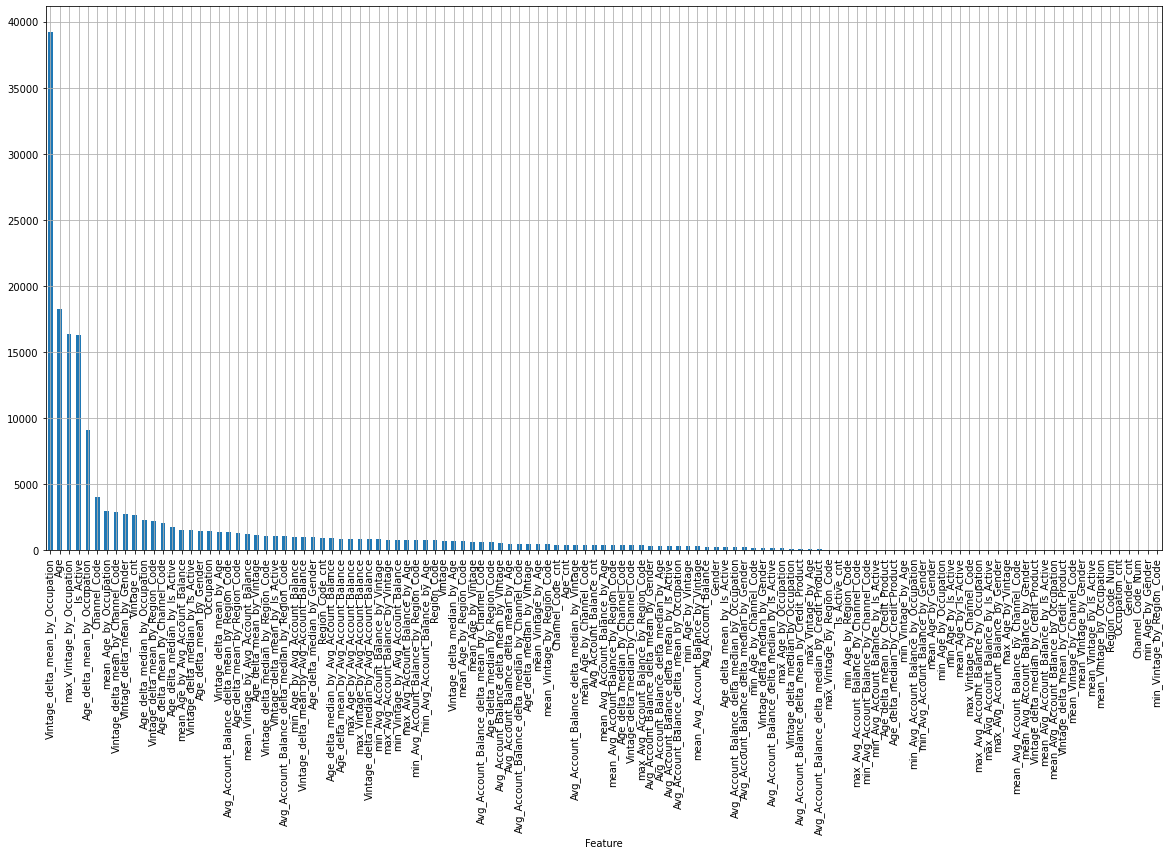

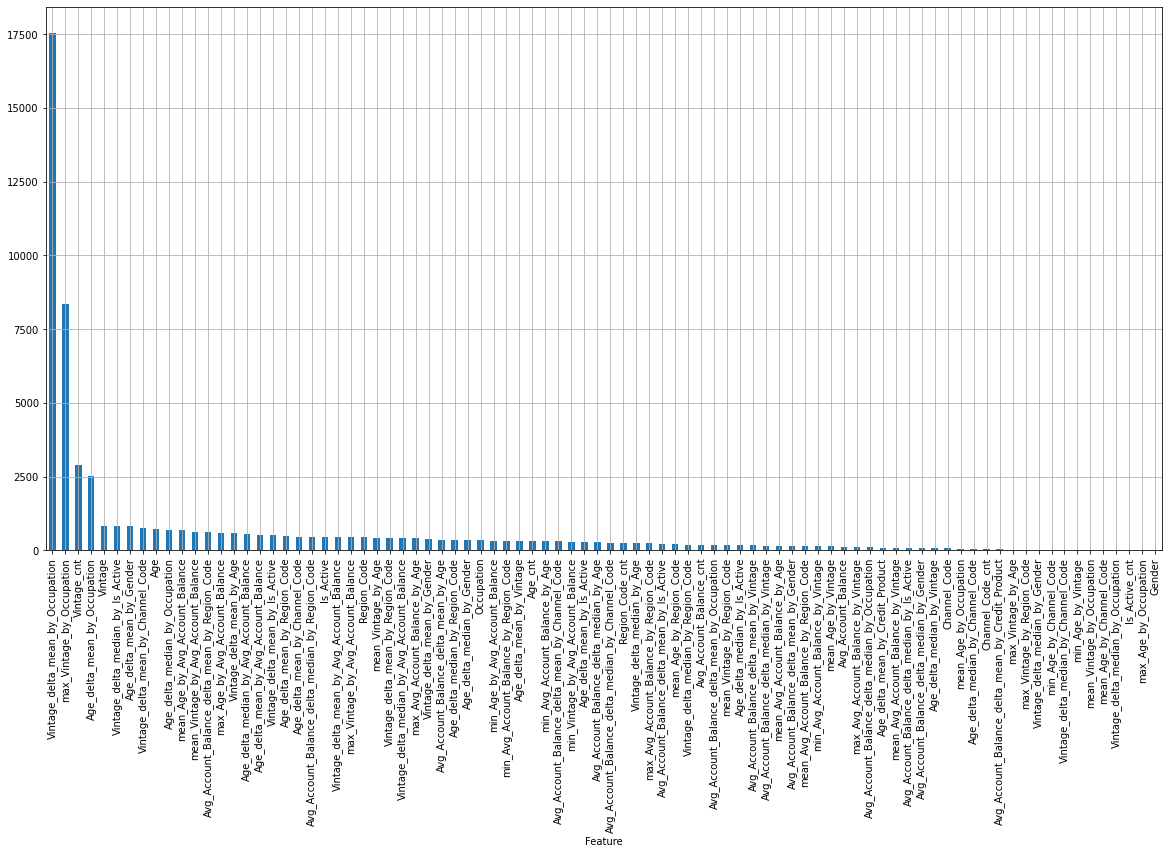

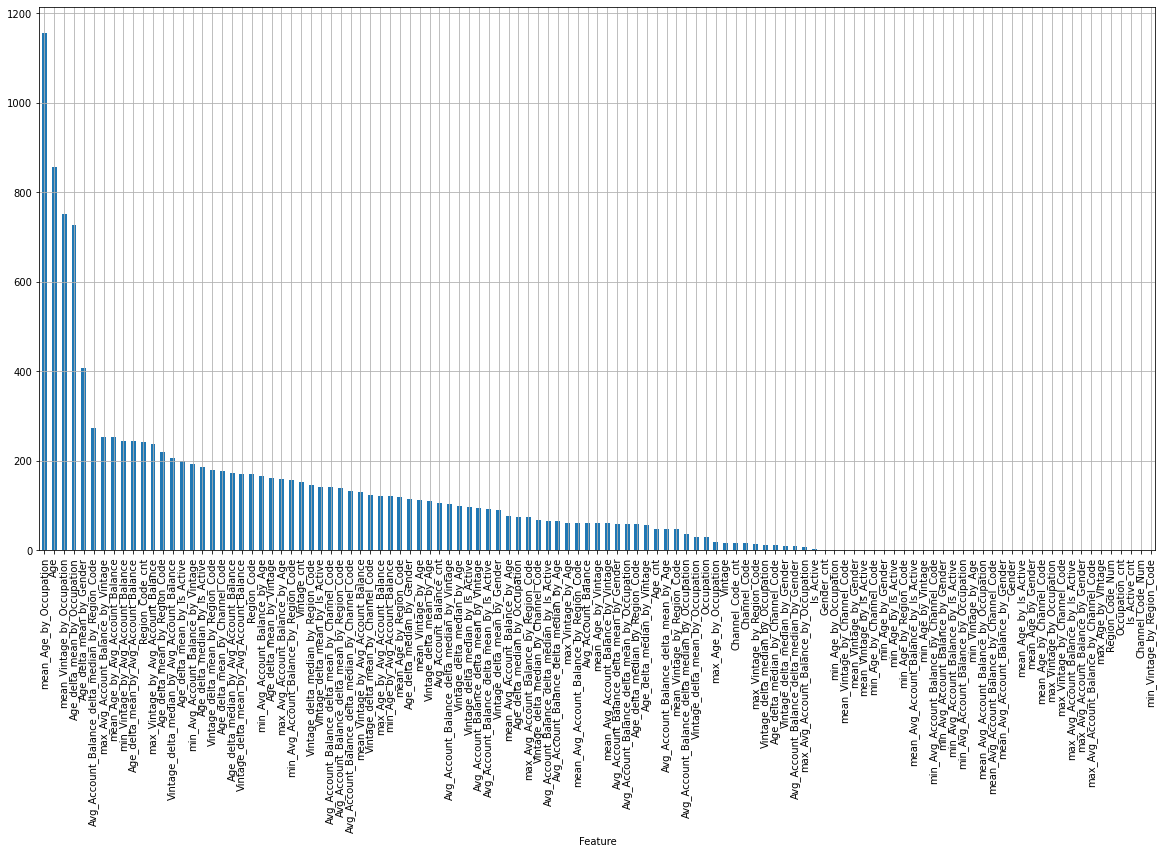

In [40]:
for model in Models_splitted:
    fast_fi = model.get_feature_scores('fast')
    fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)
    plt.show()

## Step 7. Save OOF and TEST preds for splitted

In [41]:
joblib.dump((oof_preds_splitted, test_preds_splitted, [Models_splitted]), 'splitted_data_model.pkl')

['splitted_data_model.pkl']

## Step 8. Create composition submit 

In [42]:
_, test_preds_full, _ = joblib.load('data_full_model.pkl') 
_, test_preds_splitted, _ = joblib.load('splitted_data_model.pkl') 

In [43]:
sample_sub[TARGET_NAME] = 0.5 * test_preds_full + 0.5 * test_preds_splitted
sample_sub

,ID,Is_Lead
0,VBENBARO,0.045989
1,CCMEWNKY,0.876151
2,VK3KGA9M,0.053944
3,TT8RPZVC,0.026923
4,SHQZEYTZ,0.027598
...,...,...
105307,DBENJOYI,0.980717
105308,CWQ72DWS,0.613081
105309,HDESC8GU,0.063646
105310,2PW4SFCA,0.208756


In [44]:
sample_sub.to_csv('combo_submission.csv', index = False)